## Can PCA extract important informations from non-significant features? Neural Network case. <br>Notebook.
    
Machine Learning 2: predictive models, deep learning, neural network <br> final project<br>
Author: Maciej Odziemczyk (388581)<br>
Faculty of Economic Sciences, University of Warsaw<br>
January 2021

### Table of Contents:
 - **Data preparation:**
     - data loading,
     - renaming labes,
     - balance check,
     - data imputation and dropping,
     - data standarization,
 - **Random Forest:**
     - Startified n-Fold Cross Validation,
     - hyperparameter tuning (incl. Random Search),
 - **Feature selection metrics:**
     - Random Forest feature importance,
     - Mutual information,
     - Spearman rank correlation (with target),
     - General to Specyfic procedure based on Logistic regression and Loglikelihood Ratio test,
     - "Lasso" logistic regression (L1 penalty),
     - Features correlations inspection,
 - **Extreme Gradient Boosting:**
     - hyperparameters check on single split,
     - Random search in Startified n-Fold Cross Validation,
     - Grid search in Startified n-Fold Cross Validation (dart booster),
 - **Neural Networks:**
     - hyperparameters and architectures check on single split (50 epochs),
     - Startified n-Fold Cross Validation (50-400 epochs),
 - **Principal Component Analysis:**
     - Data inspection,
 - **PCA based Neural Networks:**
     - Experimets and best model selection,
 - **Model Comparison:**
     - ROC and PR curves, AUC-ROC and AUC-PR test scores,
     - Wilcoxon test for AUC-PR test results in Neural Network models,
     - Wilcoxon test for AUC-PR and AUC-ROC overfitting in Neural Network models.

In [1]:
# libraries
from scipy.io import arff                       # to read .arff format
import pandas as pd                             # data manipulation
import numpy as np                              # vector computations
import matplotlib.pyplot as plt                 # plotting
import seaborn as sns                           # plotting
import time                                     # time measuring
from stargazer.stargazer import Stargazer       # comparison table for logits
from sklearn import feature_selection
from scipy.stats import spearmanr               # statistics
from sklearn import linear_model                # sklearn logistic regression ("Lasso" application)
from  warnings import simplefilter              # warnings filtering
from sklearn.exceptions import ConvergenceWarning               # warnings filtering
from statsmodels.tools.sm_exceptions import ConvergenceWarning  # warnings filtering

In [2]:
# notebook settings
pd.set_option("display.max_columns", 70)
pd.set_option("display.max_rows", 70)
# ignoring some warnings
simplefilter("ignore", category=ConvergenceWarning) 
np.warnings.filterwarnings('ignore', '(overflow|invalid)')

##### Data preparation 

In [3]:
# data improt
data_version = ["1year.arff", "2year.arff", "3year.arff", "4year.arff", "5year.arff"]
data = arff.loadarff(r"data\{}".format(data_version[4]))
data = pd.DataFrame(data[0])

In [4]:
# decoding target variable
data.rename({'class':'bankrupt'}, axis = 1, inplace = True)
data['bankrupt'].replace(b'1', 1, True)
data['bankrupt'].replace(b'0', 0, inplace=True)

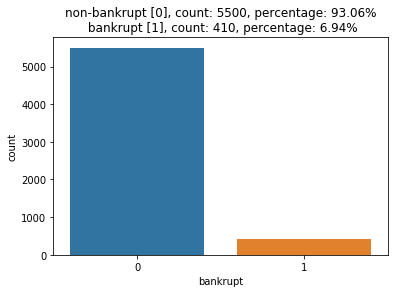

In [5]:
# data balance (labels ratio)
sns.countplot(data.bankrupt)
plt.title('non-bankrupt [0], count: {}, percentage: {}%\n bankrupt [1], count: {}, percentage: {}%'.format(
    data.bankrupt.value_counts()[0],
    round(data.bankrupt.value_counts()[0]/(data.bankrupt.value_counts()[0]+data.bankrupt.value_counts()[1])*100, 2),
    data.bankrupt.value_counts()[1],
    round(data.bankrupt.value_counts()[1]/(data.bankrupt.value_counts()[0]+data.bankrupt.value_counts()[1])*100, 2)))
plt.show()

In [6]:
def get_missing_info(data, y):
    '''
    function creates DataFrame of missing value counts and percentage, for a given data and positive, negative
    and positive percentage for a given target, arguments:
    data - dataset to get informations about (DataFrame)
    y - target value (string)
    
    returns - DataFrame object with informations
    '''
    
    # counting missing and calculating the percentage 
    missing_info = pd.DataFrame((data.isna().sum(), data.isna().sum()/data.shape[0]*100)).T
    missing_info.columns = ["missing_count", "missing_percentage"]
    
    # removing rows without missings
    missing_info = missing_info.where(missing_info > 0).dropna().sort_values(by = "missing_percentage", ascending = False)
    
    # target info inicjalization
    missing_info["non_{}_count".format(y)] = np.nan
    missing_info["{}_count".format(y)] = np.nan
    missing_info["{}_percentage".format(y)] = np.nan
    
    # target info colnames
    neg_count, pos_count, pos_per=missing_info.columns.tolist()[2:]
    
    # target info (counting) columns filling
    cols = missing_info.index.tolist()
    for i in cols:
        missing_info.loc[i, pos_count] = data[y].where(data[i].isna()).dropna().sum()
        missing_info.loc[i, neg_count] = data[y].where(
            data[i].isna()).dropna().shape[0]-missing_info.loc[i, pos_count]
    
    # target info (percentage) column filling
    missing_info[pos_per] = np.round(
        missing_info[pos_count]/(missing_info[neg_count]+missing_info[pos_count])*100, 2)
    
    
    return missing_info

In [7]:
get_missing_info(data, "bankrupt")

missing_count  missing_percentage  non_bankrupt_count  bankrupt_count  \
Attr37         2548.0           43.113367              2338.0           210.0   
Attr27          391.0            6.615905               268.0           123.0   
Attr45          268.0            4.534687               230.0            38.0   
Attr60          268.0            4.534687               230.0            38.0   
Attr24          135.0            2.284264               134.0             1.0   
Attr64          107.0            1.810491                88.0            19.0   
Attr53          107.0            1.810491                88.0            19.0   
Attr28          107.0            1.810491                88.0            19.0   
Attr54          107.0            1.810491                88.0            19.0   
Attr21          103.0            1.742809                 4.0            99.0   
Attr41           84.0            1.421320                84.0             0.0   
Attr32           46.0            0.778342                45.0             1.0   
Attr52           36.0            0.609137                36.0             0.0   
Attr47           35.0            0.592217                35.0             0.0   
Attr40           21.0            0.355330                18.0             3.0   
Attr33           21.0            0.355330                18.0             3.0   
Attr12           21.0            0.355330                18.0             3.0   
Attr63           21.0            0.355330                18.0             3.0   
Attr4            21.0            0.355330                18.0             3.0   
Attr46           21.0            0.355330                18.0             3.0   
Attr17           18.0            0.304569                15.0             3.0   
Attr50           18.0            0.304569                15.0             3.0   
Attr26           18.0            0.304569                15.0             3.0   
Attr8            18.0            0.304569                15.0             3.0   
Attr16           18.0            0.304569                15.0             3.0   
Attr34           18.0            0.304569                15.0             3.0   
Attr61           15.0            0.253807                11.0             4.0   
Attr5            11.0            0.186125                11.0             0.0   
Attr15            6.0            0.101523                 6.0             0.0   
Attr48            3.0            0.050761                 2.0             1.0   
Attr59            3.0            0.050761                 2.0             1.0   
Attr51            3.0            0.050761                 2.0             1.0   
Attr57            3.0            0.050761                 2.0             1.0   
Attr1             3.0            0.050761                 2.0             1.0   
Attr38            3.0            0.050761                 2.0             1.0   
Attr36            3.0            0.050761                 2.0             1.0   
Attr35            3.0            0.050761                 2.0             1.0   
Attr2             3.0            0.050761                 2.0             1.0   
Attr25            3.0            0.050761                 2.0             1.0   
Attr22            3.0            0.050761                 2.0             1.0   
Attr18            3.0            0.050761                 2.0             1.0   
Attr14            3.0            0.050761                 2.0             1.0   
Attr11            3.0            0.050761                 2.0             1.0   
Attr10            3.0            0.050761                 2.0             1.0   
Attr7             3.0            0.050761                 2.0             1.0   
Attr6             3.0            0.050761                 2.0             1.0   
Attr3             3.0            0.050761                 2.0             1.0   
Attr29            3.0            0.050761                 2.0             1.0   
Attr9             1.0            0.0169

Columns to drop because of:
1. Too many missings:
 - Attr37,
 - Attr27,
 - Attr45,
 - Attr60,
2. Potential data leakage:
 - Attr21 (96% of missing data is a bankrupt class - when we observe data missing the algorithm could made a rule of predicting positive class (vast miniority of target) - unreasonable)

In [8]:
# column dropping
data.drop(labels = ["Attr37", "Attr27", "Attr45", "Attr60", "Attr21"], axis = 1, inplace = True)

In [9]:
import statsmodels.formula.api as smf                      # logit from formula
import statsmodels.api as sm                               # logit from formula
from sklearn.model_selection import train_test_split       # data splitting
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score # metrics
from sklearn.model_selection import KFold, StratifiedKFold # K-fold Cross Validation
from sklearn.ensemble import RandomForestClassifier        # Random Forest Estimator
import pickle                                              # models saving

In [10]:
def ProximityMatrix(RF, X, normalize = True):    
    '''
    function computes the proximity matrix for given (trained) random forest and data, arguments:
    RF - trained Random Forst classifier,
    X - data to apply RF,
    normalize - boolean, if true then proximity_matrix = proximity_matrix/num_of_Trees
    
    returns proximity matrix (np.arraty)
    -----
    note: this function is based on stackoverflow topic:
        https://stackoverflow.com/questions/18703136/proximity-matrix-in-sklearn-ensemble-randomforestclassifier
        
    '''
    
    # leaves indices for each x in X
    leaves = RF.apply(X)
    # number of trees
    nTrees = leaves.shape[1]
    # inicjalization (first iteration) proximity matrix
    proximity_matrix = np.equal.outer(leaves[:,0], leaves[:,0]).astype('float')
        # outer applies a function, here equal for each pair in the arguments (leaves[:,0] with itself) ->
        # we get proximities for the first column (first Tree), proximity_matrix[i,j] = 1 <=> i == j,
        # where i, j are indices of leaves for each sample
        # note: proximity_matrix is not the product of the Attr's, its a product of the Trees and the indices of its nodes

    # iteration through the rest of the trees
    for i in range(1, nTrees):
        proximity_matrix += np.equal.outer(leaves[:,i], leaves[:,i]).astype('float')
            
    proximity_matrix = (proximity_matrix/nTrees) if normalize == True else proximity_matrix

    return proximity_matrix    

In [11]:
def RFimputation(dta, n_iter, target, *args, **kwargs):
    '''
    Random Forest proximity based data imputer for a continuous features. Missing are inicialized with median of the 
    feature, after that random forest classifier is trained then based on node ID for particular observation simillarity 
    is determined and proximity matrix is computed and rescaled. 1-proximity is distance. Proximity is a weight in weighted
    average formula for a missing item. The process is repeated normally 5-7 times. Arguments:
    dta - dataset with continuous features with missings,
    n_iter - number of algorithm iterations
    target - target variable
    
    return imputed dataset, missing indices, history of process, missings changes during training 
    '''
    import time
    pd.set_option('mode.chained_assignment', None)
    
    start = time.time()
    # data copy to operate
    df = dta.copy()
    
    # features list
    features = [i for i in df.columns.tolist() if i != target]
    
    # Attr's missings indices inicialization
    # key - attr, value - indices
    attrs_indices = {}

    # Attr's updated values 
    # key - attr, value - imputed values
    attrs_values = {}

    # getting missings indices for each attr and set it to the median 
    for attr in features:
        # indices of missing data for each attribute
        indices = df[attr][df[attr].isna()].index.tolist()
        # median
        median = df[attr].median(skipna=True, axis=0)
        # imputation
        df.loc[indices, attr] = median
        # updating Attr's missings indices dictionary
        attrs_indices[attr] = indices
        # updating Attr's missings updated values dictionary
        attrs_values[attr] = df[attr][attrs_indices[attr]].values.tolist()


    # ********* IMPUTATION LOOP *************** #
    # history inicialization
    history = {}
    # history is a dictionary keys = iteration, keys = dictionary of attrs:lists of missings
    history["iteration_0"] = attrs_values.copy()

    for i in range(n_iter):
        # build and train a classifier (RF)
        clf = RandomForestClassifier(*args, **kwargs) 
        clf.fit(df[features], df[target])

        # compute proximity matrix
        pm = ProximityMatrix(clf, df[features], True)

        # compute weight matrix (each row divided by its sum)
        pm_div = pm/pm.sum(axis = 1, keepdims = True)

        # reset missing values (= 0) (after that, weighted average excludes missing indices, is just a dot product)
        for attr in features:
            df[attr][attrs_indices[attr]] = 0

        # computing imputation matrix - weighted average formula (shape: (n_observations, n_features))
        imputation_matrix = np.dot(pm_div, df.values)

        # data imputation
        for attr in features:
            # attr index in df 
            attr_index = features.index(attr)
            # imputing data (weighted average based on proximity matrix)
            df[attr][attrs_indices[attr]] = imputation_matrix[attrs_indices[attr], attr_index]
            # updating Attr's missings updated values dictionary
            attrs_values[attr] = df[attr][attrs_indices[attr]].values.tolist()
        
        # history update
        history["iteration_{}".format(i+1)] = attrs_values.copy()
    
    # ********* historical changes *************** #
    iterations = list(history.keys())
    # history changes dictionary inicialization
    # key: iteration, value: dictionary
    #                        key: attr, value: percentage change
    history_changes = history.copy()
    # keys for history_changes (excluding "zero" iteration)
    changes_keys = iterations[1:]

    for i in range(len(iterations)-1):
        # values for calculations (concrete iterations)
        itr_prev = iterations[i]
        itr = iterations[i+1]
        # list of the attr's
        attrs = list(history[itr].keys())
        for attr in attrs:
            # transform to array
            itr_prev_array = np.array(history[itr_prev][attr])
            itr_array = np.array(history[itr][attr])
            # change computation
            change = np.abs((itr_array - itr_prev_array) / itr_prev_array)
            # saving historical changes
            history_changes[itr][attr] = change
    
    # final shape of history_changes (excluding "zero" iteration)
    history_changes = {key: history_changes[key] for key in changes_keys}

    stop = time.time()
    print("Imputation time: {} seconds".format(round(stop - start), 2))
    return df, attrs_indices, history, history_changes

In [12]:
# loading if necessary
#     imputed data
#RFdata = pd.read_csv(r"data\5year_imputed.csv")
#     imputed and normalized data
RFdata = pd.read_csv(r"data\5year_imputed_normalized.csv")

In [12]:
# DONE, IMPUTED AND NORMALIZED DATA CAN BE LOADED FROM CSV FILE
RFdata, miss_indices, miss_hist, miss_hist_ch = RFimputation(data, n_iter=6, target = "bankrupt", 
                                                                     n_estimators=100, n_jobs=-1, random_state = 2020,
                                                                    max_depth = 8)

# saving imputed data
#RFdata.to_csv(r"data\5year_imputed.csv", index = False)

Imputation time: 138 seconds


C:\Users\maciej\anaconda3\lib\site-packages\ipykernel_launcher.py:90: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\maciej\anaconda3\lib\site-packages\ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in true_divide


In [13]:
target = "bankrupt"
RFfeatures = [i for i in RFdata.columns.tolist() if i != target]

In [42]:
# DONE, IMPUTED AND NORMALIZED DATA CAN BE LOADED FROM CSV FILE

# standarization (necessary for PCA, helpful for Neural Network) (x-mi)/sigma
start = time.time()
for feature in RFfeatures:
    RFdata.loc[:, feature] = RFdata.loc[:, feature].apply(
        lambda x: (x-RFdata.loc[:, feature].mean())/RFdata.loc[:, feature].std())
stop = time.time()
print("time: {} seconds".format(round(stop-start, 2)))

# saving imputed normalized data
#RFdata.to_csv(r"data\5year_imputed_normalized.csv", index = False)

time: 53.55 seconds


##### Random Forest

In [14]:
# Random Forest Wrapper
def CVTestRFClass(dataframe, target, features, nFolds = 5, randomState = 2020, debug = False,
                  saveModels = False , *args, **kwargs):
    '''
    Random Forest Startified Cross Validation wrapper, function performs N-Fold Startified Cross Validation for a 
    Random Forest and computes statistics, saves predictions and corresponding indices and models for feature importance 
    check. Prepared for binary classification problem, arguments:
    dataframe - dataset contained features and target for classifier,
    target - dependend variable name,
    features - inpdependend variables names,
    nFolds - number of folds in Cross Validation,
    randomState - seed for algorithms,
    debug - boolean, additional info,
    saveModels - boolean, save models trained in folds
    
    return AUC-ROC train score, AUC-ROC test score, AUC-PR train score, AUC-PR test score, predictions, indices, models
    '''
    
    
    # Stratified walidation
    kf = StratifiedKFold(n_splits=nFolds, shuffle=True, random_state=randomState)

    # result lists inicialization
    ROCtestResults = []
    ROCtrainResults = []
    PRtestResults = []
    PRtrainResults = []
    predictions = []
    indices = []
    models = []
    
    # validation loop
    for train, test in kf.split(dataframe.index.values, dataframe[target]):
        # model
        clf = RandomForestClassifier(*args, **kwargs, random_state=randomState, n_jobs=-1)
        
        if debug:
            print(clf)
        
        # training
        clf.fit(dataframe.iloc[train][features], dataframe.iloc[train][target])

        # predictions for train and test set
        predsTrain = clf.predict_proba(dataframe.iloc[train][features])[:,1]
        preds = clf.predict_proba(dataframe.iloc[test][features])[:,1]
        
        # preds and indices save
        predictions.append(preds.tolist().copy())
        indices.append(dataframe.iloc[test].index.tolist().copy())
        
        # metrics computation
        ROCtrainScore = roc_auc_score((dataframe[target].iloc[train]), predsTrain)
        ROCtestScore = roc_auc_score((dataframe[target].iloc[test]), preds)
        PRtrainScore = average_precision_score(dataframe[target].iloc[train], predsTrain)
        PRtestScore = average_precision_score(dataframe[target].iloc[test], preds)
        
        # mertrics to lists 
        ROCtrainResults.append(ROCtrainScore)
        ROCtestResults.append(ROCtestScore)
        PRtrainResults.append(PRtrainScore)
        PRtestResults.append(PRtestScore)
        
        # each fold results check
        if debug:
            print("Train AUC:", ROCtrainScore,
                  "Valid AUC:", ROCtestScore)
            print("Train PR:", PRtrainScore,
                  "Valid PR:", PRtestScore)
            
        # model saving (for feature importance)
        if saveModels:
            models.append(clf)
    
    if saveModels:
        return ROCtrainResults, ROCtestResults, PRtrainResults, PRtestResults, predictions, indices, models
    else:
        return ROCtrainResults, ROCtestResults, PRtrainResults, PRtestResults, predictions, indices

In [15]:
# First RF
ROCtrainResults, ROCtestResults, PRtrainResults, PRtestResults, predictions, indices = CVTestRFClass(dataframe = RFdata,
                                                                                                     target = target,
                                                                                                     features = RFfeatures,
                                                                                                     debug = True)
print(np.mean(ROCtestResults), np.mean(PRtestResults))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=2020, verbose=0,
                       warm_start=False)
Train AUC: 1.0 Valid AUC: 0.8447339246119734
Train PR: 1.0 Valid PR: 0.3748333206306915
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
               

##### Random Forest tuning
 - max_depth

In [16]:
for depth in range(2, 22, 2):
    ROCtrainResults, ROCtestResults, PRtrainResults, PRtestResults, predictions, indices = CVTestRFClass(dataframe = RFdata,
                                                                                                         target = target,
                                                                                                         features = RFfeatures,
                                                                                                         debug=False,
                                                                                                         max_depth = depth)
    print('Max depth: {}\nROC: {}\nPR: {}\nROCtrain-test: {}\nPRtrain-test: {}'.format(
        depth,
        np.mean(ROCtestResults),
        np.mean(PRtestResults), 
        np.mean(ROCtrainResults)-np.mean(ROCtestResults),
        np.mean(PRtrainResults)-np.mean(PRtestResults)))
    print('-'*30)

Max depth: 2
ROC: 0.8363835920177383
PR: 0.38965693363674003
ROCtrain-test: 0.01872547117516632
PRtrain-test: 0.04157255744884414
------------------------------
Max depth: 4
ROC: 0.8540742793791575
PR: 0.41324644766833735
ROCtrain-test: 0.034677868625277
PRtrain-test: 0.15837738752889802
------------------------------
Max depth: 6
ROC: 0.8623270509977827
PR: 0.42970818646837045
ROCtrain-test: 0.062405279933480995
PRtrain-test: 0.2982995676001348
------------------------------
Max depth: 8
ROC: 0.8696518847006652
PR: 0.4510775981120275
ROCtrain-test: 0.0904421424611973
PRtrain-test: 0.38298104638664054
------------------------------
Max depth: 10
ROC: 0.868280487804878
PR: 0.44165642463426186
ROCtrain-test: 0.11751510532150777
PRtrain-test: 0.47163233837500135
------------------------------
Max depth: 12
ROC: 0.8726884700665188
PR: 0.4399598394851652
ROCtrain-test: 0.12421521618625275
PRtrain-test: 0.5313930003855409
------------------------------
Max depth: 14
ROC: 0.8685221729490022
P

6-10 makes sense
 - class_weight ({label:weight})

In [17]:
classes = [{0:1, 1:4}, {0:1, 1:3}, {0:1, 1:2}, {0:1, 1:1}, {0:2, 1:1}, {0:3, 1:1}, {0:4, 1:1}]
for class_weight in classes: 
    ROCtrainResults, ROCtestResults, PRtrainResults, PRtestResults, predictions, indices = CVTestRFClass(dataframe = RFdata,
                                                                                                         target = target,
                                                                                                         features = RFfeatures,
                                                                                                         debug=False,
                                                                                                         class_weight=class_weight,
                                                                                                         max_depth = 8)
    
    print('Weights: {}\nROC: {}\nPR: {}\nROCtrain-test: {}\nPRtrain-test: {}'.format(class_weight,
                                                                                     np.mean(ROCtestResults),
                                                                                     np.mean(PRtestResults), 
                                                                                     np.mean(ROCtrainResults)-np.mean(ROCtestResults),
                                                                                     np.mean(PRtrainResults)-np.mean(PRtestResults)))
    print('-'*30)

Weights: {0: 1, 1: 4}
ROC: 0.8729401330376941
PR: 0.43637541182599077
ROCtrain-test: 0.11208744456762731
PRtrain-test: 0.44434487484631907
------------------------------
Weights: {0: 1, 1: 3}
ROC: 0.8692849223946784
PR: 0.4350701782485505
ROCtrain-test: 0.11336945676274957
PRtrain-test: 0.44491120726748307
------------------------------
Weights: {0: 1, 1: 2}
ROC: 0.8723669623059868
PR: 0.4422523935779883
ROCtrain-test: 0.1043152716186253
PRtrain-test: 0.4270182798588015
------------------------------
Weights: {0: 1, 1: 1}
ROC: 0.8696518847006652
PR: 0.4510775981120275
ROCtrain-test: 0.0904421424611973
PRtrain-test: 0.38298104638664054
------------------------------
Weights: {0: 2, 1: 1}
ROC: 0.8597893569844789
PR: 0.4327564831901312
ROCtrain-test: 0.08452286585365865
PRtrain-test: 0.35740290994065343
------------------------------
Weights: {0: 3, 1: 1}
ROC: 0.8579301552106431
PR: 0.4190318200909455
ROCtrain-test: 0.07468202605321506
PRtrain-test: 0.3450722300357785
--------------------

Default best, other doesn't make sense
 - Number of trees

In [18]:
numOfEstimators = [10, 25, 75, 100, 200, 400, 600, 800, 1000]
for est in numOfEstimators: 
    ROCtrainResults, ROCtestResults, PRtrainResults, PRtestResults, predictions, indices = CVTestRFClass(dataframe = RFdata,
                                                                                                         target = target,
                                                                                                         features = RFfeatures,
                                                                                                         debug=False,
                                                                                                         n_estimators = est,
                                                                                                        max_depth = 8)
    print('Number of trees: {}\nROC: {}\nPR: {}\nROCtrain-test: {}\nPRtrain-test: {}'.format(est,
                                                                                             np.mean(ROCtestResults),
                                                                                             np.mean(PRtestResults), 
                                                                                             np.mean(ROCtrainResults)-np.mean(ROCtestResults),
                                                                                             np.mean(PRtrainResults)-np.mean(PRtestResults)))
    print('-'*30)

Number of trees: 10
ROC: 0.8591851441241685
PR: 0.4152943854497071
ROCtrain-test: 0.08421916574279376
PRtrain-test: 0.38355739322601456
------------------------------
Number of trees: 25
ROC: 0.8706718403547672
PR: 0.45073688939246515
ROCtrain-test: 0.08459097838137475
PRtrain-test: 0.3736118079435099
------------------------------
Number of trees: 75
ROC: 0.8694445676274943
PR: 0.4483980654941302
ROCtrain-test: 0.08927106430155207
PRtrain-test: 0.38362694933176456
------------------------------
Number of trees: 100
ROC: 0.8696518847006652
PR: 0.4510775981120275
ROCtrain-test: 0.0904421424611973
PRtrain-test: 0.38298104638664054
------------------------------
Number of trees: 200
ROC: 0.8701552106430155
PR: 0.44757371176469124
ROCtrain-test: 0.09170066518846998
PRtrain-test: 0.38671239654161155
------------------------------
Number of trees: 400
ROC: 0.8689035476718402
PR: 0.4395628657135117
ROCtrain-test: 0.0940110864745013
PRtrain-test: 0.3940333213610974
----------------------------

looks like 100 trees gives good enough results (even maximum at PR)
 - max_features

In [19]:
print('Rule of thumb\nsquare root of number of features : {}'.format((len(RFfeatures))**(1/2)))

Rule of thumb
square root of number of features : 7.681145747868608


In [20]:
for n in range(1, len(RFfeatures)+1, 4):
    ROCtrainResults, ROCtestResults, PRtrainResults, PRtestResults, predictions, indices = CVTestRFClass(
        dataframe = RFdata,
        target = target,
        features = RFfeatures,
        debug=False,
        max_features = n,
        max_depth = 8,
        n_estimators = 100)
    print('Max number of features in the tree: {}\nROC: {}\nPR: {}\nROCtrain-test: {}\nPRtrain-test: {}'.format(n,
                                            np.mean(ROCtestResults),
                                            np.mean(PRtestResults), 
                                           np.mean(ROCtrainResults)-np.mean(ROCtestResults),
                                           np.mean(PRtrainResults)-np.mean(PRtestResults)))
    print('-'*30)

Max number of features in the tree: 1
ROC: 0.8578824833702882
PR: 0.3981441795261138
ROCtrain-test: 0.09364939024390251
PRtrain-test: 0.37926771555317706
------------------------------
Max number of features in the tree: 5
ROC: 0.86539911308204
PR: 0.4282196604851148
ROCtrain-test: 0.09430529379157426
PRtrain-test: 0.39976592963645924
------------------------------
Max number of features in the tree: 9
ROC: 0.8693470066518847
PR: 0.44654361647633234
ROCtrain-test: 0.0938677245011087
PRtrain-test: 0.39262856378789013
------------------------------
Max number of features in the tree: 13
ROC: 0.8701175166297117
PR: 0.452943086996995
ROCtrain-test: 0.09490957594235039
PRtrain-test: 0.3905610292788973
------------------------------
Max number of features in the tree: 17
ROC: 0.874189578713969
PR: 0.46081457461162145
ROCtrain-test: 0.09170468403547682
PRtrain-test: 0.38685523505699615
------------------------------
Max number of features in the tree: 21
ROC: 0.8770831485587584
PR: 0.48075688

best results with 37-53  (its 62% - 89% of total number of features)
 - min sample split

In [21]:
for minsample in [2, 4, 6, 8, 10, 15, 20, 30]:
    ROCtrainResults, ROCtestResults, PRtrainResults, PRtestResults, predictions, indices = CVTestRFClass(
        dataframe = RFdata,
        target = target,
        features = RFfeatures,
        debug=False,
        max_features = 49,
        max_depth = 8,
        n_estimators = 100,
        min_samples_split = minsample)
    
    print('Min sample split: {}\nROC: {}\nPR: {}\nROCtrain-test: {}\nPRtrain-test: {}'.format(minsample,
                                            np.mean(ROCtestResults),
                                            np.mean(PRtestResults), 
                                           np.mean(ROCtrainResults)-np.mean(ROCtestResults),
                                           np.mean(PRtrainResults)-np.mean(PRtestResults)))
    print('-'*30)

Min sample split: 2
ROC: 0.8791330376940134
PR: 0.4957066563204419
ROCtrain-test: 0.09099272450110851
PRtrain-test: 0.3679319819795918
------------------------------
Min sample split: 4
ROC: 0.8800410199556541
PR: 0.493277038992373
ROCtrain-test: 0.08847283813747253
PRtrain-test: 0.36726711754928215
------------------------------
Min sample split: 6
ROC: 0.8787272727272727
PR: 0.4928279932952557
ROCtrain-test: 0.08765839800443465
PRtrain-test: 0.3596863432162279
------------------------------
Min sample split: 8
ROC: 0.877069844789357
PR: 0.4884710877101961
ROCtrain-test: 0.08814287694013301
PRtrain-test: 0.35793379500761824
------------------------------
Min sample split: 10
ROC: 0.8783070953436806
PR: 0.493154408971722
ROCtrain-test: 0.08608134700665204
PRtrain-test: 0.3438495616859746
------------------------------
Min sample split: 15
ROC: 0.8749645232815965
PR: 0.48657686122927457
ROCtrain-test: 0.0866083009977826
PRtrain-test: 0.3332385231533711
------------------------------
Min

bigger parameter reduces overfitting and results, best default, 2-10 is a reasonable range to test in random search.
 - min samples leaf

In [22]:
for leaf in range(1,16,1):
    ROCtrainResults, ROCtestResults, PRtrainResults, PRtestResults, predictions, indices = CVTestRFClass(
        dataframe = RFdata,
        target = target,
        features = RFfeatures,
        debug=False,
        max_features = 49,
        max_depth = 8,
        n_estimators = 100,
        min_samples_split = 2,
        min_samples_leaf = leaf)
    
    print('min samples leaf: {}\nROC: {}\nPR: {}\nROCtrain-test: {}\nPRtrain-test: {}'.format(leaf,
                                            np.mean(ROCtestResults),
                                            np.mean(PRtestResults), 
                                           np.mean(ROCtrainResults)-np.mean(ROCtestResults),
                                           np.mean(PRtrainResults)-np.mean(PRtestResults)))
    print('-'*30)

min samples leaf: 1
ROC: 0.8791330376940134
PR: 0.4957066563204419
ROCtrain-test: 0.09099272450110851
PRtrain-test: 0.3679319819795918
------------------------------
min samples leaf: 2
ROC: 0.879958980044346
PR: 0.49851006998018377
ROCtrain-test: 0.08915916019955639
PRtrain-test: 0.36104510245336363
------------------------------
min samples leaf: 3
ROC: 0.8822184035476719
PR: 0.4931756208751589
ROCtrain-test: 0.08670606984478935
PRtrain-test: 0.36010719080833425
------------------------------
min samples leaf: 4
ROC: 0.8795332594235035
PR: 0.4900008087988038
ROCtrain-test: 0.08958564301552097
PRtrain-test: 0.3564759607356339
------------------------------
min samples leaf: 5
ROC: 0.8829855875831486
PR: 0.4930117812239053
ROCtrain-test: 0.08569678492239474
PRtrain-test: 0.34424736776507747
------------------------------
min samples leaf: 6
ROC: 0.8816618625277162
PR: 0.48984253274159506
ROCtrain-test: 0.08582933758314848
PRtrain-test: 0.33586208858874034
------------------------------

1-9 makes sense,
To sum up, parameters and its ranges to try in random search:
 - max_depth <6;10>,
 - number of trees {100},
 - max_features <37;53>,
 - min_sample_split <2-10>,
 - min_samples_leaf <1-9>.
##### Random Forest (Random Search)

In [32]:
# DO NOT RUN THIS CHUNK, THE RESULTS CAN BE LOADED FROM .CSV FILE (approx. run time 12 mins.)

import random
random.seed(2020)
start = time.time()
# results DataFrame inicialization 
rstls = pd.DataFrame(columns = ["max_depth", "max_features", "min_samples_split", "min_samples_leaf", 
                               "ROCtest", "ROCtrain-test", "PRtest", "PRtrain-PRtest"])

# searching loop
for k in range(50):
    # parameters dictionary
    params = {
        "max_depth" : random.randint(6, 10),
        "max_features" : random.randint(37, 53),
        "min_samples_split" : random.randint(2, 10),
    }
    # min_samples_leaf has to be lower than min_sample_split
    params["min_samples_leaf"] = random.randint(1, params["min_samples_split"])
    
    # model
    ROCtrainResults, ROCtestResults, PRtrainResults, PRtestResults, predictions, indices = CVTestRFClass(
        dataframe = RFdata,
        target = target,
        features = RFfeatures,
        debug = False,
        n_estimators = 100, 
        max_depth = params["max_depth"],
        max_features = params["max_features"],
        min_samples_split = params["min_samples_split"],
        min_samples_leaf = params["min_samples_leaf"])
    
    # saving
    rstls = rstls.append(other = pd.DataFrame(data = np.array([params["max_depth"], params["max_features"], params["min_samples_split"],
                        params["min_samples_leaf"], np.mean(ROCtestResults),
                           np.mean(ROCtrainResults)-np.mean(ROCtestResults), np.mean(PRtestResults),
                           np.mean(PRtrainResults)-np.mean(PRtestResults)]).reshape(1, -1), columns = rstls.columns.tolist()), ignore_index=True)
    
    # current iteration result
    print(np.round(rstls.iloc[k-1, :], 5).to_dict())
    print('-'*30)
    
    # top 5 per 10 iterations
    if k > 1 and (k+1) % 10 == 0:    
        print("\n Top 5:")
        display(rstls.sort_values(by = "PRtest", ascending = False).head(5))

stop = time.time()
print("Loop time: {} seconds".format(round(stop-start, 2)))

# save random search results
#rstls.to_csv("Random_Forest_Random_Search.csv")

{'max_depth': 10.0, 'max_features': 42.0, 'min_samples_split': 9.0, 'min_samples_leaf': 8.0, 'ROCtest': 0.88806, 'ROCtrain-test': 0.09061, 'PRtest': 0.48842, 'PRtrain-PRtest': 0.34986}
------------------------------
{'max_depth': 10.0, 'max_features': 42.0, 'min_samples_split': 9.0, 'min_samples_leaf': 8.0, 'ROCtest': 0.88806, 'ROCtrain-test': 0.09061, 'PRtest': 0.48842, 'PRtrain-PRtest': 0.34986}
------------------------------
{'max_depth': 9.0, 'max_features': 48.0, 'min_samples_split': 8.0, 'min_samples_leaf': 3.0, 'ROCtest': 0.88154, 'ROCtrain-test': 0.09564, 'PRtest': 0.48942, 'PRtrain-PRtest': 0.38422}
------------------------------
{'max_depth': 10.0, 'max_features': 39.0, 'min_samples_split': 9.0, 'min_samples_leaf': 4.0, 'ROCtest': 0.88668, 'ROCtrain-test': 0.09751, 'PRtest': 0.49544, 'PRtrain-PRtest': 0.39507}
------------------------------
{'max_depth': 7.0, 'max_features': 50.0, 'min_samples_split': 5.0, 'min_samples_leaf': 5.0, 'ROCtest': 0.8817, 'ROCtrain-test': 0.07488, 

max_depth  max_features  min_samples_split  min_samples_leaf   ROCtest  \
9       10.0          46.0                9.0               4.0  0.886102   
2       10.0          39.0                9.0               4.0  0.886675   
3        7.0          50.0                5.0               5.0  0.881701   
1        9.0          48.0                8.0               3.0  0.881535   
5        7.0          52.0               10.0               8.0  0.883237   

   ROCtrain-test    PRtest  PRtrain-PRtest  
9       0.097777  0.496149        0.393666  
2       0.097514  0.495444        0.395072  
3       0.074880  0.494453        0.311444  
1       0.095643  0.489420        0.384218  
5       0.071327  0.489243        0.289277

{'max_depth': 10.0, 'max_features': 46.0, 'min_samples_split': 9.0, 'min_samples_leaf': 4.0, 'ROCtest': 0.8861, 'ROCtrain-test': 0.09778, 'PRtest': 0.49615, 'PRtrain-PRtest': 0.39367}
------------------------------
{'max_depth': 8.0, 'max_features': 53.0, 'min_samples_split': 9.0, 'min_samples_leaf': 4.0, 'ROCtest': 0.88191, 'ROCtrain-test': 0.08591, 'PRtest': 0.49501, 'PRtrain-PRtest': 0.34609}
------------------------------
{'max_depth': 10.0, 'max_features': 38.0, 'min_samples_split': 10.0, 'min_samples_leaf': 10.0, 'ROCtest': 0.88565, 'ROCtrain-test': 0.09018, 'PRtest': 0.47847, 'PRtrain-PRtest': 0.33128}
------------------------------
{'max_depth': 7.0, 'max_features': 44.0, 'min_samples_split': 6.0, 'min_samples_leaf': 3.0, 'ROCtest': 0.87859, 'ROCtrain-test': 0.07697, 'PRtest': 0.47861, 'PRtrain-PRtest': 0.33608}
------------------------------
{'max_depth': 7.0, 'max_features': 50.0, 'min_samples_split': 8.0, 'min_samples_leaf': 5.0, 'ROCtest': 0.8817, 'ROCtrain-test': 0.07488, 

max_depth  max_features  min_samples_split  min_samples_leaf   ROCtest  \
9        10.0          46.0                9.0               4.0  0.886102   
2        10.0          39.0                9.0               4.0  0.886675   
10        8.0          53.0                9.0               4.0  0.881915   
3         7.0          50.0                5.0               5.0  0.881701   
13        7.0          50.0                8.0               5.0  0.881701   

    ROCtrain-test    PRtest  PRtrain-PRtest  
9        0.097777  0.496149        0.393666  
2        0.097514  0.495444        0.395072  
10       0.085905  0.495015        0.346089  
3        0.074880  0.494453        0.311444  
13       0.074880  0.494453        0.311444

{'max_depth': 7.0, 'max_features': 52.0, 'min_samples_split': 7.0, 'min_samples_leaf': 6.0, 'ROCtest': 0.88084, 'ROCtrain-test': 0.07497, 'PRtest': 0.48601, 'PRtrain-PRtest': 0.31108}
------------------------------
{'max_depth': 9.0, 'max_features': 39.0, 'min_samples_split': 5.0, 'min_samples_leaf': 3.0, 'ROCtest': 0.88172, 'ROCtrain-test': 0.09775, 'PRtest': 0.49114, 'PRtrain-PRtest': 0.38865}
------------------------------
{'max_depth': 8.0, 'max_features': 37.0, 'min_samples_split': 10.0, 'min_samples_leaf': 8.0, 'ROCtest': 0.88331, 'ROCtrain-test': 0.08113, 'PRtest': 0.47711, 'PRtrain-PRtest': 0.32043}
------------------------------
{'max_depth': 10.0, 'max_features': 49.0, 'min_samples_split': 8.0, 'min_samples_leaf': 5.0, 'ROCtest': 0.88726, 'ROCtrain-test': 0.09697, 'PRtest': 0.50051, 'PRtrain-PRtest': 0.38586}
------------------------------
{'max_depth': 6.0, 'max_features': 47.0, 'min_samples_split': 3.0, 'min_samples_leaf': 2.0, 'ROCtest': 0.87367, 'ROCtrain-test': 0.06253, 

max_depth  max_features  min_samples_split  min_samples_leaf   ROCtest  \
26        8.0          53.0                7.0               5.0  0.884028   
22       10.0          49.0                8.0               5.0  0.887259   
9        10.0          46.0                9.0               4.0  0.886102   
2        10.0          39.0                9.0               4.0  0.886675   
10        8.0          53.0                9.0               4.0  0.881915   

    ROCtrain-test    PRtest  PRtrain-PRtest  
26       0.084324  0.501730        0.335170  
22       0.096970  0.500511        0.385862  
9        0.097777  0.496149        0.393666  
2        0.097514  0.495444        0.395072  
10       0.085905  0.495015        0.346089

{'max_depth': 9.0, 'max_features': 41.0, 'min_samples_split': 10.0, 'min_samples_leaf': 7.0, 'ROCtest': 0.88519, 'ROCtrain-test': 0.08943, 'PRtest': 0.4924, 'PRtrain-PRtest': 0.34265}
------------------------------
{'max_depth': 6.0, 'max_features': 39.0, 'min_samples_split': 5.0, 'min_samples_leaf': 1.0, 'ROCtest': 0.87026, 'ROCtrain-test': 0.06411, 'PRtest': 0.47496, 'PRtrain-PRtest': 0.29254}
------------------------------
{'max_depth': 8.0, 'max_features': 53.0, 'min_samples_split': 10.0, 'min_samples_leaf': 8.0, 'ROCtest': 0.88509, 'ROCtrain-test': 0.08075, 'PRtest': 0.49317, 'PRtrain-PRtest': 0.31216}
------------------------------
{'max_depth': 8.0, 'max_features': 42.0, 'min_samples_split': 8.0, 'min_samples_leaf': 4.0, 'ROCtest': 0.88312, 'ROCtrain-test': 0.08581, 'PRtest': 0.49007, 'PRtrain-PRtest': 0.35564}
------------------------------
{'max_depth': 6.0, 'max_features': 51.0, 'min_samples_split': 7.0, 'min_samples_leaf': 1.0, 'ROCtest': 0.87204, 'ROCtrain-test': 0.06406, '

max_depth  max_features  min_samples_split  min_samples_leaf   ROCtest  \
26        8.0          53.0                7.0               5.0  0.884028   
22       10.0          49.0                8.0               5.0  0.887259   
36        9.0          49.0                9.0               4.0  0.884084   
9        10.0          46.0                9.0               4.0  0.886102   
35       10.0          46.0                8.0               4.0  0.885572   

    ROCtrain-test    PRtest  PRtrain-PRtest  
26       0.084324  0.501730        0.335170  
22       0.096970  0.500511        0.385862  
36       0.093785  0.499070        0.371780  
9        0.097777  0.496149        0.393666  
35       0.099085  0.495953        0.398003

{'max_depth': 9.0, 'max_features': 46.0, 'min_samples_split': 3.0, 'min_samples_leaf': 3.0, 'ROCtest': 0.88255, 'ROCtrain-test': 0.09703, 'PRtest': 0.49453, 'PRtrain-PRtest': 0.38857}
------------------------------
{'max_depth': 10.0, 'max_features': 50.0, 'min_samples_split': 10.0, 'min_samples_leaf': 8.0, 'ROCtest': 0.88942, 'ROCtrain-test': 0.09004, 'PRtest': 0.49614, 'PRtrain-PRtest': 0.34504}
------------------------------
{'max_depth': 8.0, 'max_features': 48.0, 'min_samples_split': 5.0, 'min_samples_leaf': 2.0, 'ROCtest': 0.88097, 'ROCtrain-test': 0.08819, 'PRtest': 0.49335, 'PRtrain-PRtest': 0.36353}
------------------------------
{'max_depth': 9.0, 'max_features': 51.0, 'min_samples_split': 6.0, 'min_samples_leaf': 4.0, 'ROCtest': 0.88336, 'ROCtrain-test': 0.09531, 'PRtest': 0.4945, 'PRtrain-PRtest': 0.37838}
------------------------------
{'max_depth': 8.0, 'max_features': 48.0, 'min_samples_split': 9.0, 'min_samples_leaf': 5.0, 'ROCtest': 0.88108, 'ROCtrain-test': 0.08814, '

max_depth  max_features  min_samples_split  min_samples_leaf   ROCtest  \
26        8.0          53.0                7.0               5.0  0.884028   
22       10.0          49.0                8.0               5.0  0.887259   
44        9.0          48.0               10.0               4.0  0.886341   
36        9.0          49.0                9.0               4.0  0.884084   
47       10.0          47.0                8.0               7.0  0.890031   

    ROCtrain-test    PRtest  PRtrain-PRtest  
26       0.084324  0.501730        0.335170  
22       0.096970  0.500511        0.385862  
44       0.091038  0.500074        0.363602  
36       0.093785  0.499070        0.371780  
47       0.090827  0.497214        0.358193

Loop time: 699.3 seconds


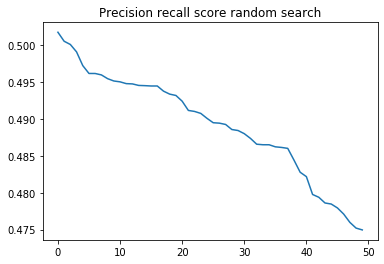

In [23]:
# load random search results
rstls = pd.read_csv("Random_Forest_Random_Search.csv")

# plot
plt.plot([x for x in sorted(rstls.PRtest.tolist(), reverse=True)])
plt.title('Precision recall score random search')
plt.show()

Graph is sorted descending by PR performance, we can see that searchnig procedure gave results between 0.475 and 0.5 => 2.5% in performance only for hyperparameters tuning, that is a lot.

In [24]:
# train the best model and save its results 
ROCtrainResults, ROCtestResults, PRtrainResults, PRtestResults, predictions, indices, models = CVTestRFClass(
    dataframe = RFdata,
    target = target,
    features = RFfeatures,
    debug=False,
    max_features = 53,
    max_depth = 8,
    n_estimators = 100,
    min_samples_split = 7,
    min_samples_leaf = 5,
    saveModels = True)

print('The best Random Forest\nROC: {}\nPR: {}\nROCtrain-test: {}\nPRtrain-test: {}'.format(
    np.mean(ROCtestResults),
    np.mean(PRtestResults), 
    np.mean(ROCtrainResults)-np.mean(ROCtestResults),
    np.mean(PRtrainResults)-np.mean(PRtestResults)))

RF_01 = {
    "name":"RF",
    "description":"RF model with optimal hyperparameters",
    "specification":'n_estimators=100, max_depth=8, max_features=53, min_samples_split=7, min_samples_leaf=5',
    "ROCtrainResults":ROCtrainResults.copy(),
    "ROCtestResults":ROCtestResults.copy(),
    "PRtrainResults":PRtrainResults.copy(),
    "PRtestResults":PRtestResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
    "variables":RFfeatures.copy()
}

save_RF_01 = False

if save_RF_01:
    with open("RF_01.p", "wb") as fp:
        pickle.dump(RF_01, fp)

The best Random Forest
ROC: 0.8840277161862528
PR: 0.5017303865728134
ROCtrain-test: 0.08432414079822614
PRtrain-test: 0.3351695467050828


Typical tree based results - near ideal fit to the training data and high risk of a big overfitting, especially on harder metrics, AUC-PR in this case (33.5%). Nevertheless the results are pretty good, 88.4% AUC-ROC and 50% AUC-PR considering implementation simplicity, Random Forest works very well here.
### Feature Selection methods:
#####  - Random Forest  (Feature importance)
That means, impiurity based score for particular features in performed algorithm

In [25]:
# Random Forest feature importance DF
RFimportance = pd.DataFrame((RFfeatures, models[0].feature_importances_, models[1].feature_importances_,
                             models[2].feature_importances_, models[3].feature_importances_,
                             models[4].feature_importances_)).T
# seting colnames
RFimportance.columns = columns = ("feature", "fold_1", "fold_2", "fold_3", "fold_4", "fold_5")

# average feature importance in all 5 folds (sum up to 1)
RFimportance["folds_avg"] = RFimportance.loc[:,["fold_1", "fold_2", "fold_3", "fold_4", "fold_5"]].mean(axis = 1)

# sorting by folds average
RFimportance = RFimportance.sort_values(by = "folds_avg", ascending = False, ignore_index = True)

RFimportance

feature      fold_1      fold_2      fold_3      fold_4      fold_5  \
0   Attr39    0.168974    0.088697    0.105829    0.134683   0.0552948   
1   Attr35   0.0691498    0.109022   0.0875376   0.0897163    0.174103   
2   Attr46   0.0891738   0.0845037   0.0806123   0.0785817    0.107923   
3   Attr41   0.0173947   0.0811202    0.138144    0.064331   0.0446004   
4   Attr24   0.0563376   0.0538245    0.049974   0.0482212   0.0760245   
5   Attr22   0.0561558   0.0294017   0.0307633   0.0481753   0.0694534   
6   Attr56    0.041923   0.0514389    0.034044   0.0454191    0.030099   
7   Attr40   0.0420899   0.0195786   0.0274904   0.0412631   0.0166773   
8    Attr5   0.0200522   0.0263929   0.0172396   0.0312836    0.029597   
9    Attr4   0.0329384   0.0222423   0.0178278   0.0113272   0.0179686   
10  Attr55   0.0165868   0.0216562   0.0180845   0.0145737   0.0185159   
11  Attr58   0.0172095   0.0169853   0.0161189   0.0147125   0.0191951   
12  Attr34   0.0158353   0.0187544   0.0139938   0.0148365    0.017106   
13  Attr47   0.0187604   0.0113116   0.0170791   0.0147396   0.0172217   
14  Attr29   0.0144763   0.0175217   0.0153067   0.0181366   0.0130725   
15   Attr9   0.0165779   0.0100477  0.00974983   0.0172709   0.0122932   
16  Attr20   0.0130709   0.0143735   0.0116911   0.0122284   0.0143275   
17  Attr42   0.0224494   0.0171554   0.0071199    0.011979  0.00687299   
18  Attr61   0.0117109   0.0150186   0.0116871   0.0102457   0.0122256   
19  Attr57   0.0136878   0.0135847   0.0122431   0.0131909  0.00799687   
20  Attr15   0.0127878   0.0113452   0.0105842   0.0127961   0.0116219   
21  Attr43   0.0135171    0.011974   0.0113033   0.0110399   0.0109539   
22  Attr44   0.0111377   0.0136101    0.010808   0.0098951   0.0119295   
23  Attr25   0.0108477   0.0128954   0.0111352  0.00729801   0.0141143   
24  Attr13  0.00647521   0.0168383   0.0136111  0.00821072  0.00714684   
25   Attr6  0.00846928  0.00877156  0.00789159   0.0158859  0.00930847   
26  Attr64  0.00793973   0.0120705   0.0113188  0.00977535  0.00897976   
27  Attr54  0.00927669  0.00752279  0.00991628  0.00798345   0.0136018   
28  Attr36     0.01151   0.0080232  0.00856654   0.0110627  0.00780402   
29   Attr3   0.0112018  0.00958783  0.00950552  0.00984416  0.00500792   
30  Attr26  0.00978129  0.00884454   0.0113499  0.00753269  0.00581589   
31  Attr59  0.00917211   0.0111242  0.00787897  0.00861932  0.00616863   
32  Attr28  0.00716665  0.00827606  0.00814484  0.00966073  0.00621541   
33   Attr1  0.00418446  0.00886487  0.00849997   0.0100476  0.00719337   
34  Attr63  0.00648515  0.00622481   0.0150381  0.00607243  0.00431207   
35  Attr38  0.00537681  0.00854933  0.00917667  0.00843097  0.00657496   
36  Attr48  0.00904625  0.00693047  0.00660984  0.00712868  0.00771237   
37  Attr49  0.00637116  0.00727219  0.00790599  0.00983327  0.00542814   
38  Attr53  0.00698459  0.00764927  0.00691525  0.00799287   0.0070044   
39  Attr16  0.00737228  0.00727719  0.00970181  0.00675685   0.0039919   
40  Attr50    0.007443  0.00404317  0.00676356   0.0100635  0.00636849   
41  Attr51  0.00500821  0.00741826  0.00580453  0.00638816  0.00691668   
42  Attr12  0.00498491  0.00529096   0.0068925  0.00666253  0.00501262   
43  Attr62  0.00547499  0.00421143  0.00645305  0.00685847  0.00477501   
44  Attr30  0.00501229  0.00407256  0.00599571  0.00635554  0.00501153   
45  Attr32  0.00426307  0.00469063  0.00303381  0.00582169  0.00741135   
46  Attr33  0.00376337  0.00551948  0.00451077   0.0041604  0.00711177   
47  Attr11  0.00443576  0.00621417  0.00363432  0.00660709  0.00348491   
48  Attr23  0.00375681   0.0080887  0.00196905  0.00280481  0.00429398   
49  Attr14  0.00380393  0.00541228  0.00507217  0.00270121  0.00282244   
50   Attr7  0.00320817  0.00563035   0.0050019  0.00248564  0.00310603   
51  Attr18  0.00184014   0.0031159   0.0057915  0.00344153  0.00275998   
52  Attr31   0.0026412  0.00343562   0.0041072    0.001741  0.00396789   
53  Att

because of n-Fold structure and different forest, average score is computed and used for further analysis
##### -  Mutual Information and Spearman correlation (with target)
Mutual information (MI) between two random variables is a non-negative value, which measures the dependency between the variables. It is equal to zero if and only if two random variables are independent, and higher values mean higher dependency.

The function relies on nonparametric methods based on entropy estimation from k-nearest neighbors distances. (Sklearn documentation)

Spearman correlation catches nonlinear dependencies and normality data distribution assumption isn't needed. Spearman rho coef with binary variable isn't a perfect dependecy measure, but may help with some hard decissions. 

In [26]:
# Mutual Information and Spearman correlation
# results dataframe inicialization 
sp_mi = pd.DataFrame(data = np.ones((len(RFfeatures), 4)),
                     columns = ['feature', 'Mutual information', 'Spearman', 'p_value (Spearman)'])

i = 0
for f in RFfeatures:
    # MI for classification problem, discrete_features = False, because independent variables are continuous
    mi = feature_selection.mutual_info_classif((RFdata[f].values).reshape(-1, 1),
                                                  RFdata[target].values, random_state = 2020, discrete_features = False)
    # Spearman coef and p_value
    corr, p = spearmanr(RFdata[f].values, RFdata[target].values)
    
    # saving
    sp_mi.iloc[i, :] = (f, mi, corr, round(p, 4)) 
    i += 1
    
# sorting by mutual info
sp_mi = sp_mi.sort_values(by = 'Mutual information', ascending = False)

In [27]:
sp_mi

feature  Mutual information  Spearman  p_value (Spearman)
35  Attr39            0.052424 -0.254034              0.0000
32  Attr35            0.052228 -0.246185              0.0000
37  Attr41            0.050847 -0.157024              0.0000
20  Attr22            0.049779 -0.218669              0.0000
12  Attr13            0.048422 -0.250628              0.0000
14  Attr15            0.047433 -0.150278              0.0000
15  Attr16            0.046541 -0.256890              0.0000
24  Attr26            0.045909 -0.258157              0.0000
38  Attr42            0.044162 -0.225037              0.0000
21  Attr23            0.043301 -0.240145              0.0000
18  Attr19            0.042024 -0.238860              0.0000
0    Attr1            0.041519 -0.234812              0.0000
10  Attr11            0.040592 -0.220678              0.0000
11  Attr12            0.040506 -0.243476              0.0000
6    Attr7            0.039636 -0.233565              0.0000
13  Attr14            0.039599 -0.233602              0.0000
17  Attr18            0.039478 -0.233496              0.0000
28  Attr31            0.036827 -0.236166              0.0000
44  Attr49            0.036546 -0.186265              0.0000
22  Attr24            0.035016 -0.184936              0.0000
49  Attr54            0.034546 -0.164078              0.0000
51  Attr56            0.034291 -0.196624              0.0000
41  Attr46            0.034207 -0.218417              0.0000
53  Attr58            0.034131  0.182982              0.0000
50  Attr55            0.030980 -0.222305              0.0000
34  Attr38            0.030481 -0.197231              0.0000
25  Attr28            0.029764 -0.157871              0.0000
2    Attr3            0.029481 -0.182753              0.0000
48  Attr53            0.028954 -0.158999              0.0000
3    Attr4            0.028119 -0.196016              0.0000
46  Attr51            0.028083  0.183119              0.0000
56  Attr62            0.027854  0.173224              0.0000
23  Attr25            0.027677 -0.231837              0.0000
52  Attr57            0.026247 -0.088061              0.0000
57  Attr63            0.026124 -0.175914              0.0000
1    Attr2            0.025502  0.189182              0.0000
9   Attr10            0.025500 -0.189957              0.0000
43  Attr48            0.025374 -0.184413              0.0000
7    Attr8            0.023888 -0.192541              0.0000
45  Attr50            0.023318 -0.176746              0.0000
16  Attr17            0.022886 -0.190466              0.0000
5    Attr6            0.019684 -0.199754              0.0000
4    Attr5            0.019240 -0.178042              0.0000
8    Attr9            0.017725 -0.024149              0.0634
29  Attr32            0.014638  0.138058              0.0000
36  Attr40            0.013451 -0.151741              0.0000
30  Attr33            0.013386 -0.124632              0.0000
27  Attr30            0.013209  0.158643              0.0000
26  Attr29            0.012941 -0.145293              0.0000
54  Attr59            0.011899 -0.063298              0.0000
31  Attr34            0.010131 -0.012320              0.3437
47  Attr52            0.009443  0.124254              0.0000
33  Attr36            0.006424  0.019404              0.1358
39  Attr43            0.005259 -0.013322              0.3058
55  Attr61            0.004074  0.055145              0.0000
40  Attr44            0.003612 -0.055543              0.0000
58  Attr64            0.002659  0.005877              0.6515
19  Attr20            0.000293 -0.005688              0.6620
42  Attr47            0.000000 -0.051595              0.0001

Mutual information sums up to one so it can be interpreted as conditional percentage uncertainty reduction. There are 59 features and some of them have near 5% MI, that features may be considered as good predictiors. Features with MI below 2-3% are rather poor in performance. 

##### -  General to specyfic procedure (logistic regression)

Old good econometric method, based on Loglikelihood ratio test for logistic regression and statisticas significance of exploratory variables vector components estimates. It is not perfect, but Lovell's bias robustness makes this method a nice to have in feature selection toolbox.

In [28]:
def testLR(resmod, formula, data, alfa = 0.05,  model = 'logit', solver = "ncg", info = False):
    ''' 
     function that computes Likelihood Ratio test for logit, probit and ols models, arguments:
     resmod - general model (fitted)
     formula - restricted model formula,
     data - data for the models (general and restricted),
     alfa - confidence level,
     model - type of the model to estimate ("logit", "probit", "ols"), should be the same as for general model (resmod)
     
     return H_0, conmod - (H0 == 1: can't reject H0 (significant features), conmod == restricted model)
     -----
     Note: function works for statsmodels.formula.api models (logit, probit, ols)
     '''

    
    # import chi^2 distribution and statsmodels
    from scipy.stats import chi2
    import statsmodels.formula.api as smf           
    
    # unrestricted model logliklelihood 
    logLikelihoodUnc = resmod.llf
    
    # choosen type model estimation
    if model == 'logit':
        conmod = smf.logit(formula = formula, data = data).fit(maxiter = 100, disp = False, method = solver)
    elif model == 'probit':
        conmod = smf.probit(formula = formula, data = data).fit(maxiter = 100, disp = False, method = solver)
    elif model == "ols":
        conmod = smf.ols(formula = formula, data = data).fit()
    else:
        raise 'testLR function works only for "logit", "probit", "ols" models.'
    
    # degrees of freedom for chi^2 distribution
    g = resmod.pvalues.shape[0] - conmod.pvalues.shape[0]
    logLikelihoodCon = conmod.llf
    if g <= 0:
        raise "degrees of freedom number has to be positive. Constrained model has to contain fewer variables than unconstrained model"
    else:
        pass
    
    # LR statistic, critical value and p value
    LR = 2*(logLikelihoodUnc-logLikelihoodCon)
    critical_value = chi2.ppf(q = 1-alfa, df = g)
    p = 1-chi2.cdf(LR, df = g)
    
    # Hypotesis verification
    if LR > critical_value:
        H_0 = 0
    else:
        H_0 = 1
        
    if info:
        print("LR: {}\n crit: {}\n pval: {}".format(LR, critical_value, p))
    
    return H_0, conmod

In [29]:
def general_to_specyfic(model, dataframe, target, alpha = 0.05, info = False):
    '''
    function that performs automatic general to specyfic procedure based on the LR test, robust to Lovell's bias, arguments:
    model - general model (unrestricted),
    dataframe - general model dataset, 
    target - dependent variable,
    alpha - confidence level for the LR test.
    
    return (sifnificant variables list, non signigicant variables list) - ([], [])
    '''
    
    # coefs, p_values dataframe for unconstrained model
    df = pd.concat((pd.DataFrame(model.params), pd.DataFrame(model.pvalues)), axis = 1) 
    df.columns = ("coef", "p_value")
    df = df[1:]
    
    
    # list of features in the dataset
    features = [i for i in list(dataframe.columns) if i != target]
    
    # non signigicant variables list inicialization
    nonsig = []
    
    # constrained model object inicialization
    conmod = None
    
    # test LR
    while True:
        # take previous step coefs and p_values (may change during procedure because of multicoliearity, omitted variable
        #     bias, etc.)
        if conmod:
            df = pd.concat((pd.DataFrame(conmod.params), pd.DataFrame(conmod.pvalues)), axis = 1)
            df.columns = ("coef", "p_value")
            df = df[1:]
        
        # Checking whole model importance (LLR), p > alpha => end of the procedure 
        if model.llr_pvalue > alpha:
            nonsig, sig = features, []
            if info: print("All variables are non signigicant. P value for LLR: {}".format(round(model.llr_pvalue, 2)))
            break
        # only one variable at one step
        nonsig_curr = [] + [df.index.where(df.p_value == df.p_value.max(axis = 0)).dropna().tolist()[0]]
        # current sifnigicant variables are all the variables that aren't in non significant list and aren't equal to  
        #     currently tested variable
        sig = [i for i in features if (i not in nonsig) and (i != nonsig_curr[0])]
        formula = "{}~{}".format(target, "+".join(sig))
        H_0, conmod = testLR(model, formula, dataframe, alpha, model = "logit", info = info)
        # H0 rejection 
        if H_0 == 0:
            sig.append(nonsig_curr[0])
            break
        else:
            df.drop(labels = nonsig_curr, inplace = True)
            nonsig.append(nonsig_curr[0])
            
    return (sig, nonsig)

In [30]:
# building general logit model
formula = "{}~{}".format(target, "+".join(RFfeatures))
general_logit = smf.logit(formula, RFdata).fit(method = "ncg", maxiter = 100, disp = True)

Optimization terminated successfully.
         Current function value: 0.181973
         Iterations: 28
         Function evaluations: 36
         Gradient evaluations: 63
         Hessian evaluations: 28


standard solver can't handle this data (multicolinearity)

In [31]:
# General to Specyfic procedure
start = time.time()
sig, nonsig = general_to_specyfic(general_logit, RFdata, target, info = False)
stop = time.time()
print("time: {}".format(round(stop-start, 2)))

time: 6.82


Speed and a deep statistical background is the advantage of this method, near 7 seconds and maybe not optimal implementation can produce a list of non-signigicant features out of 59.

In [32]:
# building specyfic logit model (after GtS procedure)
formula = "{}~{}".format(target, "+".join(sig))
specyfic_logit = smf.logit(formula, RFdata).fit(method = "ncg", maxiter = 100, disp = True)

Optimization terminated successfully.
         Current function value: 0.185657
         Iterations: 23
         Function evaluations: 39
         Gradient evaluations: 61
         Hessian evaluations: 23


In [33]:
# logits comparison
Stargazer([general_logit, specyfic_logit])

It is nice to see that model parameters didn't change too much, of course there are some strange estimates in general model, especially extremely big standard errors. In logistc regression only signs can be interpreted, and they are consistent. Of course in this kind of problem parameters interpretation isn't a good idea especially when data was standarized. Financial indicators can be considered as predictors only and some proxy of the "real" Data Generating Process/determinants if it exists.   
##### -  "Lasso" logit (L1 regularization)

L1 regularization is another nice feature selection tool. Increasing penalty makes poor-performance predictors coefs closer to the zero, that means it is possible to spot unnecessary features.

In [118]:
# DO NOT RUN THIS CHUNK, THE RESULTS CAN BE LOADED FROM .CSV FILE (approx. run time 20 mins.)

# C space (C is an inverse of the regularization parameter, see documentation)
# alphas are elements of C
n_alphas = 200                          # number of regularization terms
alphas = np.linspace(1,50, n_alphas)    # space

# coefs list inicialization
coefsL = []
start = time.time()

# Loop for every alpha
for a in alphas:    
    # model: L1-Lasso penalty, solver-only saga and liblinear handles L1, saga is much faster, C is inverted and now it is
    #    a proper regularization term, max_iter is not too high and models may not converge, but it doesn't matter, the 
    #    focus is on parameters vanishing, random state as always 2020, no intercept => bias is not reduced anymore
    lasso = linear_model.LogisticRegression(penalty="l1", solver="saga", C=1/a, max_iter = 1000, random_state=2020,
                                           fit_intercept=False, n_jobs=-1)
    # fitting on all the features to see which are the least important
    lasso.fit(RFdata[RFfeatures], RFdata[target])
    
    # params saving
    coefsL.append(lasso.coef_.ravel())

stop = time.time()
print("time: {} seconds".format(round(stop-start, 2)))

time: 1121.23 seconds


In [34]:
# Coefs for each Attr and alphas
# in calculations models were fitted with C = 1/alpha, because C is an inverse of regularization parameter, in fact alpha
# is a regularization term, because of that dataframe columns are alphas, not 1/alphas like C in model fitting.
# alpha increases => non significant coefs decreases

# creating and saving Lasso results (!!!uncomment lines 7-10 to perform!!!)
#LassoCoefs = pd.DataFrame(np.array((coefsL)).T, index=RFfeatures, columns=alphas)
#LassoCoefs = LassoCoefs.reset_index()
#LassoCoefs.rename({"index":"feature"}, axis = 1, inplace = True)
#LassoCoefs.to_csv("LassoResults.csv", index = False)

# or just read it
LassoCoefs = pd.read_csv("LassoResults.csv")

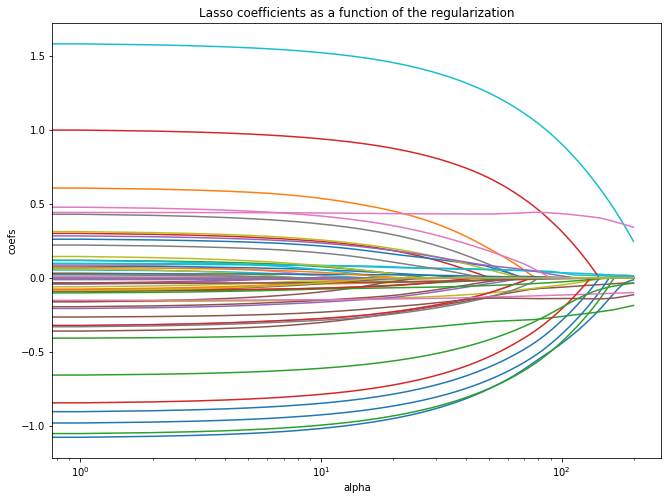

In [35]:
# Just to visualize the Lasso effect, the chart may not be clearly readable, because of too many series onto it
fig = plt.figure(figsize = (24, 8))
ax = fig.add_subplot(1, 2, 2)
ax.plot(LassoCoefs.columns.tolist()[1:], LassoCoefs.iloc[:,1:].values.T)
ax.set_xscale('log')               # log scale is much smoother and it presents better
ax.set_xlabel('alpha')
ax.set_ylabel('coefs')
#ax.set_xlim([10, 200])            # limits of the x label (for preference)
ax.set_title('Lasso coefficients as a function of the regularization')
plt.show()

This fancy chart shows how L1 penalty works, choosen regularization range can exclude vast majority of predictiors in the model, some of them vanished faster, some latr, but with 59 feature a chart isn't a good decission tool, analytical table should be much better (below).

In [36]:
LassoCoefs

feature       1.0  1.2462311557788945  1.492462311557789  \
0    Attr1 -1.085380           -1.078971          -1.072548   
1    Attr2  0.615324            0.608444           0.601504   
2    Attr3 -0.410253           -0.407588          -0.404897   
3    Attr4 -0.039909           -0.034304          -0.028790   
4    Attr5 -0.039910           -0.039047          -0.038214   
5    Attr6 -0.365888           -0.360037          -0.354138   
6    Attr7 -0.328207           -0.322311          -0.316450   
7    Attr8  0.006019            0.004701           0.003452   
8    Attr9 -0.161645           -0.160417          -0.159193   
9   Attr10  0.057716            0.053832           0.049689   
10  Attr11 -0.988291           -0.982184          -0.976076   
11  Attr12  0.000000            0.000000           0.000000   
12  Attr13 -0.093156           -0.090812          -0.088466   
13  Attr14 -0.328232           -0.322336          -0.316477   
14  Attr15  0.001864            0.001707           0.001550   
15  Attr16 -0.200099           -0.194828          -0.189576   
16  Attr17  0.007709            0.006200           0.004713   
17  Attr18 -0.336006           -0.330501          -0.325031   
18  Attr19 -0.065628           -0.060091          -0.054564   
19  Attr20  0.093422            0.092454           0.091500   
20  Attr22 -0.911866           -0.905562          -0.899260   
21  Attr23 -0.086008           -0.080452          -0.074901   
22  Attr24  0.123269            0.118893           0.114471   
23  Attr25  0.307549            0.301350           0.295124   
24  Attr26 -0.212152           -0.206945          -0.201757   
25  Attr28 -0.169089           -0.161726          -0.154368   
26  Attr29 -0.152420           -0.151968          -0.151518   
27  Attr30  0.438280            0.430847           0.423468   
28  Attr31  0.072117            0.062846           0.053579   
29  Attr32  1.591037            1.584412           1.577791   
30  Attr33  0.267242            0.262159           0.257148   
31  Attr34  0.039486            0.033718           0.027986   
32  Attr35 -1.060087           -1.053758          -1.047429   
33  Attr36  1.007346            1.000686           0.994037   
34  Attr38 -0.049531           -0.041787          -0.033992   
35  Attr39 -0.268091           -0.264894          -0.261615   
36  Attr40  0.101195            0.092174           0.083221   
37  Attr41 -0.002553           -0.002377          -0.002202   
38  Attr42  0.319413            0.313040           0.306691   
39  Attr43  0.100608            0.098726           0.096870   
40  Attr44  0.083048            0.080115           0.077208   
41  Attr46 -0.081354           -0.075626          -0.069984   
42  Attr47 -0.104434           -0.101058          -0.097771   
43  Attr48 -0.852288           -0.845864          -0.839441   
44  Attr49  0.289677            0.284222           0.278788   
45  Attr50 -0.096629           -0.090350          -0.084178   
46  Attr51  0.443588            0.443229           0.442869   
47  Attr52  0.023468            0.020547           0.017695   
48  Attr53  0.152059            0.144879           0.137706   
49  Attr54  0.125382            0.118410           0.111439   
50  Attr55  0.028470            0.028087           0.027705   
51  Attr56  0.073778            0.070341           0.066832   
52  Attr57 -0.662864           -0.657767          -0.652676   
53  Attr58 -0.087039           -0.085039          -0.083113   
54  Attr59 -0.012378           -0.012034          -0.011692   
55  Attr61 -0.036226           -0.035823          -0.035422   
56  Attr62  0.485367            0.478664           0.471989   
57  Attr63  0.228550            0.222644           0.216805   
58  Attr64 -0.091034           -0.085061          -0.079093   

    1.7386934673366834  1.984924623115578  2.2311557788944727  \
0            -1.066112          -1.059664           -1.053206   
1             0.594510           0.587465            0.580375   
2            -0.402182     

As said before, bigger alpha regularization term, lower the parameters, but this table is big and hard to read, it is better to make a table with information when particular features vanished (for which alpha).

In [37]:
# adding column with information when coefs vanished (99999 means that coef didn't vanish)

# first regularization term for vanishing list inicialization
min_index = []
# loop through attributes
for i in range(LassoCoefs.shape[0]):
    # extracting atributte characteristics
    attr = LassoCoefs.iloc[i,1:]
    # index where closest to zero value occurs
    attr_min_ind = attr.where(abs(attr) == abs(attr).min()).dropna().index.tolist()
    # string to float conversion
    attr_min_ind_float = [float(i) for i in attr_min_ind]
    # lowest regularization for minimum value (in case of zeros)
    attr_min_ind = min(attr_min_ind_float)
    
    # 6-th decimal precission is enough
    if round(attr[str(attr_min_ind)], 6) == 0:
        # list updating
        min_index.append(attr_min_ind)
    else:
        # list updating
        min_index.append(999999)
    
# updating LassoCoefs dataframe
LassoCoefs["vanish_at"] = min_index

In [38]:
# clean Lasso results
LassoCoefs[["feature", "vanish_at"]].sort_values(by="vanish_at")

feature      vanish_at
11  Attr12       1.000000
34  Attr38       2.723618
31  Attr34       2.723618
7    Attr8       2.723618
16  Attr17       2.723618
47  Attr52       3.216080
3    Attr4       3.216080
28  Attr31       3.216080
14  Attr15       4.201005
36  Attr40       4.447236
37  Attr41       4.693467
9   Attr10       4.939698
58  Attr64       5.678392
49  Attr54       5.678392
41  Attr46       5.924623
45  Attr50       6.170854
51  Attr56       6.663317
25  Attr28       7.402010
48  Attr53       8.140704
22  Attr24       8.386935
18  Attr19      10.110553
54  Attr59      10.356784
40  Attr44      11.095477
53  Attr58      11.834171
57  Attr63      12.819095
21  Attr23      13.065327
23  Attr25      13.804020
12  Attr13      16.020101
15  Attr16      16.512563
24  Attr26      17.497487
27  Attr30      18.236181
38  Attr42      19.221106
6    Attr7      19.467337
13  Attr14      19.467337
1    Attr2      20.698492
17  Attr18      20.944724
50  Attr55      21.190955
56  Attr62      23.407035
55  Attr61      24.391960
44  Attr49      28.824121
30  Attr33      29.809045
43  Attr48      33.748744
20  Attr22      36.457286
33  Attr36      36.457286
4    Attr5      37.688442
42  Attr47      39.165829
10  Attr11      39.904523
32  Attr35      41.874372
8    Attr9      43.105528
52  Attr57  999999.000000
0    Attr1  999999.000000
39  Attr43  999999.000000
35  Attr39  999999.000000
26  Attr29  999999.000000
19  Attr20  999999.000000
5    Attr6  999999.000000
2    Attr3  999999.000000
46  Attr51  999999.000000
29  Attr32  999999.000000

This table is much easier to read, it can be observed that some of features never vanished so may be considered as significant predictiors, to sum up all the metrices, one table is obtained by merging.
##### -  All importance metrics in one dataframe

In [39]:
# GtS result conversion 
sig_dct = {i:"non_significant" if i in nonsig else "significant" for i in RFfeatures}
sig_df = pd.DataFrame(zip(list(sig_dct.keys()), list(sig_dct.values())), columns=["feature", "GtS"])

# Final dataframe
importance_df = pd.merge(
    pd.merge(
        pd.merge(
            RFimportance[["feature", "folds_avg"]], sp_mi, on = "feature"),
        LassoCoefs[["feature", "vanish_at"]], on = "feature"),
    sig_df, on = "feature")

In [40]:
print("Max folds_avg: {}\t\tmin folds_avg: {}\nmax Mutual Information: {}\tmin Mutual Information: {}\nmax Spearman: {}\t\t\
min Spearman: {}".format(round(importance_df["folds_avg"].max(),4), round(importance_df["folds_avg"].min(),4),
                        round(importance_df["Mutual information"].max(),4),
                         round(importance_df["Mutual information"].min(),4),
                        round(importance_df["Spearman"].max(),4), 
                        round(importance_df["Spearman"].min(),4))) 
importance_df

Max folds_avg: 0.1107		min folds_avg: 0.0021
max Mutual Information: 0.0524	min Mutual Information: 0.0
max Spearman: 0.1892		min Spearman: -0.2582


feature  folds_avg  Mutual information  Spearman  p_value (Spearman)  \
0   Attr39   0.110696            0.052424 -0.254034              0.0000   
1   Attr35   0.105906            0.052228 -0.246185              0.0000   
2   Attr46   0.088159            0.034207 -0.218417              0.0000   
3   Attr41   0.069118            0.050847 -0.157024              0.0000   
4   Attr24   0.056876            0.035016 -0.184936              0.0000   
5   Attr22   0.046790            0.049779 -0.218669              0.0000   
6   Attr56   0.040585            0.034291 -0.196624              0.0000   
7   Attr40   0.029420            0.013451 -0.151741              0.0000   
8    Attr5   0.024913            0.019240 -0.178042              0.0000   
9    Attr4   0.020461            0.028119 -0.196016              0.0000   
10  Attr55   0.017883            0.030980 -0.222305              0.0000   
11  Attr58   0.016844            0.034131  0.182982              0.0000   
12  Attr34   0.016105            0.010131 -0.012320              0.3437   
13  Attr47   0.015822            0.000000 -0.051595              0.0001   
14  Attr29   0.015703            0.012941 -0.145293              0.0000   
15   Attr9   0.013188            0.017725 -0.024149              0.0634   
16  Attr20   0.013138            0.000293 -0.005688              0.6620   
17  Attr42   0.013115            0.044162 -0.225037              0.0000   
18  Attr61   0.012178            0.004074  0.055145              0.0000   
19  Attr57   0.012141            0.026247 -0.088061              0.0000   
20  Attr15   0.011827            0.047433 -0.150278              0.0000   
21  Attr43   0.011758            0.005259 -0.013322              0.3058   
22  Attr44   0.011476            0.003612 -0.055543              0.0000   
23  Attr25   0.011258            0.027677 -0.231837              0.0000   
24  Attr13   0.010456            0.048422 -0.250628              0.0000   
25   Attr6   0.010065            0.019684 -0.199754              0.0000   
26  Attr64   0.010017            0.002659  0.005877              0.6515   
27  Attr54   0.009660            0.034546 -0.164078              0.0000   
28  Attr36   0.009393            0.006424  0.019404              0.1358   
29   Attr3   0.009029            0.029481 -0.182753              0.0000   
30  Attr26   0.008665            0.045909 -0.258157              0.0000   
31  Attr59   0.008593            0.011899 -0.063298              0.0000   
32  Attr28   0.007893            0.029764 -0.157871              0.0000   
33   Attr1   0.007758            0.041519 -0.234812              0.0000   
34  Attr63   0.007627            0.026124 -0.175914              0.0000   
35  Attr38   0.007622            0.030481 -0.197231              0.0000   
36  Attr48   0.007486            0.025374 -0.184413              0.0000   
37  Attr49   0.007362            0.036546 -0.186265              0.0000   
38  Attr53   0.007309            0.028954 -0.158999              0.0000   
39  Attr16   0.007020            0.046541 -0.256890              0.0000   
40  Attr50   0.006936            0.023318 -0.176746              0.0000   
41  Attr51   0.006307            0.028083  0.183119              0.0000   
42  Attr12   0.005769            0.040506 -0.243476              0.0000   
43  Attr62   0.005555            0.027854  0.173224              0.0000   
44  Attr30   0.005290            0.013209  0.158643              0.0000   
45  Attr32   0.005044            0.014638  0.138058              0.0000   
46  Attr33   0.005013            0.013386 -0.124632              0.0000   
47  Attr11   0.004875            0.040592 -0.220678              0.0000   
48  Attr23   0.004183            0.043301 -0.240145              0.0000   
49  Attr14   0.003962            0.039599 -0.233602              0.0000   
50   Attr7   0.003886            0.039636 -0.233565              0.0000   
51  Attr18   0.003390            0.039478 -0.233496              0.0000   
52  Attr31   0.003179       

It can be observed that measures aren't always consistent, some poor RF score features have a relatively high Mutual Information, some statistically significant features (General to Specyfic) are not so good in RF impurity score etc. It is important to empirically test different ways of selection and find the best one.

##### Attrs correlation 
Feature vs feature correlation can be another good tool, multicoliearity produces a lot of noise in the data, so with this analysis it is possible to see how many features may be problematic and perform some grouping to do PCA on them. Spearman coef is used because of its properties (no normality assumption, nonlinear dependencies detection)

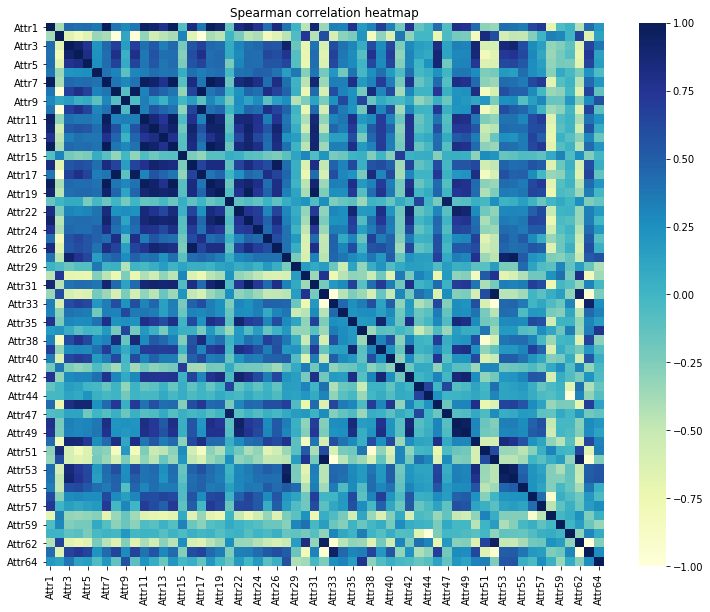

In [41]:
plt.figure(figsize=(12.5,10))

correl = np.round(RFdata[RFfeatures].corr(method = 'spearman'), 2)
sns.heatmap(correl, cmap="YlGnBu", annot=False, cbar=True)
plt.title('Spearman correlation heatmap')
plt.show()

There are a lot of highly correlated features, it is possible to observe some groups, left right corner for example, lets find them.

In [42]:
# Highly correlated pairs, can be consider as groups for PCA
# correlation matrix to dictionary transform
correl_dict = correl.to_dict()
# high correlation dictionary inicialization
high_correl_dict = {}
# high correlation threshold
threshold = 0.8
for attr1 in list(correl_dict.keys()):
    # correlated pairs 
    #     conditions: correlation > threshold, excluding pairs where two of attrs are the same attr, if (attr1, att2) pair
    #     exists then don't mind about (attr2, attr1) pair
    attr1_pairs = [attr2 for attr2 in correl_dict[attr1] if (abs(correl_dict[attr1][attr2]) > threshold) and (attr1 != attr2)
                  and (attr2 not in list(high_correl_dict.keys()))]
    # dictionary update
    high_correl_dict[attr1] = attr1_pairs
    
    # delete attrs without high correlation
    if len(high_correl_dict[attr1]) == 0:
        high_correl_dict.pop(attr1)
    

In [43]:
# Attrs with high correlation with another (no matter which) 
correl_attrs = []
for i in high_correl_dict.values():
    cur_cor = [i[j] for j in range(len(i))]
    correl_attrs.extend(cur_cor)
    
print("There are {} out of {} features with correlation > {}".format(pd.Series(correl_attrs).unique().shape[0],
                                                                     len(RFfeatures), threshold)) 

There are 37 out of 59 features with correlation > 0.8


##### XGB
Extreme Gradient Boosting is one of the kagglers favourite methods, it has extremely good performance and bacause of Tree-based structure, a lot of data analysis/preparation etc. is not needed. Of course implementation is a bit harder than standard Random Forest, but performance should be much better. XGB is consider here as a "maximum performance benchmark" for Neural Networks. In "Ensemble Boosted Trees with Synthetic Features Generation in Application to Bankruptcy Prediction" by Maciej Zięba et. al. XGB was the best algorithm (Authors used the same data) In cited article Neural network has a pretty poor performance, so it is a good challange to make it better!

Note: Feature Importance analysis is not applied in XGB, it is prepared for neural network that tend to be not as robust to bad quality data as XGB. 

In [44]:
# libraries
from random import shuffle
from random import randint
import xgboost as xgb
from operator import itemgetter

In [45]:
def run_xgb(train, validate, features = RFfeatures, target = target,                        # mandatory
            eta=0.03, max_depth=7, subsample = 0.7, colsample_bytree = 0.7,                 # hyperparams
            colsample_bylevel=1,lambdaX = 1, alpha=0, gamma=0, min_child_weight=0,          # hyperparams
            rate_drop = 0.2, skip_drop=0.5,                                                 # hyperparams
            num_boost_round = 1000, early_stopping_rounds = 50,                             # hyperparams
            debug=True, eval_metric= ["auc", "aucpr"], objective = "binary:logistic",       # config
            seed=2020, booster = "gbtree", tree_method="exact", grow_policy="depthwise"):   # config
    '''
    XGB wrapper, parameters:
    *** wrapper params ***
    train - training set (dataframe with colmanes contained in features and target),
    validate - validation set (dataframe with colmanes contained in features and target),
    features - list of independent variables names,
    target - dependent variable name,
    
    *** bgtree/dart boosters params ***
    --- Ensembling/Boosting ---
    eta - learning rate,
    max_depth - maximum trees depth                                                       [0,inf]
    subsample - observations fraction used in the single training iteration               (0,1]
    colsample_bytree - columns fraction used for the single training iteration            (0,1]
    colsample_bylevel - columns fraction used for the level in single training iteration  (0,1]
    --- Regularization ---
    lambdaX - L2 ("Ridge")                                                                [0,inf]
    alpha - L1 ("Lasso")                                                                  [0,inf]
    gamma - minimal loss function reduction
    min_child_weight - minimal sum by subtree
    
    *** dart booster params ***
    rate_drop - dropout rate                                                              [0,1]
    skip_dro - probability of skipping dropout                                            [0,1]
    
    *** XGB training params ***
    num_boost_round - max number of iterations
    early_stopping_rounds - early stopping (how many iterations without increasing performance in a row allowed)
    debug - boolean, full description of learning process
    eval_metric - evaluation metrics (here auc (ROC) and aucpr (PR))
    objective - cost function (in current problem - binary:logistic, common log-loss function)
    seed - random seed
    booster - boosting "engine"/algorithm (gbtree or dart (gbtree with dropout) is okay for current purposes)
    tree_method - tree construction algorithm (exact is okay for current purposes)
    grow_policy - currently supported for hist tree_method
    
    return aucpr (test set), aucroc (test set), trainPred (array), testPred (array), train_history (dataframe)
    ----------
    Note: full parameter list may be found here: https://xgboost.readthedocs.io/en/latest/parameter.html#
    '''
    
    start_time = time.time()
    paramList= ['eta', 'max_depth',
         'subsample', 'colsample_bytree', 'colsample_bylevel',
         'lambdaX', 'alpha', 'gamma', 'min_child_weight',
         'num_boost_round', 'early_stopping_rounds',
         'rate_drop', 'skip_drop', 'eval_metric', 'objective', 
          'seed', 'booster', 'tree_method', 'grow_policy']
    
    # dictionary for XGB
    params = dict()
    for param in paramList:
        # write global value for current key
        params[param]=eval(param)
        
    # parameters info
    if debug :
        for param in paramList:
            print(param, eval(param), end=", ")
        print('\nLength train:', len(train.index))
        print('Length valid:', len(validate.index))
    
    # printing info type (0 - silent)
    params["verbosity"] = 0 # paramList is the same, but not all params are supported for choosen booster (xgb skips them)
    
    # lambda is a python key word, workaround below
    params["lambda"] = lambdaX
    
    # DMmatrix data transform necessary for xgb
    dtrain = xgb.DMatrix(train[features].values, train[target].values, feature_names=train[features].columns.values)
    dvalid = xgb.DMatrix(
        validate[features].values, validate[target].values, feature_names=validate[features].columns.values)

    # list of evaluation sets
    evals = [(dtrain, 'train'), (dvalid, 'valid')]
    
    # history dictionary inicialization
    train_history = dict()

    # training
    gbm = xgb.train(params, dtrain, 
                    num_boost_round, early_stopping_rounds=early_stopping_rounds,
                    evals=evals, evals_result=train_history, verbose_eval=debug)
    
    
    # history dataframe transform
    trainHistory = dict()
    for key in train_history.keys():
        for metric in train_history[key].keys():
            trainHistory[key+metric.upper()]=train_history[key][metric]
    train_history = pd.DataFrame(trainHistory)
    
    # best model score
    aucpr = gbm.best_score
    aucroc = train_history.validAUC.where(train_history.validAUCPR == aucpr).dropna().tolist()[0]
    
    # best model prediction saving (per iteration)
    trainPred = gbm.predict(dtrain, ntree_limit=gbm.best_iteration)
    testPred = gbm.predict(dvalid, ntree_limit=gbm.best_iteration)


    if debug:
        print('Training time: {} mins'.format(round((time.time() - start_time)/60, 2)))
        
        # printing best iteration (best model)
        print('Best iteration: \n{}'.format(train_history.where(
            train_history.validAUCPR==aucpr).dropna()))

        
    return aucpr, aucroc, trainPred, testPred, train_history

In [46]:
# only one split to get familiar with settings before CV
test_size = 0.2
X_train, X_valid = train_test_split(RFdata, test_size=test_size, random_state=2020, stratify=RFdata[target].values)

In [47]:
# first run on one split
aucpr, aucroc, trainPred, testPred, train_history = run_xgb(
    X_train, X_valid, RFfeatures, target, early_stopping_rounds=50, debug = True)

eta 0.03, max_depth 7, subsample 0.7, colsample_bytree 0.7, colsample_bylevel 1, lambdaX 1, alpha 0, gamma 0, min_child_weight 0, num_boost_round 1000, early_stopping_rounds 50, rate_drop 0.2, skip_drop 0.5, eval_metric ['auc', 'aucpr'], objective binary:logistic, seed 2020, booster gbtree, tree_method exact, grow_policy depthwise, 
Length train: 4728
Length valid: 1182
[0]	train-auc:0.85811	train-aucpr:0.56362	valid-auc:0.79192	valid-aucpr:0.29846
[1]	train-auc:0.86595	train-aucpr:0.65924	valid-auc:0.79295	valid-aucpr:0.32319
[2]	train-auc:0.88117	train-aucpr:0.70865	valid-auc:0.80490	valid-aucpr:0.31795
[3]	train-auc:0.89589	train-aucpr:0.72327	valid-auc:0.82327	valid-aucpr:0.32608
[4]	train-auc:0.90306	train-aucpr:0.74005	valid-auc:0.83143	valid-aucpr:0.36747
[5]	train-auc:0.90468	train-aucpr:0.74110	valid-auc:0.83173	valid-aucpr:0.37803
[6]	train-auc:0.90741	train-aucpr:0.74833	valid-auc:0.83104	valid-aucpr:0.39493
[7]	train-auc:0.91252	train-aucpr:0.75582	valid-auc:0.82751	valid-a

[97]	train-auc:0.99358	train-aucpr:0.95749	valid-auc:0.87707	valid-aucpr:0.49290
[98]	train-auc:0.99370	train-aucpr:0.95863	valid-auc:0.87608	valid-aucpr:0.49222
[99]	train-auc:0.99384	train-aucpr:0.95971	valid-auc:0.87606	valid-aucpr:0.49214
[100]	train-auc:0.99396	train-aucpr:0.96091	valid-auc:0.87594	valid-aucpr:0.49136
[101]	train-auc:0.99415	train-aucpr:0.96225	valid-auc:0.87540	valid-aucpr:0.49105
[102]	train-auc:0.99431	train-aucpr:0.96369	valid-auc:0.87466	valid-aucpr:0.49147
[103]	train-auc:0.99447	train-aucpr:0.96470	valid-auc:0.87449	valid-aucpr:0.49174
[104]	train-auc:0.99473	train-aucpr:0.96584	valid-auc:0.87467	valid-aucpr:0.49285
[105]	train-auc:0.99489	train-aucpr:0.96696	valid-auc:0.87482	valid-aucpr:0.49217
[106]	train-auc:0.99516	train-aucpr:0.96857	valid-auc:0.87465	valid-aucpr:0.49304
[107]	train-auc:0.99540	train-aucpr:0.96949	valid-auc:0.87657	valid-aucpr:0.49423
[108]	train-auc:0.99555	train-aucpr:0.96993	valid-auc:0.87901	valid-aucpr:0.49339
[109]	train-auc:0.9

[197]	train-auc:0.99996	train-aucpr:0.99950	valid-auc:0.88876	valid-aucpr:0.49237
[198]	train-auc:0.99997	train-aucpr:0.99956	valid-auc:0.88886	valid-aucpr:0.49133
[199]	train-auc:0.99997	train-aucpr:0.99960	valid-auc:0.88926	valid-aucpr:0.49274
[200]	train-auc:0.99997	train-aucpr:0.99962	valid-auc:0.88922	valid-aucpr:0.49212
[201]	train-auc:0.99997	train-aucpr:0.99962	valid-auc:0.88945	valid-aucpr:0.49321
[202]	train-auc:0.99998	train-aucpr:0.99968	valid-auc:0.88904	valid-aucpr:0.49306
[203]	train-auc:0.99998	train-aucpr:0.99969	valid-auc:0.88860	valid-aucpr:0.49192
[204]	train-auc:0.99998	train-aucpr:0.99969	valid-auc:0.88841	valid-aucpr:0.49181
Training time: 0.06 mins
Best iteration: 
     trainAUC  trainAUCPR  validAUC  validAUCPR
155  0.999489    0.994928  0.890654    0.502506


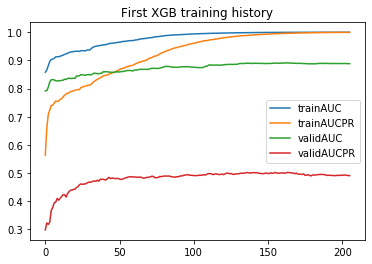

In [48]:
# first history plot
train_history.plot()
plt.title("First XGB training history")
plt.show()

##### XGB hyperparameters tuning (ranges for Random Search)
 - Max depth:

max depth: 3, PR: 0.501226, ROC: 0.868758
max depth: 4, PR: 0.519504, ROC: 0.889579
max depth: 5, PR: 0.500739, ROC: 0.889745
max depth: 6, PR: 0.503474, ROC: 0.88765
max depth: 7, PR: 0.502506, ROC: 0.890654
max depth: 8, PR: 0.493346, ROC: 0.889834
max depth: 9, PR: 0.481996, ROC: 0.886885
max depth: 10, PR: 0.47572, ROC: 0.887816
max depth: 11, PR: 0.471652, ROC: 0.887639
max depth: 12, PR: 0.479626, ROC: 0.887073
max depth: 13, PR: 0.481527, ROC: 0.887384
max depth: 14, PR: 0.482612, ROC: 0.886208


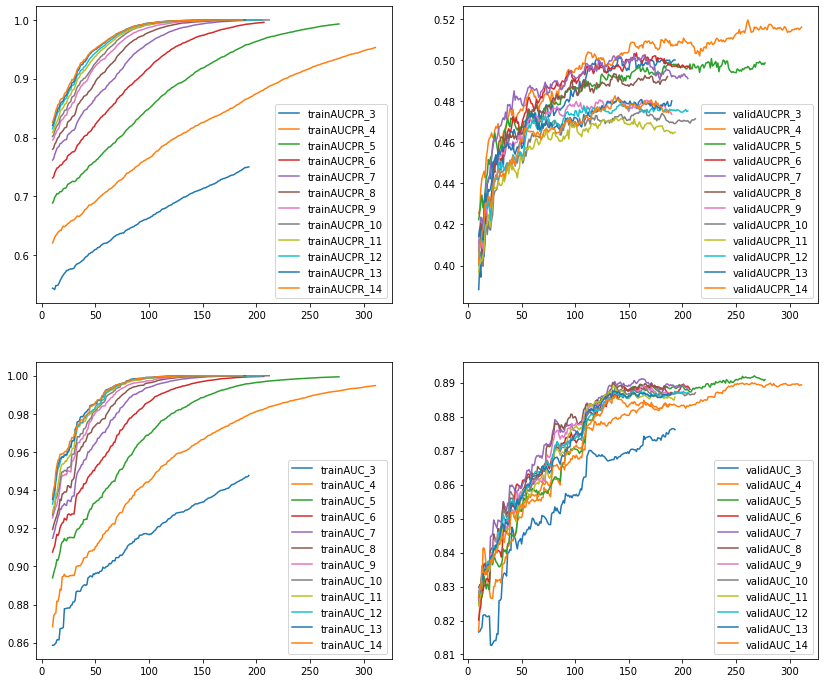

In [49]:
# results dictionary inicialization
resHists = dict()
# testing:
for depth in range(3,15,1):
    aucpr, aucroc, trainPred, testPred, train_history = run_xgb(X_train, X_valid, RFfeatures, target,
                                                                max_depth = depth, early_stopping_rounds = 50,
                                                                debug = False)
    # history saving
    resHists[depth]=train_history
    print("max depth: {}, PR: {}, ROC: {}".format(depth, aucpr, aucroc))
fig, ax = plt.subplots(2, 2, figsize=(14, 12))

# plots after 10-th iteration
for depth in range(3,15,1):
    resHists[depth][['trainAUCPR']].add_suffix('_'+str(depth)).iloc[10:].plot(ax=ax[0, 0])
    resHists[depth][['validAUCPR']].add_suffix('_'+str(depth)).iloc[10:].plot(ax=ax[0, 1])
    resHists[depth][['trainAUC']].add_suffix('_'+str(depth)).iloc[10:].plot(ax=ax[1, 0])
    resHists[depth][['validAUC']].add_suffix('_'+str(depth)).iloc[10:].plot(ax=ax[1, 1])
plt.show()

3-8 makes sense
 - $\eta$:

eta: 0.001, PR: 0.445748, ROC: 0.8251
eta: 0.003, PR: 0.485884, ROC: 0.845261
eta: 0.01, PR: 0.513669, ROC: 0.874302
eta: 0.03, PR: 0.519504, ROC: 0.889579
eta: 0.1, PR: 0.519274, ROC: 0.883703
eta: 0.3, PR: 0.447438, ROC: 0.864889


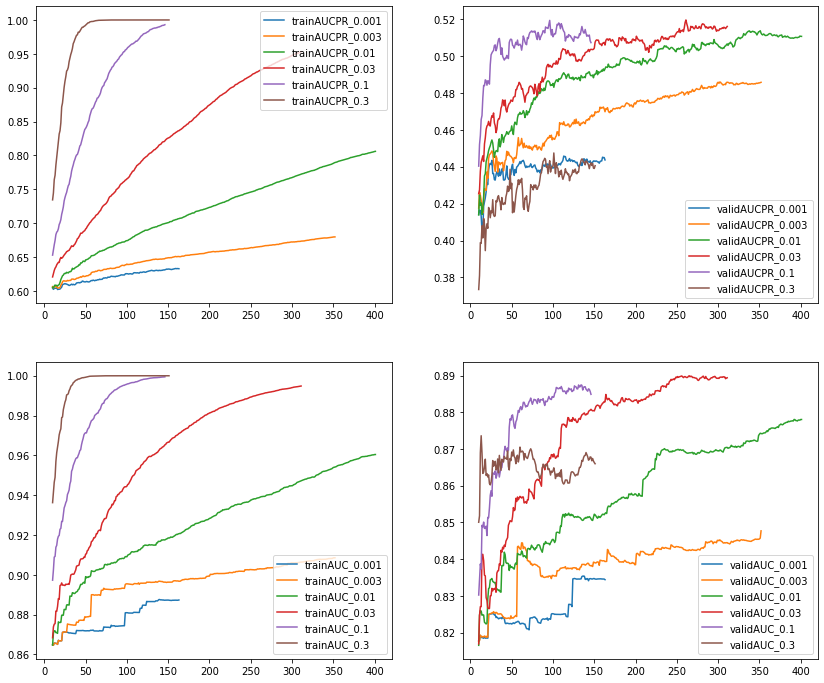

In [50]:
# results dictionary inicialization
resHists = dict()
etas = [0.001, 0.003, 0.01, 0.03, 0.1, 0.3]
# testing:
for eta in etas:
    aucpr, aucroc, trainPred, testPred, train_history = run_xgb(X_train, X_valid, RFfeatures, target,
                                                                early_stopping_rounds = 50, debug = False,
                                                               max_depth = 4, eta = eta)
    # history saving
    resHists[eta]=train_history
    print("eta: {}, PR: {}, ROC: {}".format(eta, aucpr, aucroc))
fig, ax = plt.subplots(2, 2, figsize=(14, 12))

# plots after 10-th iteration
for eta in etas:
    resHists[eta][['trainAUCPR']].add_suffix('_'+str(eta)).iloc[10:].plot(ax=ax[0, 0])
    resHists[eta][['validAUCPR']].add_suffix('_'+str(eta)).iloc[10:].plot(ax=ax[0, 1])
    resHists[eta][['trainAUC']].add_suffix('_'+str(eta)).iloc[10:].plot(ax=ax[1, 0])
    resHists[eta][['validAUC']].add_suffix('_'+str(eta)).iloc[10:].plot(ax=ax[1, 1])
plt.show()

$\eta$ somewhere between 0.01 and 0.1<br>
 - subsample:

subsample: 0.1, PR: 0.476515, ROC: 0.868126
subsample: 0.2, PR: 0.508308, ROC: 0.880432
subsample: 0.3, PR: 0.511392, ROC: 0.863115
subsample: 0.4, PR: 0.523143, ROC: 0.880111
subsample: 0.5, PR: 0.507222, ROC: 0.869479
subsample: 0.6, PR: 0.498471, ROC: 0.872472
subsample: 0.7, PR: 0.519504, ROC: 0.889579
subsample: 0.8, PR: 0.497165, ROC: 0.862971
subsample: 0.9, PR: 0.520449, ROC: 0.892306
subsample: 1.0, PR: 0.508615, ROC: 0.86337


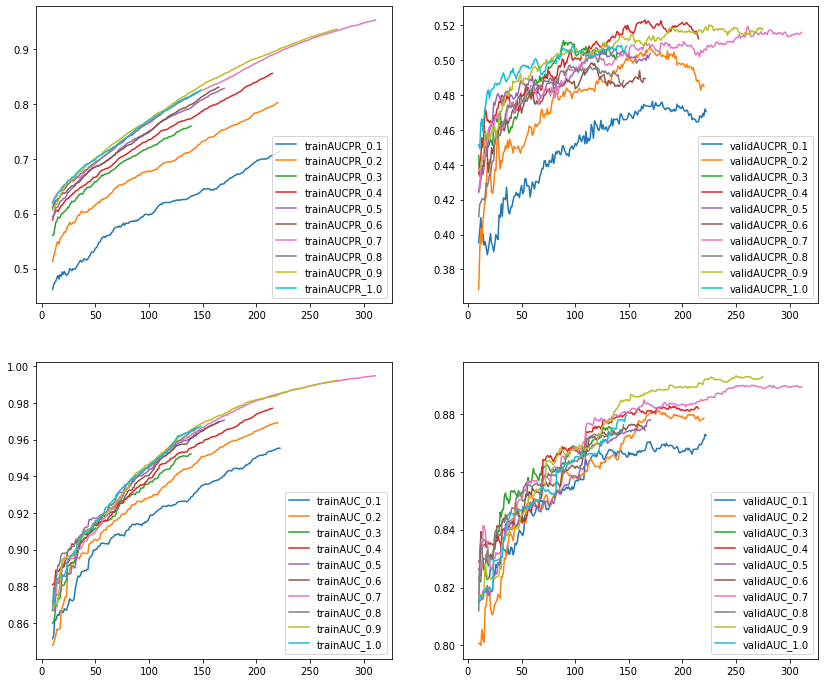

In [51]:
# results dictionary inicialization
resHists = dict()
subsamples = np.arange(1,11)/10 
# testing:
for subsample in subsamples:
    aucpr, aucroc, trainPred, testPred, train_history = run_xgb(X_train, X_valid, RFfeatures, target,
                                                                early_stopping_rounds = 50, debug = False,
                                                               max_depth = 4, eta = 0.03, subsample = subsample)
    # history saving
    resHists[subsample]=train_history
    print("subsample: {}, PR: {}, ROC: {}".format(subsample, aucpr, aucroc))
fig, ax = plt.subplots(2, 2, figsize=(14, 12))

# plots after 10-th iteration
for subsample in subsamples:
    resHists[subsample][['trainAUCPR']].add_suffix('_'+str(subsample)).iloc[10:].plot(ax=ax[0, 0])
    resHists[subsample][['validAUCPR']].add_suffix('_'+str(subsample)).iloc[10:].plot(ax=ax[0, 1])
    resHists[subsample][['trainAUC']].add_suffix('_'+str(subsample)).iloc[10:].plot(ax=ax[1, 0])
    resHists[subsample][['validAUC']].add_suffix('_'+str(subsample)).iloc[10:].plot(ax=ax[1, 1])
plt.show()

0.4-0.9 best
 - columns by tree:

columns by tree: 0.1, PR: 0.441312, ROC: 0.861874
columns by tree: 0.2, PR: 0.460354, ROC: 0.86082
columns by tree: 0.3, PR: 0.46543, ROC: 0.868282
columns by tree: 0.4, PR: 0.486031, ROC: 0.881663
columns by tree: 0.5, PR: 0.520306, ROC: 0.878481
columns by tree: 0.6, PR: 0.529525, ROC: 0.887361
columns by tree: 0.7, PR: 0.523143, ROC: 0.880111
columns by tree: 0.8, PR: 0.513083, ROC: 0.878514
columns by tree: 0.9, PR: 0.522449, ROC: 0.883825
columns by tree: 1.0, PR: 0.513973, ROC: 0.878326


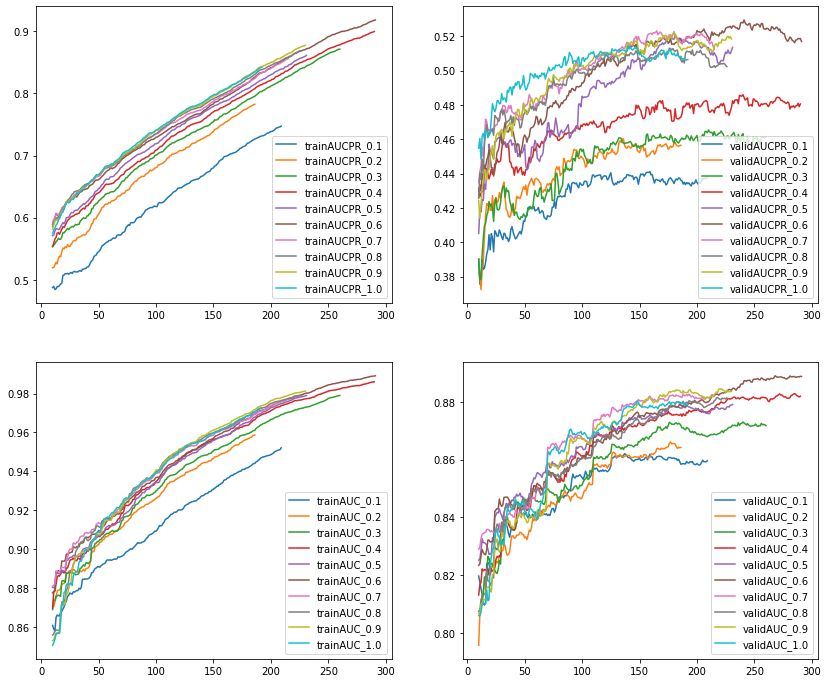

In [52]:
# results dictionary inicialization
resHists = dict()
cols = np.arange(1,11)/10 
# testing:
for col in cols:
    aucpr, aucroc, trainPred, testPred, train_history = run_xgb(X_train, X_valid, RFfeatures, target,
                                                                early_stopping_rounds = 50, debug = False,
                                                               max_depth = 4, eta = 0.03, subsample = 0.4,
                                                               colsample_bytree = col)
    # history saving
    resHists[col]=train_history
    print("columns by tree: {}, PR: {}, ROC: {}".format(col, aucpr, aucroc))
fig, ax = plt.subplots(2, 2, figsize=(14, 12))

# plots after 10-th iteration
for col in cols:
    resHists[col][['trainAUCPR']].add_suffix('_'+str(col)).iloc[10:].plot(ax=ax[0, 0])
    resHists[col][['validAUCPR']].add_suffix('_'+str(col)).iloc[10:].plot(ax=ax[0, 1])
    resHists[col][['trainAUC']].add_suffix('_'+str(col)).iloc[10:].plot(ax=ax[1, 0])
    resHists[col][['validAUC']].add_suffix('_'+str(col)).iloc[10:].plot(ax=ax[1, 1])
plt.show()

0.5-0.9 best
 - colsample by level:

columns by level: 0.1, PR: 0.461086, ROC: 0.872029
columns by level: 0.2, PR: 0.490287, ROC: 0.875055
columns by level: 0.3, PR: 0.490146, ROC: 0.875898
columns by level: 0.4, PR: 0.496673, ROC: 0.879335
columns by level: 0.5, PR: 0.491115, ROC: 0.875044
columns by level: 0.6, PR: 0.517506, ROC: 0.882328
columns by level: 0.7, PR: 0.522619, ROC: 0.881341
columns by level: 0.8, PR: 0.502876, ROC: 0.874601
columns by level: 0.9, PR: 0.511539, ROC: 0.877262
columns by level: 1.0, PR: 0.529525, ROC: 0.887361


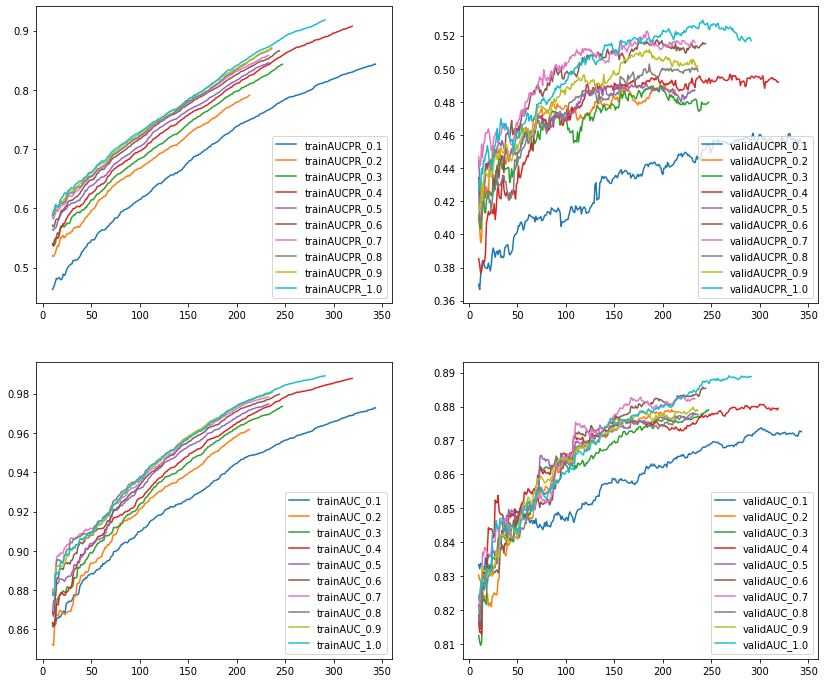

In [53]:
# results dictionary inicialization
resHists = dict()
cols = np.arange(1,11)/10 
# testing:
for col in cols:
    aucpr, aucroc, trainPred, testPred, train_history = run_xgb(X_train, X_valid, RFfeatures, target,
                                                                early_stopping_rounds = 50, debug = False,
                                                               max_depth = 4, eta = 0.03, subsample = 0.4,
                                                               colsample_bytree = 0.6, colsample_bylevel = col)
    # history saving
    resHists[col]=train_history
    print("columns by level: {}, PR: {}, ROC: {}".format(col, aucpr, aucroc))
fig, ax = plt.subplots(2, 2, figsize=(14, 12))

# plots after 10-th iteration
for col in cols:
    resHists[col][['trainAUCPR']].add_suffix('_'+str(col)).iloc[10:].plot(ax=ax[0, 0])
    resHists[col][['validAUCPR']].add_suffix('_'+str(col)).iloc[10:].plot(ax=ax[0, 1])
    resHists[col][['trainAUC']].add_suffix('_'+str(col)).iloc[10:].plot(ax=ax[1, 0])
    resHists[col][['validAUC']].add_suffix('_'+str(col)).iloc[10:].plot(ax=ax[1, 1])
plt.show()

0.6-1 best
 - L2 regularization:

L2: 0.001, PR: 0.511713, ROC: 0.875067
L2: 0.003, PR: 0.519321, ROC: 0.890798
L2: 0.01, PR: 0.520616, ROC: 0.875432
L2: 0.03, PR: 0.500915, ROC: 0.873237
L2: 0.1, PR: 0.527061, ROC: 0.884545
L2: 0.3, PR: 0.517818, ROC: 0.885843
L2: 1, PR: 0.529525, ROC: 0.887361
L2: 3, PR: 0.521456, ROC: 0.883969
L2: 6, PR: 0.524217, ROC: 0.877251
L2: 9, PR: 0.517221, ROC: 0.868448


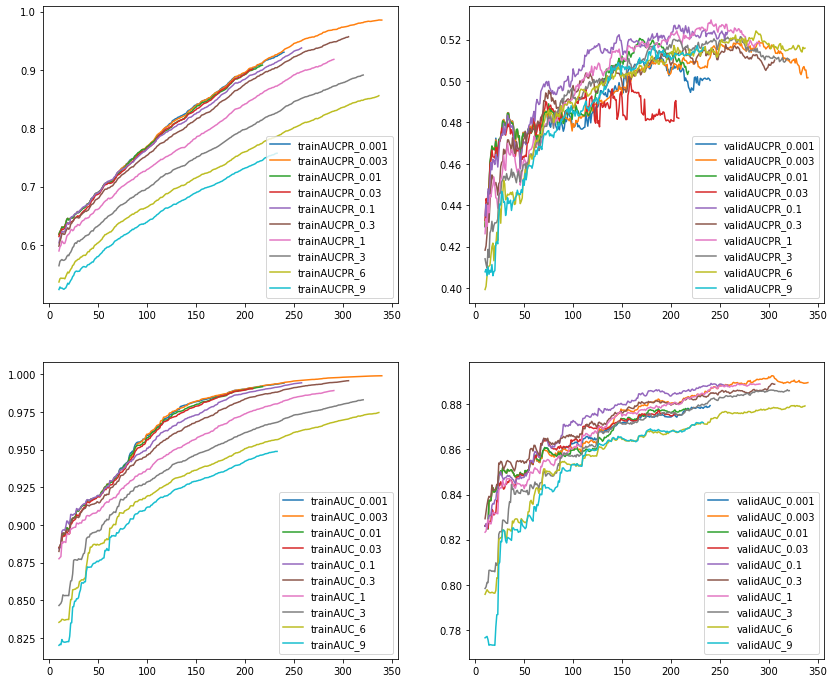

In [54]:
# results dictionary inicialization
resHists = dict()
lmbdas = [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 6, 9] 
# testing:
for l in lmbdas:
    aucpr, aucroc, trainPred, testPred, train_history = run_xgb(X_train, X_valid, RFfeatures, target,
                                                                early_stopping_rounds = 50, debug = False,
                                                               max_depth = 4, eta = 0.03, subsample = 0.4,
                                                               colsample_bytree = 0.6, colsample_bylevel = 1,
                                                               lambdaX = l)
    # history saving
    resHists[l]=train_history
    print("L2: {}, PR: {}, ROC: {}".format(l, aucpr, aucroc))
fig, ax = plt.subplots(2, 2, figsize=(14, 12))

# plots after 10-th iteration
for l in lmbdas:
    resHists[l][['trainAUCPR']].add_suffix('_'+str(l)).iloc[10:].plot(ax=ax[0, 0])
    resHists[l][['validAUCPR']].add_suffix('_'+str(l)).iloc[10:].plot(ax=ax[0, 1])
    resHists[l][['trainAUC']].add_suffix('_'+str(l)).iloc[10:].plot(ax=ax[1, 0])
    resHists[l][['validAUC']].add_suffix('_'+str(l)).iloc[10:].plot(ax=ax[1, 1])
plt.show()

 - L1 regularization:

L1: 0.001, PR: 0.527236, ROC: 0.882838
L1: 0.003, PR: 0.515742, ROC: 0.875366
L1: 0.01, PR: 0.512142, ROC: 0.877838
L1: 0.03, PR: 0.520404, ROC: 0.884878
L1: 0.1, PR: 0.52201, ROC: 0.887084
L1: 0.3, PR: 0.520752, ROC: 0.877716
L1: 1, PR: 0.525447, ROC: 0.876973
L1: 3, PR: 0.519973, ROC: 0.871863
L1: 6, PR: 0.53287, ROC: 0.873271
L1: 9, PR: 0.514893, ROC: 0.870177


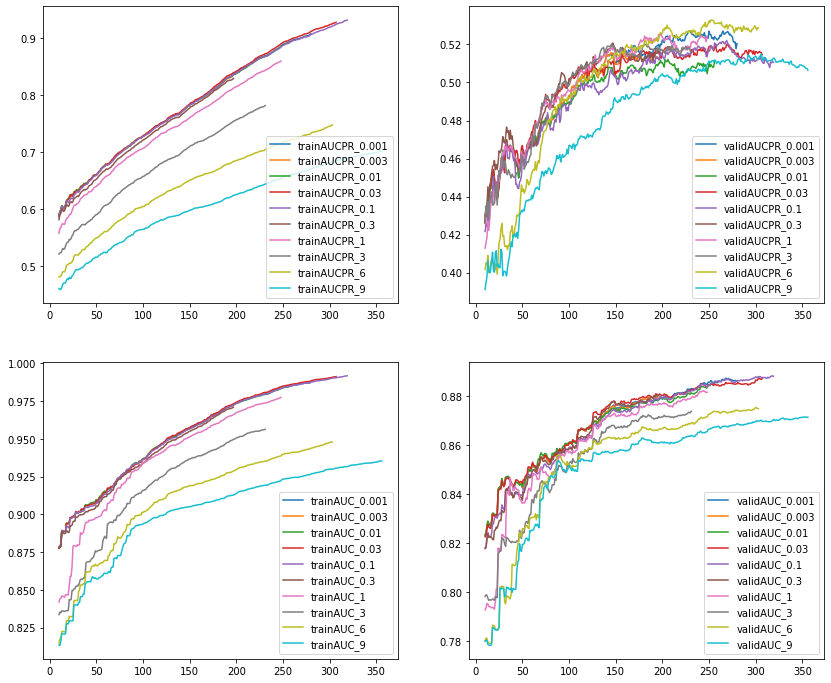

In [55]:
# results dictionary inicialization
resHists = dict()
alphas = [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 6, 9] 
# testing:
for a in alphas:
    aucpr, aucroc, trainPred, testPred, train_history = run_xgb(X_train, X_valid, RFfeatures, target,
                                                                early_stopping_rounds = 50, debug = False,
                                                               max_depth = 4, eta = 0.03, subsample = 0.4,
                                                               colsample_bytree = 0.6, colsample_bylevel = 1,
                                                               alpha= a)
    # history saving
    resHists[a]=train_history
    print("L1: {}, PR: {}, ROC: {}".format(a, aucpr, aucroc))
fig, ax = plt.subplots(2, 2, figsize=(14, 12))

# plots after 10-th iteration
for a in alphas:
    resHists[a][['trainAUCPR']].add_suffix('_'+str(a)).iloc[10:].plot(ax=ax[0, 0])
    resHists[a][['validAUCPR']].add_suffix('_'+str(a)).iloc[10:].plot(ax=ax[0, 1])
    resHists[a][['trainAUC']].add_suffix('_'+str(a)).iloc[10:].plot(ax=ax[1, 0])
    resHists[a][['validAUC']].add_suffix('_'+str(a)).iloc[10:].plot(ax=ax[1, 1])
plt.show()

L2 < 1 better than L1<br>
 - $\gamma$:

gamma: 0.001, PR: 0.529525, ROC: 0.887361
gamma: 0.003, PR: 0.529525, ROC: 0.887361
gamma: 0.01, PR: 0.529525, ROC: 0.887361
gamma: 0.03, PR: 0.529534, ROC: 0.887428
gamma: 0.1, PR: 0.517275, ROC: 0.886851
gamma: 0.3, PR: 0.517574, ROC: 0.886474
gamma: 1, PR: 0.508997, ROC: 0.873581
gamma: 2, PR: 0.521545, ROC: 0.885576
gamma: 4, PR: 0.532397, ROC: 0.885654
gamma: 6, PR: 0.544402, ROC: 0.876619


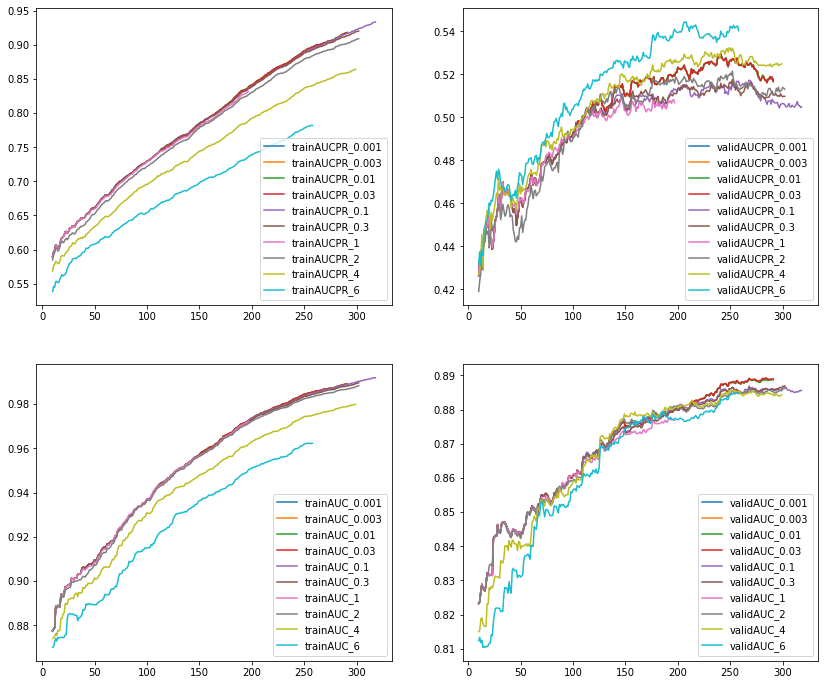

In [56]:
# results dictionary inicialization
resHists = dict()
gammas = [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 2, 4, 6] 
# testing:
for gamma in gammas:
    aucpr, aucroc, trainPred, testPred, train_history = run_xgb(X_train, X_valid, RFfeatures, target,
                                                                early_stopping_rounds = 50, debug = False,
                                                               max_depth = 4, eta = 0.03, subsample = 0.4,
                                                               colsample_bytree = 0.6, colsample_bylevel = 1,
                                                               lambdaX = 1, gamma = gamma)
    # history saving
    resHists[gamma]=train_history
    print("gamma: {}, PR: {}, ROC: {}".format(gamma, aucpr, aucroc))
fig, ax = plt.subplots(2, 2, figsize=(14, 12))

# plots after 10-th iteration
for gamma in gammas:
    resHists[gamma][['trainAUCPR']].add_suffix('_'+str(gamma)).iloc[10:].plot(ax=ax[0, 0])
    resHists[gamma][['validAUCPR']].add_suffix('_'+str(gamma)).iloc[10:].plot(ax=ax[0, 1])
    resHists[gamma][['trainAUC']].add_suffix('_'+str(gamma)).iloc[10:].plot(ax=ax[1, 0])
    resHists[gamma][['validAUC']].add_suffix('_'+str(gamma)).iloc[10:].plot(ax=ax[1, 1])
plt.show()

Without $\gamma$ there is a strong overfitting, its nice to check 1-20 range

gamma: 2, PR: 0.521545, ROC: 0.885576
gamma: 4, PR: 0.532397, ROC: 0.885654
gamma: 6, PR: 0.544402, ROC: 0.876619
gamma: 8, PR: 0.539558, ROC: 0.88071
gamma: 10, PR: 0.520883, ROC: 0.867727
gamma: 12, PR: 0.503074, ROC: 0.86378
gamma: 14, PR: 0.478861, ROC: 0.851231
gamma: 16, PR: 0.455379, ROC: 0.847428
gamma: 18, PR: 0.432149, ROC: 0.844424
gamma: 20, PR: 0.432317, ROC: 0.841242


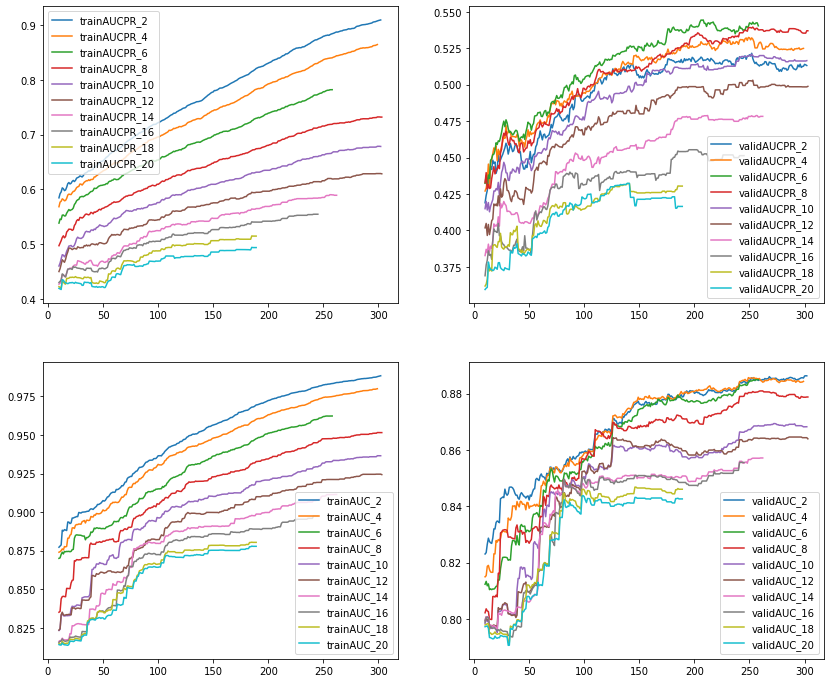

In [57]:
# results dictionary inicialization
resHists = dict()
gammas = np.arange(2,22,2)
# testing:
for gamma in gammas:
    aucpr, aucroc, trainPred, testPred, train_history = run_xgb(X_train, X_valid, RFfeatures, target,
                                                                early_stopping_rounds = 50, debug = False,
                                                               max_depth = 4, eta = 0.03, subsample = 0.4,
                                                               colsample_bytree = 0.6, colsample_bylevel = 1,
                                                               lambdaX = 1, gamma = gamma)
    # history saving
    resHists[gamma]=train_history
    print("gamma: {}, PR: {}, ROC: {}".format(gamma, aucpr, aucroc))
fig, ax = plt.subplots(2, 2, figsize=(14, 12))

# plots after 10-th iteration
for gamma in gammas:
    resHists[gamma][['trainAUCPR']].add_suffix('_'+str(gamma)).iloc[10:].plot(ax=ax[0, 0])
    resHists[gamma][['validAUCPR']].add_suffix('_'+str(gamma)).iloc[10:].plot(ax=ax[0, 1])
    resHists[gamma][['trainAUC']].add_suffix('_'+str(gamma)).iloc[10:].plot(ax=ax[1, 0])
    resHists[gamma][['validAUC']].add_suffix('_'+str(gamma)).iloc[10:].plot(ax=ax[1, 1])
plt.show()


looks like $\gamma$ with small regularization should stay at 4-8 level
 - Dropout (booster: dart):

dropout rate: 0.1, PR: 0.47261, ROC: 0.849085
dropout rate: 0.2, PR: 0.464728, ROC: 0.835637
dropout rate: 0.3, PR: 0.443853, ROC: 0.824169
dropout rate: 0.4, PR: 0.439768, ROC: 0.825915
dropout rate: 0.5, PR: 0.443593, ROC: 0.831851
dropout rate: 0.6, PR: 0.442136, ROC: 0.82888
dropout rate: 0.7, PR: 0.43982, ROC: 0.822372
dropout rate: 0.8, PR: 0.445836, ROC: 0.825
dropout rate: 0.9, PR: 0.427487, ROC: 0.824346
dropout rate: 1.0, PR: 0.423089, ROC: 0.82352


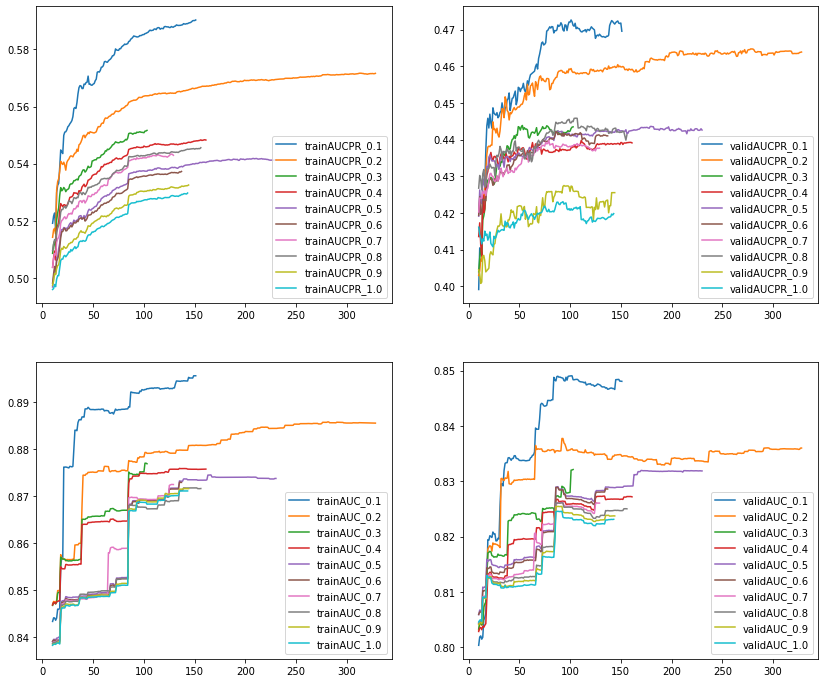

In [58]:
# results dictionary inicialization
resHists = dict()
dropouts = np.arange(1,11,1)/10
# testing:
for drop in dropouts:
    aucpr, aucroc, trainPred, testPred, train_history = run_xgb(X_train, X_valid, RFfeatures, target,
                                                                early_stopping_rounds = 50, debug = False,
                                                               max_depth = 4, eta = 0.03, subsample = 0.4,
                                                               colsample_bytree = 0.6, colsample_bylevel = 1,
                                                               lambdaX = 1, gamma = 6, booster="dart",
                                                                rate_drop = drop, skip_drop = 0)
    # history saving
    resHists[drop]=train_history
    print("dropout rate: {}, PR: {}, ROC: {}".format(drop, aucpr, aucroc))
fig, ax = plt.subplots(2, 2, figsize=(14, 12))

# plots after 10-th iteration
for drop in dropouts:
    resHists[drop][['trainAUCPR']].add_suffix('_'+str(drop)).iloc[10:].plot(ax=ax[0, 0])
    resHists[drop][['validAUCPR']].add_suffix('_'+str(drop)).iloc[10:].plot(ax=ax[0, 1])
    resHists[drop][['trainAUC']].add_suffix('_'+str(drop)).iloc[10:].plot(ax=ax[1, 0])
    resHists[drop][['validAUC']].add_suffix('_'+str(drop)).iloc[10:].plot(ax=ax[1, 1])
plt.show()


dropout works very poor, its better to stay without it, and eventually try to add some dropout to the random search results model.<br>
To sum up:
 - max_depth: 3-8,
 - $\eta$: 0.01-0.1,
 - subsample: 0.4-0.9,
 - colsample by tree: 0.5-0.9,
 - colsample by level: 0.6-1,
 - L2 regularization: 0.1-1,
 - $\gamma$: 4-8

##### Cross Validation XGB

In [59]:
def CVTestXGB(df = RFdata, features=RFfeatures, target=target, nFolds = 5, randomState=2020, debug=False, *args, **kwargs):
    '''
    XGB Startified n-Fold Cross Validation wrapper, function builds models, computes statistics, predictions and 
    corresponding indices for each fold, arguments:
    df - DataFrame to perform analysis on it,
    features - independent variables,
    target - dependent variable,
    nFolds - number of folds in Cross Validation,
    randomState - seed for algorithms,
    debug - boolean, additional info
    
    return AUC-ROC train score, AUC-ROC test score, AUC-PR train score, AUC-PR test score, predictions, indices, history
    '''
    
    # Stratified CV
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2020)

    # results lists inicialization
    ROCtestResults = []
    ROCtrainResults = []
    PRtestResults = []
    PRtrainResults = []
    predictions = []
    indices = []
    hists = []

    fold = 1
    for train, test in kf.split(df.index.values, df.bankrupt):
        
        # training
        aucpr, aucroc, trainPred, testPred, train_history = run_xgb(df.iloc[train,:], df.iloc[test,:], RFfeatures, target,
                                                                 debug = debug, *args, **kwargs)


        # predictions and indices saving (for each fold)
        predictions.append(testPred.tolist().copy())
        indices.append(df.iloc[test].index.tolist().copy())

        # fold metrics 
        ROCtrainScore = roc_auc_score(df[target].iloc[train], trainPred)
        ROCtestScore = roc_auc_score(df[target].iloc[test], testPred)
        PRtrainScore = average_precision_score(df[target].iloc[train], trainPred)
        PRtestScore = average_precision_score(df[target].iloc[test], testPred)

        # metrics saving
        ROCtrainResults.append(ROCtrainScore)
        ROCtestResults.append(ROCtestScore)
        PRtrainResults.append(PRtrainScore)
        PRtestResults.append(PRtestScore)

        # history savig
        hists.append(train_history.add_suffix('_'+str(fold)))
        fold+=1

        # fold infos
        if debug:
            print("Train AUC:", ROCtrainScore,
                  "Valid AUC:", ROCtestScore, 
                  "Train PR:", PRtrainScore,
                  "Valid PR:", PRtestScore)
            
    return ROCtrainResults, ROCtestResults, PRtrainResults, PRtestResults, predictions, indices, pd.concat(hists, axis=1)

In [60]:
# sequentional XGB
start = time.time()
ROCtrainResults, ROCtestResults, PRtrainResults, PRtestResults, predictions, indices, hists = CVTestXGB(RFdata,
    RFfeatures, target, debug=False, early_stopping_rounds = 50, max_depth=4, eta = 0.03, subsample = 0.4,
    colsample_bytree = 0.6, colsample_bylevel = 1, lambdaX = 1, gamma = 6)
stop = time.time()
print("time: {} seconds".format(round(stop-start, 2)))

print('ROC: {}\nPR: {}\nROCtrain-test: {}\nPRtrain-test: {}'.format(
    np.mean(ROCtestResults),
    np.mean(PRtestResults), 
    np.mean(ROCtrainResults)-np.mean(ROCtestResults),
    np.mean(PRtrainResults)-np.mean(PRtestResults)))

XGB_01 = {
    "name":"XGB_01",
    "description":"XGboost model with sequentional optimized hyperparams on all the data",
    "specification":'max_depth=4, eta = 0.03, subsample = 0.4, colsample_bytree = 0.6, colsample_bylevel = 1, lambdaX = 1, gamma = 6',
    "ROCtrainResults":ROCtrainResults.copy(),
    "ROCtestResults":ROCtestResults.copy(),
    "PRtrainResults":PRtrainResults.copy(),
    "PRtestResults":PRtestResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
    "variables":RFfeatures.copy()
}

save_XGB_01 = False
if save_XGB_01:
    with open("XGB_01.p", "wb") as fp:
        pickle.dump(XGB_01, fp)

time: 13.03 seconds
ROC: 0.893159645232816
PR: 0.5429142202945331
ROCtrain-test: 0.07377037139689568
PRtrain-test: 0.25538600382194865


Sequentional XGB is much better than the best random search Random Forest, higher metrics (+4% on PR + 1% on ROC) and lower overfitting (-8% on PR -1% on ROC).<br>
##### Random Search XGB

In [374]:
# DO NOT RUN THIS CHUNK, THE RESULTS CAN BE LOADED FROM .CSV FILE (approx. run time 40 mins.)

import random
start = time.time()
# results dataframe inicialization
rstls = pd.DataFrame(columns = ["max_depth", "eta", "subsample", "colsample_bytree", "colsample_bylevel",
                                "lambdaX", "gamma", "ROCtest", "ROCtrain-test", "PRtest", "PRtrain-PRtest"])

# searching loop
for k in range(150):
    # params dictionary
    params = {
        "max_depth" : random.randint(3, 8),
        "eta" : random.randint(1, 10)/100,
        "subsample" : random.randint(4, 9)/10,
        "colsample_bytree" : random.randint(5, 9)/10, 
        "colsample_bylevel" : random.randint(6, 10)/10,
        "lambdaX" : random.randint(1, 10)/10,
        "gamma" : random.randint(4, 8) 
    }

    
    # training    
    ROCtrainResults, ROCtestResults, PRtrainResults, PRtestResults, predictions, indices, hists = CVTestXGB(
        RFdata,RFfeatures, target, debug=False, early_stopping_rounds = 50,
        max_depth = params["max_depth"], eta = params["eta"], subsample = params["subsample"],
        colsample_bytree = params["colsample_bytree"], colsample_bylevel = params["colsample_bylevel"],
        lambdaX = params["lambdaX"], gamma = params["gamma"])
    
        
    # results saving
    rstls = rstls.append(other = pd.DataFrame(
        data = np.array([params["max_depth"], params["eta"], params["subsample"], params["colsample_bytree"], 
                         params["colsample_bylevel"], params["lambdaX"], params["gamma"],
                         np.mean(ROCtestResults), np.mean(ROCtrainResults)-np.mean(ROCtestResults),
                         np.mean(PRtestResults), np.mean(PRtrainResults)-np.mean(PRtestResults)]
                       ).reshape(1, -1), columns = rstls.columns.tolist()), ignore_index=True)
    
    # printing current iteration result
    print(np.round(rstls.iloc[k-1, :], 5).to_dict())
    print('-'*30)
    
    # top 5 per 10 iterations
    if k > 1 and (k+1) % 10 == 0:    
        print("\n Top 5:")
        
        display(rstls.sort_values(by = "PRtest", ascending = False).head(5))
        
stop = time.time()
print("time: {} seconds".format(round(stop - start, 2)))

# XGB random search results saving
#rstls.to_csv("XGB_Random_Search.csv", index = False)

{'max_depth': 8.0, 'eta': 0.09, 'subsample': 0.7, 'colsample_bytree': 0.6, 'colsample_bylevel': 0.6, 'lambdaX': 0.7, 'gamma': 8.0, 'ROCtest': 0.9024, 'ROCtrain-test': 0.07275, 'PRtest': 0.54383, 'PRtrain-PRtest': 0.30678}
------------------------------
{'max_depth': 8.0, 'eta': 0.09, 'subsample': 0.7, 'colsample_bytree': 0.6, 'colsample_bylevel': 0.6, 'lambdaX': 0.7, 'gamma': 8.0, 'ROCtest': 0.9024, 'ROCtrain-test': 0.07275, 'PRtest': 0.54383, 'PRtrain-PRtest': 0.30678}
------------------------------
{'max_depth': 3.0, 'eta': 0.01, 'subsample': 0.6, 'colsample_bytree': 0.6, 'colsample_bylevel': 0.7, 'lambdaX': 0.4, 'gamma': 5.0, 'ROCtest': 0.84736, 'ROCtrain-test': 0.03561, 'PRtest': 0.45817, 'PRtrain-PRtest': 0.11937}
------------------------------
{'max_depth': 6.0, 'eta': 0.07, 'subsample': 0.9, 'colsample_bytree': 0.5, 'colsample_bylevel': 1.0, 'lambdaX': 0.6, 'gamma': 7.0, 'ROCtest': 0.90064, 'ROCtrain-test': 0.06862, 'PRtest': 0.54759, 'PRtrain-PRtest': 0.29622}
-----------------

max_depth   eta  subsample  colsample_bytree  colsample_bylevel  lambdaX  \
5        4.0  0.07        0.8               0.8                1.0      0.9   
9        4.0  0.10        0.8               0.8                0.9      0.3   
8        6.0  0.03        0.6               0.9                0.7      0.6   
3        6.0  0.03        0.6               0.9                0.8      0.8   
7        5.0  0.07        0.7               0.5                0.7      0.4   

   gamma   ROCtest  ROCtrain-test    PRtest  PRtrain-PRtest  
5    4.0  0.905950       0.085651  0.569265        0.362597  
9    5.0  0.904147       0.085562  0.559891        0.359635  
8    7.0  0.904684       0.082438  0.556188        0.332655  
3    7.0  0.901612       0.074826  0.550638        0.287902  
7    6.0  0.900195       0.089016  0.548239        0.354615

{'max_depth': 4.0, 'eta': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.9, 'lambdaX': 0.3, 'gamma': 5.0, 'ROCtest': 0.90415, 'ROCtrain-test': 0.08556, 'PRtest': 0.55989, 'PRtrain-PRtest': 0.35964}
------------------------------
{'max_depth': 7.0, 'eta': 0.08, 'subsample': 0.4, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.6, 'lambdaX': 0.4, 'gamma': 4.0, 'ROCtest': 0.88884, 'ROCtrain-test': 0.10647, 'PRtest': 0.51926, 'PRtrain-PRtest': 0.43448}
------------------------------
{'max_depth': 7.0, 'eta': 0.07, 'subsample': 0.4, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.7, 'lambdaX': 0.5, 'gamma': 6.0, 'ROCtest': 0.89757, 'ROCtrain-test': 0.08711, 'PRtest': 0.54, 'PRtrain-PRtest': 0.34073}
------------------------------
{'max_depth': 5.0, 'eta': 0.09, 'subsample': 0.7, 'colsample_bytree': 0.9, 'colsample_bylevel': 1.0, 'lambdaX': 0.3, 'gamma': 4.0, 'ROCtest': 0.89925, 'ROCtrain-test': 0.08746, 'PRtest': 0.55919, 'PRtrain-PRtest': 0.38095}
-------------------

max_depth   eta  subsample  colsample_bytree  colsample_bylevel  lambdaX  \
5         4.0  0.07        0.8               0.8                1.0      0.9   
13        5.0  0.02        0.6               0.8                0.6      0.9   
9         4.0  0.10        0.8               0.8                0.9      0.3   
12        5.0  0.09        0.7               0.9                1.0      0.3   
8         6.0  0.03        0.6               0.9                0.7      0.6   

    gamma   ROCtest  ROCtrain-test    PRtest  PRtrain-PRtest  
5     4.0  0.905950       0.085651  0.569265        0.362597  
13    4.0  0.903363       0.085958  0.561606        0.357371  
9     5.0  0.904147       0.085562  0.559891        0.359635  
12    4.0  0.899248       0.087463  0.559187        0.380952  
8     7.0  0.904684       0.082438  0.556188        0.332655

{'max_depth': 3.0, 'eta': 0.02, 'subsample': 0.6, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.8, 'lambdaX': 0.8, 'gamma': 5.0, 'ROCtest': 0.88584, 'ROCtrain-test': 0.05999, 'PRtest': 0.53003, 'PRtrain-PRtest': 0.2063}
------------------------------
{'max_depth': 6.0, 'eta': 0.05, 'subsample': 0.9, 'colsample_bytree': 0.6, 'colsample_bylevel': 0.9, 'lambdaX': 0.3, 'gamma': 8.0, 'ROCtest': 0.90155, 'ROCtrain-test': 0.08423, 'PRtest': 0.54445, 'PRtrain-PRtest': 0.33385}
------------------------------
{'max_depth': 5.0, 'eta': 0.05, 'subsample': 0.9, 'colsample_bytree': 0.7, 'colsample_bylevel': 1.0, 'lambdaX': 0.8, 'gamma': 6.0, 'ROCtest': 0.90417, 'ROCtrain-test': 0.08055, 'PRtest': 0.5611, 'PRtrain-PRtest': 0.32436}
------------------------------
{'max_depth': 7.0, 'eta': 0.08, 'subsample': 0.7, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.9, 'lambdaX': 0.7, 'gamma': 5.0, 'ROCtest': 0.90654, 'ROCtrain-test': 0.08853, 'PRtest': 0.56091, 'PRtrain-PRtest': 0.39475}
-----------------

max_depth   eta  subsample  colsample_bytree  colsample_bylevel  lambdaX  \
5         4.0  0.07        0.8               0.8                1.0      0.9   
13        5.0  0.02        0.6               0.8                0.6      0.9   
21        5.0  0.05        0.9               0.7                1.0      0.8   
22        7.0  0.08        0.7               0.8                0.9      0.7   
9         4.0  0.10        0.8               0.8                0.9      0.3   

    gamma   ROCtest  ROCtrain-test    PRtest  PRtrain-PRtest  
5     4.0  0.905950       0.085651  0.569265        0.362597  
13    4.0  0.903363       0.085958  0.561606        0.357371  
21    6.0  0.904173       0.080548  0.561100        0.324359  
22    5.0  0.906537       0.088530  0.560914        0.394752  
9     5.0  0.904147       0.085562  0.559891        0.359635

{'max_depth': 3.0, 'eta': 0.04, 'subsample': 0.8, 'colsample_bytree': 0.7, 'colsample_bylevel': 1.0, 'lambdaX': 1.0, 'gamma': 8.0, 'ROCtest': 0.89173, 'ROCtrain-test': 0.05387, 'PRtest': 0.53979, 'PRtrain-PRtest': 0.184}
------------------------------
{'max_depth': 8.0, 'eta': 0.08, 'subsample': 0.9, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.8, 'lambdaX': 0.4, 'gamma': 7.0, 'ROCtest': 0.89899, 'ROCtrain-test': 0.0949, 'PRtest': 0.55202, 'PRtrain-PRtest': 0.38631}
------------------------------
{'max_depth': 6.0, 'eta': 0.07, 'subsample': 0.6, 'colsample_bytree': 0.9, 'colsample_bylevel': 1.0, 'lambdaX': 0.9, 'gamma': 8.0, 'ROCtest': 0.90261, 'ROCtrain-test': 0.07718, 'PRtest': 0.56249, 'PRtrain-PRtest': 0.28923}
------------------------------
{'max_depth': 4.0, 'eta': 0.09, 'subsample': 0.7, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.9, 'lambdaX': 0.1, 'gamma': 7.0, 'ROCtest': 0.89555, 'ROCtrain-test': 0.07867, 'PRtest': 0.5426, 'PRtrain-PRtest': 0.28547}
-------------------

max_depth   eta  subsample  colsample_bytree  colsample_bylevel  lambdaX  \
5         4.0  0.07        0.8               0.8                1.0      0.9   
31        6.0  0.07        0.6               0.9                1.0      0.9   
13        5.0  0.02        0.6               0.8                0.6      0.9   
21        5.0  0.05        0.9               0.7                1.0      0.8   
22        7.0  0.08        0.7               0.8                0.9      0.7   

    gamma   ROCtest  ROCtrain-test    PRtest  PRtrain-PRtest  
5     4.0  0.905950       0.085651  0.569265        0.362597  
31    8.0  0.902610       0.077183  0.562490        0.289231  
13    4.0  0.903363       0.085958  0.561606        0.357371  
21    6.0  0.904173       0.080548  0.561100        0.324359  
22    5.0  0.906537       0.088530  0.560914        0.394752

{'max_depth': 8.0, 'eta': 0.06, 'subsample': 0.9, 'colsample_bytree': 0.6, 'colsample_bylevel': 0.7, 'lambdaX': 0.1, 'gamma': 7.0, 'ROCtest': 0.90314, 'ROCtrain-test': 0.08973, 'PRtest': 0.54969, 'PRtrain-PRtest': 0.38448}
------------------------------
{'max_depth': 3.0, 'eta': 0.1, 'subsample': 0.5, 'colsample_bytree': 0.7, 'colsample_bylevel': 1.0, 'lambdaX': 0.1, 'gamma': 4.0, 'ROCtest': 0.88902, 'ROCtrain-test': 0.08366, 'PRtest': 0.54255, 'PRtrain-PRtest': 0.29333}
------------------------------
{'max_depth': 8.0, 'eta': 0.08, 'subsample': 0.9, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.9, 'lambdaX': 0.6, 'gamma': 5.0, 'ROCtest': 0.90632, 'ROCtrain-test': 0.09166, 'PRtest': 0.56531, 'PRtrain-PRtest': 0.41365}
------------------------------
{'max_depth': 4.0, 'eta': 0.07, 'subsample': 0.8, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.9, 'lambdaX': 0.5, 'gamma': 4.0, 'ROCtest': 0.90397, 'ROCtrain-test': 0.08725, 'PRtest': 0.56582, 'PRtrain-PRtest': 0.37178}
----------------

max_depth   eta  subsample  colsample_bytree  colsample_bylevel  lambdaX  \
5         4.0  0.07        0.8               0.8                1.0      0.9   
42        4.0  0.07        0.8               0.8                0.9      0.5   
41        8.0  0.08        0.9               0.9                0.9      0.6   
48        4.0  0.05        0.8               0.7                0.9      0.2   
31        6.0  0.07        0.6               0.9                1.0      0.9   

    gamma   ROCtest  ROCtrain-test    PRtest  PRtrain-PRtest  
5     4.0  0.905950       0.085651  0.569265        0.362597  
42    4.0  0.903967       0.087252  0.565822        0.371778  
41    5.0  0.906317       0.091659  0.565310        0.413652  
48    6.0  0.903348       0.085102  0.563290        0.337460  
31    8.0  0.902610       0.077183  0.562490        0.289231

{'max_depth': 6.0, 'eta': 0.09, 'subsample': 0.6, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.6, 'lambdaX': 0.5, 'gamma': 4.0, 'ROCtest': 0.89909, 'ROCtrain-test': 0.08071, 'PRtest': 0.54351, 'PRtrain-PRtest': 0.3651}
------------------------------
{'max_depth': 6.0, 'eta': 0.05, 'subsample': 0.5, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.8, 'lambdaX': 1.0, 'gamma': 8.0, 'ROCtest': 0.88639, 'ROCtrain-test': 0.0642, 'PRtest': 0.52615, 'PRtrain-PRtest': 0.20576}
------------------------------
{'max_depth': 8.0, 'eta': 0.06, 'subsample': 0.7, 'colsample_bytree': 0.6, 'colsample_bylevel': 0.8, 'lambdaX': 0.9, 'gamma': 7.0, 'ROCtest': 0.89722, 'ROCtrain-test': 0.08249, 'PRtest': 0.55477, 'PRtrain-PRtest': 0.30882}
------------------------------
{'max_depth': 7.0, 'eta': 0.04, 'subsample': 0.8, 'colsample_bytree': 0.9, 'colsample_bylevel': 1.0, 'lambdaX': 0.3, 'gamma': 4.0, 'ROCtest': 0.90868, 'ROCtrain-test': 0.09031, 'PRtest': 0.57251, 'PRtrain-PRtest': 0.4157}
------------------

max_depth   eta  subsample  colsample_bytree  colsample_bylevel  lambdaX  \
52        7.0  0.04        0.8               0.9                1.0      0.3   
5         4.0  0.07        0.8               0.8                1.0      0.9   
42        4.0  0.07        0.8               0.8                0.9      0.5   
41        8.0  0.08        0.9               0.9                0.9      0.6   
48        4.0  0.05        0.8               0.7                0.9      0.2   

    gamma   ROCtest  ROCtrain-test    PRtest  PRtrain-PRtest  
52    4.0  0.908682       0.090310  0.572506        0.415699  
5     4.0  0.905950       0.085651  0.569265        0.362597  
42    4.0  0.903967       0.087252  0.565822        0.371778  
41    5.0  0.906317       0.091659  0.565310        0.413652  
48    6.0  0.903348       0.085102  0.563290        0.337460

{'max_depth': 5.0, 'eta': 0.07, 'subsample': 0.4, 'colsample_bytree': 0.6, 'colsample_bylevel': 1.0, 'lambdaX': 0.9, 'gamma': 7.0, 'ROCtest': 0.89488, 'ROCtrain-test': 0.07372, 'PRtest': 0.5372, 'PRtrain-PRtest': 0.26357}
------------------------------
{'max_depth': 3.0, 'eta': 0.02, 'subsample': 0.9, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.8, 'lambdaX': 0.8, 'gamma': 6.0, 'ROCtest': 0.87892, 'ROCtrain-test': 0.04298, 'PRtest': 0.5186, 'PRtrain-PRtest': 0.17417}
------------------------------
{'max_depth': 6.0, 'eta': 0.02, 'subsample': 0.5, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.7, 'lambdaX': 0.6, 'gamma': 8.0, 'ROCtest': 0.87337, 'ROCtrain-test': 0.05975, 'PRtest': 0.50278, 'PRtrain-PRtest': 0.19839}
------------------------------
{'max_depth': 5.0, 'eta': 0.09, 'subsample': 0.4, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.8, 'lambdaX': 1.0, 'gamma': 6.0, 'ROCtest': 0.89586, 'ROCtrain-test': 0.08122, 'PRtest': 0.55071, 'PRtrain-PRtest': 0.29084}
-----------------

max_depth   eta  subsample  colsample_bytree  colsample_bylevel  lambdaX  \
52        7.0  0.04        0.8               0.9                1.0      0.3   
5         4.0  0.07        0.8               0.8                1.0      0.9   
42        4.0  0.07        0.8               0.8                0.9      0.5   
41        8.0  0.08        0.9               0.9                0.9      0.6   
64        6.0  0.09        0.9               0.9                0.6      0.3   

    gamma   ROCtest  ROCtrain-test    PRtest  PRtrain-PRtest  
52    4.0  0.908682       0.090310  0.572506        0.415699  
5     4.0  0.905950       0.085651  0.569265        0.362597  
42    4.0  0.903967       0.087252  0.565822        0.371778  
41    5.0  0.906317       0.091659  0.565310        0.413652  
64    7.0  0.904186       0.086589  0.565009        0.356332

{'max_depth': 6.0, 'eta': 0.03, 'subsample': 0.9, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.7, 'lambdaX': 0.9, 'gamma': 4.0, 'ROCtest': 0.90698, 'ROCtrain-test': 0.08193, 'PRtest': 0.55441, 'PRtrain-PRtest': 0.37509}
------------------------------
{'max_depth': 4.0, 'eta': 0.02, 'subsample': 0.9, 'colsample_bytree': 0.6, 'colsample_bylevel': 0.6, 'lambdaX': 0.9, 'gamma': 5.0, 'ROCtest': 0.8754, 'ROCtrain-test': 0.04501, 'PRtest': 0.50953, 'PRtrain-PRtest': 0.20487}
------------------------------
{'max_depth': 3.0, 'eta': 0.04, 'subsample': 0.8, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.8, 'lambdaX': 1.0, 'gamma': 7.0, 'ROCtest': 0.88023, 'ROCtrain-test': 0.04779, 'PRtest': 0.53001, 'PRtrain-PRtest': 0.18271}
------------------------------
{'max_depth': 5.0, 'eta': 0.02, 'subsample': 0.9, 'colsample_bytree': 0.6, 'colsample_bylevel': 0.7, 'lambdaX': 0.3, 'gamma': 6.0, 'ROCtest': 0.90072, 'ROCtrain-test': 0.07211, 'PRtest': 0.54454, 'PRtrain-PRtest': 0.30785}
----------------

max_depth   eta  subsample  colsample_bytree  colsample_bylevel  lambdaX  \
52        7.0  0.04        0.8               0.9                1.0      0.3   
5         4.0  0.07        0.8               0.8                1.0      0.9   
42        4.0  0.07        0.8               0.8                0.9      0.5   
41        8.0  0.08        0.9               0.9                0.9      0.6   
64        6.0  0.09        0.9               0.9                0.6      0.3   

    gamma   ROCtest  ROCtrain-test    PRtest  PRtrain-PRtest  
52    4.0  0.908682       0.090310  0.572506        0.415699  
5     4.0  0.905950       0.085651  0.569265        0.362597  
42    4.0  0.903967       0.087252  0.565822        0.371778  
41    5.0  0.906317       0.091659  0.565310        0.413652  
64    7.0  0.904186       0.086589  0.565009        0.356332

{'max_depth': 7.0, 'eta': 0.04, 'subsample': 0.8, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.7, 'lambdaX': 0.5, 'gamma': 4.0, 'ROCtest': 0.90798, 'ROCtrain-test': 0.09097, 'PRtest': 0.56226, 'PRtrain-PRtest': 0.42512}
------------------------------
{'max_depth': 4.0, 'eta': 0.07, 'subsample': 0.5, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.9, 'lambdaX': 0.3, 'gamma': 7.0, 'ROCtest': 0.89893, 'ROCtrain-test': 0.07532, 'PRtest': 0.54806, 'PRtrain-PRtest': 0.29354}
------------------------------
{'max_depth': 3.0, 'eta': 0.03, 'subsample': 0.7, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.9, 'lambdaX': 0.4, 'gamma': 5.0, 'ROCtest': 0.88629, 'ROCtrain-test': 0.05271, 'PRtest': 0.53437, 'PRtrain-PRtest': 0.19839}
------------------------------
{'max_depth': 5.0, 'eta': 0.05, 'subsample': 0.9, 'colsample_bytree': 0.6, 'colsample_bylevel': 0.6, 'lambdaX': 0.6, 'gamma': 6.0, 'ROCtest': 0.90092, 'ROCtrain-test': 0.08592, 'PRtest': 0.55543, 'PRtrain-PRtest': 0.3403}
----------------

max_depth   eta  subsample  colsample_bytree  colsample_bylevel  lambdaX  \
52        7.0  0.04        0.8               0.9                1.0      0.3   
5         4.0  0.07        0.8               0.8                1.0      0.9   
42        4.0  0.07        0.8               0.8                0.9      0.5   
41        8.0  0.08        0.9               0.9                0.9      0.6   
64        6.0  0.09        0.9               0.9                0.6      0.3   

    gamma   ROCtest  ROCtrain-test    PRtest  PRtrain-PRtest  
52    4.0  0.908682       0.090310  0.572506        0.415699  
5     4.0  0.905950       0.085651  0.569265        0.362597  
42    4.0  0.903967       0.087252  0.565822        0.371778  
41    5.0  0.906317       0.091659  0.565310        0.413652  
64    7.0  0.904186       0.086589  0.565009        0.356332

{'max_depth': 5.0, 'eta': 0.08, 'subsample': 0.9, 'colsample_bytree': 0.7, 'colsample_bylevel': 1.0, 'lambdaX': 0.1, 'gamma': 7.0, 'ROCtest': 0.89877, 'ROCtrain-test': 0.0798, 'PRtest': 0.54723, 'PRtrain-PRtest': 0.32933}
------------------------------
{'max_depth': 4.0, 'eta': 0.08, 'subsample': 0.4, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.6, 'lambdaX': 0.2, 'gamma': 7.0, 'ROCtest': 0.88507, 'ROCtrain-test': 0.08027, 'PRtest': 0.53297, 'PRtrain-PRtest': 0.26113}
------------------------------
{'max_depth': 4.0, 'eta': 0.06, 'subsample': 0.4, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.9, 'lambdaX': 0.4, 'gamma': 6.0, 'ROCtest': 0.89428, 'ROCtrain-test': 0.07495, 'PRtest': 0.54023, 'PRtrain-PRtest': 0.27877}
------------------------------
{'max_depth': 5.0, 'eta': 0.06, 'subsample': 0.6, 'colsample_bytree': 0.8, 'colsample_bylevel': 1.0, 'lambdaX': 0.3, 'gamma': 6.0, 'ROCtest': 0.90657, 'ROCtrain-test': 0.08591, 'PRtest': 0.56631, 'PRtrain-PRtest': 0.35499}
----------------

max_depth   eta  subsample  colsample_bytree  colsample_bylevel  lambdaX  \
52        7.0  0.04        0.8               0.9                1.0      0.3   
5         4.0  0.07        0.8               0.8                1.0      0.9   
92        5.0  0.06        0.6               0.8                1.0      0.3   
42        4.0  0.07        0.8               0.8                0.9      0.5   
41        8.0  0.08        0.9               0.9                0.9      0.6   

    gamma   ROCtest  ROCtrain-test    PRtest  PRtrain-PRtest  
52    4.0  0.908682       0.090310  0.572506        0.415699  
5     4.0  0.905950       0.085651  0.569265        0.362597  
92    6.0  0.906571       0.085906  0.566310        0.354993  
42    4.0  0.903967       0.087252  0.565822        0.371778  
41    5.0  0.906317       0.091659  0.565310        0.413652

{'max_depth': 8.0, 'eta': 0.03, 'subsample': 0.7, 'colsample_bytree': 0.6, 'colsample_bylevel': 0.8, 'lambdaX': 0.3, 'gamma': 8.0, 'ROCtest': 0.89248, 'ROCtrain-test': 0.07173, 'PRtest': 0.53416, 'PRtrain-PRtest': 0.28214}
------------------------------
{'max_depth': 6.0, 'eta': 0.06, 'subsample': 0.9, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.6, 'lambdaX': 1.0, 'gamma': 6.0, 'ROCtest': 0.90245, 'ROCtrain-test': 0.08048, 'PRtest': 0.55412, 'PRtrain-PRtest': 0.33013}
------------------------------
{'max_depth': 3.0, 'eta': 0.08, 'subsample': 0.5, 'colsample_bytree': 0.5, 'colsample_bylevel': 1.0, 'lambdaX': 0.1, 'gamma': 4.0, 'ROCtest': 0.89124, 'ROCtrain-test': 0.09274, 'PRtest': 0.54451, 'PRtrain-PRtest': 0.33881}
------------------------------
{'max_depth': 7.0, 'eta': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.7, 'lambdaX': 0.5, 'gamma': 5.0, 'ROCtest': 0.9016, 'ROCtrain-test': 0.08972, 'PRtest': 0.55675, 'PRtrain-PRtest': 0.38689}
-----------------

max_depth   eta  subsample  colsample_bytree  colsample_bylevel  lambdaX  \
52        7.0  0.04        0.8               0.9                1.0      0.3   
5         4.0  0.07        0.8               0.8                1.0      0.9   
92        5.0  0.06        0.6               0.8                1.0      0.3   
42        4.0  0.07        0.8               0.8                0.9      0.5   
41        8.0  0.08        0.9               0.9                0.9      0.6   

    gamma   ROCtest  ROCtrain-test    PRtest  PRtrain-PRtest  
52    4.0  0.908682       0.090310  0.572506        0.415699  
5     4.0  0.905950       0.085651  0.569265        0.362597  
92    6.0  0.906571       0.085906  0.566310        0.354993  
42    4.0  0.903967       0.087252  0.565822        0.371778  
41    5.0  0.906317       0.091659  0.565310        0.413652

{'max_depth': 6.0, 'eta': 0.08, 'subsample': 0.5, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.7, 'lambdaX': 0.7, 'gamma': 6.0, 'ROCtest': 0.89986, 'ROCtrain-test': 0.08136, 'PRtest': 0.55327, 'PRtrain-PRtest': 0.31537}
------------------------------
{'max_depth': 6.0, 'eta': 0.01, 'subsample': 0.5, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.8, 'lambdaX': 0.4, 'gamma': 5.0, 'ROCtest': 0.86791, 'ROCtrain-test': 0.05558, 'PRtest': 0.49873, 'PRtrain-PRtest': 0.23261}
------------------------------
{'max_depth': 6.0, 'eta': 0.09, 'subsample': 0.5, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.9, 'lambdaX': 0.4, 'gamma': 4.0, 'ROCtest': 0.8956, 'ROCtrain-test': 0.09572, 'PRtest': 0.5381, 'PRtrain-PRtest': 0.39751}
------------------------------
{'max_depth': 3.0, 'eta': 0.1, 'subsample': 0.5, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.8, 'lambdaX': 1.0, 'gamma': 5.0, 'ROCtest': 0.88997, 'ROCtrain-test': 0.07423, 'PRtest': 0.53979, 'PRtrain-PRtest': 0.25599}
------------------

max_depth   eta  subsample  colsample_bytree  colsample_bylevel  lambdaX  \
52        7.0  0.04        0.8               0.9                1.0      0.3   
5         4.0  0.07        0.8               0.8                1.0      0.9   
92        5.0  0.06        0.6               0.8                1.0      0.3   
42        4.0  0.07        0.8               0.8                0.9      0.5   
41        8.0  0.08        0.9               0.9                0.9      0.6   

    gamma   ROCtest  ROCtrain-test    PRtest  PRtrain-PRtest  
52    4.0  0.908682       0.090310  0.572506        0.415699  
5     4.0  0.905950       0.085651  0.569265        0.362597  
92    6.0  0.906571       0.085906  0.566310        0.354993  
42    4.0  0.903967       0.087252  0.565822        0.371778  
41    5.0  0.906317       0.091659  0.565310        0.413652

{'max_depth': 8.0, 'eta': 0.08, 'subsample': 0.5, 'colsample_bytree': 0.7, 'colsample_bylevel': 1.0, 'lambdaX': 0.3, 'gamma': 5.0, 'ROCtest': 0.89732, 'ROCtrain-test': 0.09852, 'PRtest': 0.55214, 'PRtrain-PRtest': 0.40328}
------------------------------
{'max_depth': 5.0, 'eta': 0.02, 'subsample': 0.9, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.7, 'lambdaX': 0.8, 'gamma': 8.0, 'ROCtest': 0.89284, 'ROCtrain-test': 0.0699, 'PRtest': 0.53912, 'PRtrain-PRtest': 0.24807}
------------------------------
{'max_depth': 7.0, 'eta': 0.09, 'subsample': 0.5, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.6, 'lambdaX': 0.9, 'gamma': 6.0, 'ROCtest': 0.90264, 'ROCtrain-test': 0.08845, 'PRtest': 0.55393, 'PRtrain-PRtest': 0.36221}
------------------------------
{'max_depth': 6.0, 'eta': 0.02, 'subsample': 0.8, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.8, 'lambdaX': 0.4, 'gamma': 7.0, 'ROCtest': 0.87935, 'ROCtrain-test': 0.05644, 'PRtest': 0.52469, 'PRtrain-PRtest': 0.24603}
----------------

max_depth   eta  subsample  colsample_bytree  colsample_bylevel  lambdaX  \
52        7.0  0.04        0.8               0.9                1.0      0.3   
5         4.0  0.07        0.8               0.8                1.0      0.9   
92        5.0  0.06        0.6               0.8                1.0      0.3   
42        4.0  0.07        0.8               0.8                0.9      0.5   
41        8.0  0.08        0.9               0.9                0.9      0.6   

    gamma   ROCtest  ROCtrain-test    PRtest  PRtrain-PRtest  
52    4.0  0.908682       0.090310  0.572506        0.415699  
5     4.0  0.905950       0.085651  0.569265        0.362597  
92    6.0  0.906571       0.085906  0.566310        0.354993  
42    4.0  0.903967       0.087252  0.565822        0.371778  
41    5.0  0.906317       0.091659  0.565310        0.413652

{'max_depth': 7.0, 'eta': 0.05, 'subsample': 0.9, 'colsample_bytree': 0.6, 'colsample_bylevel': 0.7, 'lambdaX': 0.8, 'gamma': 8.0, 'ROCtest': 0.90122, 'ROCtrain-test': 0.08226, 'PRtest': 0.55631, 'PRtrain-PRtest': 0.31672}
------------------------------
{'max_depth': 7.0, 'eta': 0.06, 'subsample': 0.7, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.7, 'lambdaX': 1.0, 'gamma': 6.0, 'ROCtest': 0.90251, 'ROCtrain-test': 0.08363, 'PRtest': 0.53731, 'PRtrain-PRtest': 0.35703}
------------------------------
{'max_depth': 8.0, 'eta': 0.02, 'subsample': 0.9, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.7, 'lambdaX': 0.8, 'gamma': 8.0, 'ROCtest': 0.90142, 'ROCtrain-test': 0.06784, 'PRtest': 0.5541, 'PRtrain-PRtest': 0.28884}
------------------------------
{'max_depth': 5.0, 'eta': 0.08, 'subsample': 0.9, 'colsample_bytree': 0.8, 'colsample_bylevel': 1.0, 'lambdaX': 0.1, 'gamma': 4.0, 'ROCtest': 0.90916, 'ROCtrain-test': 0.08922, 'PRtest': 0.57267, 'PRtrain-PRtest': 0.40984}
----------------

max_depth   eta  subsample  colsample_bytree  colsample_bylevel  lambdaX  \
132        5.0  0.08        0.9               0.8                1.0      0.1   
52         7.0  0.04        0.8               0.9                1.0      0.3   
5          4.0  0.07        0.8               0.8                1.0      0.9   
92         5.0  0.06        0.6               0.8                1.0      0.3   
42         4.0  0.07        0.8               0.8                0.9      0.5   

     gamma   ROCtest  ROCtrain-test    PRtest  PRtrain-PRtest  
132    4.0  0.909162       0.089216  0.572668        0.409842  
52     4.0  0.908682       0.090310  0.572506        0.415699  
5      4.0  0.905950       0.085651  0.569265        0.362597  
92     6.0  0.906571       0.085906  0.566310        0.354993  
42     4.0  0.903967       0.087252  0.565822        0.371778

{'max_depth': 4.0, 'eta': 0.07, 'subsample': 0.6, 'colsample_bytree': 0.7, 'colsample_bylevel': 1.0, 'lambdaX': 0.6, 'gamma': 7.0, 'ROCtest': 0.89551, 'ROCtrain-test': 0.07751, 'PRtest': 0.55153, 'PRtrain-PRtest': 0.2706}
------------------------------
{'max_depth': 3.0, 'eta': 0.03, 'subsample': 0.8, 'colsample_bytree': 0.6, 'colsample_bylevel': 0.9, 'lambdaX': 0.2, 'gamma': 8.0, 'ROCtest': 0.89165, 'ROCtrain-test': 0.06513, 'PRtest': 0.53597, 'PRtrain-PRtest': 0.21629}
------------------------------
{'max_depth': 8.0, 'eta': 0.03, 'subsample': 0.4, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.9, 'lambdaX': 1.0, 'gamma': 8.0, 'ROCtest': 0.84155, 'ROCtrain-test': 0.05272, 'PRtest': 0.46715, 'PRtrain-PRtest': 0.15866}
------------------------------
{'max_depth': 8.0, 'eta': 0.05, 'subsample': 0.8, 'colsample_bytree': 0.6, 'colsample_bylevel': 0.7, 'lambdaX': 0.7, 'gamma': 5.0, 'ROCtest': 0.9003, 'ROCtrain-test': 0.08074, 'PRtest': 0.54665, 'PRtrain-PRtest': 0.37623}
-----------------

max_depth   eta  subsample  colsample_bytree  colsample_bylevel  lambdaX  \
132        5.0  0.08        0.9               0.8                1.0      0.1   
52         7.0  0.04        0.8               0.9                1.0      0.3   
5          4.0  0.07        0.8               0.8                1.0      0.9   
92         5.0  0.06        0.6               0.8                1.0      0.3   
42         4.0  0.07        0.8               0.8                0.9      0.5   

     gamma   ROCtest  ROCtrain-test    PRtest  PRtrain-PRtest  
132    4.0  0.909162       0.089216  0.572668        0.409842  
52     4.0  0.908682       0.090310  0.572506        0.415699  
5      4.0  0.905950       0.085651  0.569265        0.362597  
92     6.0  0.906571       0.085906  0.566310        0.354993  
42     4.0  0.903967       0.087252  0.565822        0.371778

time: 2434.45 seconds


In [61]:
# read XGB random search results from .csv file
XGB_search = pd.read_csv("XGB_Random_Search.csv")
# display
XGB_search.sort_values(by = "PRtest", ascending = False)

max_depth   eta  subsample  colsample_bytree  colsample_bylevel  lambdaX  \
132        5.0  0.08        0.9               0.8                1.0      0.1   
52         7.0  0.04        0.8               0.9                1.0      0.3   
5          4.0  0.07        0.8               0.8                1.0      0.9   
92         5.0  0.06        0.6               0.8                1.0      0.3   
42         4.0  0.07        0.8               0.8                0.9      0.5   
..         ...   ...        ...               ...                ...      ...   
36         6.0  0.01        0.4               0.7                0.9      0.1   
141        8.0  0.03        0.4               0.7                0.9      1.0   
38         4.0  0.01        0.4               0.5                0.7      0.4   
1          3.0  0.01        0.6               0.6                0.7      0.4   
35         4.0  0.01        0.8               0.7                0.7      0.4   

     gamma   ROCtest  ROCtrain-test    PRtest  PRtrain-PRtest  
132    4.0  0.909162       0.089216  0.572668        0.409842  
52     4.0  0.908682       0.090310  0.572506        0.415699  
5      4.0  0.905950       0.085651  0.569265        0.362597  
92     6.0  0.906571       0.085906  0.566310        0.354993  
42     4.0  0.903967       0.087252  0.565822        0.371778  
..     ...       ...            ...       ...             ...  
36     7.0  0.855116       0.039799  0.476355        0.180555  
141    8.0  0.841554       0.052725  0.467148        0.158656  
38     4.0  0.844184       0.041787  0.466202        0.143523  
1      5.0  0.847359       0.035607  0.458175        0.119365  
35     4.0  0.842482       0.028004  0.458079        0.144220  

[150 rows x 11 columns]

In [62]:
# random search XGB model estimation
start = time.time()
ROCtrainResults, ROCtestResults, PRtrainResults, PRtestResults, predictions, indices, hists = CVTestXGB(RFdata,
    RFfeatures, target, debug=False, early_stopping_rounds = 50, max_depth=5, eta = 0.08, subsample = 0.9,
    colsample_bytree = 0.8, colsample_bylevel = 1, lambdaX = 0.1, gamma = 4)
stop = time.time()
print("time: {} seconds".format(round(stop-start, 2)))

print('Best XGB \nROC: {}\nPR: {}\nROCtrain-test: {}\nPRtrain-test: {}'.format(
    np.mean(ROCtestResults),
    np.mean(PRtestResults), 
    np.mean(ROCtrainResults)-np.mean(ROCtestResults),
    np.mean(PRtrainResults)-np.mean(PRtestResults)))

XGB_02 = {
    "name":"best_XGB_gbtree",
    "description":"XGboost model with hyperparams optimized witch random search on all the data",
    "specification":'max_depth=5, eta = 0.08, subsample = 0.9, colsample_bytree = 0.8, colsample_bylevel = 1, lambdaX = 0.1, gamma = 4',
    "ROCtrainResults":ROCtrainResults.copy(),
    "ROCtestResults":ROCtestResults.copy(),
    "PRtrainResults":PRtrainResults.copy(),
    "PRtestResults":PRtestResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
    "variables":RFfeatures.copy()
}

save_XGB_02 = False
if save_XGB_02:
    with open("XGB_02.p", "wb") as fp:
        pickle.dump(XGB_02, fp)

time: 19.61 seconds
Best XGB 
ROC: 0.9091618625277162
PR: 0.5726681406064585
ROCtrain-test: 0.08921583980044345
PRtrain-test: 0.40984240930022897


\+ 3% on PR, it is nice, + 1% on ROC, but much higher overfitting, especially on PR


Lets try dropout on best XGB

In [54]:
# DO NOT RUN THIS CHUNK, THE RESULTS CAN BE LOADED FROM .CSV FILE (approx. run time 50 mins.)

# kind of grid search
start = time.time()
for rd in np.arange(1,10)/10:
    for rs in np.arange(0,10)/10:

        ROCtrainResults, ROCtestResults, PRtrainResults, PRtestResults, predictions, indices, hists = CVTestXGB(RFdata,
            RFfeatures, target, debug=False, early_stopping_rounds = 50, max_depth=5, eta = 0.08, subsample = 0.9,
            colsample_bytree = 0.8, colsample_bylevel = 1, lambdaX = 0.1, gamma = 4, booster = "dart",
            rate_drop = rd, skip_drop = rs)

        print('dropout: {}\nskip rate: {}\nROC: {}\nPR: {}\nROCtrain-test: {}\nPRtrain-test: {}'.format(
            rd,rs,
            np.mean(ROCtestResults),
            np.mean(PRtestResults), 
            np.mean(ROCtrainResults)-np.mean(ROCtestResults),
            np.mean(PRtrainResults)-np.mean(PRtestResults)))
        print("-"*20)

stop = time.time()
print("time: {} seconds".format(round(stop-start, 2)))

dropout: 0.1
skip rate: 0.0
ROC: 0.8921097560975608
PR: 0.5347870140126645
ROCtrain-test: 0.07994851718403562
PRtrain-test: 0.3220687938832947
--------------------
dropout: 0.1
skip rate: 0.1
ROC: 0.8971862527716187
PR: 0.5406334898531029
ROCtrain-test: 0.08895974223946779
PRtrain-test: 0.36539306696474627
--------------------
dropout: 0.1
skip rate: 0.2
ROC: 0.9042937915742794
PR: 0.5668907834487227
ROCtrain-test: 0.09267211751662963
PRtrain-test: 0.4011590546676034
--------------------
dropout: 0.1
skip rate: 0.3
ROC: 0.901109756097561
PR: 0.5517740540303585
ROCtrain-test: 0.0820934728381374
PRtrain-test: 0.3711300044063417
--------------------
dropout: 0.1
skip rate: 0.4
ROC: 0.8999711751662971
PR: 0.5528016085501825
ROCtrain-test: 0.09414620288248343
PRtrain-test: 0.3976419384046461
--------------------
dropout: 0.1
skip rate: 0.5
ROC: 0.9021529933481153
PR: 0.5631809617602249
ROCtrain-test: 0.08486031042128617
PRtrain-test: 0.3738377343442071
--------------------
dropout: 0.1
skip

dropout: 0.6
skip rate: 0.0
ROC: 0.8553037694013303
PR: 0.46265164840669115
ROCtrain-test: 0.04303956485587579
PRtrain-test: 0.225016882758293
--------------------
dropout: 0.6
skip rate: 0.1
ROC: 0.8756807095343679
PR: 0.5014362079317584
ROCtrain-test: 0.05997408536585391
PRtrain-test: 0.2838187961132703
--------------------
dropout: 0.6
skip rate: 0.2
ROC: 0.892139689578714
PR: 0.5427559769225639
ROCtrain-test: 0.07714945953436803
PRtrain-test: 0.3371045658607401
--------------------
dropout: 0.6
skip rate: 0.3
ROC: 0.9042084257206209
PR: 0.5548493127416425
ROCtrain-test: 0.08517738359201776
PRtrain-test: 0.3848437553122215
--------------------
dropout: 0.6
skip rate: 0.4
ROC: 0.9017627494456762
PR: 0.5511016932144535
ROCtrain-test: 0.09025748337028827
PRtrain-test: 0.38442518979941753
--------------------
dropout: 0.6
skip rate: 0.5
ROC: 0.904310421286031
PR: 0.5667926665850807
ROCtrain-test: 0.09332317073170737
PRtrain-test: 0.4060562230865301
--------------------
dropout: 0.6
skip

Dropout and skip rate doesn't make sense, only one example get slightly better results, dropout 0.2 and skip rate 0.6, but in general these techniquest doesn't work well in given problem.

In [63]:
start = time.time()
ROCtrainResults, ROCtestResults, PRtrainResults, PRtestResults, predictions, indices, hists = CVTestXGB(RFdata,
            RFfeatures, target, debug=False, early_stopping_rounds = 50, max_depth=5, eta = 0.08, subsample = 0.9,
            colsample_bytree = 0.8, colsample_bylevel = 1, lambdaX = 0.1, gamma = 4, booster = "dart",
            rate_drop = 0.2, skip_drop = 0.6)

stop = time.time()
print("time: {} seconds".format(round(stop-start, 2)))
print('ROC: {}\nPR: {}\nROCtrain-test: {}\nPRtrain-test: {}'.format(
    np.mean(ROCtestResults),
    np.mean(PRtestResults), 
    np.mean(ROCtrainResults)-np.mean(ROCtestResults),
    np.mean(PRtrainResults)-np.mean(PRtestResults)))
    
    
XGB_03 = {
    "name":"best_XGB_dart",
    "description":"XGboost model with hyperparams optimized witch random search and dropout and skipdrop by grid search on all the data",
    "specification":'max_depth=5, eta = 0.08, subsample = 0.9, colsample_bytree = 0.8, colsample_bylevel = 1, lambdaX = 0.1, gamma = 4, rate_drop=0.2, skip_drop=0.6',
    "ROCtrainResults":ROCtrainResults.copy(),
    "ROCtestResults":ROCtestResults.copy(),
    "PRtrainResults":PRtrainResults.copy(),
    "PRtestResults":PRtestResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
    "variables":RFfeatures.copy()
}

save_XGB_03 = False
if save_XGB_03:
    with open("XGB_03.p", "wb") as fp:
        pickle.dump(XGB_03, fp)

time: 49.73 seconds
ROC: 0.9098325942350334
PR: 0.5756177646406562
ROCtrain-test: 0.08820787139689568
PRtrain-test: 0.403358984516756


Final XGB results are pretty good, near 91% at AUC-ROC and 57% at AUC-PR. This algorithm can fit to the training data with near 100% metrics - its of course the property of tree-based methods. Trees can find all significant features, non-linearity etc etc, but it doesn't mean that tree-based algorithms are always the best ones, huge overfitting is its curse!
### Neural networks

For this part of notebook the idea is as follows: build simple model on single split, check the behavoir under parameters control and find the model that is good enough (Random Search is too expensive). Next step is to perform CV and check if there is a potential for longer training, after that PCA analysis is used to inspect the data properties and finally experiments on most complex model are conducted in CV. 

In [64]:
# libraries
import tensorflow as tf                                                                        # backend
from keras.backend.tensorflow_backend import set_session                                       # tf session

import keras                                                                                   # tf API for Deep Learning
from keras import regularizers                                                                 # regularizers
from keras.models import Sequential                                                            # sequentional building
from keras.layers import Dense, Activation, Dropout, Input, InputLayer, BatchNormalization     # layers
from keras.layers.advanced_activations import PReLU                                            # additional activation

C:\Users\maciej\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\maciej\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\maciej\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\maciej\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: P

In [65]:
def activationFunction(model, activation):
    '''
    function adds activation layer to the model, PReLU is available, arguments:
    model - keras model,
    activation - string for activation function
    '''
    if activation == "prelu":
        model.add(keras.layers.advanced_activations.PReLU(weights=None, alpha_initializer="zero"))
    else:
        model.add(Activation(activation))
    return

In [66]:
# Regularization:
#    https://stats.stackexchange.com/questions/383310/what-is-the-difference-between-kernel-bias-and-activity-regulizers-and-when-t

def create_network(units = [10, 5, 5],
                   activation=['relu', 'relu', 'relu'],
                   dropout=[0,0.5,0.2],
                   regu=[0, 0, 0],
                   batchNorm = [False, False, False],
                   kernel_initializer='lecun_normal',
                   optimizer='SGD',
                  inputShape=10, debug=False, *args, **kwargs):
    '''
    function creates keras model, arguments:
    units - list of units by layer, 
    activation - list of activation functions strings representation by layer,
    dropout - list of dropout rate by layer,
    regu - list of L2 regularization rate by layer,
    batchNorm - list of batch normalization boolean by layer,
    kernel_initializer - parameter initializer (string or keras instance),
    optimizer - model optimizer (string or instance),
    inputShape - shape of input layer (num of X_train features),
    debug - boolean, info display
    
    return keras deep learning model
    '''

    if debug:
        print(locals())
        
    # model inicialization    
    model = Sequential()
    
    # Input layer
    model.add(InputLayer(input_shape = inputShape))
    
    # loop for model layers adding (possible because of adding Input Layer first) 
    for i in range(len(units)):
        # dense layer with units from a passed list  (with regularization)
        model.add(Dense(units = units[i], kernel_initializer = kernel_initializer, 
                        kernel_regularizer = regularizers.l2(regu[0]) ) )
        
        # batch normalization
        if batchNorm[i] == True:
            model.add(BatchNormalization())
        
        # activation function
        activationFunction(model, activation[i])
        
        # dropout form a passed list
        if dropout[i] > 0:
            model.add(Dropout(dropout[i]))
    
    # output layer (for binary classification problem - sigmoid function only one output)
    model.add(Dense(1))    
    
    # output layer activation function
    model.add(Activation("sigmoid"))
    model.compile(loss = tf.keras.losses.BinaryCrossentropy(), optimizer = optimizer, metrics=["accuracy"])    
    
    # note: accuracy as metric is choosen because of its versatility, we always want our model to be the best one in 
    #     classification. Other metrics like AUCs are only approximations, and aren't consistent with sklearn ones, these
    #     metrics can't be computed in batches. Proper evaluation metrics will be applied in kind of early stopping.
    
    return model

In [67]:
def net(train, test, features = RFfeatures, target=target, epochs = 30, batchSize=100, debug=False, *args, **kwargs):
    '''
    function creates, trains, computes statistics and predictions for NN, arugments:
    train - train set (dataframe),
    test - test (validation) set (dataframe),
    features - list of the features,
    target - dependent variable,
    epochs - number of steps through entire dataset,
    batchSize - number of  observations for single gradient update,
    
    return best model ROC_AUC_test, best model PR_AUC_test, best model train preds, best model test preds, history, model 
    '''
    
    # data preparation
    y_train = train[target].values
    y_test = test[target].values
    x_train = train[features].values
    x_test = test[features].values
        
    # model creation with create_network function
    model = create_network(inputShape=x_train.shape[1:], debug=debug, *args, **kwargs)
    
    # history dictionary inicialization
    history_models = {}          # whole training (all epochs)
    history_model = {}           # current model training (one epoch)

    # best model characteristics instances inicialization
    bestTrainProba = []          # best training predictions
    bestTestProba = []           # best test predictions
    AUC_PR_val_best = 0          # best test AUC-PR score
    AUC_ROC_val_best_model = 0   # test AUC-ROC for best model 
    bestEpo = 0                  # epoch when best model was trained
    
    # Iterative, manual training (because of evaluation metrics - AUC scores)
    #     tf/Keras can compute only a poor aproximation, to save comparability, loop computes sklearn metrics 
    for z in range(epochs):
        # one iteration with predefined validation data
        histModel = model.fit(x_train,
                              y_train,
                              batch_size=batchSize,
                              epochs=1,
                              verbose=debug,
                              validation_split=0.0,
                              validation_data=(x_test, y_test))
        # Training set predictions
        probaTrain = model.predict(x_train,
                                   batch_size=y_train.shape[0],
                                   verbose=debug).ravel()
        # Test set predictions
        probaTest = model.predict(x_test,
                                  batch_size=y_test.shape[0],
                                  verbose=debug).ravel()
        # AUC computations
        AUC_ROC = roc_auc_score(y_train.copy(), probaTrain.copy())            # training AUC-ROC
        AUC_ROC_val = roc_auc_score(y_test.copy(), probaTest.copy())          # testing AUC-ROC
        AUC_PR = average_precision_score(y_train.copy(), probaTrain.copy())   # training AUC-PR
        AUC_PR_val = average_precision_score(y_test.copy(), probaTest.copy()) # testing AUC-PR 
        
        if debug:
            print('{}\nROCtrain: {}\nROCtest: {}\nPRtrain: {}\nPRtest:{}\n{}'.format(
                '-'*30,AUC_ROC, AUC_ROC_val, AUC_PR, AUC_PR_val, '-'*30))
                        
        # kind of early stopping
        if AUC_PR_val > AUC_PR_val_best:
            bestEpo = z
            AUC_PR_val_best = AUC_PR_val
            AUC_ROC_val_best_model = AUC_ROC_val
            bestTrainProba = probaTrain.tolist().copy()
            bestTestProba = probaTest.tolist().copy()        
                        
        # current epoch iteration characteristics
        history_model["loss"] = histModel.history['loss'][0]
        history_model["val_loss"] = histModel.history['val_loss'][0]
        history_model["accuracy"] = histModel.history['accuracy'][0]
        history_model["val_accuracy"] = histModel.history['val_accuracy'][0]
        history_model["AUC_ROC"] = AUC_ROC
        history_model["AUC_ROC_val"] = AUC_ROC_val
        history_model["AUC_PR"] = AUC_PR
        history_model["AUC_PR_val"] = AUC_PR_val
        history_model["model_weights"] = histModel.model.get_weights().copy()    # possibility for best model obtaining
        
        # whole history update
        history_models["epoch_{}".format(z)] = history_model.copy()
        
    # info about best model (can set model parameters to best)    
    print("best model epoch: {}".format(bestEpo))
    return AUC_ROC_val_best_model, AUC_PR_val_best, bestTrainProba, bestTestProba, history_models, model

In [68]:
from numpy.random import seed            # numpy seed
from tensorflow import set_random_seed   # tensorflow session seed

In [69]:
# Just one iteration to get familiar with Nets (like XGB)

seed(2020)
set_random_seed(2020)

test_size=0.2
X_train, X_valid = train_test_split(RFdata, test_size=test_size, random_state=2020, stratify=RFdata[target].values)
ROCtest, PRtest, bestTrainProba, bestTestProba, history_model, model = net(
    X_train, X_valid, RFfeatures, units = [60,60], batchNorm = [False, False], epochs = 50, batchSize=50, debug=True)



{'units': [60, 60], 'activation': ['relu', 'relu', 'relu'], 'dropout': [0, 0.5, 0.2], 'regu': [0, 0, 0], 'batchNorm': [False, False], 'kernel_initializer': 'lecun_normal', 'optimizer': 'SGD', 'inputShape': (59,), 'debug': True, 'args': (), 'kwargs': {}}
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 4728 samples, validate on 1182 samples
Epoch 1/1
1182/1182 [==============================] - 0s 13us/step
------------------------------
ROCtrain: 0.3965545315964523
ROCtest: 0.38990022172949
PRtrain: 0.053686561024468726
PRtest:0.05475648309709394
------------------------------
Train on 4728 samples, validate on 1182 samples
Epoch 1/1
1182/1182 [==============================] - 0s 1us/step
------------------------------
ROCtrain: 0.4775571646341463
ROCtest: 0.46452328159645234
PRtrain: 0.0664247600989696
PRtest:0.0635891549888531
------------------------------
Train on 4728 samples, validate on 1182 samples
Epoch 1/1
1182/1182 [===

1182/1182 [==============================] - 0s 1us/step
------------------------------
ROCtrain: 0.788335643015521
ROCtest: 0.8071951219512196
PRtrain: 0.33274867854960977
PRtest:0.29619401065834505
------------------------------
Train on 4728 samples, validate on 1182 samples
Epoch 1/1
1182/1182 [==============================] - 0s 0us/step
------------------------------
ROCtrain: 0.7918154101995565
ROCtest: 0.8113082039911308
PRtrain: 0.3338234844389437
PRtest:0.30082179075204646
------------------------------
Train on 4728 samples, validate on 1182 samples
Epoch 1/1
1182/1182 [==============================] - 0s 0us/step
------------------------------
ROCtrain: 0.7927854767184035
ROCtest: 0.8145121951219512
PRtrain: 0.3365643433628255
PRtest:0.30215181691348286
------------------------------
Train on 4728 samples, validate on 1182 samples
Epoch 1/1
1182/1182 [==============================] - 0s 0us/step
------------------------------
ROCtrain: 0.7956582594235033
ROCtest: 0.81722

------------------------------
ROCtrain: 0.8174650083148558
ROCtest: 0.8322727272727273
PRtrain: 0.3618472691193634
PRtest:0.31606275278606955
------------------------------
Train on 4728 samples, validate on 1182 samples
Epoch 1/1
1182/1182 [==============================] - 0s 1us/step
------------------------------
ROCtrain: 0.8184070121951219
ROCtest: 0.8331485587583147
PRtrain: 0.36235903854553025
PRtest:0.31805519956001804
------------------------------
Train on 4728 samples, validate on 1182 samples
Epoch 1/1
1182/1182 [==============================] - 0s 0us/step
------------------------------
ROCtrain: 0.8197713414634146
ROCtest: 0.8336252771618625
PRtrain: 0.36546074442221343
PRtest:0.31918926150836013
------------------------------
Train on 4728 samples, validate on 1182 samples
Epoch 1/1
1182/1182 [==============================] - 0s 0us/step
------------------------------
ROCtrain: 0.8204067350332593
ROCtest: 0.8336917960088692
PRtrain: 0.3667894652473481
PRtest:0.319342

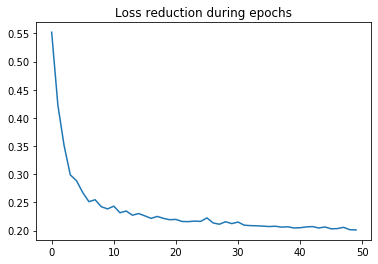

In [70]:
# getting metric particular history
plt.plot([history_model[i]["loss"] for i in list(history_model.keys())])
plt.title("Loss reduction during epochs")
plt.show()

Conclusion is Neural Network and training procedure implemented by hand works :)<br>
There is a possibility to obtain best model parameters and set it in the model to get the best one for other purposes.

In [71]:
# best weights
best_weights = history_model["epoch_40"]["model_weights"]

In [72]:
# setting model weights to best weights
model.set_weights(best_weights)

In [73]:
# double check
test_pred = model.predict(X_valid[RFfeatures].values,
                          batch_size=X_valid[target].values.shape[0])

print(average_precision_score(X_valid[target].values, test_pred))
print(history_model["epoch_40"]["AUC_PR_val"])

0.3208069698716666
0.3208069698716666


It works :)
### Neural Network parameters inspection and learning process control

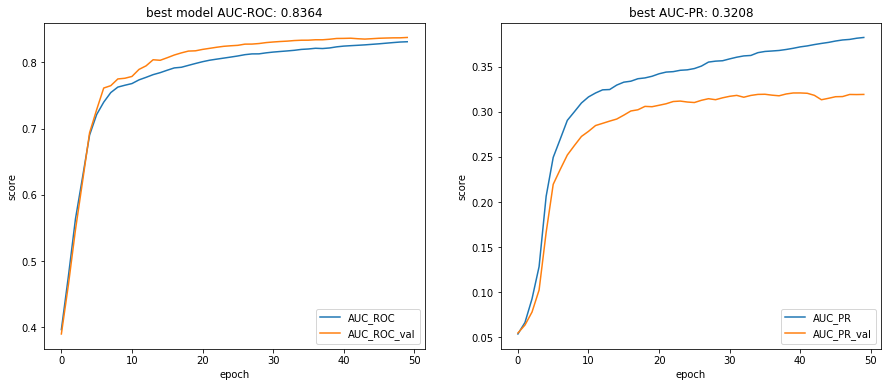

In [74]:
# history dict to df convert
historyDF = pd.DataFrame(list(history_model.values()))
historyDF.drop("model_weights", axis= 1, inplace = True)

f, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15,6))

historyDF.loc[:, ["AUC_ROC", "AUC_ROC_val"]].plot(ax = ax[0])
ax[0].set_title('best model AUC-ROC: {}'.format(round(ROCtest, 4)))
ax[0].legend(loc = 4)
ax[0].set_xlabel("epoch")
ax[0].set_ylabel("score")

historyDF.loc[:, ["AUC_PR", "AUC_PR_val"]].plot(ax = ax[1])
ax[1].set_title('best AUC-PR: {}'.format(round(PRtest, 4)))
ax[1].legend(loc = 4)
ax[1].set_xlabel("epoch")
ax[1].set_ylabel("score")
plt.show()

Nice, smooth curves (that is what is needed in Neural Network learning process, it is possible to see the progress, and best results can't be considered as random lucky shoot), small overfitting, but performance isn't as good as tree-based methods. What is super cool is the fact that this model has better performance that Zięba et. al. Network, they obtained near 70% AUC-ROC score, this model is focused on AUC-PR and can outperofm the cited one (it is one split of course but +13% looks pretty solid).
##### - Optimizers

best model epoch: 40
SGD, best AUC_PR: 0.3208069698716666
SGD, best AUC_ROC: 0.8364079822616408
------------------------------
best model epoch: 47
RMSprop, best AUC_PR: 0.3792789614452345
RMSprop, best AUC_ROC: 0.8144235033259424
------------------------------
best model epoch: 0
Adam, best AUC_PR: 0.3168754879750001
Adam, best AUC_ROC: 0.7356152993348115
------------------------------


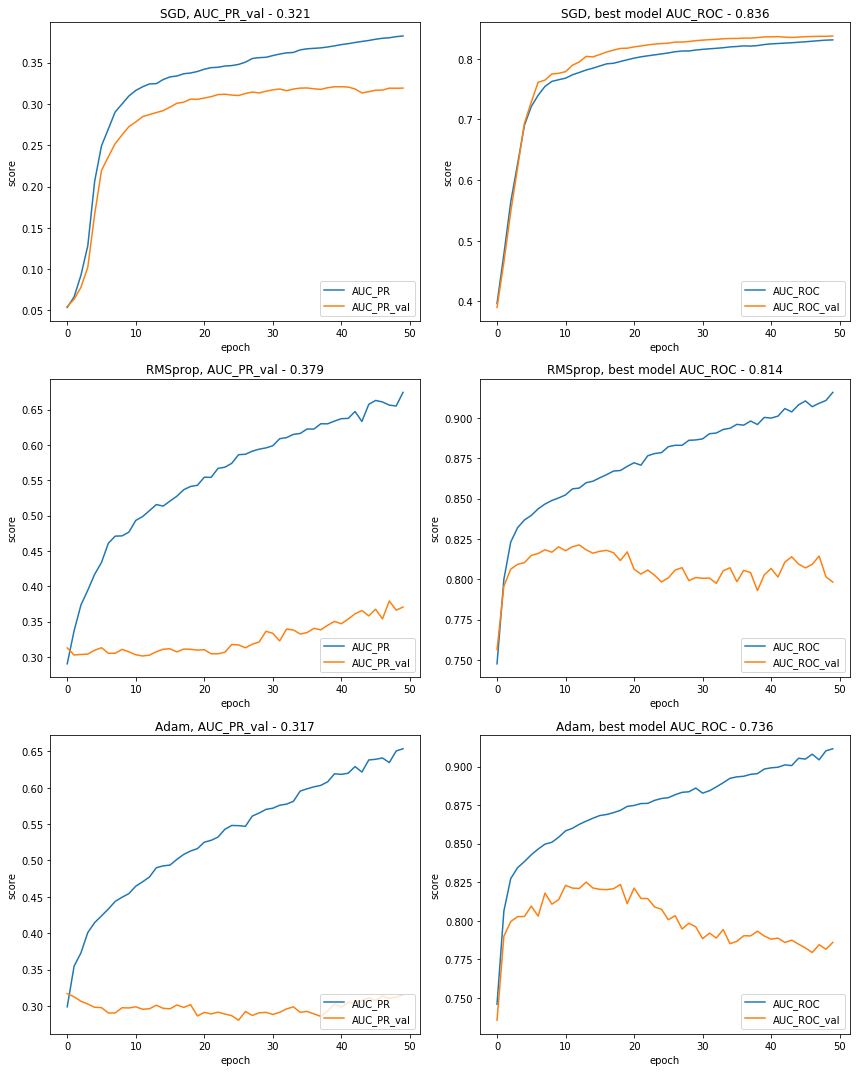

In [75]:
optimizers = ["SGD", "RMSprop", "Adam"]

fig, ax = plt.subplots(3, 2, figsize=(12,15))

seed(2020)
set_random_seed(2020)

for i, opt in enumerate(optimizers):
    ROCtest, PRtest, bestTrainProba, bestTestProba, history_model, model = net(
        X_train, X_valid, RFfeatures, units = [60,60], batchNorm = [False, False], epochs = 50, batchSize=50, debug=False,
    optimizer = opt)
    
    historyDF = pd.DataFrame(list(history_model.values()))
    historyDF.drop("model_weights", axis= 1, inplace = True)
    
    print('{}, best AUC_PR: {}'.format(opt, PRtest))
    print('{}, best AUC_ROC: {}'.format(opt, ROCtest))
    print('-'*30)
    
    historyDF.loc[:, ["AUC_PR", "AUC_PR_val"]].plot(ax = ax[i,0])
    ax[i,0].set_title(opt+ ", AUC_PR_val - " + str(round(PRtest, 3)))
    ax[i,0].legend(loc = 4)
    ax[i,0].set_xlabel("epoch")
    ax[i,0].set_ylabel("score")
    
    
    historyDF.loc[:, ["AUC_ROC", "AUC_ROC_val"]].plot(ax = ax[i,1])
    ax[i,1].set_title(opt+ ", best model AUC_ROC - " + str(round(ROCtest, 3)))
    ax[i,1].legend(loc = 4)
    ax[i,1].set_xlabel("epoch")
    ax[i,1].set_ylabel("score")
    

plt.tight_layout()
plt.show()

Looks like adam is not working well, SGD is super smooth, but RMSprop is still growing after 50 epochs! Let's dive more into RMSprop and SGD.

best model epoch: 40
SGD, best AUC_PR: 0.3208069698716666
SGD, best AUC_ROC: 0.8364079822616408
------------------------------
best model epoch: 99
RMSprop, best AUC_PR: 0.36760028796167643
RMSprop, best AUC_ROC: 0.7575000000000001
------------------------------


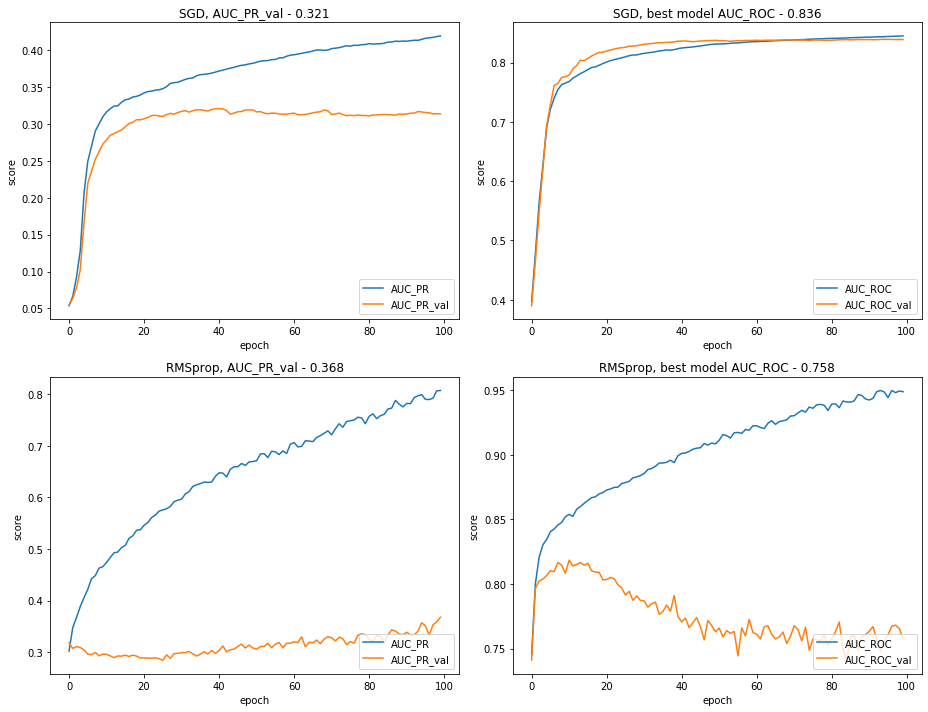

In [76]:
optimizers = ["SGD", "RMSprop"]

fig, ax = plt.subplots(2, 2, figsize=(13,10))

seed(2020)
set_random_seed(2020)

for i, opt in enumerate(optimizers):
    ROCtest, PRtest, bestTrainProba, bestTestProba, history_model, model = net(
        X_train, X_valid, RFfeatures, units = [60,60], batchNorm = [False, False], epochs = 100, batchSize=50, debug=False,
    optimizer = opt)
    
    historyDF = pd.DataFrame(list(history_model.values()))
    historyDF.drop("model_weights", axis= 1, inplace = True)
    
    print('{}, best AUC_PR: {}'.format(opt, PRtest))
    print('{}, best AUC_ROC: {}'.format(opt, ROCtest))
    print('-'*30)
    
    historyDF.loc[:, ["AUC_PR", "AUC_PR_val"]].plot(ax = ax[i,0])
    ax[i,0].set_title(opt+ ", AUC_PR_val - " + str(round(PRtest, 3)))
    ax[i,0].legend(loc = 4)
    ax[i,0].set_xlabel("epoch")
    ax[i,0].set_ylabel("score")
    
    
    historyDF.loc[:, ["AUC_ROC", "AUC_ROC_val"]].plot(ax = ax[i,1])
    ax[i,1].set_title(opt+ ", best model AUC_ROC - " + str(round(ROCtest, 3)))
    ax[i,1].legend(loc = 4)
    ax[i,1].set_xlabel("epoch")
    ax[i,1].set_ylabel("score")
    

plt.tight_layout()
plt.show()

Looks like stop criterion doesn't work well with RMSprop optimizer, there is also a huge, progressive overfitting in RMSprop, it also learns much faster than sgd (by epochs), to get more predictible results its better to use SGD, maybe learning rate and others can improve its behavoirs.

In [77]:
from keras.optimizers import RMSprop # to test parameters of the RMSprop optimizer

best model epoch: 81
0.001, best AUC_PR: 0.37812042443463384
0.001, best AUC_ROC: 0.7705155210643015
------------------------------
best model epoch: 24
0.003, best AUC_PR: 0.33931138619697276
0.003, best AUC_ROC: 0.7802272727272728
------------------------------
best model epoch: 16
0.01, best AUC_PR: 0.3717014316906303
0.01, best AUC_ROC: 0.7914024390243902
------------------------------
best model epoch: 17
0.03, best AUC_PR: 0.38509367744975015
0.03, best AUC_ROC: 0.7895121951219511
------------------------------


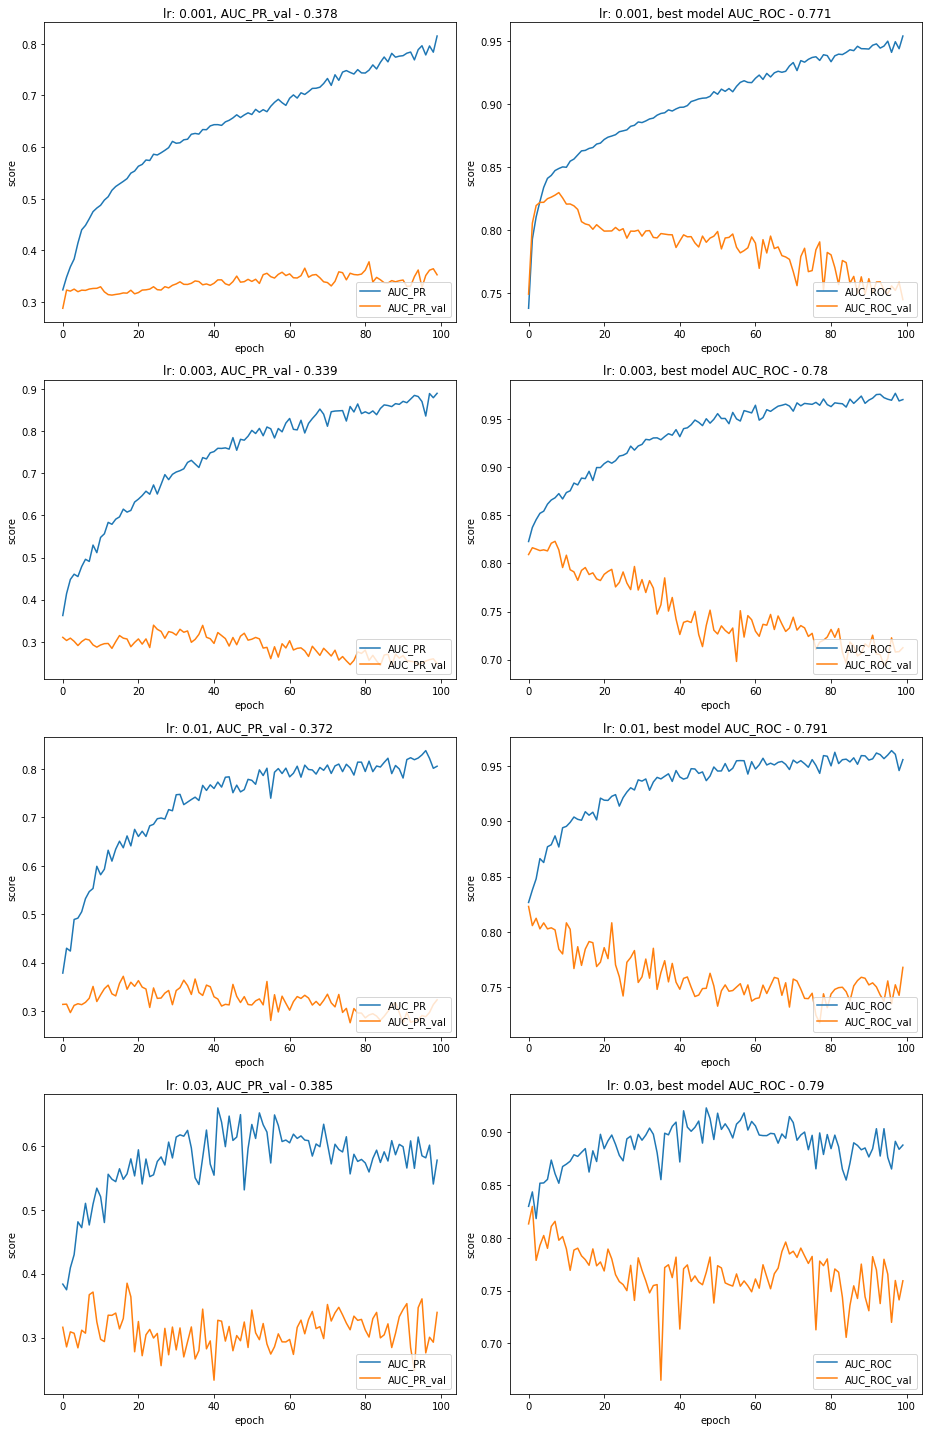

In [78]:
# learning rate
lr = [0.001, 0.003, 0.01, 0.03]

fig, ax = plt.subplots(4, 2, figsize=(13,20))

seed(2020)
set_random_seed(2020)

for i, lr in enumerate(lr):
    ROCtest, PRtest, bestTrainProba, bestTestProba, history_model, model = net(
        X_train, X_valid, RFfeatures, units = [60,60], batchNorm = [False, False], epochs = 100, batchSize=50, debug=False,
    optimizer = RMSprop(learning_rate = lr))
    
    historyDF = pd.DataFrame(list(history_model.values()))
    historyDF.drop("model_weights", axis= 1, inplace = True)
    
    print('{}, best AUC_PR: {}'.format(lr, PRtest))
    print('{}, best AUC_ROC: {}'.format(lr, ROCtest))
    print('-'*30)
    
    historyDF.loc[:, ["AUC_PR", "AUC_PR_val"]].plot(ax = ax[i,0])
    ax[i,0].set_title("lr: {}, AUC_PR_val - ".format(lr) + str(round(PRtest, 3)))
    ax[i,0].legend(loc = 4)
    ax[i,0].set_xlabel("epoch")
    ax[i,0].set_ylabel("score")
    
    
    historyDF.loc[:, ["AUC_ROC", "AUC_ROC_val"]].plot(ax = ax[i,1])
    ax[i,1].set_title("lr: {}, best model AUC_ROC - ".format(lr) + str(round(ROCtest, 3)))
    ax[i,1].legend(loc = 4)
    ax[i,1].set_xlabel("epoch")
    ax[i,1].set_ylabel("score")
    

plt.tight_layout()
plt.show()

bigger learning rate in RMSprop, less stability in learning process, max results achived faster

best model epoch: 93
0.7, best AUC_PR: 0.3703992487141531
0.7, best AUC_ROC: 0.7621452328159646
------------------------------
best model epoch: 86
0.8, best AUC_PR: 0.34248490301866596
0.8, best AUC_ROC: 0.7568736141906872
------------------------------
best model epoch: 90
0.85, best AUC_PR: 0.3309810884086542
0.85, best AUC_ROC: 0.7706984478935698
------------------------------
best model epoch: 61
0.9, best AUC_PR: 0.3356931499474871
0.9, best AUC_ROC: 0.7809645232815964
------------------------------


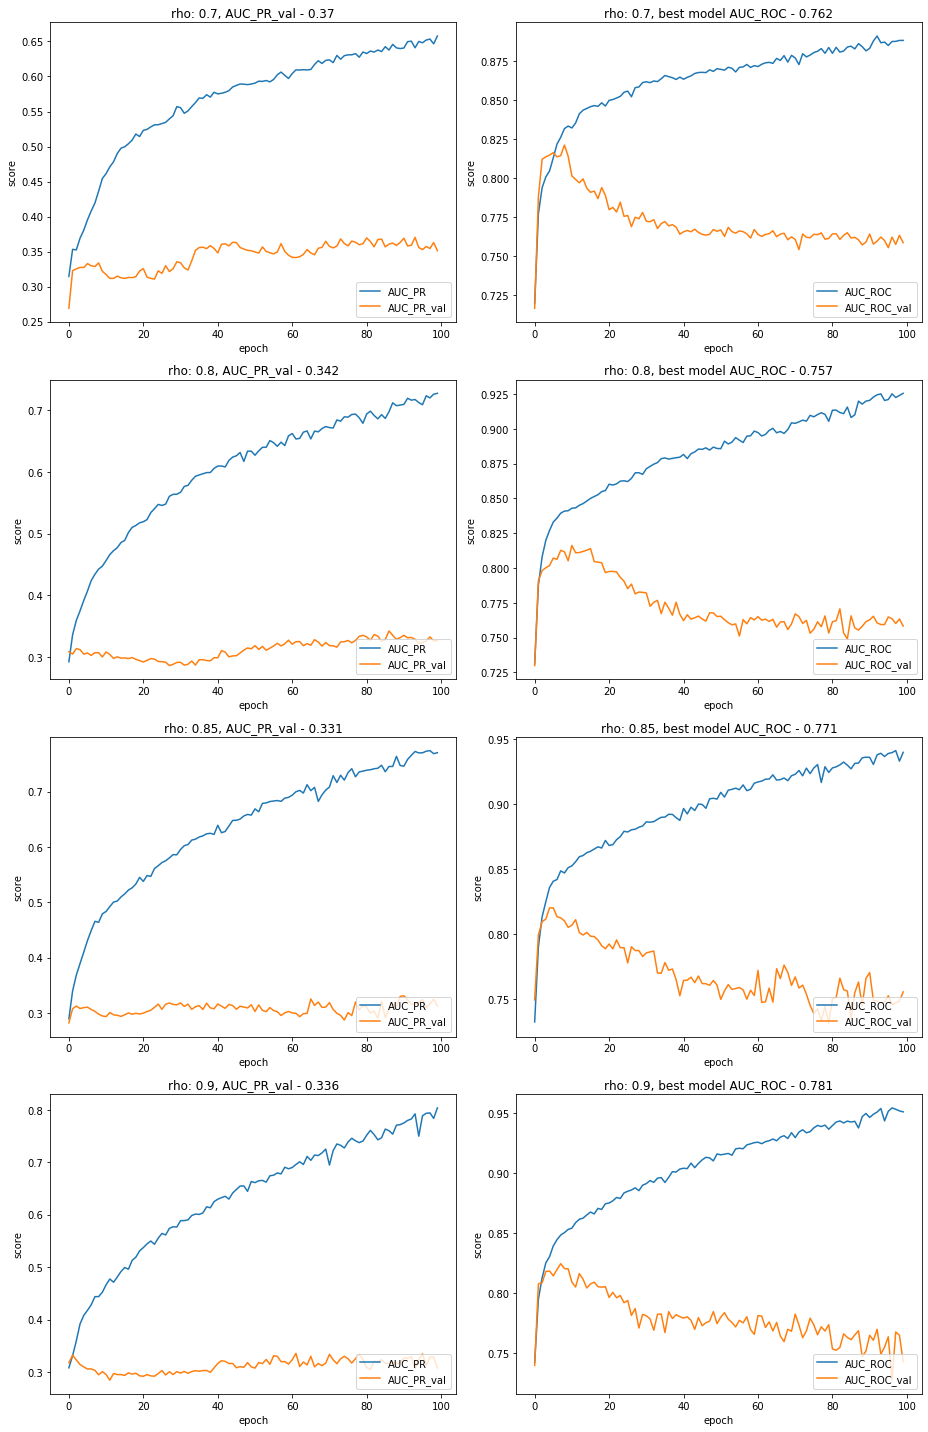

In [79]:
# rho coeficient
r = [0.7, 0.8, 0.85, 0.9]

fig, ax = plt.subplots(4, 2, figsize=(13,20))

seed(2020)
set_random_seed(2020)

for i, rho in enumerate(r):
    ROCtest, PRtest, bestTrainProba, bestTestProba, history_model, model = net(
        X_train, X_valid, RFfeatures, units = [60,60], batchNorm = [False, False], epochs = 100, batchSize=50, debug=False,
    optimizer = RMSprop(rho = rho))
    
    historyDF = pd.DataFrame(list(history_model.values()))
    historyDF.drop("model_weights", axis= 1, inplace = True)
    
    print('{}, best AUC_PR: {}'.format(rho, PRtest))
    print('{}, best AUC_ROC: {}'.format(rho, ROCtest))
    print('-'*30)
    
    historyDF.loc[:, ["AUC_PR", "AUC_PR_val"]].plot(ax = ax[i,0])
    ax[i,0].set_title("rho: {}, AUC_PR_val - ".format(rho) + str(round(PRtest, 3)))
    ax[i,0].legend(loc = 4)
    ax[i,0].set_xlabel("epoch")
    ax[i,0].set_ylabel("score")
    
    
    historyDF.loc[:, ["AUC_ROC", "AUC_ROC_val"]].plot(ax = ax[i,1])
    ax[i,1].set_title("rho: {}, best model AUC_ROC - ".format(rho) + str(round(ROCtest, 3)))
    ax[i,1].legend(loc = 4)
    ax[i,1].set_xlabel("epoch")
    ax[i,1].set_ylabel("score")
    

plt.tight_layout()
plt.show()

Learning proces looks unstable, lets check leaerning rates in SGD

In [80]:
from keras.optimizers import SGD # to test parameters of the RMSprop optimizer

best model epoch: 40
0.01, best AUC_PR: 0.3208069698716666
0.01, best AUC_ROC: 0.8364079822616408
------------------------------
best model epoch: 11
0.03, best AUC_PR: 0.31435866992924966
0.03, best AUC_ROC: 0.8224944567627495
------------------------------
best model epoch: 14
0.05, best AUC_PR: 0.30950343329163876
0.05, best AUC_ROC: 0.8292461197339247
------------------------------
best model epoch: 98
0.08, best AUC_PR: 0.32703598853092725
0.08, best AUC_ROC: 0.8169512195121951
------------------------------


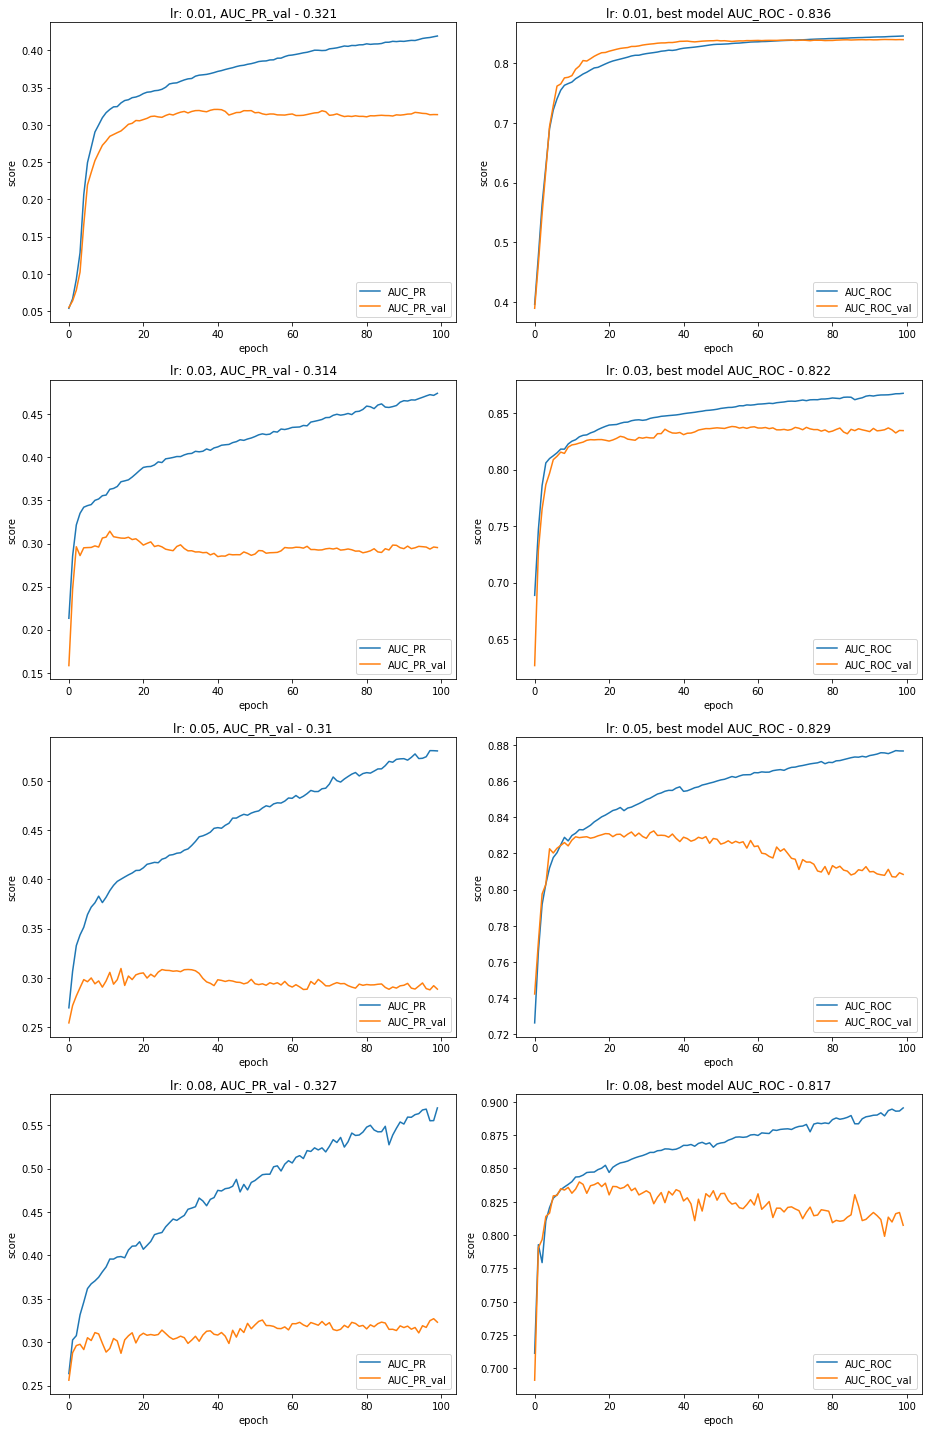

In [81]:
# learning rate
lr = [0.01, 0.03, 0.05, 0.08]

fig, ax = plt.subplots(4, 2, figsize=(13,20))

seed(2020)
set_random_seed(2020)

for i, l in enumerate(lr):
    ROCtest, PRtest, bestTrainProba, bestTestProba, history_model, model = net(
        X_train, X_valid, RFfeatures, units = [60,60], batchNorm = [False, False], epochs = 100, batchSize=50, debug=False,
    optimizer = SGD(l))
    
    historyDF = pd.DataFrame(list(history_model.values()))
    historyDF.drop("model_weights", axis= 1, inplace = True)
    
    print('{}, best AUC_PR: {}'.format(l, PRtest))
    print('{}, best AUC_ROC: {}'.format(l, ROCtest))
    print('-'*30)
    
    historyDF.loc[:, ["AUC_PR", "AUC_PR_val"]].plot(ax = ax[i,0])
    ax[i,0].set_title("lr: {}, AUC_PR_val - ".format(l) + str(round(PRtest, 3)))
    ax[i,0].legend(loc = 4)
    ax[i,0].set_xlabel("epoch")
    ax[i,0].set_ylabel("score")
    
    
    historyDF.loc[:, ["AUC_ROC", "AUC_ROC_val"]].plot(ax = ax[i,1])
    ax[i,1].set_title("lr: {}, best model AUC_ROC - ".format(l) + str(round(ROCtest, 3)))
    ax[i,1].legend(loc = 4)
    ax[i,1].set_xlabel("epoch")
    ax[i,1].set_ylabel("score")
    

plt.tight_layout()
plt.show()

because RMSprop can achive better results and SGD stucks on the same level independently from learning rate, maybe cost function is not smooth enough, and adding some momentum to SGD may help.

best model epoch: 99
0.7, best AUC_PR: 0.31933687473111355
0.7, best AUC_ROC: 0.8272616407982263
------------------------------
best model epoch: 2
0.8, best AUC_PR: 0.31403529578543826
0.8, best AUC_ROC: 0.7875055432372505
------------------------------
best model epoch: 14
0.85, best AUC_PR: 0.30950409808413826
0.85, best AUC_ROC: 0.828470066518847
------------------------------
best model epoch: 51
0.9, best AUC_PR: 0.33214660556956715
0.9, best AUC_ROC: 0.8234922394678491
------------------------------


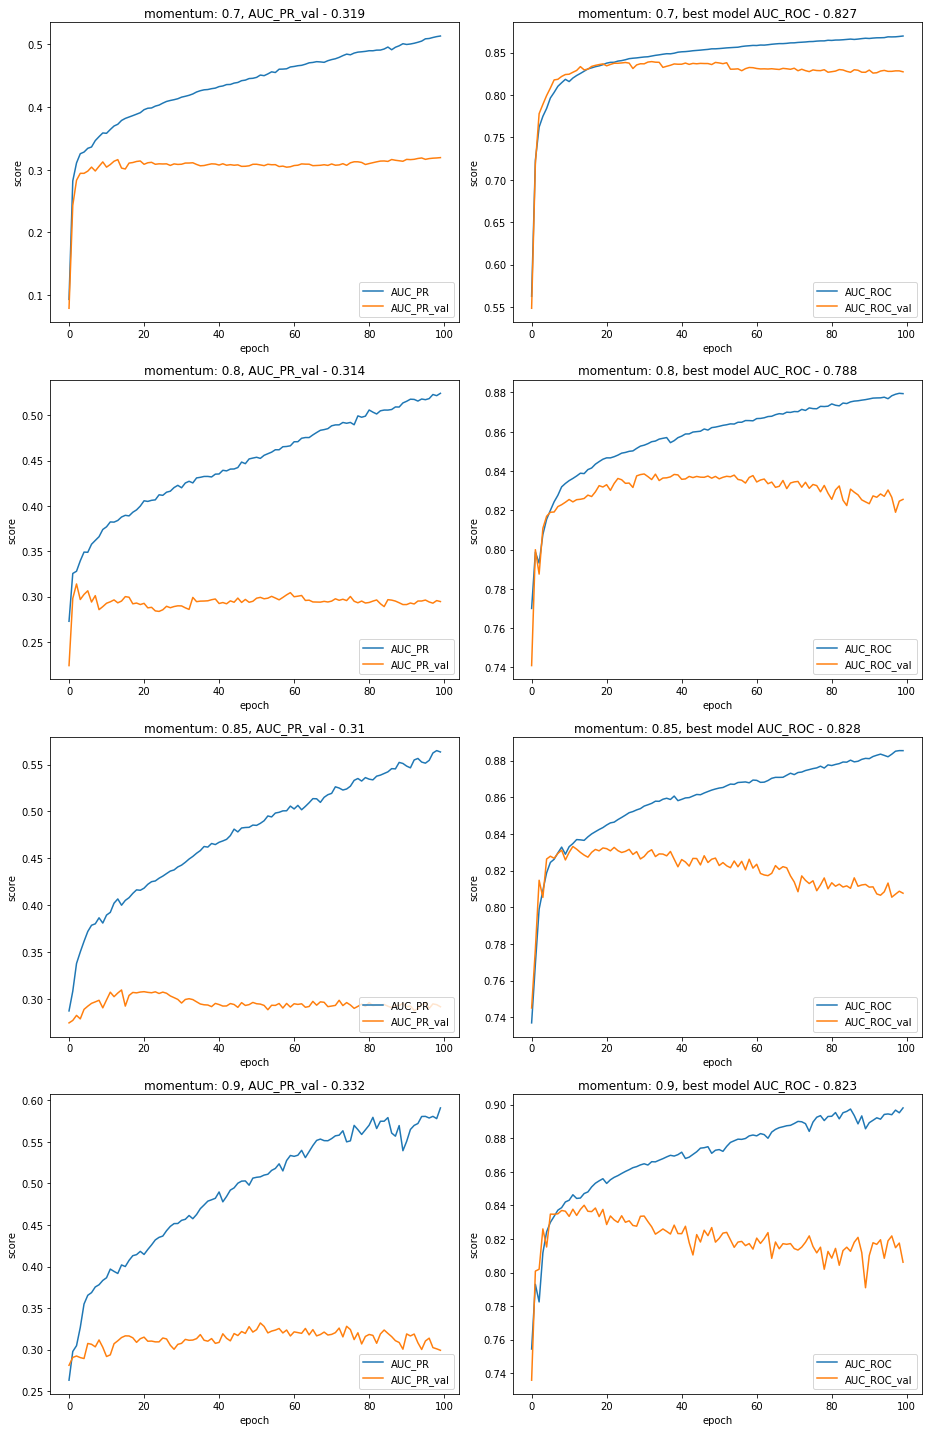

In [82]:
momentum = [0.7, 0.8, 0.85, 0.9]

fig, ax = plt.subplots(4, 2, figsize=(13,20))

seed(2020)
set_random_seed(2020)

for i, m in enumerate(momentum):
    ROCtest, PRtest, bestTrainProba, bestTestProba, history_model, model = net(
        X_train, X_valid, RFfeatures, units = [60,60], batchNorm = [False, False], epochs = 100, batchSize=50, debug=False,
    optimizer = SGD(momentum = m))
    
    historyDF = pd.DataFrame(list(history_model.values()))
    historyDF.drop("model_weights", axis= 1, inplace = True)
    
    print('{}, best AUC_PR: {}'.format(m, PRtest))
    print('{}, best AUC_ROC: {}'.format(m, ROCtest))
    print('-'*30)
    
    historyDF.loc[:, ["AUC_PR", "AUC_PR_val"]].plot(ax = ax[i,0])
    ax[i,0].set_title("momentum: {}, AUC_PR_val - ".format(m) + str(round(PRtest, 3)))
    ax[i,0].legend(loc = 4)
    ax[i,0].set_xlabel("epoch")
    ax[i,0].set_ylabel("score")
    
    
    historyDF.loc[:, ["AUC_ROC", "AUC_ROC_val"]].plot(ax = ax[i,1])
    ax[i,1].set_title("momentum: {}, best model AUC_ROC - ".format(m) + str(round(ROCtest, 3)))
    ax[i,1].legend(loc = 4)
    ax[i,1].set_xlabel("epoch")
    ax[i,1].set_ylabel("score")
    

plt.tight_layout()
plt.show()

lets check RMSprop and SGD with different mini-btch size (maybe it can smooth learning proces in RMSprop)

best model epoch: 4
SGD, batch: 6, best AUC_PR: 0.32936989810147055
SGD, batch: 6, best AUC_ROC: 0.8361419068736142
time: 46.02 second
------------------------------
best model epoch: 32
SGD, batch: 24, best AUC_PR: 0.3151176576172501
SGD, batch: 24, best AUC_ROC: 0.8294235033259425
time: 15.12 second
------------------------------
best model epoch: 21
SGD, batch: 48, best AUC_PR: 0.3206792831924645
SGD, batch: 48, best AUC_ROC: 0.8177161862527716
time: 9.78 second
------------------------------
best model epoch: 49
SGD, batch: 96, best AUC_PR: 0.29120001719813043
SGD, batch: 96, best AUC_ROC: 0.817139689578714
time: 7.2 second
------------------------------
best model epoch: 45
SGD, batch: 120, best AUC_PR: 0.2986040206267714
SGD, batch: 120, best AUC_ROC: 0.805088691796009
time: 6.73 second
------------------------------
best model epoch: 48
SGD, batch: 256, best AUC_PR: 0.269052429927824
SGD, batch: 256, best AUC_ROC: 0.7781263858093126
time: 5.84 second
----------------------------

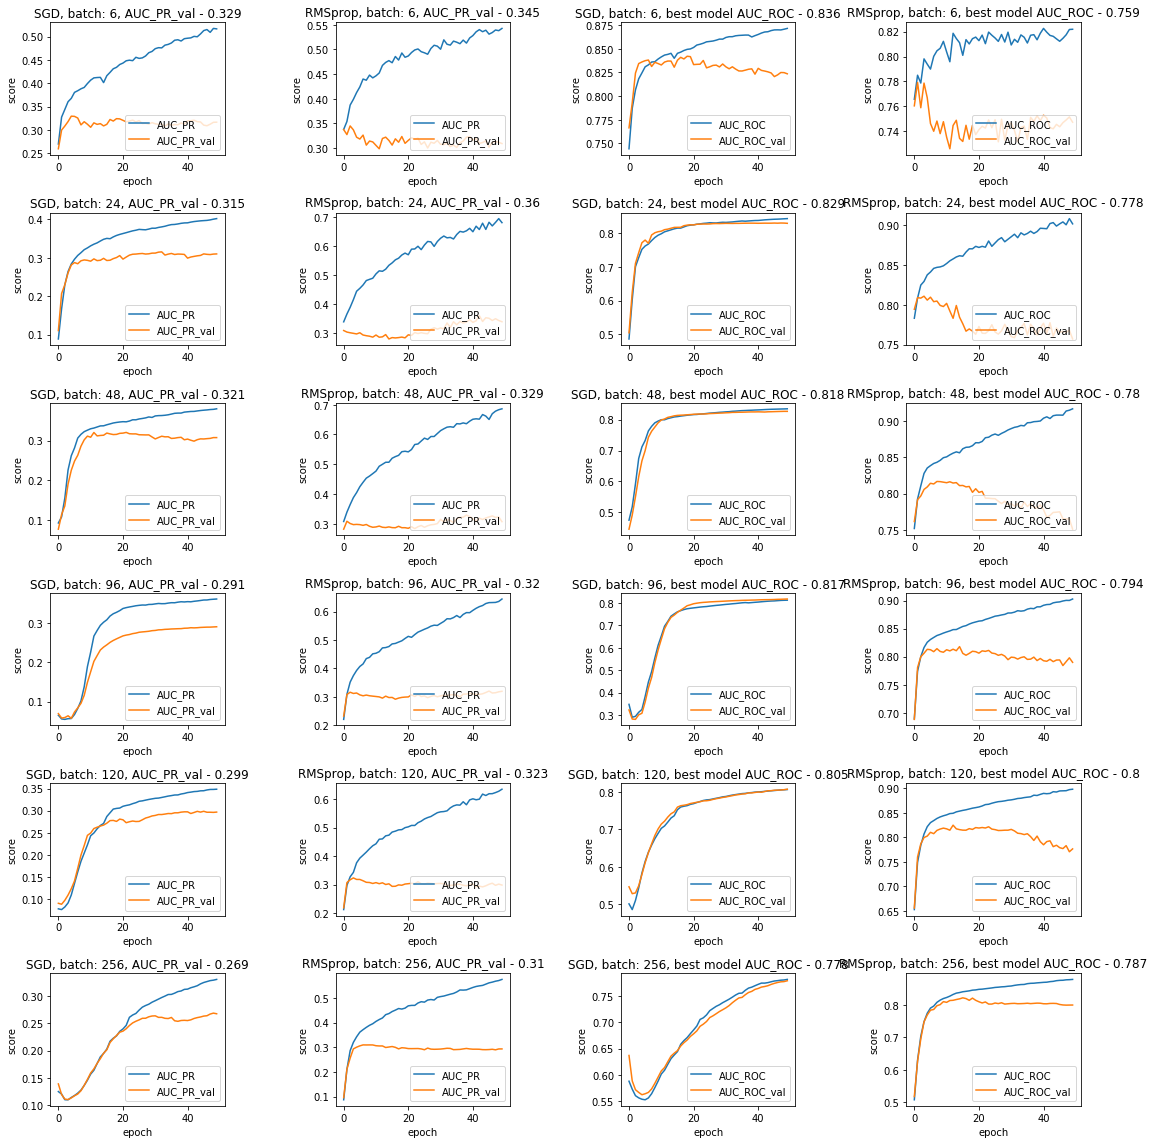

In [83]:
optimizers = ["SGD", "RMSprop"]
batch_size = [6, 24, 48, 96, 120, 256]

fig, ax = plt.subplots(6, 4, figsize=(16,16))

seed(2020)
set_random_seed(2020)

for i, opt in enumerate(optimizers):
    for j, batch in enumerate(batch_size):
        start = time.time()
        ROCtest, PRtest, bestTrainProba, bestTestProba, history_model, model = net(
            X_train, X_valid, RFfeatures, units = [60,60], batchNorm = [False, False], epochs = 50, batchSize=batch,
            debug=False, optimizer = opt)
        stop = time.time()
        historyDF = pd.DataFrame(list(history_model.values()))
        historyDF.drop("model_weights", axis= 1, inplace = True)

        print('{}, batch: {}, best AUC_PR: {}'.format(opt, batch, PRtest))
        print('{}, batch: {}, best AUC_ROC: {}'.format(opt, batch, ROCtest))
        print('time: {} second'.format(round(stop-start, 2)))
        print('-'*30)

        historyDF.loc[:, ["AUC_PR", "AUC_PR_val"]].plot(ax = ax[j,i])
        ax[j,i].set_title("{}, batch: {}, AUC_PR_val - ".format(opt, batch) + str(round(PRtest, 3)))
        ax[j,i].legend(loc = 4)
        ax[j,i].set_xlabel("epoch")
        ax[j,i].set_ylabel("score")


        historyDF.loc[:, ["AUC_ROC", "AUC_ROC_val"]].plot(ax = ax[j,i+2])
        ax[j,i+2].set_title("{}, batch: {}, best model AUC_ROC - ".format(opt, batch) + str(round(ROCtest, 3)))
        ax[j,i+2].legend(loc = 4)
        ax[j,i+2].set_xlabel("epoch")
        ax[j,i+2].set_ylabel("score")
    

plt.tight_layout()
plt.show()

It is a very important picture - bigger batch, smoother RMSprop learning process at 256 it is very smooth, while SGD behavoir is very strange especially on AUC-ROC scores. Higher batch = faster learning (huge difference). Best model results dependence is not easy to spot, but it depends on the other model params for sure, lets try Adam with higher batch. Adam is a bit simillar to RMSprop, but it is the more popular one.

best model epoch: 46
RMSprop, batch: 48, best AUC_PR: 0.3552093836462952
RMSprop, batch: 48, best AUC_ROC: 0.796108647450111
time: 11.36 second
------------------------------
best model epoch: 49
RMSprop, batch: 96, best AUC_PR: 0.33193507660297333
RMSprop, batch: 96, best AUC_ROC: 0.8037860310421286
time: 8.45 second
------------------------------
best model epoch: 1
RMSprop, batch: 120, best AUC_PR: 0.3168988179824517
RMSprop, batch: 120, best AUC_ROC: 0.7371119733924613
time: 7.93 second
------------------------------
best model epoch: 47
RMSprop, batch: 256, best AUC_PR: 0.31230707575894373
RMSprop, batch: 256, best AUC_ROC: 0.8070177383592018
time: 7.37 second
------------------------------
best model epoch: 20
RMSprop, batch: 512, best AUC_PR: 0.3127636067150075
RMSprop, batch: 512, best AUC_ROC: 0.8277272727272726
time: 6.09 second
------------------------------
best model epoch: 46
Adam, batch: 48, best AUC_PR: 0.3445049939798811
Adam, batch: 48, best AUC_ROC: 0.771529933481153

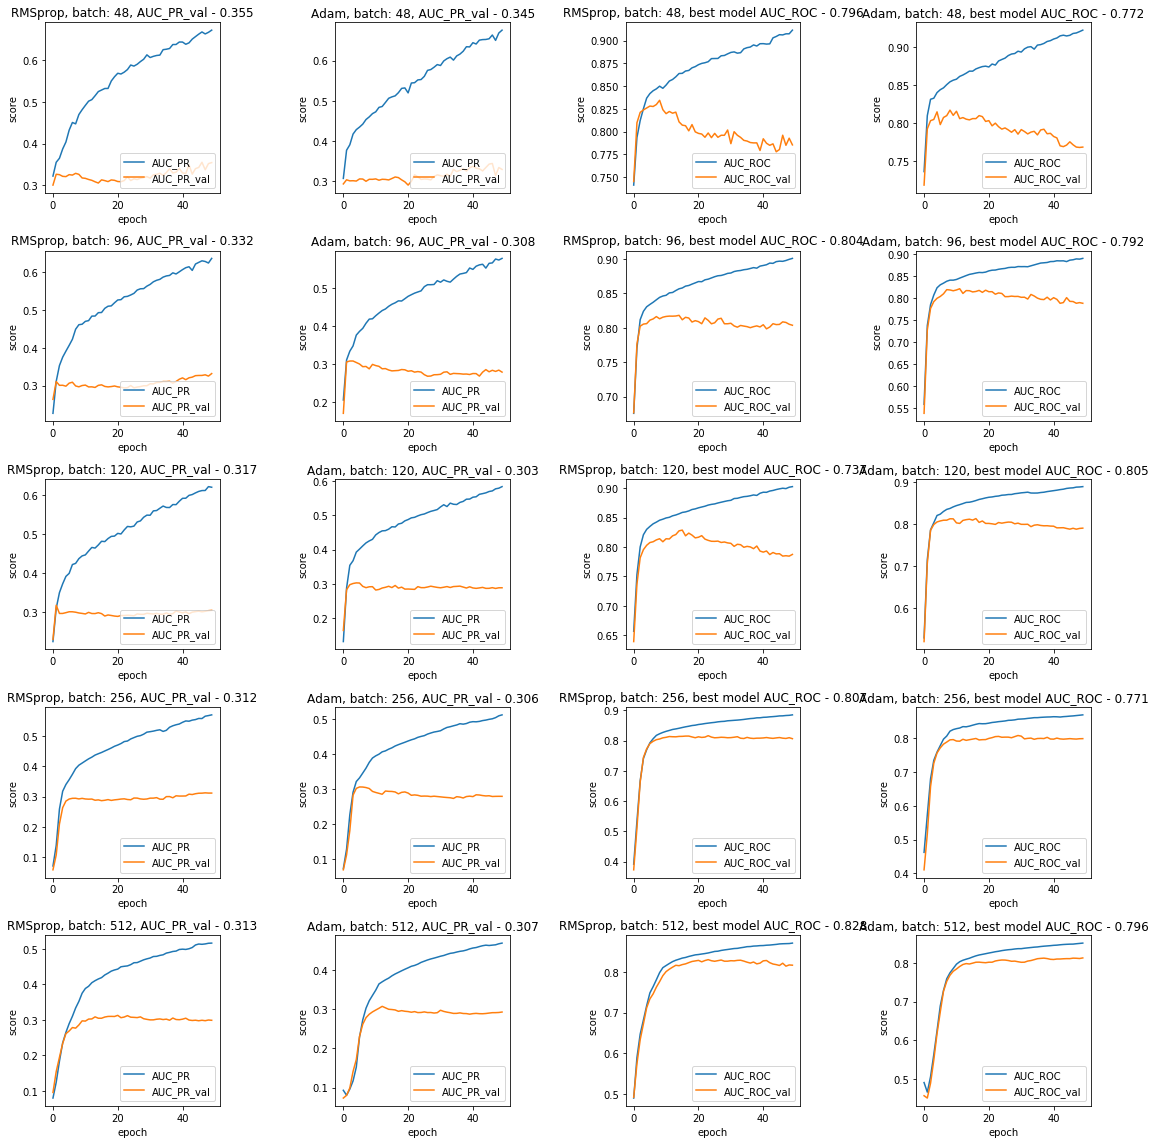

In [84]:
optimizers = ["RMSprop", "Adam"]
batch_size = [48, 96, 120, 256, 512]

fig, ax = plt.subplots(5, 4, figsize=(16,16))

seed(2020)
set_random_seed(2020)

for i, opt in enumerate(optimizers):
    for j, batch in enumerate(batch_size):
        start = time.time()
        ROCtest, PRtest, bestTrainProba, bestTestProba, history_model, model = net(
            X_train, X_valid, RFfeatures, units = [60,60], batchNorm = [False, False], epochs = 50, batchSize=batch,
            debug=False, optimizer = opt)
        stop = time.time()
        historyDF = pd.DataFrame(list(history_model.values()))
        historyDF.drop("model_weights", axis= 1, inplace = True)

        print('{}, batch: {}, best AUC_PR: {}'.format(opt, batch, PRtest))
        print('{}, batch: {}, best AUC_ROC: {}'.format(opt, batch, ROCtest))
        print('time: {} second'.format(round(stop-start, 2)))
        print('-'*30)

        historyDF.loc[:, ["AUC_PR", "AUC_PR_val"]].plot(ax = ax[j,i])
        ax[j,i].set_title("{}, batch: {}, AUC_PR_val - ".format(opt, batch) + str(round(PRtest, 3)))
        ax[j,i].legend(loc = 4)
        ax[j,i].set_xlabel("epoch")
        ax[j,i].set_ylabel("score")


        historyDF.loc[:, ["AUC_ROC", "AUC_ROC_val"]].plot(ax = ax[j,i+2])
        ax[j,i+2].set_title("{}, batch: {}, best model AUC_ROC - ".format(opt, batch) + str(round(ROCtest, 3)))
        ax[j,i+2].legend(loc = 4)
        ax[j,i+2].set_xlabel("epoch")
        ax[j,i+2].set_ylabel("score")
    

plt.tight_layout()
plt.show()

bigger batches, less overfitting, smoother curves for momentum based algorithms, more stable learning proces. For batch >96 stop criterion metric results seems to converge. RMSprop looks a bit better. Conclusion - best optimization algorithm is RMS prop with 100-500 batch size.

##### - Activation functions

best model epoch: 35
tanh, best AUC_PR: 0.35261499327376067
tanh, best AUC_ROC: 0.8442572062084257
------------------------------
best model epoch: 49
sigmoid, best AUC_PR: 0.31960520968650896
sigmoid, best AUC_ROC: 0.8286585365853658
------------------------------
best model epoch: 12
linear, best AUC_PR: 0.3286814414882866
linear, best AUC_ROC: 0.8239578713968958
------------------------------
best model epoch: 49
relu, best AUC_PR: 0.30605409416920243
relu, best AUC_ROC: 0.8089911308203992
------------------------------
best model epoch: 37
selu, best AUC_PR: 0.3351486303386505
selu, best AUC_ROC: 0.825521064301552
------------------------------
best model epoch: 9
prelu, best AUC_PR: 0.3014934152644711
prelu, best AUC_ROC: 0.7971064301552108
------------------------------


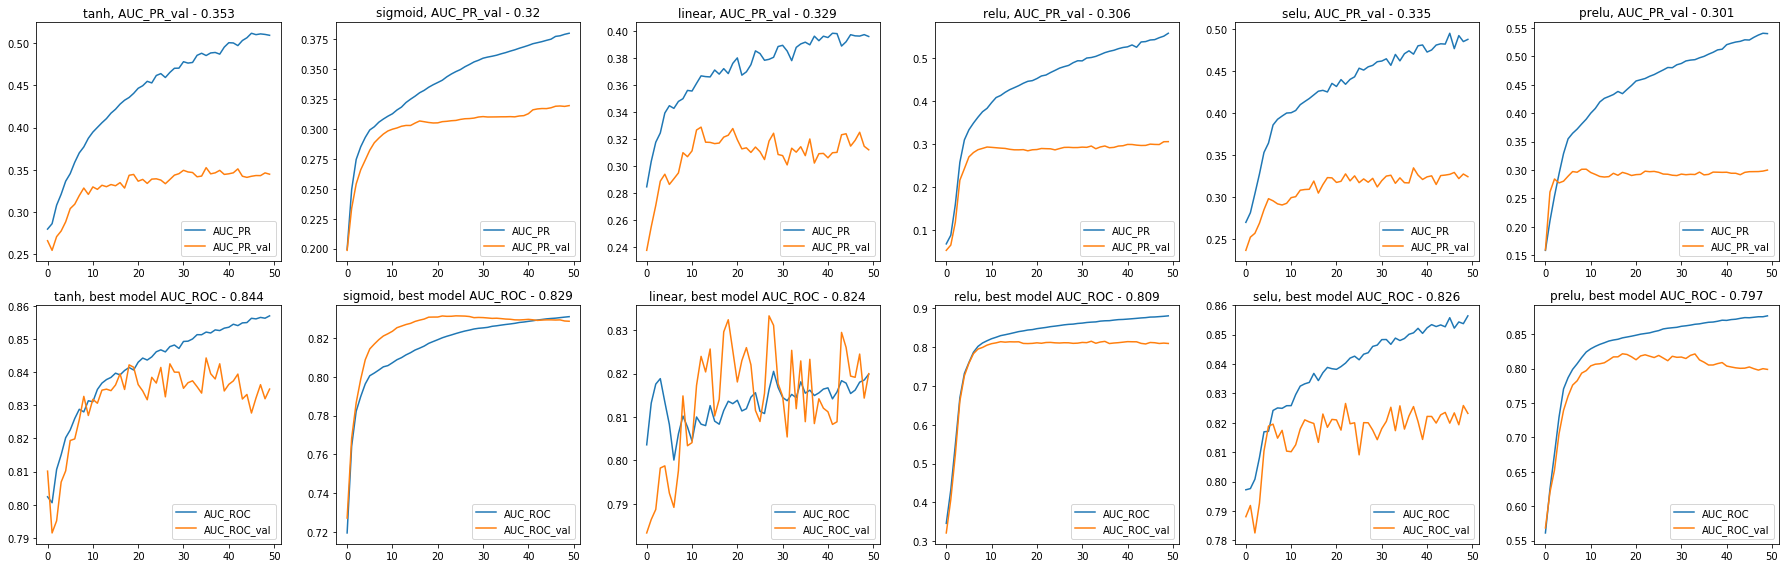

In [85]:
activations = ["tanh", "sigmoid", "linear", "relu", "selu", "prelu"]

fig, ax = plt.subplots(2, 6, figsize=(25,8))

seed(2020)
set_random_seed(2020)

for i, act in enumerate(activations):
    ROCtest, PRtest, bestTrainProba, bestTestProba, history_model, model = net(
        X_train, X_valid, RFfeatures, units = [60,60], batchNorm = [False, False], epochs = 50, batchSize=350, debug=False,
    optimizer = "RMSprop", activation = [act, act])
    
    historyDF = pd.DataFrame(list(history_model.values()))
    historyDF.drop("model_weights", axis= 1, inplace = True)
    
    print('{}, best AUC_PR: {}'.format(act, PRtest))
    print('{}, best AUC_ROC: {}'.format(act, ROCtest))
    print('-'*30)
    
    historyDF.loc[:, ["AUC_PR", "AUC_PR_val"]].plot(ax = ax[0,i])
    ax[0,i].set_title("{}, AUC_PR_val - ".format(act) + str(round(PRtest, 3)))
    ax[0,i].legend(loc = 4)
    
    
    historyDF.loc[:, ["AUC_ROC", "AUC_ROC_val"]].plot(ax = ax[1,i])
    ax[1,i].set_title("{}, best model AUC_ROC - ".format(act) + str(round(ROCtest, 3)))
    ax[1,i].legend(loc = 4)
    

plt.tight_layout()
plt.show()

tahn function looks very nice in terms of best model results, it is also ok in PR learning proces, but ROC results shape looks not that great. Sigmoid function looks very nice in terms of results and shape, it also has potential for more epochos, overfitting is progressive but smaller than tanh in PR. Linear was just for curiosity, it doesn't make sense, relu has much worse results, overfitting simillar to tanh, but it is much smoother. Tanh outperforms selu, and relu outperforms prelu. Best fucntions comparison:
 - tanh has best results and worst learning process shape, progressive but acceptable overfitting
 - sigmoid results are worse than tanh but learning process is very smooth, progressive and simillar to tanh overfitting at PR, convergence at ROC, it also has potential for more epochs
 - relu has the worst resutls, smooth shape, no potential for more epochs, the biggest overfitting

lets try some combinations.

best model epoch: 38
('tanh', 'sigmoid'), AUC_PR: 0.332558648145343
('tanh', 'sigmoid'), AUC_ROC: 0.8326940133037694
------------------------------
best model epoch: 49
('sigmoid', 'tanh'), AUC_PR: 0.3374512638156434
('sigmoid', 'tanh'), AUC_ROC: 0.8292128603104214
------------------------------
best model epoch: 3
('relu', 'tanh'), AUC_PR: 0.3300029812005534
('relu', 'tanh'), AUC_ROC: 0.7544013303769402
------------------------------
best model epoch: 45
('tanh', 'relu'), AUC_PR: 0.3224897059400203
('tanh', 'relu'), AUC_ROC: 0.8316740576496673
------------------------------
best model epoch: 13
('sigmoid', 'relu'), AUC_PR: 0.3132576230814534
('sigmoid', 'relu'), AUC_ROC: 0.8347228381374723
------------------------------
best model epoch: 40
('relu', 'sigmoid'), AUC_PR: 0.3267360426006234
('relu', 'sigmoid'), AUC_ROC: 0.8293126385809313
------------------------------


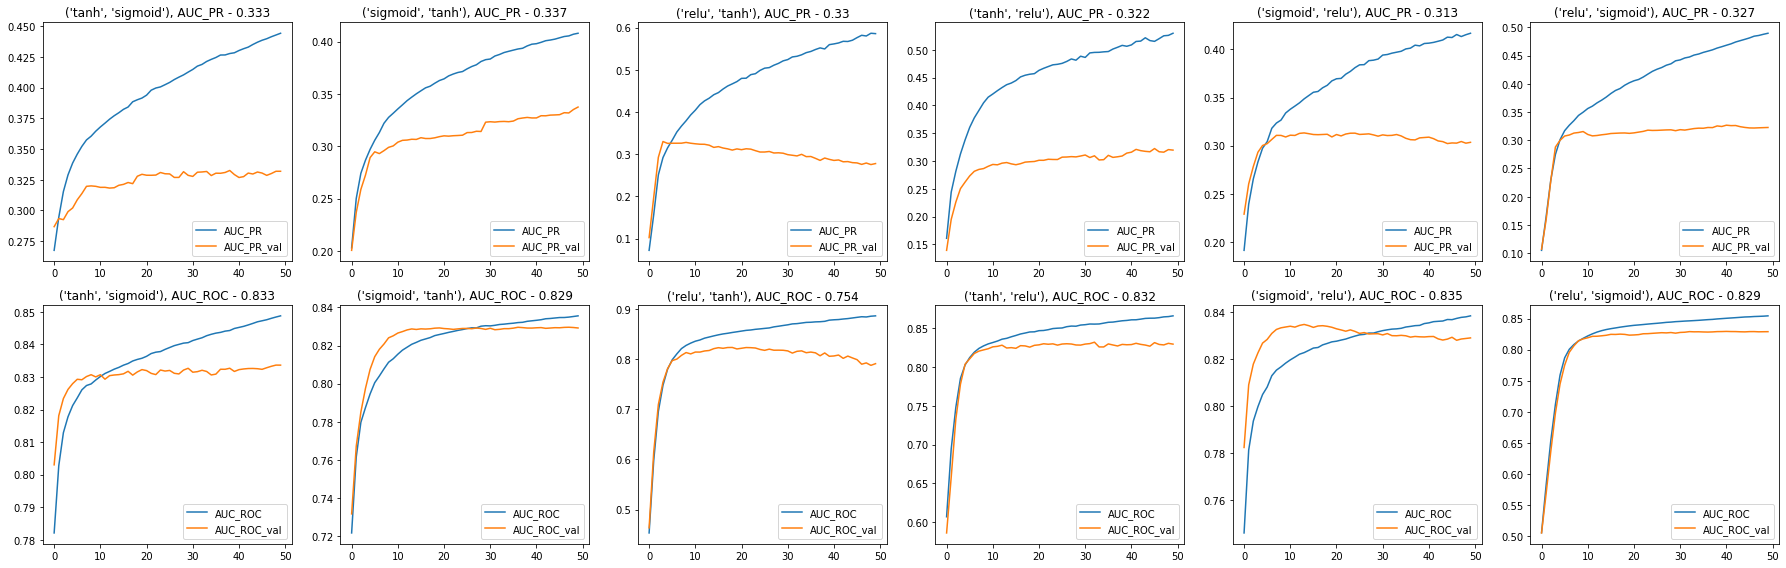

In [87]:
activations = [("tanh", "sigmoid"), ("sigmoid", "tanh"), ("relu", "tanh"),  ("tanh", "relu"), ("sigmoid", "relu"),
              ("relu", "sigmoid")]

fig, ax = plt.subplots(2, 6, figsize=(25,8))

seed(2020)
set_random_seed(2020)

for i, act in enumerate(activations):
    ROCtest, PRtest, bestTrainProba, bestTestProba, history_model, model = net(
        X_train, X_valid, RFfeatures, units = [60,60], batchNorm = [False, False], epochs = 50, batchSize=350, debug=False,
    optimizer = "RMSprop", activation = [act[0], act[1]])
    
    historyDF = pd.DataFrame(list(history_model.values()))
    historyDF.drop("model_weights", axis= 1, inplace = True)
    
    print('{}, AUC_PR: {}'.format(act, PRtest))
    print('{}, AUC_ROC: {}'.format(act, ROCtest))
    print('-'*30)
    
    historyDF.loc[:, ["AUC_PR", "AUC_PR_val"]].plot(ax = ax[0,i])
    ax[0,i].set_title("{}, AUC_PR - ".format(act) + str(round(PRtest, 3)))
    ax[0,i].legend(loc = 4)
    
    
    historyDF.loc[:, ["AUC_ROC", "AUC_ROC_val"]].plot(ax = ax[1,i])
    ax[1,i].set_title("{}, AUC_ROC - ".format(act) + str(round(ROCtest, 3)))
    ax[1,i].legend(loc = 4)
    

plt.tight_layout()
plt.show()

Combinations results are very good, tanh & sigmoid mixes achives really good results, it is also possible to see that relu looks better in first layer with sigmoid and in last with tanh. All mixes has nice and smooth learning process.<br>
conclusions:
 - relu is better in first layers with sigmoid and in last with tanh and gives the best shape,
 - tanh, sigmoid are good in every layer and produces less overfitting

##### -  Regularization (no dropout)

best model epoch: 15
0.001, AUC_PR: 0.31128121325730573
0.001, AUC_ROC: 0.8302660753880265
------------------------------
best model epoch: 8
0.003, AUC_PR: 0.31856812949562646
0.003, AUC_ROC: 0.8258314855875832
------------------------------
best model epoch: 4
0.01, AUC_PR: 0.2897011897826164
0.01, AUC_ROC: 0.8017516629711752
------------------------------
best model epoch: 15
0.03, AUC_PR: 0.2863575348028093
0.03, AUC_ROC: 0.8212361419068736
------------------------------


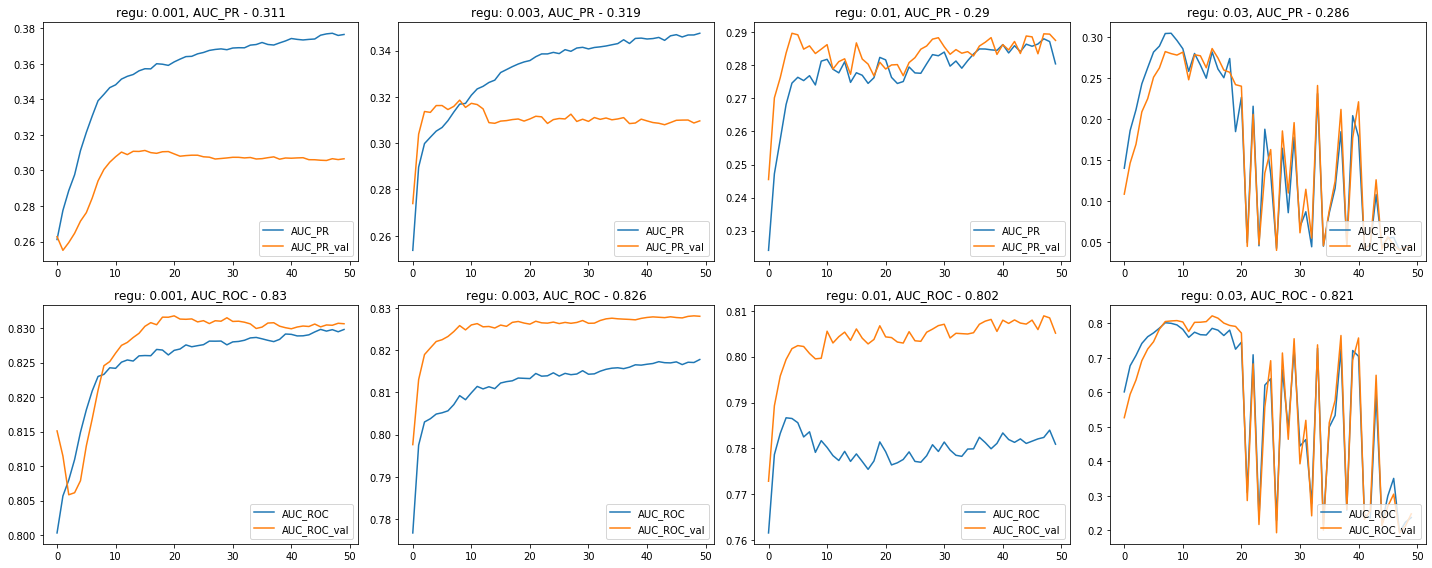

In [88]:
regularization = [0.001, 0.003, 0.01, 0.03]

fig, ax = plt.subplots(2, 4, figsize=(20,8))

seed(2020)
set_random_seed(2020)

for i, r in enumerate(regularization):
    ROCtest, PRtest, bestTrainProba, bestTestProba, history_model, model = net(
        X_train, X_valid, RFfeatures, units = [60,60], batchNorm = [False, False], epochs = 50, batchSize=350, debug=False,
    optimizer = "RMSprop", activation = ["tanh", "sigmoid"], dropout = [0, 0], regu = [r, r])
    
    historyDF = pd.DataFrame(list(history_model.values()))
    historyDF.drop("model_weights", axis= 1, inplace = True)
    
    print('{}, AUC_PR: {}'.format(r, PRtest))
    print('{}, AUC_ROC: {}'.format(r, ROCtest))
    print('-'*30)
    
    historyDF.loc[:, ["AUC_PR", "AUC_PR_val"]].plot(ax = ax[0,i])
    ax[0,i].set_title("regu: {}, AUC_PR - ".format(r) + str(round(PRtest, 3)))
    ax[0,i].legend(loc = 4)
    
    
    historyDF.loc[:, ["AUC_ROC", "AUC_ROC_val"]].plot(ax = ax[1,i])
    ax[1,i].set_title("regu: {}, AUC_ROC - ".format(r) + str(round(ROCtest, 3)))
    ax[1,i].legend(loc = 4)
    

plt.tight_layout()
plt.show()

best model epoch: 11
0.1, AUC_PR: 0.2927776512061694
0.1, AUC_ROC: 0.8115853658536585
------------------------------
best model epoch: 27
0.3, AUC_PR: 0.25403447726583295
0.3, AUC_ROC: 0.7956873614190687
------------------------------
best model epoch: 0
1, AUC_PR: 0.1833925849907331
1, AUC_ROC: 0.7062416851441242
------------------------------
best model epoch: 16
3, AUC_PR: 0.1113114075756333
3, AUC_ROC: 0.509090909090909
------------------------------


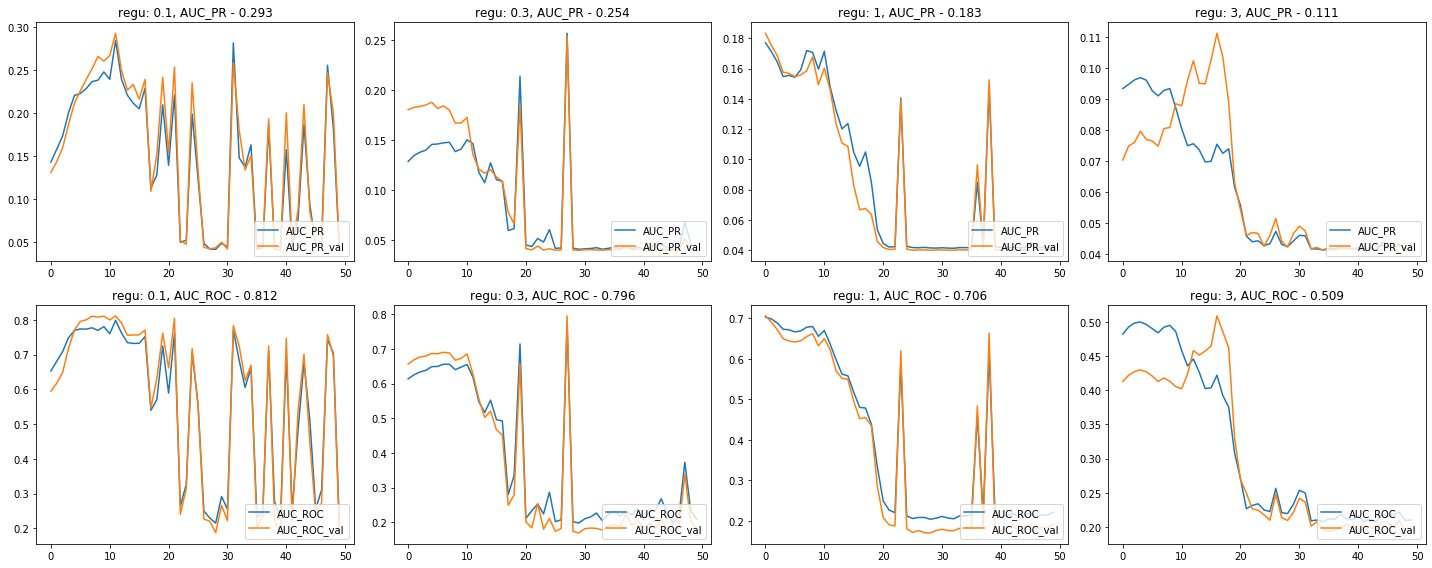

In [89]:
regularization = [0.1, 0.3, 1, 3]

fig, ax = plt.subplots(2, 4, figsize=(20,8))

seed(2020)
set_random_seed(2020)

for i, r in enumerate(regularization):
    ROCtest, PRtest, bestTrainProba, bestTestProba, history_model, model = net(
        X_train, X_valid, RFfeatures, units = [60,60], batchNorm = [False, False], epochs = 50, batchSize=350, debug=False,
    optimizer = "RMSprop", activation = ["tanh", "sigmoid"], dropout = [0, 0], regu = [r, r])
    
    historyDF = pd.DataFrame(list(history_model.values()))
    historyDF.drop("model_weights", axis= 1, inplace = True)
    
    print('{}, AUC_PR: {}'.format(r, PRtest))
    print('{}, AUC_ROC: {}'.format(r, ROCtest))
    print('-'*30)
    
    historyDF.loc[:, ["AUC_PR", "AUC_PR_val"]].plot(ax = ax[0,i])
    ax[0,i].set_title("regu: {}, AUC_PR - ".format(r) + str(round(PRtest, 3)))
    ax[0,i].legend(loc = 4)
    
    
    historyDF.loc[:, ["AUC_ROC", "AUC_ROC_val"]].plot(ax = ax[1,i])
    ax[1,i].set_title("regu: {}, AUC_ROC - ".format(r) + str(round(ROCtest, 3)))
    ax[1,i].legend(loc = 4)
    

plt.tight_layout()
plt.show()

Regularization bigger than 0.1 produces extremely unstable results it is definitely not proper value, lets dive deeper into 0.00x parameters. 

best model epoch: 32
0, AUC_PR: 0.334280318543466
0, AUC_ROC: 0.8302660753880265
------------------------------
best model epoch: 3
0.001, AUC_PR: 0.3146538611576474
0.001, AUC_ROC: 0.8280820399113082
------------------------------
best model epoch: 28
0.003, AUC_PR: 0.31257922634114765
0.003, AUC_ROC: 0.8267516629711751
------------------------------
best model epoch: 5
0.005, AUC_PR: 0.30858412304140337
0.005, AUC_ROC: 0.8223835920177384
------------------------------
best model epoch: 8
0.007, AUC_PR: 0.3127620792083665
0.007, AUC_ROC: 0.8192350332594235
------------------------------


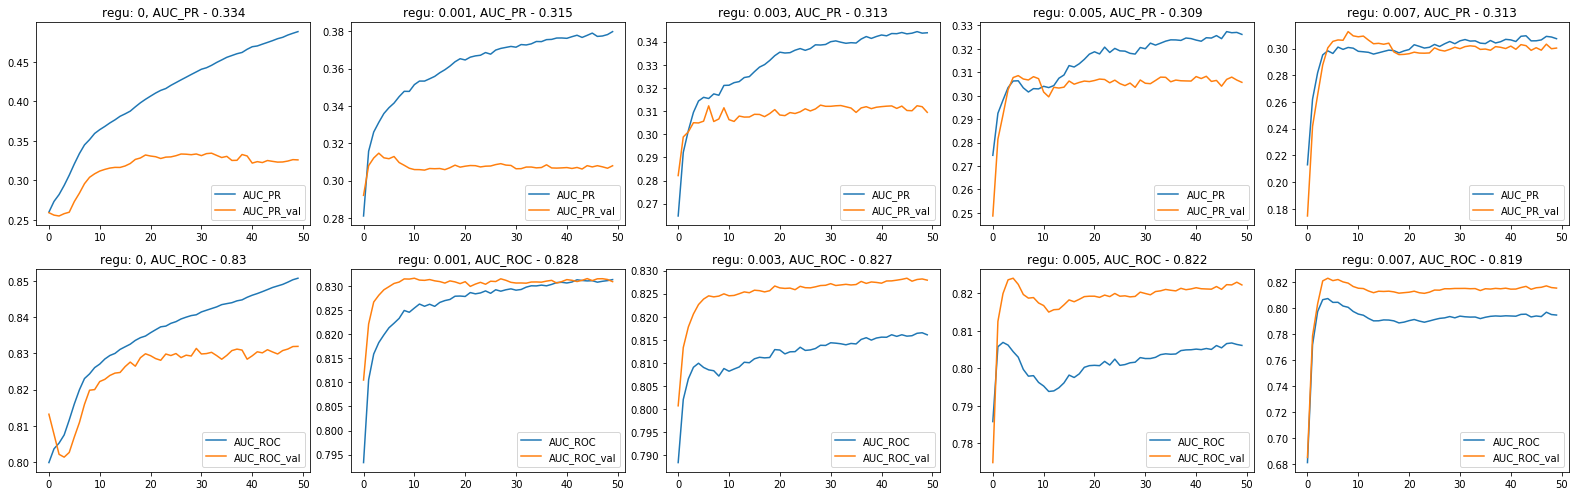

In [90]:
regularization = [0, 0.001, 0.003, 0.005, 0.007]

fig, ax = plt.subplots(2, 5, figsize=(22,7))

seed(2020)
set_random_seed(2020)

for i, r in enumerate(regularization):
    ROCtest, PRtest, bestTrainProba, bestTestProba, history_model, model = net(
        X_train, X_valid, RFfeatures, units = [60,60], batchNorm = [False, False], epochs = 50, batchSize=350, debug=False,
    optimizer = "RMSprop", activation = ["tanh", "sigmoid"], dropout = [0, 0], regu = [r, r])
    
    historyDF = pd.DataFrame(list(history_model.values()))
    historyDF.drop("model_weights", axis= 1, inplace = True)
    
    print('{}, AUC_PR: {}'.format(r, PRtest))
    print('{}, AUC_ROC: {}'.format(r, ROCtest))
    print('-'*30)
    
    historyDF.loc[:, ["AUC_PR", "AUC_PR_val"]].plot(ax = ax[0,i])
    ax[0,i].set_title("regu: {}, AUC_PR - ".format(r) + str(round(PRtest, 3)))
    ax[0,i].legend(loc = 4)
    
    
    historyDF.loc[:, ["AUC_ROC", "AUC_ROC_val"]].plot(ax = ax[1,i])
    ax[1,i].set_title("regu: {}, AUC_ROC - ".format(r) + str(round(ROCtest, 3)))
    ax[1,i].legend(loc = 4)
    

plt.tight_layout()
plt.show()

small regularization reduces overfitting very much, but it also reduces the performance,  0.001- 0.007 may be helpful in experimetns with different structures. Lets try regularization on not the all layers.

***** second layer regularization *****
best model epoch: 32
0, AUC_PR: 0.334280318543466
0, AUC_ROC: 0.8302660753880265
------------------------------
best model epoch: 49
0.001, AUC_PR: 0.35582098478238894
0.001, AUC_ROC: 0.8358758314855876
------------------------------
best model epoch: 49
0.003, AUC_PR: 0.33135212915388623
0.003, AUC_ROC: 0.8325942350332595
------------------------------
best model epoch: 49
0.005, AUC_PR: 0.33478498519621197
0.005, AUC_ROC: 0.8327827050997783
------------------------------
best model epoch: 46
0.007, AUC_PR: 0.339693482488373
0.007, AUC_ROC: 0.8342793791574279
------------------------------


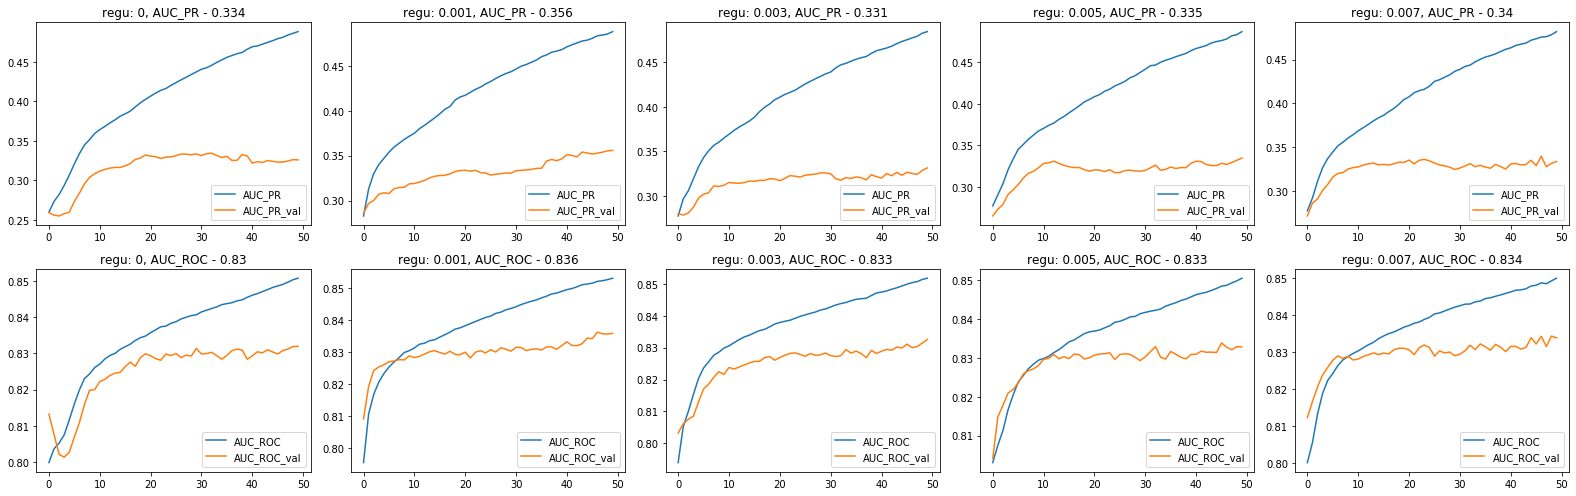

In [91]:
regularization = [0, 0.001, 0.003, 0.005, 0.007]

fig, ax = plt.subplots(2, 5, figsize=(22,7))

seed(2020)
set_random_seed(2020)
print("***** second layer regularization *****")
for i, r in enumerate(regularization):
    ROCtest, PRtest, bestTrainProba, bestTestProba, history_model, model = net(
        X_train, X_valid, RFfeatures, units = [60,60], batchNorm = [False, False], epochs = 50, batchSize=350, debug=False,
    optimizer = "RMSprop", activation = ["tanh", "sigmoid"], dropout = [0, 0], regu = [0, r])
    
    historyDF = pd.DataFrame(list(history_model.values()))
    historyDF.drop("model_weights", axis= 1, inplace = True)
    
    print('{}, AUC_PR: {}'.format(r, PRtest))
    print('{}, AUC_ROC: {}'.format(r, ROCtest))
    print('-'*30)
    
    historyDF.loc[:, ["AUC_PR", "AUC_PR_val"]].plot(ax = ax[0,i])
    ax[0,i].set_title("regu: {}, AUC_PR - ".format(r) + str(round(PRtest, 3)))
    ax[0,i].legend(loc = 4)
    
    
    historyDF.loc[:, ["AUC_ROC", "AUC_ROC_val"]].plot(ax = ax[1,i])
    ax[1,i].set_title("regu: {}, AUC_ROC - ".format(r) + str(round(ROCtest, 3)))
    ax[1,i].legend(loc = 4)
    

plt.tight_layout()
plt.show()

***** first layer regularization *****
best model epoch: 32
0, AUC_PR: 0.334280318543466
0, AUC_ROC: 0.8302660753880265
------------------------------
best model epoch: 3
0.001, AUC_PR: 0.3146538611576474
0.001, AUC_ROC: 0.8280820399113082
------------------------------
best model epoch: 28
0.003, AUC_PR: 0.31257922634114765
0.003, AUC_ROC: 0.8267516629711751
------------------------------
best model epoch: 5
0.005, AUC_PR: 0.30858412304140337
0.005, AUC_ROC: 0.8223835920177384
------------------------------
best model epoch: 8
0.007, AUC_PR: 0.3127620792083665
0.007, AUC_ROC: 0.8192350332594235
------------------------------


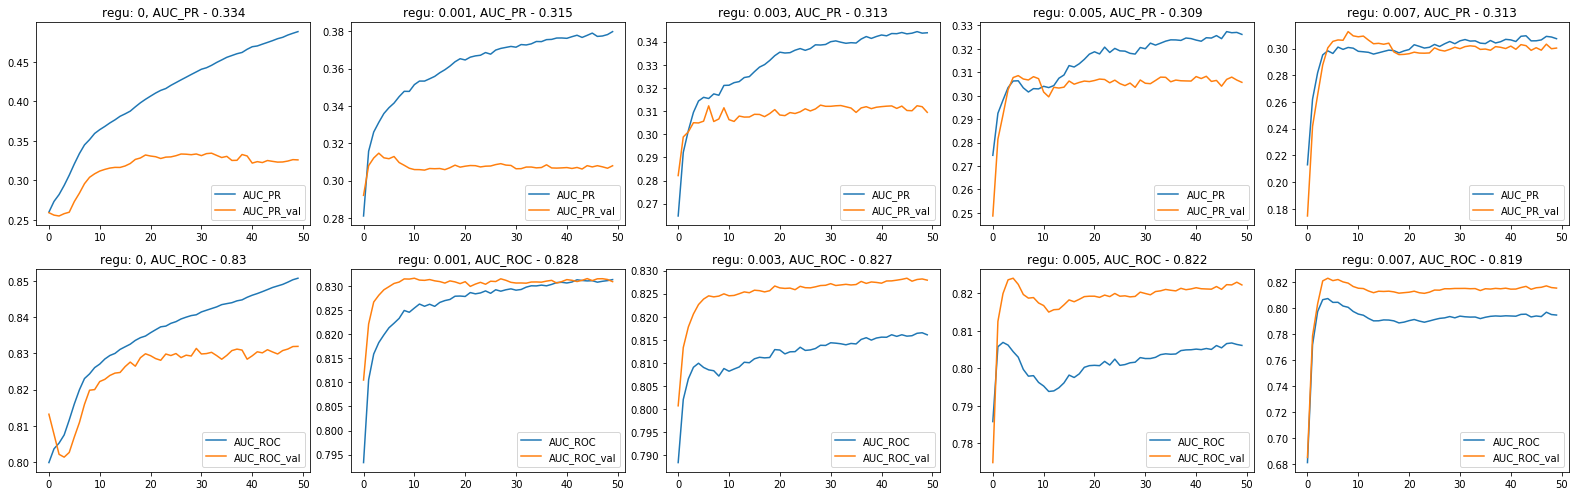

In [92]:
regularization = [0, 0.001, 0.003, 0.005, 0.007]

fig, ax = plt.subplots(2, 5, figsize=(22,7))

seed(2020)
set_random_seed(2020)
print("***** first layer regularization *****")
for i, r in enumerate(regularization):
    ROCtest, PRtest, bestTrainProba, bestTestProba, history_model, model = net(
        X_train, X_valid, RFfeatures, units = [60,60], batchNorm = [False, False], epochs = 50, batchSize=350, debug=False,
    optimizer = "RMSprop", activation = ["tanh", "sigmoid"], dropout = [0, 0], regu = [r, 0])
    
    historyDF = pd.DataFrame(list(history_model.values()))
    historyDF.drop("model_weights", axis= 1, inplace = True)
    
    print('{}, AUC_PR: {}'.format(r, PRtest))
    print('{}, AUC_ROC: {}'.format(r, ROCtest))
    print('-'*30)
    
    historyDF.loc[:, ["AUC_PR", "AUC_PR_val"]].plot(ax = ax[0,i])
    ax[0,i].set_title("regu: {}, AUC_PR - ".format(r) + str(round(PRtest, 3)))
    ax[0,i].legend(loc = 4)
    
    
    historyDF.loc[:, ["AUC_ROC", "AUC_ROC_val"]].plot(ax = ax[1,i])
    ax[1,i].set_title("regu: {}, AUC_ROC - ".format(r) + str(round(ROCtest, 3)))
    ax[1,i].legend(loc = 4)
    

plt.tight_layout()
plt.show()

It looks like regularization has stronger impact on model when applied in first layer, but when applied in second layer, small regularization can product better results than no regularization, maybe some dropout will help. First lets try dropout with no regularization on all layer, then only on the first and only on the second, then mix it with small regularization.
##### - Dropout

***** all layers dropout *****
best model epoch: 32
0, AUC_PR: 0.334280318543466
0, AUC_ROC: 0.8302660753880265
------------------------------
best model epoch: 47
0.2, AUC_PR: 0.31786646361342746
0.2, AUC_ROC: 0.826330376940133
------------------------------
best model epoch: 44
0.4, AUC_PR: 0.3334414663689159
0.4, AUC_ROC: 0.8302217294900223
------------------------------
best model epoch: 32
0.6, AUC_PR: 0.3310716564697843
0.6, AUC_ROC: 0.8275388026607539
------------------------------
best model epoch: 22
0.8, AUC_PR: 0.33401965222130797
0.8, AUC_ROC: 0.8276829268292683
------------------------------


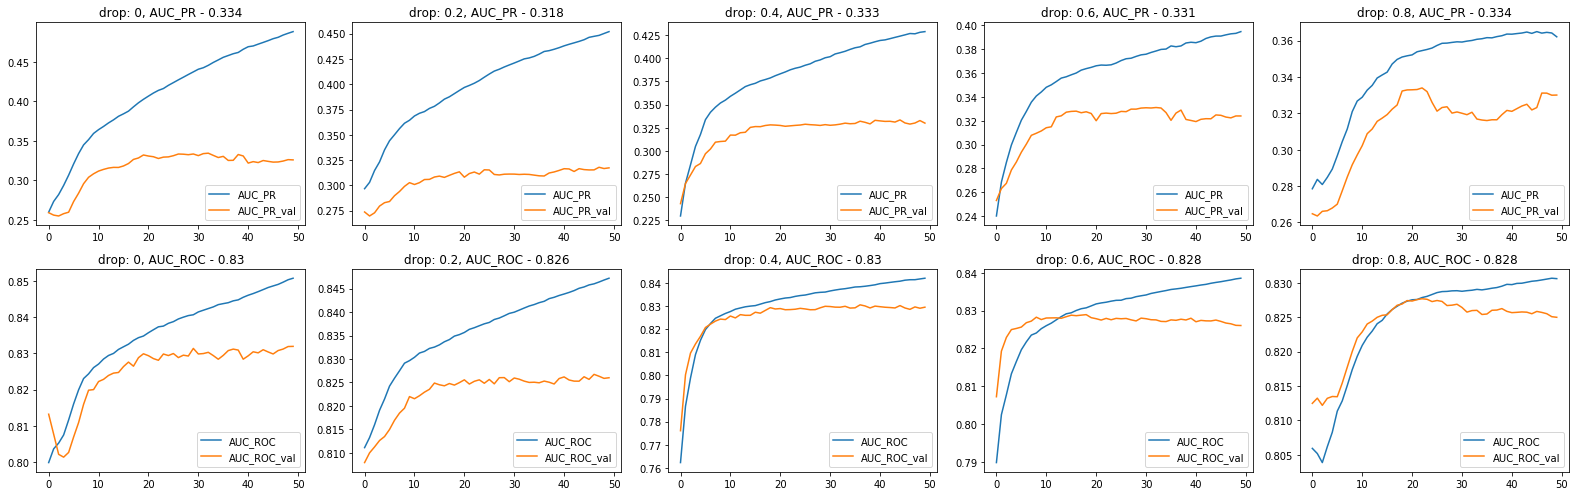

In [93]:
drop_rate = [0, 0.2, 0.4, 0.6, 0.8]

fig, ax = plt.subplots(2, 5, figsize=(22,7))

seed(2020)
set_random_seed(2020)
print("***** all layers dropout *****")
for i, d in enumerate(drop_rate):
    ROCtest, PRtest, bestTrainProba, bestTestProba, history_model, model = net(
        X_train, X_valid, RFfeatures, units = [60,60], batchNorm = [False, False], epochs = 50, batchSize=350, debug=False,
    optimizer = "RMSprop", activation = ["tanh", "sigmoid"], dropout = [d, d], regu = [0, 0])
    
    historyDF = pd.DataFrame(list(history_model.values()))
    historyDF.drop("model_weights", axis= 1, inplace = True)
    
    print('{}, AUC_PR: {}'.format(d, PRtest))
    print('{}, AUC_ROC: {}'.format(d, ROCtest))
    print('-'*30)
    
    historyDF.loc[:, ["AUC_PR", "AUC_PR_val"]].plot(ax = ax[0,i])
    ax[0,i].set_title("drop: {}, AUC_PR - ".format(d) + str(round(PRtest, 3)))
    ax[0,i].legend(loc = 4)
    
    
    historyDF.loc[:, ["AUC_ROC", "AUC_ROC_val"]].plot(ax = ax[1,i])
    ax[1,i].set_title("drop: {}, AUC_ROC - ".format(d) + str(round(ROCtest, 3)))
    ax[1,i].legend(loc = 4)
    

plt.tight_layout()
plt.show()

***** first layer dropout *****
best model epoch: 32
0, AUC_PR: 0.334280318543466
0, AUC_ROC: 0.8302660753880265
------------------------------
best model epoch: 47
0.2, AUC_PR: 0.3339481834219914
0.2, AUC_ROC: 0.8277494456762748
------------------------------
best model epoch: 15
0.4, AUC_PR: 0.33240771975620137
0.4, AUC_ROC: 0.8277050997782704
------------------------------
best model epoch: 39
0.6, AUC_PR: 0.3182590497172035
0.6, AUC_ROC: 0.8265631929046564
------------------------------
best model epoch: 12
0.8, AUC_PR: 0.3256989121218564
0.8, AUC_ROC: 0.8287583148558759
------------------------------


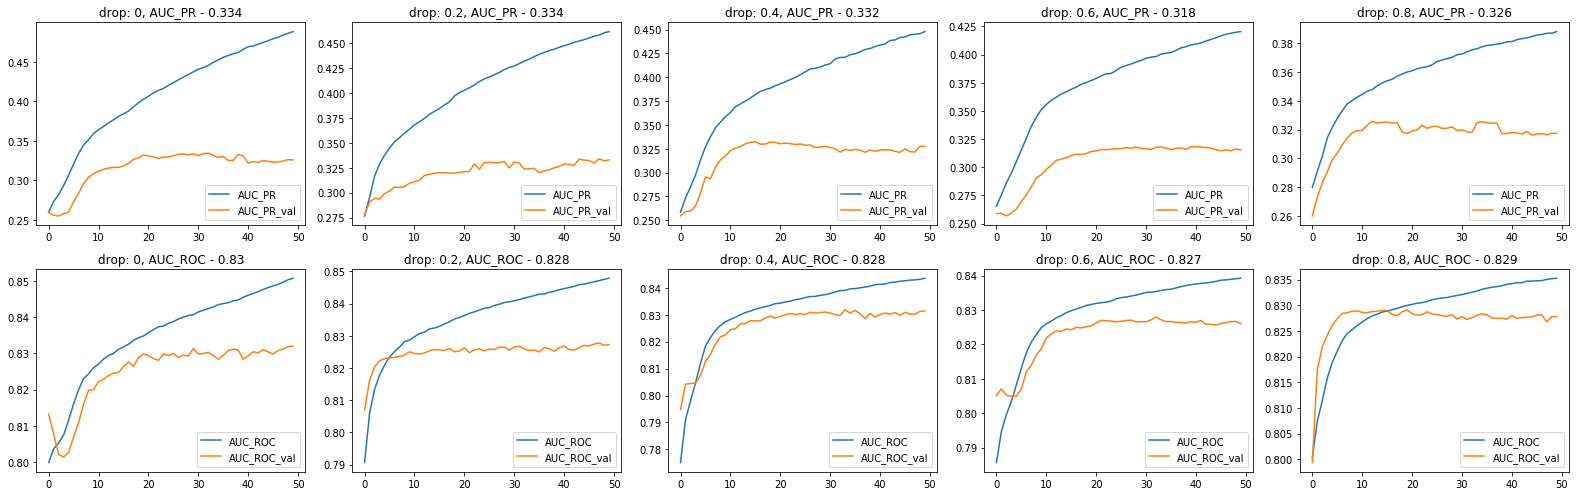

In [94]:
drop_rate = [0, 0.2, 0.4, 0.6, 0.8]

fig, ax = plt.subplots(2, 5, figsize=(22,7))

seed(2020)
set_random_seed(2020)
print("***** first layer dropout *****")
for i, d in enumerate(drop_rate):
    ROCtest, PRtest, bestTrainProba, bestTestProba, history_model, model = net(
        X_train, X_valid, RFfeatures, units = [60,60], batchNorm = [False, False], epochs = 50, batchSize=350, debug=False,
    optimizer = "RMSprop", activation = ["tanh", "sigmoid"], dropout = [d, 0], regu = [0, 0])
    
    historyDF = pd.DataFrame(list(history_model.values()))
    historyDF.drop("model_weights", axis= 1, inplace = True)
    
    print('{}, AUC_PR: {}'.format(d, PRtest))
    print('{}, AUC_ROC: {}'.format(d, ROCtest))
    print('-'*30)
    
    historyDF.loc[:, ["AUC_PR", "AUC_PR_val"]].plot(ax = ax[0,i])
    ax[0,i].set_title("drop: {}, AUC_PR - ".format(d) + str(round(PRtest, 3)))
    ax[0,i].legend(loc = 4)
    
    
    historyDF.loc[:, ["AUC_ROC", "AUC_ROC_val"]].plot(ax = ax[1,i])
    ax[1,i].set_title("drop: {}, AUC_ROC - ".format(d) + str(round(ROCtest, 3)))
    ax[1,i].legend(loc = 4)
    

plt.tight_layout()
plt.show()

***** second layer dropout *****
best model epoch: 32
0, AUC_PR: 0.334280318543466
0, AUC_ROC: 0.8302660753880265
------------------------------
best model epoch: 49
0.2, AUC_PR: 0.33921937989988304
0.2, AUC_ROC: 0.830509977827051
------------------------------
best model epoch: 49
0.4, AUC_PR: 0.32914603975565454
0.4, AUC_ROC: 0.8314634146341464
------------------------------
best model epoch: 34
0.6, AUC_PR: 0.3299229594248365
0.6, AUC_ROC: 0.8297339246119734
------------------------------
best model epoch: 34
0.8, AUC_PR: 0.33150292671217463
0.8, AUC_ROC: 0.8325942350332594
------------------------------


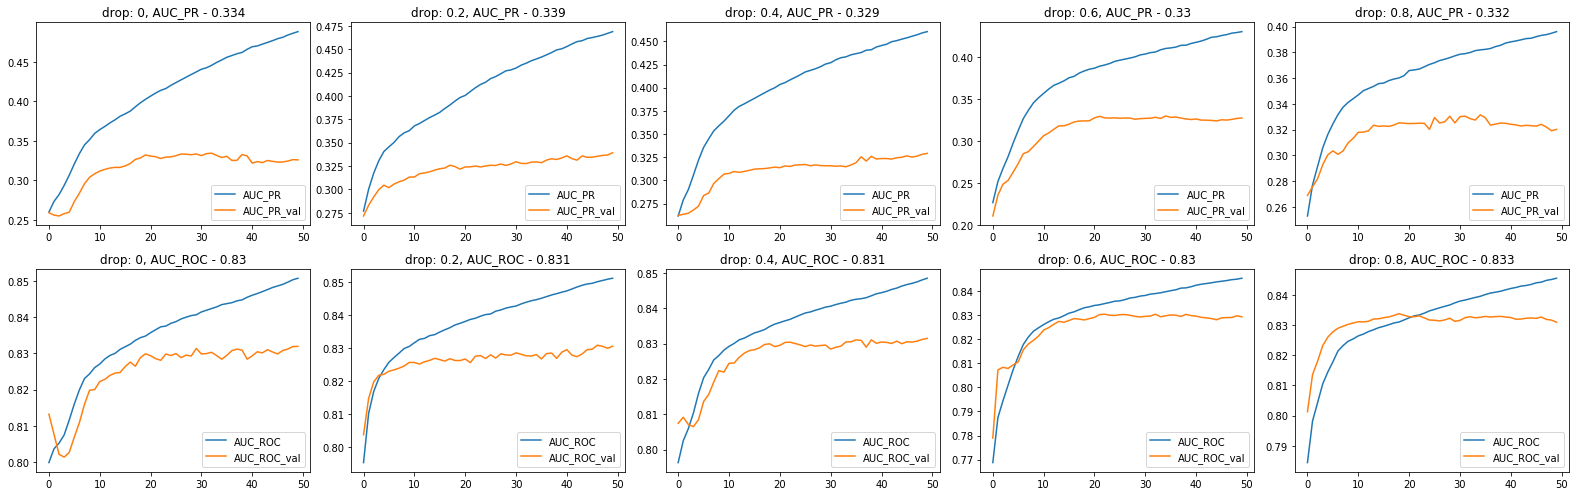

In [95]:
drop_rate = [0, 0.2, 0.4, 0.6, 0.8]

fig, ax = plt.subplots(2, 5, figsize=(22,7))

seed(2020)
set_random_seed(2020)
print("***** second layer dropout *****")
for i, d in enumerate(drop_rate):
    ROCtest, PRtest, bestTrainProba, bestTestProba, history_model, model = net(
        X_train, X_valid, RFfeatures, units = [60,60], batchNorm = [False, False], epochs = 50, batchSize=350, debug=False,
    optimizer = "RMSprop", activation = ["tanh", "sigmoid"], dropout = [0, d], regu = [0, 0])
    
    historyDF = pd.DataFrame(list(history_model.values()))
    historyDF.drop("model_weights", axis= 1, inplace = True)
    
    print('{}, AUC_PR: {}'.format(d, PRtest))
    print('{}, AUC_ROC: {}'.format(d, ROCtest))
    print('-'*30)
    
    historyDF.loc[:, ["AUC_PR", "AUC_PR_val"]].plot(ax = ax[0,i])
    ax[0,i].set_title("drop: {}, AUC_PR - ".format(d) + str(round(PRtest, 3)))
    ax[0,i].legend(loc = 4)
    
    
    historyDF.loc[:, ["AUC_ROC", "AUC_ROC_val"]].plot(ax = ax[1,i])
    ax[1,i].set_title("drop: {}, AUC_ROC - ".format(d) + str(round(ROCtest, 3)))
    ax[1,i].legend(loc = 4)
    

plt.tight_layout()
plt.show()

Dropout looks better when applied only in one layer with 0.2-0.6 probability. Lets try dropout on first and regularization on second and regularization on first with dropout on second.

***** first layer dropout, second layer 0.001 L2 *****
best model epoch: 32
0, AUC_PR: 0.334280318543466
0, AUC_ROC: 0.8302660753880265
------------------------------
best model epoch: 47
0.2, AUC_PR: 0.3339481834219914
0.2, AUC_ROC: 0.8277494456762748
------------------------------
best model epoch: 15
0.4, AUC_PR: 0.33240771975620137
0.4, AUC_ROC: 0.8277050997782704
------------------------------
best model epoch: 39
0.6, AUC_PR: 0.3182590497172035
0.6, AUC_ROC: 0.8265631929046564
------------------------------


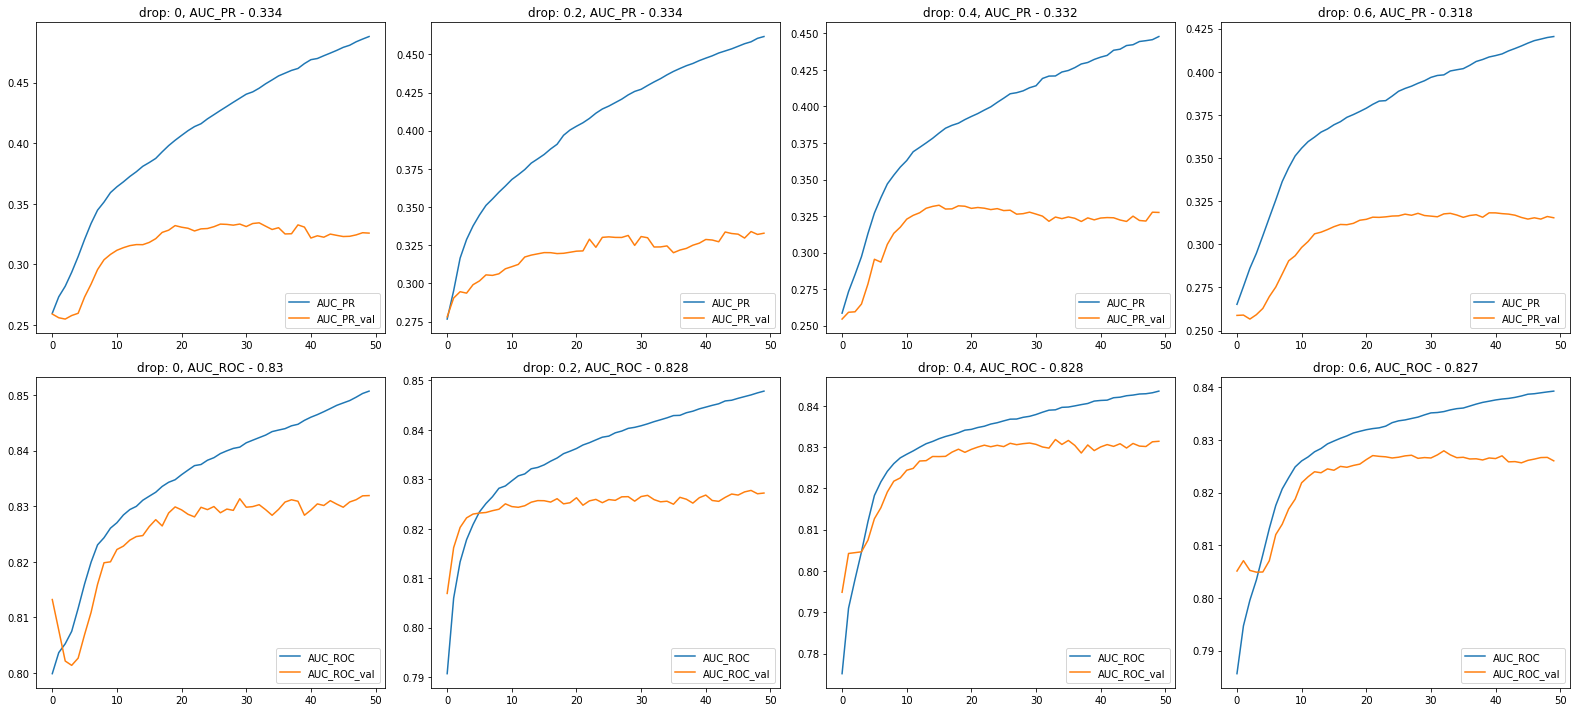

In [96]:
drop_rate = [0, 0.2, 0.4, 0.6]

fig, ax = plt.subplots(2, 4, figsize=(22,10))

seed(2020)
set_random_seed(2020)
print("***** first layer dropout, second layer 0.001 L2 *****")
for i, d in enumerate(drop_rate):
    ROCtest, PRtest, bestTrainProba, bestTestProba, history_model, model = net(
        X_train, X_valid, RFfeatures, units = [60,60], batchNorm = [False, False], epochs = 50, batchSize=350, debug=False,
    optimizer = "RMSprop", activation = ["tanh", "sigmoid"], dropout = [d, 0], regu = [0, 0.001])
    
    historyDF = pd.DataFrame(list(history_model.values()))
    historyDF.drop("model_weights", axis= 1, inplace = True)
    
    print('{}, AUC_PR: {}'.format(d, PRtest))
    print('{}, AUC_ROC: {}'.format(d, ROCtest))
    print('-'*30)
    
    historyDF.loc[:, ["AUC_PR", "AUC_PR_val"]].plot(ax = ax[0,i])
    ax[0,i].set_title("drop: {}, AUC_PR - ".format(d) + str(round(PRtest, 3)))
    ax[0,i].legend(loc = 4)
    
    
    historyDF.loc[:, ["AUC_ROC", "AUC_ROC_val"]].plot(ax = ax[1,i])
    ax[1,i].set_title("drop: {}, AUC_ROC - ".format(d) + str(round(ROCtest, 3)))
    ax[1,i].legend(loc = 4)
    

plt.tight_layout()
plt.show()

***** second layer dropout, first layer 0.001 L2 *****
best model epoch: 15
0, AUC_PR: 0.31128121325730573
0, AUC_ROC: 0.8302660753880265
------------------------------
best model epoch: 6
0.2, AUC_PR: 0.3133368911650445
0.2, AUC_ROC: 0.827549889135255
------------------------------
best model epoch: 48
0.4, AUC_PR: 0.31165696548962213
0.4, AUC_ROC: 0.8310088691796008
------------------------------
best model epoch: 21
0.6, AUC_PR: 0.318831802975219
0.6, AUC_ROC: 0.8313414634146341
------------------------------


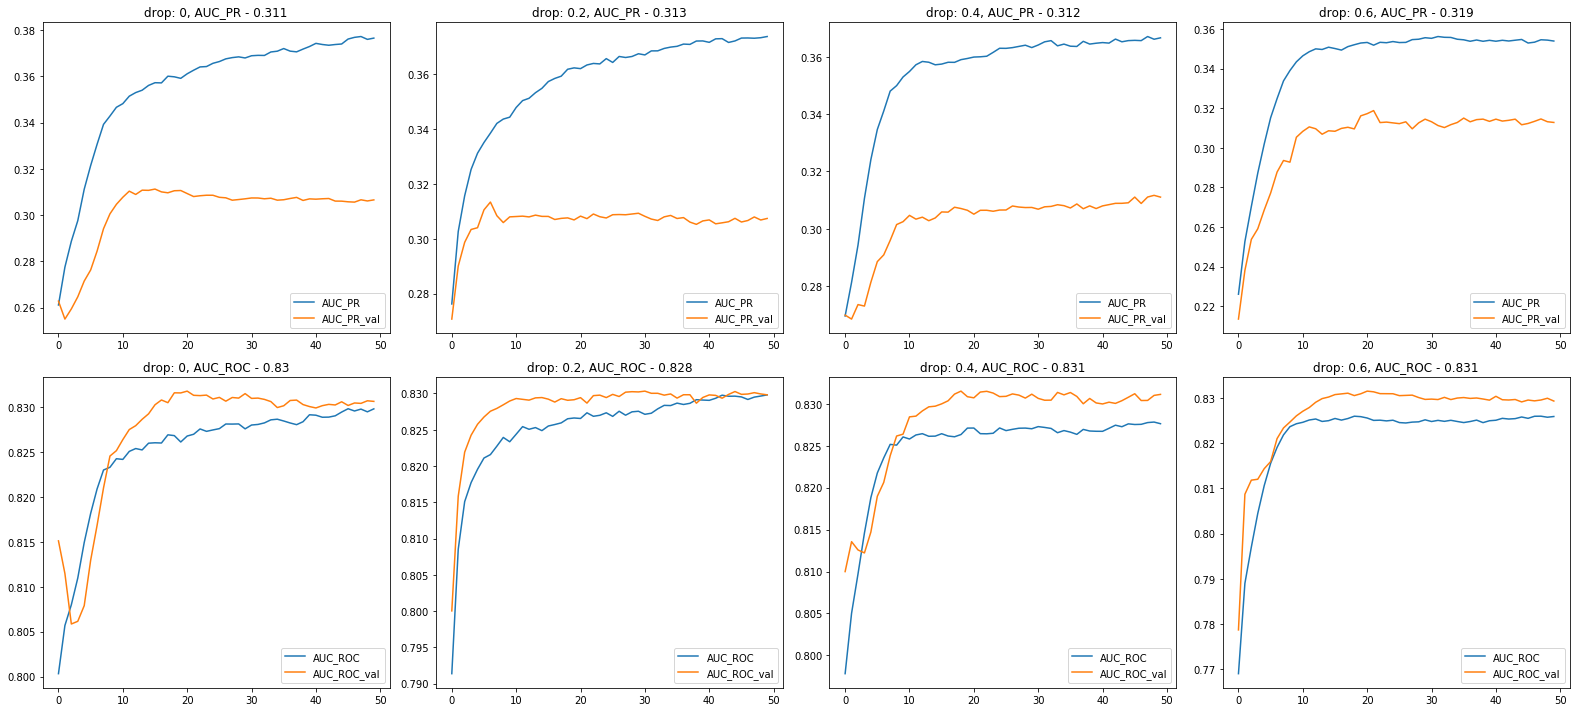

In [97]:
drop_rate = [0, 0.2, 0.4, 0.6]

fig, ax = plt.subplots(2, 4, figsize=(22,10))

seed(2020)
set_random_seed(2020)
print("***** second layer dropout, first layer 0.001 L2 *****")
for i, d in enumerate(drop_rate):
    ROCtest, PRtest, bestTrainProba, bestTestProba, history_model, model = net(
        X_train, X_valid, RFfeatures, units = [60,60], batchNorm = [False, False], epochs = 50, batchSize=350, debug=False,
    optimizer = "RMSprop", activation = ["tanh", "sigmoid"], dropout = [0, d], regu = [0.001, 0])
    
    historyDF = pd.DataFrame(list(history_model.values()))
    historyDF.drop("model_weights", axis= 1, inplace = True)
    
    print('{}, AUC_PR: {}'.format(d, PRtest))
    print('{}, AUC_ROC: {}'.format(d, ROCtest))
    print('-'*30)
    
    historyDF.loc[:, ["AUC_PR", "AUC_PR_val"]].plot(ax = ax[0,i])
    ax[0,i].set_title("drop: {}, AUC_PR - ".format(d) + str(round(PRtest, 3)))
    ax[0,i].legend(loc = 4)
    
    
    historyDF.loc[:, ["AUC_ROC", "AUC_ROC_val"]].plot(ax = ax[1,i])
    ax[1,i].set_title("drop: {}, AUC_ROC - ".format(d) + str(round(ROCtest, 3)))
    ax[1,i].legend(loc = 4)
    

plt.tight_layout()
plt.show()

Dropout near 0.4 outperforms regularization and mixes.

***** all layers dropout, first layer L2 0.001 *****
best model epoch: 15
0, AUC_PR: 0.31128121325730573
0, AUC_ROC: 0.8302660753880265
------------------------------
best model epoch: 36
0.2, AUC_PR: 0.3079628418342824
0.2, AUC_ROC: 0.8300000000000001
------------------------------
best model epoch: 13
0.4, AUC_PR: 0.31859649494660647
0.4, AUC_ROC: 0.8297339246119735
------------------------------
best model epoch: 14
0.6, AUC_PR: 0.32075577252380666
0.6, AUC_ROC: 0.8306541019955654
------------------------------
best model epoch: 19
0.8, AUC_PR: 0.32199629809579794
0.8, AUC_ROC: 0.8321618625277161
------------------------------


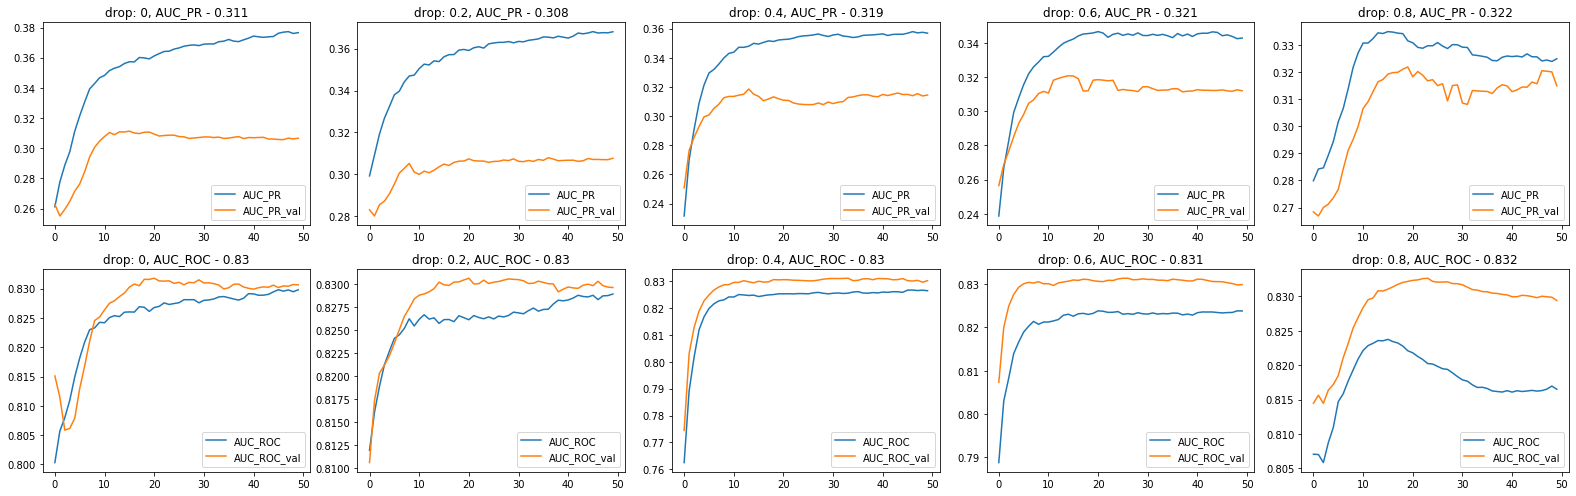

In [98]:
drop_rate = [0, 0.2, 0.4, 0.6, 0.8]

fig, ax = plt.subplots(2, 5, figsize=(22,7))

seed(2020)
set_random_seed(2020)
print("***** all layers dropout, first layer L2 0.001 *****")
for i, d in enumerate(drop_rate):
    ROCtest, PRtest, bestTrainProba, bestTestProba, history_model, model = net(
        X_train, X_valid, RFfeatures, units = [60,60], batchNorm = [False, False], epochs = 50, batchSize=350, debug=False,
    optimizer = "RMSprop", activation = ["tanh", "sigmoid"], dropout = [d, d], regu = [0.001, 0])
    
    historyDF = pd.DataFrame(list(history_model.values()))
    historyDF.drop("model_weights", axis= 1, inplace = True)
    
    print('{}, AUC_PR: {}'.format(d, PRtest))
    print('{}, AUC_ROC: {}'.format(d, ROCtest))
    print('-'*30)
    
    historyDF.loc[:, ["AUC_PR", "AUC_PR_val"]].plot(ax = ax[0,i])
    ax[0,i].set_title("drop: {}, AUC_PR - ".format(d) + str(round(PRtest, 3)))
    ax[0,i].legend(loc = 4)
    
    
    historyDF.loc[:, ["AUC_ROC", "AUC_ROC_val"]].plot(ax = ax[1,i])
    ax[1,i].set_title("drop: {}, AUC_ROC - ".format(d) + str(round(ROCtest, 3)))
    ax[1,i].legend(loc = 4)
    

plt.tight_layout()
plt.show()

***** all layers dropout second layer L2 0.001 *****
best model epoch: 32
0, AUC_PR: 0.334280318543466
0, AUC_ROC: 0.8302660753880265
------------------------------
best model epoch: 47
0.2, AUC_PR: 0.31786646361342746
0.2, AUC_ROC: 0.826330376940133
------------------------------
best model epoch: 44
0.4, AUC_PR: 0.3334414663689159
0.4, AUC_ROC: 0.8302217294900223
------------------------------
best model epoch: 32
0.6, AUC_PR: 0.3310716564697843
0.6, AUC_ROC: 0.8275388026607539
------------------------------
best model epoch: 22
0.8, AUC_PR: 0.33401965222130797
0.8, AUC_ROC: 0.8276829268292683
------------------------------


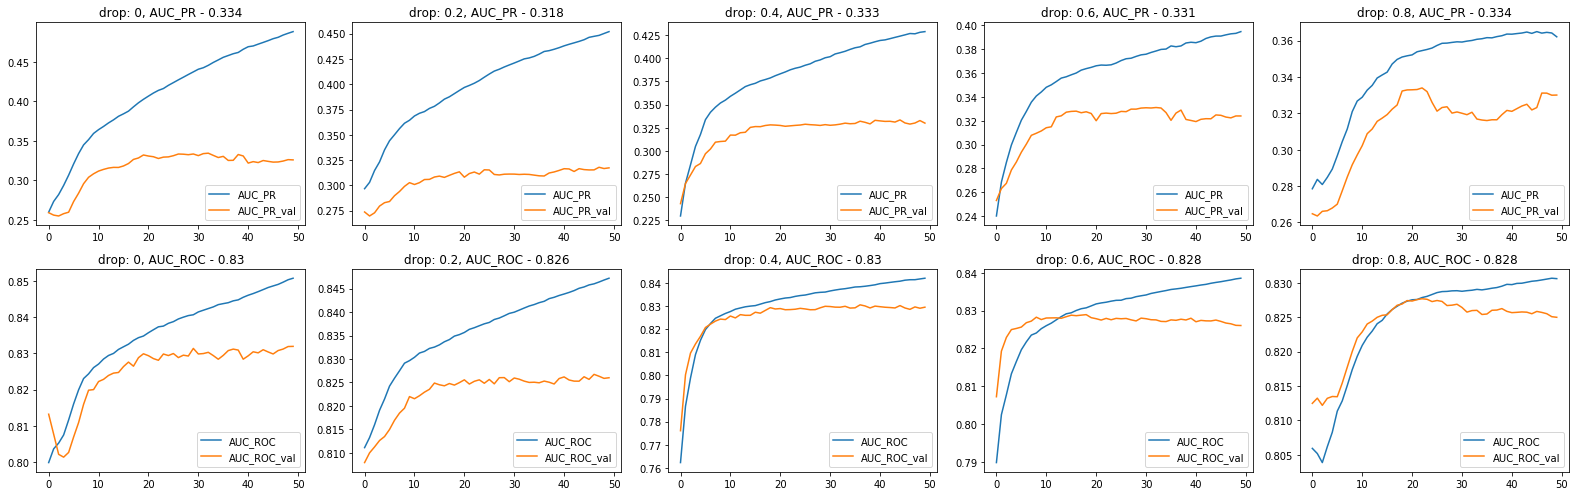

In [99]:
drop_rate = [0, 0.2, 0.4, 0.6, 0.8]

fig, ax = plt.subplots(2, 5, figsize=(22,7))

seed(2020)
set_random_seed(2020)
print("***** all layers dropout second layer L2 0.001 *****")
for i, d in enumerate(drop_rate):
    ROCtest, PRtest, bestTrainProba, bestTestProba, history_model, model = net(
        X_train, X_valid, RFfeatures, units = [60,60], batchNorm = [False, False], epochs = 50, batchSize=350, debug=False,
    optimizer = "RMSprop", activation = ["tanh", "sigmoid"], dropout = [d, d], regu = [0, 0.001])
    
    historyDF = pd.DataFrame(list(history_model.values()))
    historyDF.drop("model_weights", axis= 1, inplace = True)
    
    print('{}, AUC_PR: {}'.format(d, PRtest))
    print('{}, AUC_ROC: {}'.format(d, ROCtest))
    print('-'*30)
    
    historyDF.loc[:, ["AUC_PR", "AUC_PR_val"]].plot(ax = ax[0,i])
    ax[0,i].set_title("drop: {}, AUC_PR - ".format(d) + str(round(PRtest, 3)))
    ax[0,i].legend(loc = 4)
    
    
    historyDF.loc[:, ["AUC_ROC", "AUC_ROC_val"]].plot(ax = ax[1,i])
    ax[1,i].set_title("drop: {}, AUC_ROC - ".format(d) + str(round(ROCtest, 3)))
    ax[1,i].legend(loc = 4)
    

plt.tight_layout()
plt.show()

***** all layers dropout and L2 0.001 *****
best model epoch: 15
0, AUC_PR: 0.31128121325730573
0, AUC_ROC: 0.8302660753880265
------------------------------
best model epoch: 36
0.2, AUC_PR: 0.3079628418342824
0.2, AUC_ROC: 0.8300000000000001
------------------------------
best model epoch: 13
0.4, AUC_PR: 0.31859649494660647
0.4, AUC_ROC: 0.8297339246119735
------------------------------
best model epoch: 14
0.6, AUC_PR: 0.32075577252380666
0.6, AUC_ROC: 0.8306541019955654
------------------------------
best model epoch: 19
0.8, AUC_PR: 0.32199629809579794
0.8, AUC_ROC: 0.8321618625277161
------------------------------


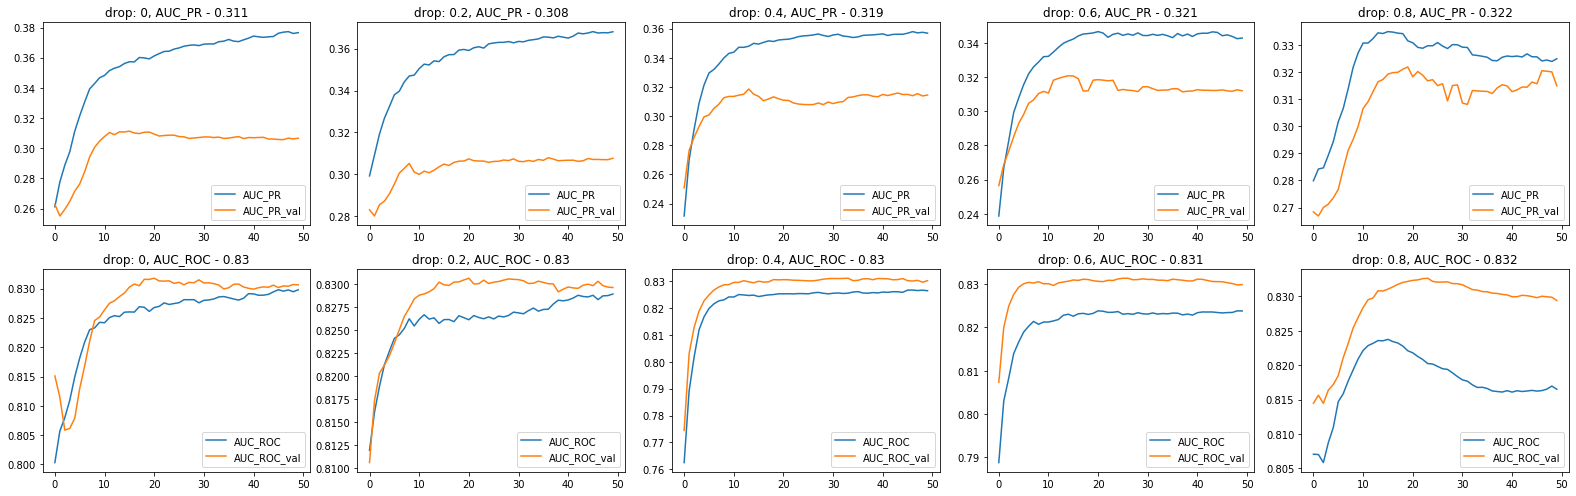

In [100]:
drop_rate = [0, 0.2, 0.4, 0.6, 0.8]

fig, ax = plt.subplots(2, 5, figsize=(22,7))

seed(2020)
set_random_seed(2020)
print("***** all layers dropout and L2 0.001 *****")
for i, d in enumerate(drop_rate):
    ROCtest, PRtest, bestTrainProba, bestTestProba, history_model, model = net(
        X_train, X_valid, RFfeatures, units = [60,60], batchNorm = [False, False], epochs = 50, batchSize=350, debug=False,
    optimizer = "RMSprop", activation = ["tanh", "sigmoid"], dropout = [d, d], regu = [0.001, 0.001])
    
    historyDF = pd.DataFrame(list(history_model.values()))
    historyDF.drop("model_weights", axis= 1, inplace = True)
    
    print('{}, AUC_PR: {}'.format(d, PRtest))
    print('{}, AUC_ROC: {}'.format(d, ROCtest))
    print('-'*30)
    
    historyDF.loc[:, ["AUC_PR", "AUC_PR_val"]].plot(ax = ax[0,i])
    ax[0,i].set_title("drop: {}, AUC_PR - ".format(d) + str(round(PRtest, 3)))
    ax[0,i].legend(loc = 4)
    
    
    historyDF.loc[:, ["AUC_ROC", "AUC_ROC_val"]].plot(ax = ax[1,i])
    ax[1,i].set_title("drop: {}, AUC_ROC - ".format(d) + str(round(ROCtest, 3)))
    ax[1,i].legend(loc = 4)
    

plt.tight_layout()
plt.show()

Best results with dropout 0-0.4 it is also ok to add small regularization (0.001) to any combination of layers.<br>
Lets check the model behavoir when third layer is added.
##### - Third layer

best model epoch: 49
10, AUC_PR: 0.33263407645445175
10, AUC_ROC: 0.8247450110864746
------------------------------
best model epoch: 47
20, AUC_PR: 0.32848610313676596
20, AUC_ROC: 0.8239024390243902
------------------------------
best model epoch: 8
40, AUC_PR: 0.32950916733594654
40, AUC_ROC: 0.8313636363636365
------------------------------
best model epoch: 20
60, AUC_PR: 0.3358004212460325
60, AUC_ROC: 0.8279933481152992
------------------------------
best model epoch: 39
80, AUC_PR: 0.3404213558415076
80, AUC_ROC: 0.8250332594235034
------------------------------


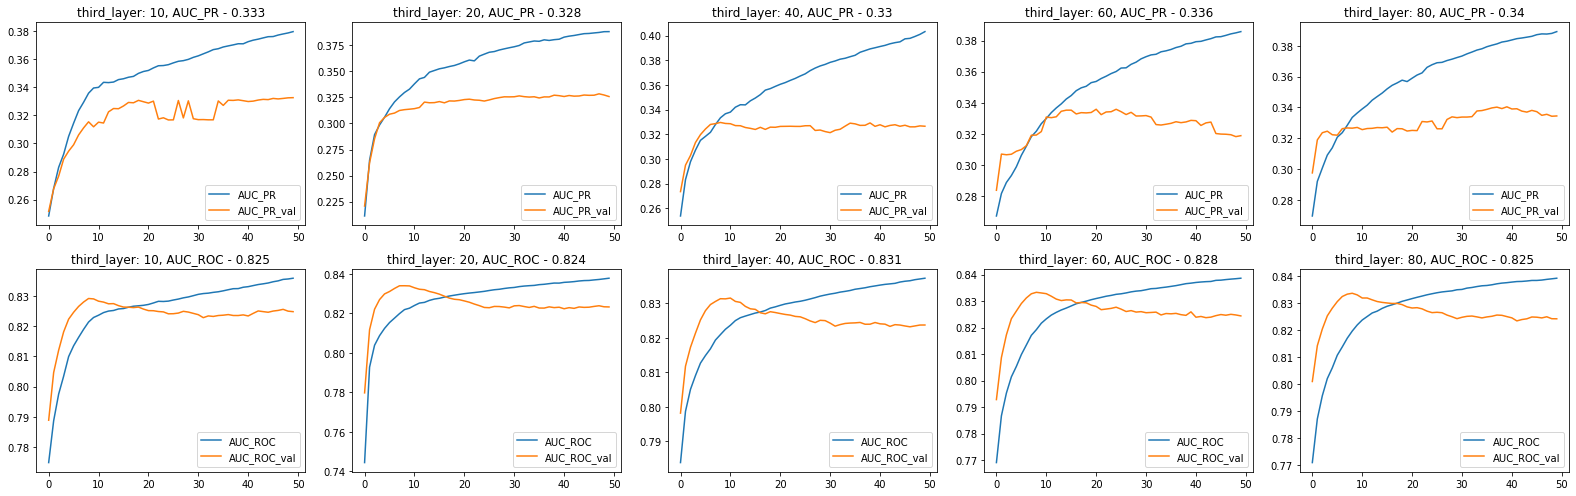

In [101]:
fig, ax = plt.subplots(2, 5, figsize=(22,7))
third_layer = [10, 20, 40, 60, 80]

seed(2020)
set_random_seed(2020)

for i, tl in enumerate(third_layer):
    ROCtest, PRtest, bestTrainProba, bestTestProba, history_model, model = net(
        X_train, X_valid, RFfeatures, units = [60,60, tl], batchNorm = [False, False, False], epochs = 50,
        batchSize=350, debug=False, optimizer = "RMSprop", activation = ["tanh", "sigmoid", "sigmoid"],
        dropout = [0.4, 0.4, 0.4])
    
    historyDF = pd.DataFrame(list(history_model.values()))
    historyDF.drop("model_weights", axis= 1, inplace = True)
    
    print('{}, AUC_PR: {}'.format(tl, PRtest))
    print('{}, AUC_ROC: {}'.format(tl, ROCtest))
    print('-'*30)
    
    historyDF.loc[:, ["AUC_PR", "AUC_PR_val"]].plot(ax = ax[0,i])
    ax[0,i].set_title("third_layer: {}, AUC_PR - ".format(tl) + str(round(PRtest, 3)))
    ax[0,i].legend(loc = 4)
    
    
    historyDF.loc[:, ["AUC_ROC", "AUC_ROC_val"]].plot(ax = ax[1,i])
    ax[1,i].set_title("third_layer: {}, AUC_ROC - ".format(tl) + str(round(ROCtest, 3)))
    ax[1,i].legend(loc = 4)
    

plt.tight_layout()
plt.show()

Adding third isn't a good idea, validation set history looks worse than 2 layer network. This NN has also a pretty big core (60, 60) so it looks a pretty good aproximation of many fuctions.
##### - different archiitectures

best model epoch: 38
(60, 40), AUC_PR: 0.3323153802923131
(60, 40), AUC_ROC: 0.8291352549889134
time: 18.99 seconds
------------------------------
best model epoch: 38
(40, 60), AUC_PR: 0.3228363076482918
(40, 60), AUC_ROC: 0.828170731707317
time: 19.08 seconds
------------------------------
best model epoch: 42
(40, 20), AUC_PR: 0.31651745861720737
(40, 20), AUC_ROC: 0.8283037694013303
time: 17.28 seconds
------------------------------
best model epoch: 2
(20, 40), AUC_PR: 0.3363242433748759
(20, 40), AUC_ROC: 0.8236917960088691
time: 17.27 seconds
------------------------------
best model epoch: 46
(40, 10), AUC_PR: 0.3300694585611713
(40, 10), AUC_ROC: 0.8231374722838136
time: 17.3 seconds
------------------------------
best model epoch: 48
(10, 50), AUC_PR: 0.31770808790689703
(10, 50), AUC_ROC: 0.8249334811529934
time: 17.64 seconds
------------------------------


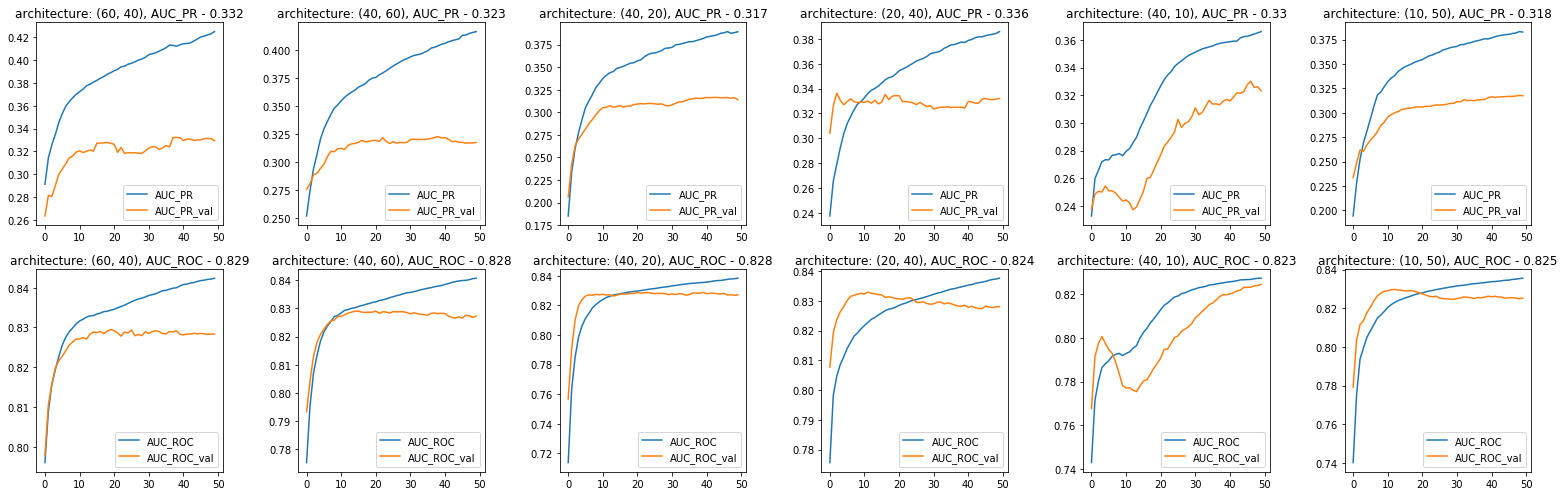

In [102]:
fig, ax = plt.subplots(2, 6, figsize=(22,7))
layers = [(60, 40), (40,60), (40,20), (20,40), (40,10), (10,50)]

seed(2020)
set_random_seed(2020)

for i, units in enumerate(layers):
    start = time.time()
    ROCtest, PRtest, bestTrainProba, bestTestProba, history_model, model = net(
        X_train, X_valid, RFfeatures, units = [units[0], units[1]], batchNorm = [False, False], epochs = 50,
        batchSize=350, debug=False, optimizer = "RMSprop", activation = ["tanh", "sigmoid"],
        dropout = [0.4, 0.4])
    stop = time.time()
    historyDF = pd.DataFrame(list(history_model.values()))
    historyDF.drop("model_weights", axis= 1, inplace = True)
    
    print('{}, AUC_PR: {}'.format(units, PRtest))
    print('{}, AUC_ROC: {}'.format(units, ROCtest))
    print("time: {} seconds".format(round(stop-start, 2)))
    print('-'*30)
    
    historyDF.loc[:, ["AUC_PR", "AUC_PR_val"]].plot(ax = ax[0,i])
    ax[0,i].set_title("architecture: {}, AUC_PR - ".format(units) + str(round(PRtest, 3)))
    ax[0,i].legend(loc = 4)
    
    
    historyDF.loc[:, ["AUC_ROC", "AUC_ROC_val"]].plot(ax = ax[1,i])
    ax[1,i].set_title("architecture: {}, AUC_ROC - ".format(units) + str(round(ROCtest, 3)))
    ax[1,i].legend(loc = 4)
    

plt.tight_layout()
plt.show()

best model epoch: 15
(120, 120), AUC_PR: 0.3270003747864055
(120, 120), AUC_ROC: 0.8312416851441242
time: 22.31 seconds
------------------------------
best model epoch: 48
(120, 60), AUC_PR: 0.3409253785402211
(120, 60), AUC_ROC: 0.8309756097560975
time: 21.12 seconds
------------------------------
best model epoch: 14
(60, 120), AUC_PR: 0.32900599909344636
(60, 120), AUC_ROC: 0.826840354767184
time: 21.2 seconds
------------------------------
best model epoch: 17
(100, 50), AUC_PR: 0.3270891338709712
(100, 50), AUC_ROC: 0.8301108647450112
time: 20.76 seconds
------------------------------
best model epoch: 37
(60, 30), AUC_PR: 0.3252030303796744
(60, 30), AUC_ROC: 0.8274057649667407
time: 18.97 seconds
------------------------------


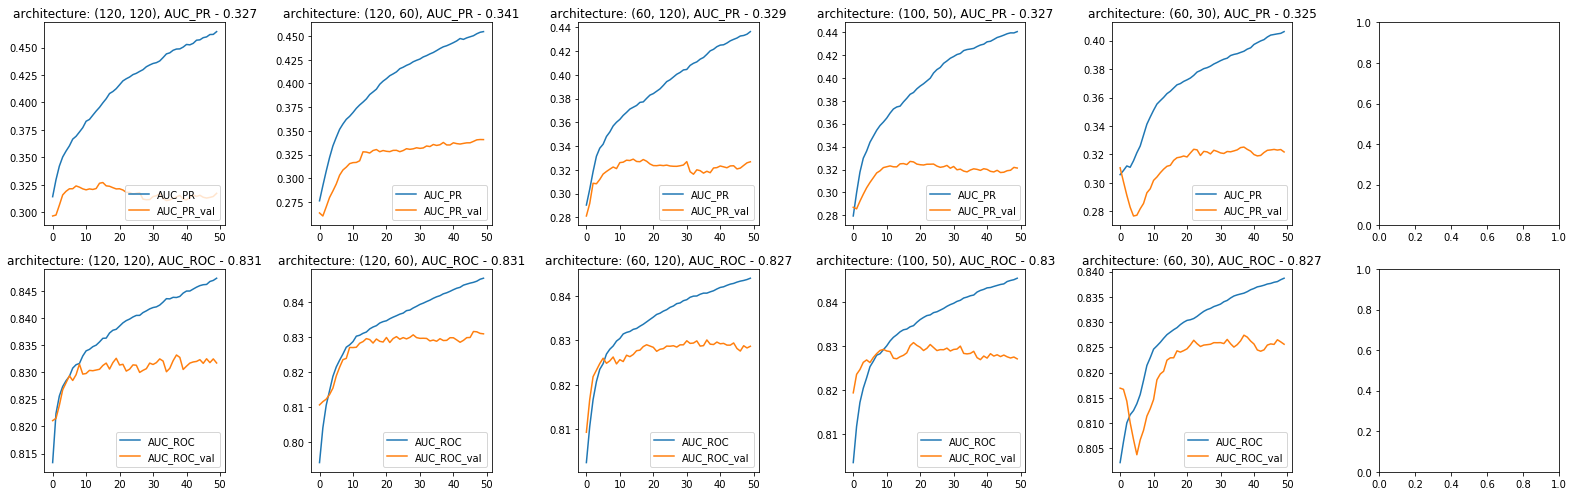

In [103]:
fig, ax = plt.subplots(2, 6, figsize=(22,7))
layers = [(120, 120), (120, 60), (60,120), (100,50), (60,30)]

seed(2020)
set_random_seed(2020)

for i, units in enumerate(layers):
    start = time.time()
    ROCtest, PRtest, bestTrainProba, bestTestProba, history_model, model = net(
        X_train, X_valid, RFfeatures, units = [units[0], units[1]], batchNorm = [False, False], epochs = 50,
        batchSize=350, debug=False, optimizer = "RMSprop", activation = ["tanh", "sigmoid"],
        dropout = [0.4, 0.4])
    stop = time.time()
    historyDF = pd.DataFrame(list(history_model.values()))
    historyDF.drop("model_weights", axis= 1, inplace = True)
    
    print('{}, AUC_PR: {}'.format(units, PRtest))
    print('{}, AUC_ROC: {}'.format(units, ROCtest))
    print("time: {} seconds".format(round(stop-start, 2)))
    print('-'*30)
    
    historyDF.loc[:, ["AUC_PR", "AUC_PR_val"]].plot(ax = ax[0,i])
    ax[0,i].set_title("architecture: {}, AUC_PR - ".format(units) + str(round(PRtest, 3)))
    ax[0,i].legend(loc = 4)
    
    
    historyDF.loc[:, ["AUC_ROC", "AUC_ROC_val"]].plot(ax = ax[1,i])
    ax[1,i].set_title("architecture: {}, AUC_ROC - ".format(units) + str(round(ROCtest, 3)))
    ax[1,i].legend(loc = 4)
    

plt.tight_layout()
plt.show()

NN architecture isn't a game changer, simple 60,60 NN was enough, maybe PCA can produce better result. Lets try some batch normalization before.
##### -  Batch normalization

best model epoch: 26
(False, False), AUC_PR: 0.3261249460213197
(False, False), AUC_ROC: 0.8272062084257207
------------------------------
best model epoch: 16
(False, True), AUC_PR: 0.31684873767675753
(False, True), AUC_ROC: 0.8290133037694014
------------------------------
best model epoch: 49
(True, False), AUC_PR: 0.3234206512425436
(True, False), AUC_ROC: 0.8244013303769402
------------------------------
best model epoch: 12
(True, True), AUC_PR: 0.32982023158253293
(True, True), AUC_ROC: 0.8333481152993347
------------------------------


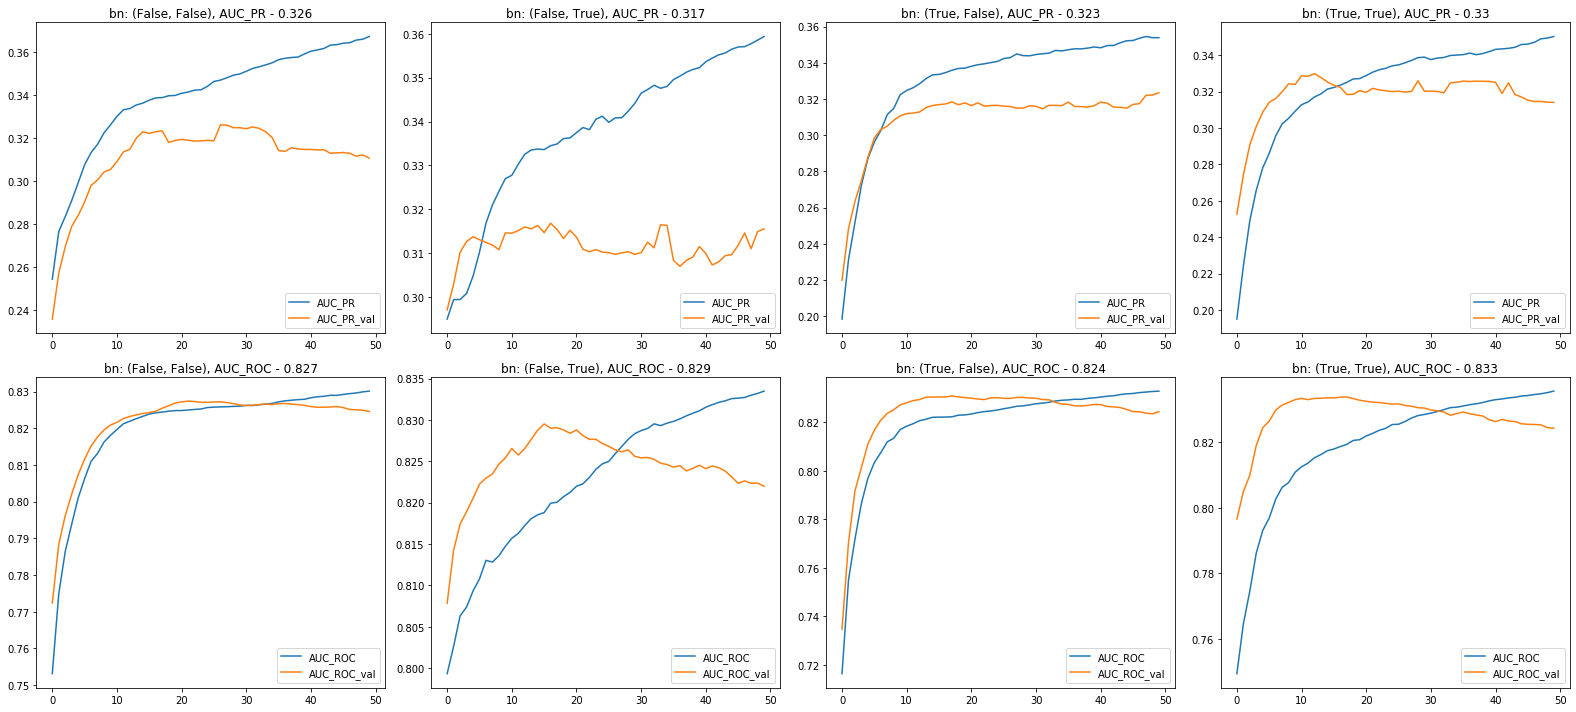

In [104]:
batch_norm = [(False, False), (False, True), (True, False), (True, True)]

fig, ax = plt.subplots(2, 4, figsize=(22,10))

seed(2020)
set_random_seed(2020)

for i, bn in enumerate(batch_norm):
    ROCtest, PRtest, bestTrainProba, bestTestProba, history_model, model = net(
        X_train, X_valid, RFfeatures, units = [60,60], batchNorm = [bn[0], bn[1]], epochs = 50, batchSize=350, debug=False,
    optimizer = "RMSprop", activation = ["tanh", "sigmoid"], dropout = [d, d], regu = [0, 0])
    
    historyDF = pd.DataFrame(list(history_model.values()))
    historyDF.drop("model_weights", axis= 1, inplace = True)
    
    print('{}, AUC_PR: {}'.format(bn, PRtest))
    print('{}, AUC_ROC: {}'.format(bn, ROCtest))
    print('-'*30)
    
    historyDF.loc[:, ["AUC_PR", "AUC_PR_val"]].plot(ax = ax[0,i])
    ax[0,i].set_title("bn: {}, AUC_PR - ".format(bn) + str(round(PRtest, 3)))
    ax[0,i].legend(loc = 4)
    
    
    historyDF.loc[:, ["AUC_ROC", "AUC_ROC_val"]].plot(ax = ax[1,i])
    ax[1,i].set_title("bn: {}, AUC_ROC - ".format(bn) + str(round(ROCtest, 3)))
    ax[1,i].legend(loc = 4)
    

plt.tight_layout()
plt.show()

no reason for use batch normalization here
##### Neural network Cross validation

In [105]:
def CVTestNN(df = RFdata, nFolds = 5, randomState=2020, features=RFfeatures, target = target, debug=False, *args, **kwargs):
    '''
    Neural Network Startified n-Fold Cross Validation wrapper, computes model, statiscitcs, predictions and saves
    indices and history for each fold, arguments:
    df - dataframe to analyze,
    nFolds - number of fold in CV,
    randomState - seed for algorithms,
    features - independent variables,
    target - dependent variable,
    debug - additional info
    
    returns AIC-ROC train score, AUC-ROC test score, AUC-PR train score, AUC-PR test score, predictions, indices, history
    '''
    seed(randomState)
    set_random_seed(randomState)
    
    # Startified cross validation
    kf = StratifiedKFold(n_splits=nFolds, shuffle=True, random_state=randomState)

    # results list inicialization
    ROCtestResults = []
    ROCtrainResults = []
    PRtestResults = []
    PRtrainResults = []
    predictions = []
    indices = []
    
    # history inicialization
    hists = []
    
    fold = 1
    for train, test in kf.split(df.index.values, df[target]):
        # modelling
        ROCtest, PRtest, trainPred, testPred, history, _ = net(df.iloc[train], df.iloc[test], features,
                                                               target, debug = debug, *args, **kwargs)        
 
        # saving predictions with corresponding indices
        predictions.append(testPred.copy())
        indices.append(df.iloc[test].index.tolist().copy())
        
        # metrics computing
        ROCtrainScore = roc_auc_score(df[target].iloc[train], trainPred)
        PRtrainScore = average_precision_score(df[target].iloc[train], trainPred)
        
        # metrics saving
        ROCtrainResults.append(ROCtrainScore)
        ROCtestResults.append(ROCtest)
        PRtrainResults.append(PRtrainScore)
        PRtestResults.append(PRtest)
        
        # history saving
        hists.append(history)
        fold+=1
        
    return ROCtrainResults, ROCtestResults, PRtrainResults, PRtestResults, predictions, indices, hists

In [106]:
# first Naive model (naive because of all the data used in the learning process)
start = time.time()
ROCtrainResults, ROCtestResults, PRtrainResults, PRtestResults, predictions, indices, hists = CVTestNN(units = [60,60],
    batchNorm = [False, False], epochs = 50, batchSize=350, debug=False,
    optimizer = "RMSprop", activation = ["tanh", "sigmoid"], dropout = [0.4, 0.4], regu = [0, 0])
stop = time.time()

print('ROC: {}\nPR: {}\nROCtrain-test: {}\nPRtrain-test: {}'.format(
    np.mean(ROCtestResults),
    np.mean(PRtestResults), 
    np.mean(ROCtrainResults)-np.mean(ROCtestResults),
    np.mean(PRtrainResults)-np.mean(PRtestResults)))

print("time: {}".format(round(stop-start, 2)))

best model epoch: 49
best model epoch: 49
best model epoch: 46
best model epoch: 49
best model epoch: 47
ROC: 0.8188359201773835
PR: 0.3584247474992857
ROCtrain-test: 0.024569983370288262
PRtrain-test: 0.0578933092254717
time: 115.26


Looks like the model can learn more (best models find usually in the least epochs)
 - 100 epochs

In [107]:
start = time.time()
ROCtrainResults, ROCtestResults, PRtrainResults, PRtestResults, predictions, indices, hists = CVTestNN(units = [60,60],
    batchNorm = [False, False], epochs = 100, batchSize=350, debug=False,
    optimizer = "RMSprop", activation = ["tanh", "sigmoid"], dropout = [0.4, 0.4], regu = [0, 0])
stop = time.time()

print('ROC: {}\nPR: {}\nROCtrain-test: {}\nPRtrain-test: {}'.format(
    np.mean(ROCtestResults),
    np.mean(PRtestResults), 
    np.mean(ROCtrainResults)-np.mean(ROCtestResults),
    np.mean(PRtrainResults)-np.mean(PRtestResults)))
print("time: {}".format(round(stop-start, 2)))

best model epoch: 97
best model epoch: 52
best model epoch: 99
best model epoch: 98
best model epoch: 59
ROC: 0.822660753880266
PR: 0.37805425690572153
ROCtrain-test: 0.028138650221729455
PRtrain-test: 0.07380978680909084
time: 163.04


Better results, bigger overfitting but not too much, there is still a potential, try more,
 - 200 epochs

In [108]:
start = time.time()
ROCtrainResults, ROCtestResults, PRtrainResults, PRtestResults, predictions, indices, hists = CVTestNN(units = [60,60],
    batchNorm = [False, False], epochs = 200, batchSize=350, debug=False,
    optimizer = "RMSprop", activation = ["tanh", "sigmoid"], dropout = [0.4, 0.4], regu = [0, 0])
stop = time.time()

print('ROC: {}\nPR: {}\nROCtrain-test: {}\nPRtrain-test: {}'.format(
    np.mean(ROCtestResults),
    np.mean(PRtestResults), 
    np.mean(ROCtrainResults)-np.mean(ROCtestResults),
    np.mean(PRtrainResults)-np.mean(PRtestResults)))
print("time: {}".format(round(stop-start, 2)))

best model epoch: 159
best model epoch: 195
best model epoch: 190
best model epoch: 196
best model epoch: 188
ROC: 0.8327272727272728
PR: 0.41121361294953457
ROCtrain-test: 0.038610310421286154
PRtrain-test: 0.11990649420582883
time: 268.69


Huge boost in the performance, lest check more
 - 400 epochs

In [109]:
start = time.time()
ROCtrainResults, ROCtestResults, PRtrainResults, PRtestResults, predictions, indices, hists = CVTestNN(units = [60,60],
    batchNorm = [False, False], epochs = 400, batchSize=350, debug=False,
    optimizer = "RMSprop", activation = ["tanh", "sigmoid"], dropout = [0.4, 0.4], regu = [0, 0])
stop = time.time()

print('ROC: {}\nPR: {}\nROCtrain-test: {}\nPRtrain-test: {}'.format(
    np.mean(ROCtestResults),
    np.mean(PRtestResults), 
    np.mean(ROCtrainResults)-np.mean(ROCtestResults),
    np.mean(PRtrainResults)-np.mean(PRtestResults)))

print("time: {}".format(round(stop-start, 2)))

naive_NN = {
    "name":"Naive_NN_2",
    "description":"Naive NN model, on all the data",
    "specification":'[60, 60] layers, no batch norm, 400 epochs, 350 batch size, RMSprop optimizer, ["tanh", "sigmoid"] activations, dropout 0.4 on all layers, no regularization',
    "ROCtrainResults":ROCtrainResults.copy(),
    "ROCtestResults":ROCtestResults.copy(),
    "PRtrainResults":PRtrainResults.copy(),
    "PRtestResults":PRtestResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
    "variables":RFfeatures.copy()
}

save_naive_NN = False
if save_naive_NN:
    with open("naive_NN.p", "wb") as fp:
        pickle.dump(naive_NN, fp)

best model epoch: 159
best model epoch: 350
best model epoch: 399
best model epoch: 384
best model epoch: 388
ROC: 0.8393968957871396
PR: 0.43082707664197517
ROCtrain-test: 0.04470468403547667
PRtrain-test: 0.14408136486353162
time: 440.76


The performance gets colser to tree-based methods, but overfitting is much less, it is nice to see that NN can work well on this hard data

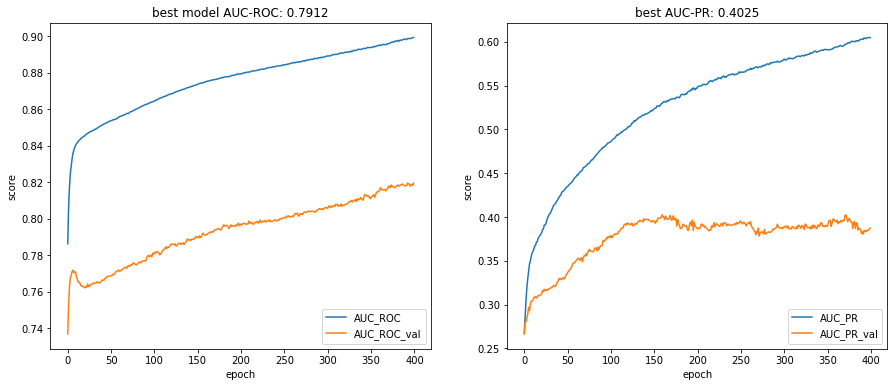

In [110]:
# history dict to df convert
a = 0
historyDF = pd.DataFrame(list(hists[a].values()))
historyDF.drop("model_weights", axis= 1, inplace = True)

f, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15,6))

historyDF.loc[:, ["AUC_ROC", "AUC_ROC_val"]].plot(ax = ax[0])
ax[0].set_title('best model AUC-ROC: {}'.format(round(ROCtestResults[a], 4)))
ax[0].legend(loc = 4)
ax[0].set_xlabel("epoch")
ax[0].set_ylabel("score")

historyDF.loc[:, ["AUC_PR", "AUC_PR_val"]].plot(ax = ax[1])
ax[1].set_title('best AUC-PR: {}'.format(round(PRtestResults[a], 4)))
ax[1].legend(loc = 4)
ax[1].set_xlabel("epoch")
ax[1].set_ylabel("score")
plt.show()

What is nice in NN, it has smaller overfitting than XGB (4 times on ROC, 8 times on PR) but preformance is much worse, ROC 7%, PR 14%. Nice property of this model is that has a pretty nice potential, increasing epochs causes much better results while XGB reaches its limit, of course it is still worse than XGB, but it has less overfittimg.  The data is very noisy, maybe PCA can help to get even better results with NN.<br>
For curiosity, lets check 3 layer 60-60-40 network in CV.

In [111]:
start = time.time()
ROCtrainResults, ROCtestResults, PRtrainResults, PRtestResults, predictions, indices, hists = CVTestNN(units = [60,60,40],
    batchNorm = [False, False, False], epochs = 400, batchSize=350, debug=False,
    optimizer = "RMSprop", activation = ["tanh", "tanh", "sigmoid"], dropout = [0.4, 0.4, 0], regu = [0, 0, 0.001])
stop = time.time()

print('ROC: {}\nPR: {}\nROCtrain-test: {}\nPRtrain-test: {}'.format(
    np.mean(ROCtestResults),
    np.mean(PRtestResults), 
    np.mean(ROCtrainResults)-np.mean(ROCtestResults),
    np.mean(PRtrainResults)-np.mean(PRtestResults)))
print("time: {}".format(round(stop-start, 2)))

naive_NN_02 = {
    "name":"Naive_NN_3",
    "description":"Naive NN model, on all the data",
    "specification":'[60, 60, 40] layers, no batch norm, 400 epochs, 350 batch size, RMSprop optimizer, ["tanh", "tanh", "sigmoid"] activations, dropout 0.4 on first two layers, 0.001 L2 regularization on third layer',
    "ROCtrainResults":ROCtrainResults.copy(),
    "ROCtestResults":ROCtestResults.copy(),
    "PRtrainResults":PRtrainResults.copy(),
    "PRtestResults":PRtestResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
    "variables":RFfeatures.copy()
}

save_naive_NN_02 = False
if save_naive_NN_02:
    with open("naive_NN_02.p", "wb") as fp:
        pickle.dump(naive_NN_02, fp)

best model epoch: 127
best model epoch: 383
best model epoch: 396
best model epoch: 380
best model epoch: 391
ROC: 0.8426962305986697
PR: 0.4397366542849472
ROCtrain-test: 0.05269318181818161
PRtrain-test: 0.17249719411722791
time: 511.88


bigger network -> better results, bigger overfitting but what is a surprise faster training.

### PCA 
######  - Data inspection

In [112]:
# import PCA
from sklearn.decomposition import PCA

In [113]:
# split for PCA
seed(2020)

test_size = 0.2
X_train, X_valid = train_test_split(RFdata, test_size=test_size, random_state=2020, stratify=RFdata[target].values)

In [114]:
# model
pca = PCA(n_components=len(RFfeatures))
# fit
pca_model = pca.fit(X_train[RFfeatures])
# transform data
X_train_pca = pca_model.transform(X_train[RFfeatures])
X_test_pca = pca_model.transform(X_valid[RFfeatures])
# save as DataFrame
X_train_pca_df = pd.DataFrame(X_train_pca, columns=["v_"+str(i+1) for i in range(len(RFfeatures))],
                              index = X_train.index.tolist())

X_test_pca_df = pd.DataFrame(X_test_pca, columns=X_train_pca_df.columns.tolist(),
                              index = X_valid.index.tolist())

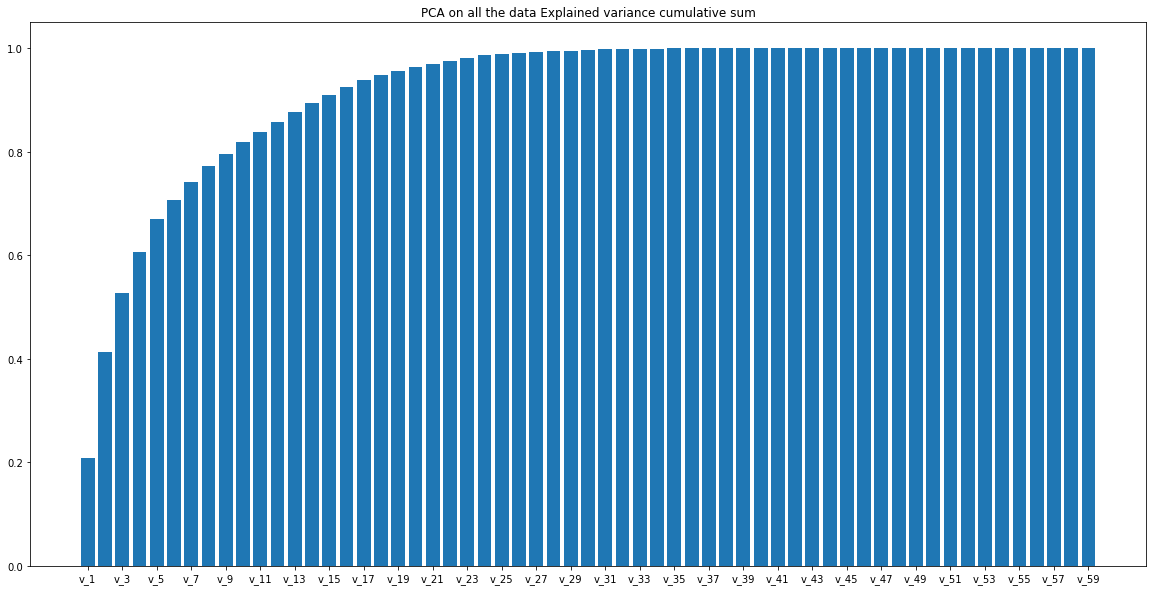

analytical values


array([0.20922357, 0.41286075, 0.52788776, 0.6069335 , 0.67066725,
       0.70736665, 0.74114067, 0.77203891, 0.79583619, 0.81872786,
       0.83843839, 0.8577314 , 0.87606648, 0.89363062, 0.91014069,
       0.92537438, 0.93767876, 0.94859311, 0.95666773, 0.96356443,
       0.97003436, 0.97566248, 0.98119953, 0.98592058, 0.98896747,
       0.99088007, 0.9926552 , 0.99407755, 0.99537221, 0.9964321 ,
       0.99747399, 0.99827115, 0.99880728, 0.99913339, 0.99938466,
       0.99952932, 0.99966014, 0.99974883, 0.99982442, 0.99985589,
       0.99988365, 0.9999076 , 0.99992812, 0.99994557, 0.9999581 ,
       0.99996952, 0.99997861, 0.99998475, 0.99999056, 0.99999398,
       0.99999713, 0.99999827, 0.99999906, 0.99999945, 0.99999973,
       1.        , 1.        , 1.        , 1.        ])

In [115]:
fig, ax = plt.subplots(figsize=(20, 10))

plt.bar(["v_"+str(i+1) for i in range(len(RFfeatures))], 
       np.cumsum(pca_model.explained_variance_ratio_))
plt.xticks([item for i, item in enumerate(X_train_pca_df.columns.tolist()) if i%2==0])
plt.title("PCA on all the data Explained variance cumulative sum")
plt.show()
print("analytical values")
display(np.cumsum(pca_model.explained_variance_ratio_))

19 components explain 95% of the dataset variance, 26 components explain 99% of dataset variance.

##### single spit pca full comparison

In [116]:
# data preparation
X_train_pca_df_full = pd.concat((X_train_pca_df, X_train[target]), axis = 1)
X_test_pca_df_full = pd.concat((X_test_pca_df, X_valid[target]), axis = 1)

best model epoch: 38
0, AUC_PR: 0.3307219486977889
0, AUC_ROC: 0.8288580931263857
time: 26.57 seconds
------------------------------
best model epoch: 49
1, AUC_PR: 0.3261111669541324
1, AUC_ROC: 0.8330266075388028
time: 27.2 seconds
------------------------------


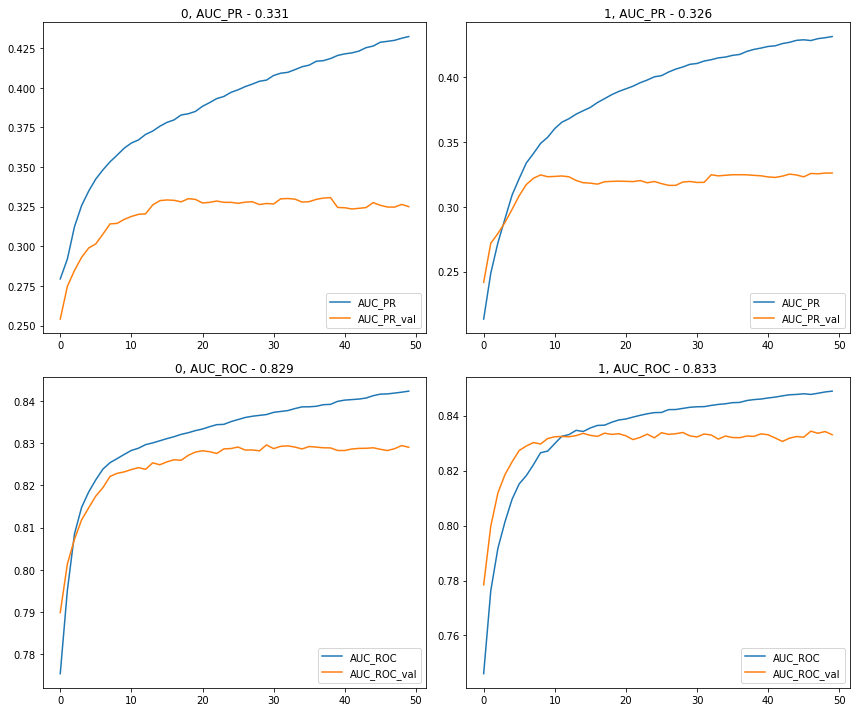

In [117]:
# datasets
data = [(X_train, X_valid), (X_train_pca_df_full, X_test_pca_df_full)]

fig, ax = plt.subplots(2, 2, figsize=(12,10))

seed(2020)
set_random_seed(2020)

for i, dta in enumerate(data):
    # features for current dataset
    loop_features = [i for i in dta[0] if i != target]
    
    start = time.time()
    # training
    ROCtest, PRtest, bestTrainProba, bestTestProba, history_model, model = net(
        dta[0], dta[1], loop_features, target, units = [60,60], batchNorm = [False, False], epochs = 50,
        batchSize=350, debug=False, optimizer = "RMSprop", activation = ["tanh", "sigmoid"], 
        dropout = [0.4, 0.4], regu = [0, 0])
    stop = time.time()
    
    # plotting
    historyDF = pd.DataFrame(list(history_model.values()))
    historyDF.drop("model_weights", axis= 1, inplace = True)
    
    print('{}, AUC_PR: {}'.format(i, PRtest))
    print('{}, AUC_ROC: {}'.format(i, ROCtest))
    print("time: {} seconds".format(round(stop-start, 2)))
    print('-'*30)
    
    historyDF.loc[:, ["AUC_PR", "AUC_PR_val"]].plot(ax = ax[0,i])
    ax[0,i].set_title("{}, AUC_PR - ".format(i) + str(round(PRtest, 3)))
    ax[0,i].legend(loc = 4)
    
    
    historyDF.loc[:, ["AUC_ROC", "AUC_ROC_val"]].plot(ax = ax[1,i])
    ax[1,i].set_title("{}, AUC_ROC - ".format(i) + str(round(ROCtest, 3)))
    ax[1,i].legend(loc = 4)
    

plt.tight_layout()
plt.show()

Interesting results, full PCA product slightly less overfitting, slightly better results on ROC and slightly worse results on PR, but has potential for more epochs, best model in 49th while normal features best model was trained during 38th epoch. There is a visible difference on single split, lets test it in CV!

##### PCA-NN wrapper

In [118]:
def CVTestNN_PCA(df = RFdata, nFolds = 5, randomState=2020, features=RFfeatures, target = target,
                 pca_groups = {"1":["Attr1", "Attr2"]}, keep_comp = {"1":2}, debug=False, *args, **kwargs):
    '''
    Principal Component Analysis preprocessing + Neural Network Startify K-Fold Cross Validation wrapper, arguments:
    df - data for training and testing (pd.DataFrame),
    nFolds - number of Startified folds in Cross Validation 1<nFolds<num_of_observations,
    randomState - pseudo random seed for algorithms,
    features - features, considered for modelling (list),
    target - target feature to predict, labels (binary task),
    pca_groups - dictionary, key - name of the group, value - group* (list)
        *group is a list of features to perform PCA transformation on it, they can not overlap,
    keep_comp - dictionary, key - name of the group, value - number of components to keep*
        *1<keep_comp<len(group) => number of components to keep,
        0<keep_comp<1 => explained variance based number of component automatic selection
    debug - additional information during Neural Network training
    
    return AUC-ROC train score, AUC-ROC test score, AUC-PR train score, AUC-PR test score, predictions, indices, history
    '''
    
    
    from sklearn.decomposition import PCA
    
    seed(randomState)
    set_random_seed(randomState)
    
    # Startified cross validation 
    kf = StratifiedKFold(n_splits=nFolds, shuffle=True, random_state=randomState)

    # results list inicialization
    ROCtestResults = []
    ROCtrainResults = []
    PRtestResults = []
    PRtrainResults = []
    predictions = []
    indices = []
    
    # history inicialization
    hists = []
    
    # all features to perform PCA on
    all_pca_features = []
    [all_pca_features.extend(i) for i in list(pca_groups.values())]
    ini_features = [i for i in features if i not in all_pca_features]
    
    
    fold = 1
    for train, test in kf.split(df.index.values, df[target]):
        
        # pca dataframe inicialization (contains all features excluded from PCA procedure)
        #     new inicialization for each fold 
        df_pca = df[ini_features].copy()
        
        # PCA loop
        for i in pca_groups.keys():            
            # features for current PCA (group)
            curr_feat = pca_groups[i]
            # pca model inicialization and fitting
            pca = PCA(n_components = keep_comp[i])
            pca_model = pca.fit(df.loc[train, curr_feat])
            # transform current data
            train_pca = pca_model.transform(df.loc[train, curr_feat])
            test_pca = pca_model.transform(df.loc[test, curr_feat])
            # save as dataframe
            train_pca_df = pd.DataFrame(train_pca.copy(), columns = [i+"_v_"+str(j+1) for j in range
                                                                     (pca_model.n_components_)],index = train.copy())
            test_pca_df = pd.DataFrame(test_pca.copy(), columns = train_pca_df.columns.tolist(),
                                      index = test.copy())
            
            # concat train_pca_df and test_pca_df data and sort index (preparation for concat with df_pca)
            df_pca_train_test = pd.concat((train_pca_df,test_pca_df)).sort_index()
            # append new features to the df_pca
            df_pca = pd.concat((df_pca, df_pca_train_test), axis = 1)
        
        # add target 
        df_pca = pd.concat((df_pca, df[target]), axis = 1)
        
        
        # features for training
        training_features = df_pca.columns.tolist()
        training_features.remove(target)
        # modelling
        ROCtest, PRtest, trainPred, testPred, history, _ = net(df_pca.iloc[train], df_pca.iloc[test],
                                                               training_features,
                                                               target, debug = debug, *args, **kwargs)        
 

        # saving predictions with corresponding indices
        predictions.append(testPred.copy())
        indices.append(df_pca.iloc[test].index.tolist().copy())
        
        # metrics computing
        ROCtrainScore = roc_auc_score(df_pca.loc[train, target], trainPred)
        PRtrainScore = average_precision_score(df_pca.loc[train, target], trainPred)
        
        # metrics saving
        ROCtrainResults.append(ROCtrainScore)
        ROCtestResults.append(ROCtest)
        PRtrainResults.append(PRtrainScore)
        PRtestResults.append(PRtest)
        
        # history saving
        hists.append(history)
        fold+=1
        
    return ROCtrainResults, ROCtestResults, PRtrainResults, PRtestResults, predictions, indices, hists

In [119]:
seed(2020)
set_random_seed(2020)

start = time.time()
ROCtrainResults, ROCtestResults, PRtrainResults, PRtestResults, predictions, indices, hists = CVTestNN_PCA(units = [60,60],
    batchNorm = [False, False], epochs = 50, batchSize=350, debug=False,
    optimizer = "RMSprop", activation = ["tanh", "sigmoid"], dropout = [0.4, 0.4], regu = [0, 0],
    pca_groups= {"1": RFfeatures}, keep_comp={"1":len(RFfeatures)})
stop = time.time()
print('ROC: {}\nPR: {}\nROCtrain-test: {}\nPRtrain-test: {}'.format(
    np.mean(ROCtestResults),
    np.mean(PRtestResults), 
    np.mean(ROCtrainResults)-np.mean(ROCtestResults),
    np.mean(PRtrainResults)-np.mean(PRtestResults)))
print("time: {}".format(round(stop-start, 2)))

best model epoch: 48
best model epoch: 39
best model epoch: 36
best model epoch: 49
best model epoch: 44
ROC: 0.8217538802660755
PR: 0.3618564506003902
ROCtrain-test: 0.025244456762749334
PRtrain-test: 0.05273127188752735
time: 140.5


In CV conclusions are different, full PCA NN model has slightly better ROC (0.3%), slightly better PR (0.3%), slightly bigger overfitting on ROC (0.1%) and slightly lower overfitting on PR (0.5%). This is a naive approach, PCA was applied to all the data and all the components were used, maybe PCA applied on unnecessary or highly correlated features can give better results, in fact, this dataset has some very good features, and some bad.

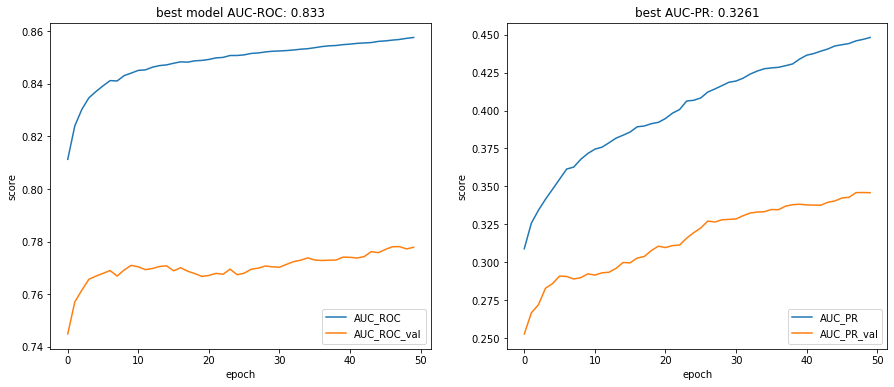

In [120]:
# history dict to df convert
historyDF = pd.DataFrame(list(hists[0].values()))
historyDF.drop("model_weights", axis= 1, inplace = True)

f, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15,6))

historyDF.loc[:, ["AUC_ROC", "AUC_ROC_val"]].plot(ax = ax[0])
ax[0].set_title('best model AUC-ROC: {}'.format(round(ROCtest, 4)))
ax[0].legend(loc = 4)
ax[0].set_xlabel("epoch")
ax[0].set_ylabel("score")

historyDF.loc[:, ["AUC_PR", "AUC_PR_val"]].plot(ax = ax[1])
ax[1].set_title('best AUC-PR: {}'.format(round(PRtest, 4)))
ax[1].legend(loc = 4)
ax[1].set_xlabel("epoch")
ax[1].set_ylabel("score")
plt.show()

##### Feature importance analysis
Analysis starts from the bottom of the importance df, consider feature and its correlations from dictionary, stops at index 37. Features with index >=37 seem to be ok looking by metrics. There are no hard rules, the worst by RF features are grouped with the correlated (and also bad) ones. Main metric is RF feature importance score, the second is Mutual Information (lower than 3 is considered as potential poor predictior), other metrics are for help in harder cases. Some notes are below.

In [121]:
high_correl_dict

{'Attr1': ['Attr7',
  'Attr11',
  'Attr12',
  'Attr14',
  'Attr16',
  'Attr18',
  'Attr19',
  'Attr22',
  'Attr23',
  'Attr26',
  'Attr31'],
 'Attr2': ['Attr8',
  'Attr10',
  'Attr17',
  'Attr25',
  'Attr38',
  'Attr50',
  'Attr51'],
 'Attr3': ['Attr4', 'Attr28', 'Attr46', 'Attr50', 'Attr53', 'Attr54'],
 'Attr4': ['Attr5', 'Attr46', 'Attr50'],
 'Attr5': ['Attr46'],
 'Attr7': ['Attr11',
  'Attr12',
  'Attr14',
  'Attr16',
  'Attr18',
  'Attr19',
  'Attr22',
  'Attr23',
  'Attr26',
  'Attr31',
  'Attr48'],
 'Attr8': ['Attr10', 'Attr17', 'Attr25', 'Attr38', 'Attr50', 'Attr51'],
 'Attr10': ['Attr17', 'Attr38', 'Attr50', 'Attr51'],
 'Attr11': ['Attr12',
  'Attr14',
  'Attr18',
  'Attr19',
  'Attr22',
  'Attr23',
  'Attr31',
  'Attr48'],
 'Attr12': ['Attr13',
  'Attr14',
  'Attr16',
  'Attr18',
  'Attr19',
  'Attr23',
  'Attr26',
  'Attr31'],
 'Attr13': ['Attr16', 'Attr19', 'Attr23', 'Attr26', 'Attr31'],
 'Attr14': ['Attr16',
  'Attr18',
  'Attr19',
  'Attr22',
  'Attr23',
  'Attr26',
  'Att

In [122]:
print("Max folds_avg: {}\t\tmin folds_avg: {}\nmax Mutual Information: {}\tmin Mutual Information: {}\nmax Spearman: {}\t\t\
min Spearman: {}".format(round(importance_df["folds_avg"].max(),4), round(importance_df["folds_avg"].min(),4),
                        round(importance_df["Mutual information"].max(),4),
                         round(importance_df["Mutual information"].min(),4),
                        round(importance_df["Spearman"].max(),4), 
                        round(importance_df["Spearman"].min(),4))) 
importance_df

Max folds_avg: 0.1107		min folds_avg: 0.0021
max Mutual Information: 0.0524	min Mutual Information: 0.0
max Spearman: 0.1892		min Spearman: -0.2582


feature  folds_avg  Mutual information  Spearman  p_value (Spearman)  \
0   Attr39   0.110696            0.052424 -0.254034              0.0000   
1   Attr35   0.105906            0.052228 -0.246185              0.0000   
2   Attr46   0.088159            0.034207 -0.218417              0.0000   
3   Attr41   0.069118            0.050847 -0.157024              0.0000   
4   Attr24   0.056876            0.035016 -0.184936              0.0000   
5   Attr22   0.046790            0.049779 -0.218669              0.0000   
6   Attr56   0.040585            0.034291 -0.196624              0.0000   
7   Attr40   0.029420            0.013451 -0.151741              0.0000   
8    Attr5   0.024913            0.019240 -0.178042              0.0000   
9    Attr4   0.020461            0.028119 -0.196016              0.0000   
10  Attr55   0.017883            0.030980 -0.222305              0.0000   
11  Attr58   0.016844            0.034131  0.182982              0.0000   
12  Attr34   0.016105            0.010131 -0.012320              0.3437   
13  Attr47   0.015822            0.000000 -0.051595              0.0001   
14  Attr29   0.015703            0.012941 -0.145293              0.0000   
15   Attr9   0.013188            0.017725 -0.024149              0.0634   
16  Attr20   0.013138            0.000293 -0.005688              0.6620   
17  Attr42   0.013115            0.044162 -0.225037              0.0000   
18  Attr61   0.012178            0.004074  0.055145              0.0000   
19  Attr57   0.012141            0.026247 -0.088061              0.0000   
20  Attr15   0.011827            0.047433 -0.150278              0.0000   
21  Attr43   0.011758            0.005259 -0.013322              0.3058   
22  Attr44   0.011476            0.003612 -0.055543              0.0000   
23  Attr25   0.011258            0.027677 -0.231837              0.0000   
24  Attr13   0.010456            0.048422 -0.250628              0.0000   
25   Attr6   0.010065            0.019684 -0.199754              0.0000   
26  Attr64   0.010017            0.002659  0.005877              0.6515   
27  Attr54   0.009660            0.034546 -0.164078              0.0000   
28  Attr36   0.009393            0.006424  0.019404              0.1358   
29   Attr3   0.009029            0.029481 -0.182753              0.0000   
30  Attr26   0.008665            0.045909 -0.258157              0.0000   
31  Attr59   0.008593            0.011899 -0.063298              0.0000   
32  Attr28   0.007893            0.029764 -0.157871              0.0000   
33   Attr1   0.007758            0.041519 -0.234812              0.0000   
34  Attr63   0.007627            0.026124 -0.175914              0.0000   
35  Attr38   0.007622            0.030481 -0.197231              0.0000   
36  Attr48   0.007486            0.025374 -0.184413              0.0000   
37  Attr49   0.007362            0.036546 -0.186265              0.0000   
38  Attr53   0.007309            0.028954 -0.158999              0.0000   
39  Attr16   0.007020            0.046541 -0.256890              0.0000   
40  Attr50   0.006936            0.023318 -0.176746              0.0000   
41  Attr51   0.006307            0.028083  0.183119              0.0000   
42  Attr12   0.005769            0.040506 -0.243476              0.0000   
43  Attr62   0.005555            0.027854  0.173224              0.0000   
44  Attr30   0.005290            0.013209  0.158643              0.0000   
45  Attr32   0.005044            0.014638  0.138058              0.0000   
46  Attr33   0.005013            0.013386 -0.124632              0.0000   
47  Attr11   0.004875            0.040592 -0.220678              0.0000   
48  Attr23   0.004183            0.043301 -0.240145              0.0000   
49  Attr14   0.003962            0.039599 -0.233602              0.0000   
50   Attr7   0.003886            0.039636 -0.233565              0.0000   
51  Attr18   0.003390            0.039478 -0.233496              0.0000   
52  Attr31   0.003179       

The chunk below is for easy filtering

In [123]:
importance_df.where(importance_df.feature == "Attr18").dropna()

feature  folds_avg  Mutual information  Spearman  p_value (Spearman)  \
51  Attr18    0.00339            0.039478 -0.233496                 0.0   

    vanish_at              GtS  
51  20.944724  non_significant

helper Notes:
 - groups are listed<br>
**Feature choosen for group**<br>
~~Feature with correlation, but choosen for other group~~


 - **Attr17, Attr38, Attr50, Attr51** Attr53 to consider (all significant in GTS (except 17), 51 never vanished, but poor RF, poor MI and correlated with each other)
 - Attr10,~~Attr17, Attr38, Attr51~~, if Attr10 won't occur in other pair it could be grouped with 1 st group (only good is significance in GtS)
 - **Attr2, Attr8, Attr19**, ~~Attr17~~, **Attr25?**, ~~Attr38, Attr50, Attr51~~ (Attr19 high MI 0.042, 8 sig, Attr25 to consider because of RF > 0.01, MI 0.028, sig)
 - **Attr52, Attr62, Attr63** all poor (Add **Attr33 and Attr32 and Attr30** )
 - Attr8, Attr10, ~~Attr17~~, **Attr25?**, ~~Attr38, Attr50, Attr51~~ (8 and 10 can be grouped separetly)
 - ~~Attr19~~, **Attr23**, Attr26, **Attr31**, Attr42 (19 high MI others poor, 23 high MI others poor, 26 to consider (0.008 RF, 0.046 MI, 17 vanish, -0.25 spearman), 31 all poor, 42 rather not (0.013 RF, 0.044 MI, -0.22 Sp, 19 vanish))
 - **Attr18**, ~~Attr19~~, Attr22, ~~Attr23~~, Attr26, ~~Attr31~~, Attr48 (22 not, one of best features, 26 to consider above, 48 to consider, RF 0.007, MI 0.025, SP -0.18, vanish 33, sig)
 - Attr7, Attr11, Attr12, Attr14, Attr16, ~~Attr18~~, ~~Attr19~~ ,Attr22, ~~Attr23~~, Attr26, ~~Attr31~~, Attr48 (7 to consider, only RF poor, and nonsig, others good, same with 11 and 14, 16 0.007 RF, 0.047 MI, -0.25 Sp, vanish 16, sig - rather not, **12 for sure**)
 - ~~Attr23~~, Attr26, ~~Attr31~~, Attr42
 - ~~Attr33, Attr52, Attr62, Attr63~~
 - ~~Attr32, Attr33, Attr52, Attr62, Attr63~~
 - ~~Attr30, Attr50 Attr62, Attr63~~
 - **Attr12, Attr13**, ~~Attr14, Attr16, Attr18, Attr19~~, ~~Attr23~~, Attr26, ~~Attr31~~


In [124]:
seed(2020)
set_random_seed(2020)

pca_features = {"1" : ["Attr17", "Attr38", "Attr50", "Attr51", "Attr10"],
                "2" : ["Attr2", "Attr8", "Attr19"],
                "3" : ["Attr52", "Attr62", "Attr63", "Attr33", "Attr32", "Attr30"],
                "4" : ["Attr23", "Attr31"],
                "5" : ["Attr12", "Attr13"]}

pca_keep = {"1" : 0.95,
            "2" : 0.95,
            "3" : 0.95,
            "4" : 0.95,
            "5" : 0.95}

start = time.time()
ROCtrainResults, ROCtestResults, PRtrainResults, PRtestResults, predictions, indices, hists = CVTestNN_PCA(units = [60,60],
    batchNorm = [False, False], epochs = 50, batchSize=350, debug=False,
    optimizer = "RMSprop", activation = ["tanh", "sigmoid"], dropout = [0.4, 0.4], regu = [0, 0],
    pca_groups= pca_features, keep_comp=pca_keep)
stop = time.time()

print("time: {} seconds".format(round(stop-start, 2)))
print('ROC: {}\nPR: {}\nROCtrain-test: {}\nPRtrain-test: {}'.format(
    np.mean(ROCtestResults),
    np.mean(PRtestResults), 
    np.mean(ROCtrainResults)-np.mean(ROCtestResults),
    np.mean(PRtrainResults)-np.mean(PRtestResults)))

best model epoch: 48
best model epoch: 47
best model epoch: 46
best model epoch: 36
best model epoch: 43
time: 143.74 seconds
ROC: 0.818960088691796
PR: 0.36133788619213153
ROCtrain-test: 0.02247907427937912
PRtrain-test: 0.04980287687951129


Looks like PCA may help, PR + 0.003 and less overfitting than Naive NN, lets try more epochs, but before, try 99% variance explanation

In [125]:
seed(2020)
set_random_seed(2020)

pca_features = {"1" : ["Attr17", "Attr38", "Attr50", "Attr51", "Attr10"],
                "2" : ["Attr2", "Attr8", "Attr19"],
                "3" : ["Attr52", "Attr62", "Attr63", "Attr33", "Attr32", "Attr30"],
                "4" : ["Attr23", "Attr31"],
                "5" : ["Attr12", "Attr13"]}

pca_keep = {"1" : 0.99,
            "2" : 0.99,
            "3" : 0.99,
            "4" : 0.99,
            "5" : 0.99}

start = time.time()
ROCtrainResults, ROCtestResults, PRtrainResults, PRtestResults, predictions, indices, hists = CVTestNN_PCA(units = [60,60],
    batchNorm = [False, False], epochs = 50, batchSize=350, debug=False,
    optimizer = "RMSprop", activation = ["tanh", "sigmoid"], dropout = [0.4, 0.4], regu = [0, 0],
    pca_groups= pca_features, keep_comp=pca_keep)
stop = time.time()

print("time: {} seconds".format(round(stop-start, 2)))
print('ROC: {}\nPR: {}\nROCtrain-test: {}\nPRtrain-test: {}'.format(
    np.mean(ROCtestResults),
    np.mean(PRtestResults), 
    np.mean(ROCtrainResults)-np.mean(ROCtestResults),
    np.mean(PRtrainResults)-np.mean(PRtestResults)))

best model epoch: 49
best model epoch: 48
best model epoch: 22
best model epoch: 38
best model epoch: 40
time: 147.41 seconds
ROC: 0.816840354767184
PR: 0.3583794536010735
ROCtrain-test: 0.02311273558758331
PRtrain-test: 0.04522496978346857


Worse results than 95% explained variance, lets get back to 95% with 400 epochs.

In [126]:
seed(2020)
set_random_seed(2020)

pca_features = {"1" : ["Attr17", "Attr38", "Attr50", "Attr51", "Attr10"],
                "2" : ["Attr2", "Attr8", "Attr19"],
                "3" : ["Attr52", "Attr62", "Attr63", "Attr33", "Attr32", "Attr30"],
                "4" : ["Attr23", "Attr31"],
                "5" : ["Attr12", "Attr13"]}

pca_keep = {"1" : 0.95,
            "2" : 0.95,
            "3" : 0.95,
            "4" : 0.95,
            "5" : 0.95}

start = time.time()
ROCtrainResults, ROCtestResults, PRtrainResults, PRtestResults, predictions, indices, hists = CVTestNN_PCA(units = [60,60],
    batchNorm = [False, False], epochs = 400, batchSize=350, debug=False,
    optimizer = "RMSprop", activation = ["tanh", "sigmoid"], dropout = [0.4, 0.4], regu = [0, 0],
    pca_groups= pca_features, keep_comp=pca_keep)
stop = time.time()

print("time: {} seconds".format(round(stop-start, 2)))
print('ROC: {}\nPR: {}\nROCtrain-test: {}\nPRtrain-test: {}'.format(
    np.mean(ROCtestResults),
    np.mean(PRtestResults), 
    np.mean(ROCtrainResults)-np.mean(ROCtestResults),
    np.mean(PRtrainResults)-np.mean(PRtestResults)))

PCA_NN_01 = {
    "name":"PCA_NN_2",
    "description":"PCA + 2 layers NN model",
    "specification":'[60, 60] layers, no batch norm, 400 epochs, 350 batch size, RMSprop optimizer, ["tanh", "sigmoid"] activations, dropout 0.4 on all the layers, no regularization',
    "ROCtrainResults":ROCtrainResults.copy(),
    "ROCtestResults":ROCtestResults.copy(),
    "PRtrainResults":PRtrainResults.copy(),
    "PRtestResults":PRtestResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
    "pca_variables":pca_features.copy()
}

save_PCA_NN_01 = False
if save_PCA_NN_01:
    with open("PCA_NN_01.p", "wb") as fp:
        pickle.dump(PCA_NN_01, fp)

best model epoch: 399
best model epoch: 394
best model epoch: 396
best model epoch: 392
best model epoch: 341
time: 525.09 seconds
ROC: 0.8415576496674056
PR: 0.44691004814819824
ROCtrain-test: 0.04413996674057663
PRtrain-test: 0.13693021933677163


It is nice to see that performance improves after applying feature importance metrics analysis and PCA, the results are not spectacular, but significant, + 1.6% on PR with less overfitting.

In [127]:
seed(2020)
set_random_seed(2020)

pca_features = {"1" : importance_df.feature.where(importance_df.folds_avg < 0.007).dropna().values.tolist()}

ROCtrainResults, ROCtestResults, PRtrainResults, PRtestResults, predictions, indices, hists = CVTestNN_PCA(units = [60,60],
    batchNorm = [False, False], epochs = 400, batchSize=350, debug=False,
    optimizer = "RMSprop", activation = ["tanh", "sigmoid"], dropout = [0.4, 0.4], regu = [0, 0],
    pca_groups= pca_features, keep_comp={"1":0.95})

print('ROC: {}\nPR: {}\nROCtrain-test: {}\nPRtrain-test: {}'.format(
    np.mean(ROCtestResults),
    np.mean(PRtestResults), 
    np.mean(ROCtrainResults)-np.mean(ROCtestResults),
    np.mean(PRtrainResults)-np.mean(PRtestResults)))

best model epoch: 358
best model epoch: 395
best model epoch: 365
best model epoch: 399
best model epoch: 394
ROC: 0.8443525498891352
PR: 0.44662236521928955
ROCtrain-test: 0.04142987804878051
PRtrain-test: 0.1364358307409772


Really simillar results to the one before, but in this case importance analysis wasn't that complex, only RF feature importance score less than 0.007, grouped into one component explained 95% of the variance gets comparable results.

##### RFscore < 0.006

In [128]:
seed(2020)
set_random_seed(2020)

pca_features = {"1" : importance_df.feature.where(importance_df.folds_avg < 0.006).dropna().values.tolist()}
start = time.time()
ROCtrainResults, ROCtestResults, PRtrainResults, PRtestResults, predictions, indices, hists = CVTestNN_PCA(units = [60,60],
    batchNorm = [False, False], epochs = 400, batchSize=350, debug=False,
    optimizer = "RMSprop", activation = ["tanh", "sigmoid"], dropout = [0.4, 0.4], regu = [0, 0],
    pca_groups= pca_features, keep_comp={"1":0.95})
stop = time.time()
print("time: {} seconds".format(round(stop-start, 2)))
print('ROC: {}\nPR: {}\nROCtrain-test: {}\nPRtrain-test: {}'.format(
    np.mean(ROCtestResults),
    np.mean(PRtestResults), 
    np.mean(ROCtrainResults)-np.mean(ROCtestResults),
    np.mean(PRtrainResults)-np.mean(PRtestResults)))

best model epoch: 390
best model epoch: 352
best model epoch: 300
best model epoch: 398
best model epoch: 369
time: 552.81 seconds
ROC: 0.8422283813747228
PR: 0.44311062267341644
ROCtrain-test: 0.042276468957871294
PRtrain-test: 0.1315778878424136


The results are worse, but lets try some other thresholds
##### RFscore < 0.005

In [129]:
seed(2020)
set_random_seed(2020)

pca_features = {"1" : importance_df.feature.where(importance_df.folds_avg < 0.005).dropna().values.tolist()}
start = time.time()
ROCtrainResults, ROCtestResults, PRtrainResults, PRtestResults, predictions, indices, hists = CVTestNN_PCA(units = [60,60],
    batchNorm = [False, False], epochs = 400, batchSize=350, debug=False,
    optimizer = "RMSprop", activation = ["tanh", "sigmoid"], dropout = [0.4, 0.4], regu = [0, 0],
    pca_groups= pca_features, keep_comp={"1":0.95})
stop = time.time()
print("time: {} seconds".format(round(stop-start, 2)))
print('ROC: {}\nPR: {}\nROCtrain-test: {}\nPRtrain-test: {}'.format(
    np.mean(ROCtestResults),
    np.mean(PRtestResults), 
    np.mean(ROCtrainResults)-np.mean(ROCtestResults),
    np.mean(PRtrainResults)-np.mean(PRtestResults)))

best model epoch: 397
best model epoch: 352
best model epoch: 396
best model epoch: 374
best model epoch: 226
time: 576.62 seconds
ROC: 0.8407915742793792
PR: 0.42981598687231254
ROCtrain-test: 0.043925720620842545
PRtrain-test: 0.14723055131686064


worse
##### RFscore < 0.004

In [130]:
seed(2020)
set_random_seed(2020)

pca_features = {"1" : importance_df.feature.where(importance_df.folds_avg < 0.004).dropna().values.tolist()}
start = time.time()
ROCtrainResults, ROCtestResults, PRtrainResults, PRtestResults, predictions, indices, hists = CVTestNN_PCA(units = [60,60],
    batchNorm = [False, False], epochs = 400, batchSize=350, debug=False,
    optimizer = "RMSprop", activation = ["tanh", "sigmoid"], dropout = [0.4, 0.4], regu = [0, 0],
    pca_groups= pca_features, keep_comp={"1":0.95})
stop = time.time()
print("time: {} seconds".format(round(stop-start, 2)))
print('ROC: {}\nPR: {}\nROCtrain-test: {}\nPRtrain-test: {}'.format(
    np.mean(ROCtestResults),
    np.mean(PRtestResults), 
    np.mean(ROCtrainResults)-np.mean(ROCtestResults),
    np.mean(PRtrainResults)-np.mean(PRtestResults)))

best model epoch: 387
best model epoch: 399
best model epoch: 383
best model epoch: 399
best model epoch: 399
time: 604.05 seconds
ROC: 0.8445232815964523
PR: 0.4292063646627464
ROCtrain-test: 0.04362084257206211
PRtrain-test: 0.15823403931743407


worse
##### RFscore < 0.003

In [131]:
seed(2020)
set_random_seed(2020)

pca_features = {"1" : importance_df.feature.where(importance_df.folds_avg < 0.003).dropna().values.tolist()}
start = time.time()
ROCtrainResults, ROCtestResults, PRtrainResults, PRtestResults, predictions, indices, hists = CVTestNN_PCA(units = [60,60],
    batchNorm = [False, False], epochs = 400, batchSize=350, debug=False,
    optimizer = "RMSprop", activation = ["tanh", "sigmoid"], dropout = [0.4, 0.4], regu = [0, 0],
    pca_groups= pca_features, keep_comp={"1":0.95})
stop = time.time()
print("time: {} seconds".format(round(stop-start, 2)))
print('ROC: {}\nPR: {}\nROCtrain-test: {}\nPRtrain-test: {}'.format(
    np.mean(ROCtestResults),
    np.mean(PRtestResults), 
    np.mean(ROCtrainResults)-np.mean(ROCtestResults),
    np.mean(PRtrainResults)-np.mean(PRtestResults)))

best model epoch: 307
best model epoch: 397
best model epoch: 388
best model epoch: 399
best model epoch: 394
time: 592.63 seconds
ROC: 0.8422172949002217
PR: 0.43887669760316206
ROCtrain-test: 0.04497630266075403
PRtrain-test: 0.14841096918017826


worse
##### PCA-NNs with 95% explained variance component PCA applied on features with RFscore < 0.01
 - 400 epochs

In [132]:
seed(2020)
set_random_seed(2020)

pca_features = {"1" : importance_df.iloc[27:,0].values.tolist()}

ROCtrainResults, ROCtestResults, PRtrainResults, PRtestResults, predictions, indices, hists = CVTestNN_PCA(units = [60,60],
    batchNorm = [False, False], epochs = 400, batchSize=350, debug=False,
    optimizer = "RMSprop", activation = ["tanh", "sigmoid"], dropout = [0.4, 0.4], regu = [0, 0],
    pca_groups= pca_features, keep_comp={"1":0.95})

print('ROC: {}\nPR: {}\nROCtrain-test: {}\nPRtrain-test: {}'.format(
    np.mean(ROCtestResults),
    np.mean(PRtestResults), 
    np.mean(ROCtrainResults)-np.mean(ROCtestResults),
    np.mean(PRtrainResults)-np.mean(PRtestResults)))

best model epoch: 380
best model epoch: 390
best model epoch: 387
best model epoch: 387
best model epoch: 394
ROC: 0.8363370288248335
PR: 0.43977973749685856
ROCtrain-test: 0.03750027716186266
PRtrain-test: 0.11005020010903527


worse
- 400 epochs, 99% explained variance

In [133]:
seed(2020)
set_random_seed(2020)

pca_features = {"1" : importance_df.iloc[27:,0].values.tolist()}

ROCtrainResults, ROCtestResults, PRtrainResults, PRtestResults, predictions, indices, hists = CVTestNN_PCA(units = [60,60],
    batchNorm = [False, False], epochs = 400, batchSize=350, debug=False,
    optimizer = "RMSprop", activation = ["tanh", "sigmoid"], dropout = [0.4, 0.4], regu = [0, 0],
    pca_groups= pca_features, keep_comp={"1":0.99})

print('ROC: {}\nPR: {}\nROCtrain-test: {}\nPRtrain-test: {}'.format(
    np.mean(ROCtestResults),
    np.mean(PRtestResults), 
    np.mean(ROCtrainResults)-np.mean(ROCtestResults),
    np.mean(PRtrainResults)-np.mean(PRtestResults)))

best model epoch: 393
best model epoch: 388
best model epoch: 382
best model epoch: 387
best model epoch: 389
ROC: 0.8366962305986696
PR: 0.435840628468428
ROCtrain-test: 0.042302452882483466
PRtrain-test: 0.12361951473254512


worse
- 400 epochs, explained variance 85%

In [134]:
seed(2020)
set_random_seed(2020)

pca_features = {"1" : importance_df.iloc[27:,0].values.tolist()}
start = time.time()
ROCtrainResults, ROCtestResults, PRtrainResults, PRtestResults, predictions, indices, hists = CVTestNN_PCA(units = [60,60],
    batchNorm = [False, False], epochs = 400, batchSize=350, debug=False,
    optimizer = "RMSprop", activation = ["tanh", "sigmoid"], dropout = [0.4, 0.4], regu = [0, 0],
    pca_groups= pca_features, keep_comp={"1":0.85})
stop = time.time()
print("time: {} seconds".format(round(stop-start, 2)))
print('ROC: {}\nPR: {}\nROCtrain-test: {}\nPRtrain-test: {}'.format(
    np.mean(ROCtestResults),
    np.mean(PRtestResults), 
    np.mean(ROCtrainResults)-np.mean(ROCtestResults),
    np.mean(PRtrainResults)-np.mean(PRtestResults)))

best model epoch: 218
best model epoch: 392
best model epoch: 388
best model epoch: 389
best model epoch: 395
time: 594.75 seconds
ROC: 0.8352217294900222
PR: 0.42937811218265604
ROCtrain-test: 0.03532573447893583
PRtrain-test: 0.10581645534873368


For simple RF feature importance score one component the first one threshold was the best (0.007). Lets try other metrics as a main
##### PCA-NNs with 95% explained variance component PCA applied on features with Mutual Information < 0.03
 - 400 epochs

In [135]:
seed(2020)
set_random_seed(2020)

pca_features = {"1" : importance_df.sort_values(by = "Mutual information",
                                                ignore_index=True, ascending = False).iloc[26:, 0].values.tolist()}
start = time.time()
ROCtrainResults, ROCtestResults, PRtrainResults, PRtestResults, predictions, indices, hists = CVTestNN_PCA(units = [60,60],
    batchNorm = [False, False], epochs = 400, batchSize=350, debug=False,
    optimizer = "RMSprop", activation = ["tanh", "sigmoid"], dropout = [0.4, 0.4], regu = [0, 0],
    pca_groups= pca_features, keep_comp={"1":0.95})
stop = time.time()
print("time: {} seconds".format(round(stop-start, 2)))
print('ROC: {}\nPR: {}\nROCtrain-test: {}\nPRtrain-test: {}'.format(
    np.mean(ROCtestResults),
    np.mean(PRtestResults), 
    np.mean(ROCtrainResults)-np.mean(ROCtestResults),
    np.mean(PRtrainResults)-np.mean(PRtestResults)))

best model epoch: 328
best model epoch: 310
best model epoch: 242
best model epoch: 339
best model epoch: 337
time: 617.78 seconds
ROC: 0.8369068736141907
PR: 0.4163667402679724
ROCtrain-test: 0.033996189024390056
PRtrain-test: 0.1173987774564188


##### PCA-NNs with 95% explained variance component PCA applied on features eliminated during General to Specyfic procedure
 - 400 epochs

In [136]:
seed(2020)
set_random_seed(2020)

pca_features = {"1" : importance_df.feature.where(importance_df.GtS == "non_significant").dropna().values.tolist()}
start = time.time()
ROCtrainResults, ROCtestResults, PRtrainResults, PRtestResults, predictions, indices, hists = CVTestNN_PCA(units = [60,60],
    batchNorm = [False, False], epochs = 400, batchSize=350, debug=False,
    optimizer = "RMSprop", activation = ["tanh", "sigmoid"], dropout = [0.4, 0.4], regu = [0, 0],
    pca_groups= pca_features, keep_comp={"1":0.95})
stop = time.time()
print("time: {} seconds".format(round(stop-start, 2)))
print('ROC: {}\nPR: {}\nROCtrain-test: {}\nPRtrain-test: {}'.format(
    np.mean(ROCtestResults),
    np.mean(PRtestResults), 
    np.mean(ROCtrainResults)-np.mean(ROCtestResults),
    np.mean(PRtrainResults)-np.mean(PRtestResults)))

best model epoch: 117
best model epoch: 327
best model epoch: 384
best model epoch: 399
best model epoch: 393
time: 634.4 seconds
ROC: 0.8356829268292684
PR: 0.40577567301220174
ROCtrain-test: 0.03941574279379145
PRtrain-test: 0.12427981263205223


##### PCA-NNs with 95% explained variance component PCA applied on features vanished at L2 regu < 10
 - 400 epochs

In [137]:
seed(2020)
set_random_seed(2020)

pca_features = {"1" : importance_df.feature.where(importance_df.vanish_at < 10).dropna().values.tolist()}
start = time.time()
ROCtrainResults, ROCtestResults, PRtrainResults, PRtestResults, predictions, indices, hists = CVTestNN_PCA(units = [60,60],
    batchNorm = [False, False], epochs = 400, batchSize=350, debug=False,
    optimizer = "RMSprop", activation = ["tanh", "sigmoid"], dropout = [0.4, 0.4], regu = [0, 0],
    pca_groups= pca_features, keep_comp={"1":0.95})
stop = time.time()
print("time: {} seconds".format(round(stop-start, 2)))
print('ROC: {}\nPR: {}\nROCtrain-test: {}\nPRtrain-test: {}'.format(
    np.mean(ROCtestResults),
    np.mean(PRtestResults), 
    np.mean(ROCtrainResults)-np.mean(ROCtestResults),
    np.mean(PRtrainResults)-np.mean(PRtestResults)))

best model epoch: 128
best model epoch: 350
best model epoch: 396
best model epoch: 399
best model epoch: 321
time: 673.54 seconds
ROC: 0.8370332594235034
PR: 0.4188164351541439
ROCtrain-test: 0.040728173503325915
PRtrain-test: 0.1258079828829881


##### Best PCA + best 3 layer NN

In [139]:
seed(2020)
set_random_seed(2020)

pca_features = {"1" : ["Attr17", "Attr38", "Attr50", "Attr51", "Attr10"],
                "2" : ["Attr2", "Attr8", "Attr19"],
                "3" : ["Attr52", "Attr62", "Attr63", "Attr33", "Attr32", "Attr30"],
                "4" : ["Attr23", "Attr31"],
                "5" : ["Attr12", "Attr13"]}

pca_keep = {"1" : 0.95,
            "2" : 0.95,
            "3" : 0.95,
            "4" : 0.95,
            "5" : 0.95}

start = time.time()
ROCtrainResults, ROCtestResults, PRtrainResults, PRtestResults, predictions, indices, hists = CVTestNN_PCA(units = [60,60, 40],
    batchNorm = [False, False, False], epochs = 400, batchSize=350, debug=False,
    optimizer = "RMSprop", activation = ["tanh", "tanh", "sigmoid"], dropout = [0.4, 0.4, 0], regu = [0, 0, 0.001],
    pca_groups= pca_features, keep_comp=pca_keep)
stop = time.time()

print("time: {} seconds".format(round(stop-start, 2)))
print('ROC: {}\nPR: {}\nROCtrain-test: {}\nPRtrain-test: {}'.format(
    np.mean(ROCtestResults),
    np.mean(PRtestResults), 
    np.mean(ROCtrainResults)-np.mean(ROCtestResults),
    np.mean(PRtrainResults)-np.mean(PRtestResults)))

PCA_NN_02 = {
    "name":"PCA_NN_3",
    "description":"PCA + 3 layers NN model",
    "specification":'[60, 60, 40] layers, no batch norm, 400 epochs, 350 batch size, RMSprop optimizer, ["tanh", "tanh", "sigmoid"] activations, dropout 0.4 on first two layers, 0.001 L2 regularization on third layer',
    "ROCtrainResults":ROCtrainResults.copy(),
    "ROCtestResults":ROCtestResults.copy(),
    "PRtrainResults":PRtrainResults.copy(),
    "PRtestResults":PRtestResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
    "pca_variables":pca_features.copy()
}

save_PCA_NN_02 = False
if save_PCA_NN_02:
    with open("PCA_NN_02.p", "wb") as fp:
        pickle.dump(PCA_NN_02, fp)

best model epoch: 164
best model epoch: 383
best model epoch: 212
best model epoch: 374
best model epoch: 364
time: 794.08 seconds
ROC: 0.8401263858093128
PR: 0.4519664173958938
ROCtrain-test: 0.051544623059866956
PRtrain-test: 0.14566002385738797


3 layers PCA network gets a bit better results on PR + 0.5% but it is worse at ROC it is also more overfitted, so the conclusion is that 2 layers PCA is good enough model, and adding layers doesn't change the game. 

It looks like it was a good guess that RF importance score is the best metric, Lasso logit and Mutual information looks results are simillar, General to Specyfic was the worst one as a main criterion. The best results was obtainded by human analysis of all the metrics, but simple RF score < 0.007 method works almost as good and it is simpler and faster.

### best models comparison

In [140]:
# Results loading from pickle

# Random Forest (created only for Feature Importance score, but its performance is very good so may be consider here)
with open("RF_01.p", "rb") as fp:
    RF = pickle.load(fp)
    
# Best XGB gbtree based (without dropout)    
with open("XGB_02.p", "rb") as fp:
    best_XGB_gbtree = pickle.load(fp)

# Best XGB dart based (with dropout)
with open("XGB_03.p", "rb") as fp:
    best_XGB_dart = pickle.load(fp)
    
# 2 layer naive NN
with open("naive_NN.p", "rb") as fp:
    naive_NN_2 = pickle.load(fp)

# 3 layer naive NN
with open("naive_NN_02.p", "rb") as fp:
    naive_NN_3 = pickle.load(fp)
    
# 2 layer PCA based NN
with open("PCA_NN_01.p", "rb") as fp:
    pca_NN_2 = pickle.load(fp)
    
# 3 layer PCA based NN
with open("PCA_NN_02.p", "rb") as fp:
    pca_NN_3 = pickle.load(fp)

In [141]:
def plotROCsPRs(results, foldMeanAUC = True):
    '''
    function plots ROC and PR curve for models to compare, arguments:
    results - a list containing true values, predicted values, model names, AUC-ROC score by fold (optional),
        AUC-PR score by fold (optional)
    foldMeanAUC - boolean, if true then AUC metrics are computed as folds mean, else computations are based on all the
        points
    
    -----------    
    Note:
        mean of the fold results can differ from AUC computed from all the points in one throw. 
        Following G.Forman and M. Scholz "Apples-to-Apples in Cross-Validation Studies: Pitfalls
        in Classifier Performance Measurement" mean of the folds is less biased compared to ground truth.
    '''
    
    
    # plot inicialization
    f, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (17, 7))
    
    if foldMeanAUC == True:
        for true, pred, label, ROC, PR in results:
            # points for plot ROC and PR
            fpr, tpr, thresholds = roc_curve(true, pred)
            precision, recall, thresholds = precision_recall_curve(true, pred)
            # AUCs computations 
            rocScore = round(np.mean(ROC), 4)
            average_precision = round(np.mean(PR), 4)
            
            # thickness of the curves
            lw = 2

            # Plotting current ROC and PR
            ax[0].plot(fpr, tpr, lw = lw, label = '{}: {}'.format(label, rocScore))
            ax[1].plot(recall, precision, lw=lw, label='{}: {}'.format(label, average_precision))
    else:
        for true, pred, label in results:
            # points for plot ROC and PR
            fpr, tpr, thresholds = roc_curve(true, pred)
            precision, recall, thresholds = precision_recall_curve(true, pred)
            # AUCs computations
            rocScore = round(roc_auc_score(true, pred), 4)
            average_precision = round(average_precision_score(true, pred), 4)
            
            # thickness of the curves
            lw = 2

            # Plotting current ROC and PR
            ax[0].plot(fpr, tpr, lw = lw, label = '{}: {}'.format(label, rocScore))
            ax[1].plot(recall, precision, lw=lw, label='{}: {}'.format(label, average_precision))
        
    
    # Plotting 45 degree line as a benchmark for ROC (good benchmark for balanced problem only)
    ax[0].plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
    
    
    # other settings
    ax[0].set_xlim([-0.01, 1.0])
    ax[0].set_ylim([0.0, 1.01])
    ax[0].set_xlabel('False Positive Rate')
    ax[0].set_ylabel('True Positive Rate')
    ax[0].set_title('Receiver operating characteristic')
    ax[0].legend(loc = "lower right")
    
    ax[1].set_xlim([-0.01, 1.0])
    ax[1].set_ylim([0.0, 1.01])
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[1].set_title('Precision Recall Curve')
    ax[1].legend(loc = "upper right")
    
    plt.show()


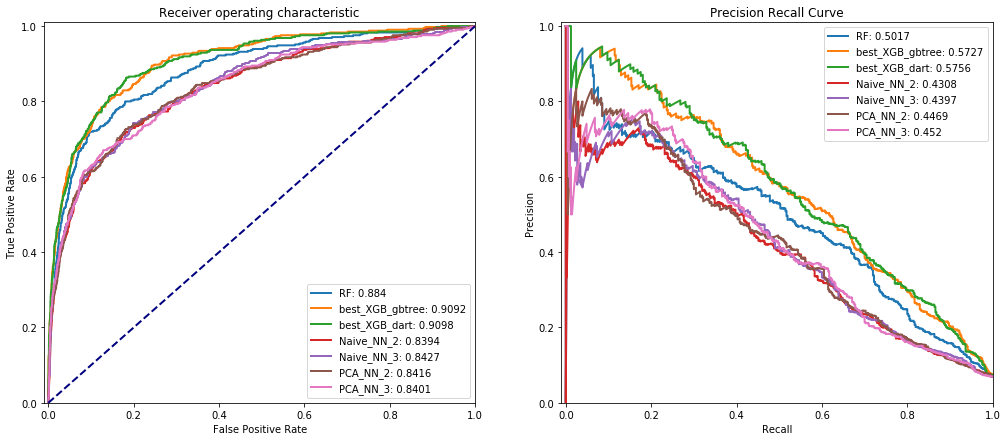

In [142]:
res2plot = []
true = RFdata[target].astype(int).sort_index()
for result in [RF, best_XGB_gbtree, best_XGB_dart,naive_NN_2, naive_NN_3, pca_NN_2, pca_NN_3]:
    true = RFdata[target].sort_index()
    pred = pd.Series(sum(result["predictions"], []), index=sum(result["indices"], [])).sort_index()
    res2plot.append((true, pred, result["name"], result["ROCtestResults"], result["PRtestResults"]))

    
plotROCsPRs(res2plot, foldMeanAUC = True)

XGB outperforms all other algorithms in all the metrics, next is Random Forest, especially in AUC-ROC, in AUC-PR there are thresholds for which NNs beat it but overall even in AUC-PR Random forest outperforms NNs. On ROC NNs results are close to each other, on PR bigger differences may be observed. PCA_NNs looks better than its naive versions, there is also a visible difference (in score) between 2 and 3 layers, but not so big. PCA transformation helps NN work better on lower thresholds it is easy to see that the brown and pink curves are much higher on PR for < 0.2 threshold. Thanks to Wilcoxon test it is possible to verify hypotesis that PCA_NNs works better than the naive ones. The null hypotesis is that 2 experimets has the same median, alternative hypotesis in this case is that PCA_NN has bigger median.

In [143]:
from scipy.stats import wilcoxon
wilcoxon_NN_2 = wilcoxon(np.array(pca_NN_2["PRtestResults"]), np.array(naive_NN_2["PRtestResults"]), alternative="greater")
wilcoxon_NN_3 = wilcoxon(np.array(pca_NN_3["PRtestResults"]), np.array(naive_NN_3["PRtestResults"]), alternative="greater")
print("Wilcoxon tests")
print("H0: AUC-PR median PCA_NN_2 folds == AUC-PR median naive_NN_2 folds\n\
HA: AUC-PR median PCA_NN_2 folds > AUC-PR median naive_NN_2 folds\ntest tatistic: {}\tp_value: {}".format(
wilcoxon_NN_2[0], round(wilcoxon_NN_2[1], 4)))
print("\nH0: AUC-PR median PCA_NN_3 folds == AUC-PR median naive_NN_3 folds\n\
HA: AUC-PR median PCA_NN_3 folds > AUC-PR median naive_NN_3 folds\ntest tatistic: {}\tp_value: {}".format(
wilcoxon_NN_3[0], round(wilcoxon_NN_3[1], 4)))

Wilcoxon tests
H0: AUC-PR median PCA_NN_2 folds == AUC-PR median naive_NN_2 folds
HA: AUC-PR median PCA_NN_2 folds > AUC-PR median naive_NN_2 folds
test tatistic: 15.0	p_value: 0.0216

H0: AUC-PR median PCA_NN_3 folds == AUC-PR median naive_NN_3 folds
HA: AUC-PR median PCA_NN_3 folds > AUC-PR median naive_NN_3 folds
test tatistic: 10.0	p_value: 0.2501


C:\Users\maciej\anaconda3\lib\site-packages\scipy\stats\morestats.py:2879: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


 - at 0.05 confidence level H0 for 2 layers networks is rejected, that means PCA transformation statisticaly boosted the 2 layer neural networ performance
 - at 0.05 confidence level H0 for 3 layers networks is accepted, that means PCA transformation didn't statisticaly boost the 3 layer neural network performance
 
##### Overfitting in models


In [144]:
for model in [RF, best_XGB_gbtree, best_XGB_dart,naive_NN_2, naive_NN_3, pca_NN_2, pca_NN_3]:
    print("model: {}".format(model["name"]))
    print("AUC-ROC overfitting: {}".format(round(np.mean(np.array(model["ROCtrainResults"]) - np.array(model["ROCtestResults"])), 6)))
    print("AUC-PR overfitting: {}".format(round(np.mean(np.array(model["PRtrainResults"]) - np.array(model["PRtestResults"])), 6)))
    print("-"*30,"\n")

model: RF
AUC-ROC overfitting: 0.084324
AUC-PR overfitting: 0.33517
------------------------------ 

model: best_XGB_gbtree
AUC-ROC overfitting: 0.089216
AUC-PR overfitting: 0.409842
------------------------------ 

model: best_XGB_dart
AUC-ROC overfitting: 0.088208
AUC-PR overfitting: 0.403359
------------------------------ 

model: Naive_NN_2
AUC-ROC overfitting: 0.044705
AUC-PR overfitting: 0.144081
------------------------------ 

model: Naive_NN_3
AUC-ROC overfitting: 0.052693
AUC-PR overfitting: 0.172497
------------------------------ 

model: PCA_NN_2
AUC-ROC overfitting: 0.04414
AUC-PR overfitting: 0.13693
------------------------------ 

model: PCA_NN_3
AUC-ROC overfitting: 0.051545
AUC-PR overfitting: 0.14566
------------------------------ 



Overftting goes together with model performance excluding PCA based methods - these models has less overfitting than its naive versions. To check the hypotesis of less overfitting PCA based models than naive, the wilcoxon test may be performed.

In [145]:
roc_NN_2_overfitting = wilcoxon(np.array(pca_NN_2["ROCtrainResults"]) - np.array(pca_NN_2["ROCtestResults"]),
                                     np.array(naive_NN_2["ROCtestResults"]) - np.array(naive_NN_2["ROCtestResults"]),
                            alternative="less")
pr_NN_2_overfitting = wilcoxon(np.array(pca_NN_2["PRtrainResults"]) - np.array(pca_NN_2["PRtestResults"]),
                                     np.array(naive_NN_2["PRtrainResults"]) - np.array(naive_NN_2["PRtestResults"]),
                            alternative="less")

roc_NN_3_overfitting = wilcoxon(np.array(pca_NN_3["ROCtrainResults"]) - np.array(pca_NN_3["ROCtestResults"]),
                                     np.array(naive_NN_3["ROCtestResults"]) - np.array(naive_NN_3["ROCtestResults"]),
                            alternative="less")
pr_NN_3_overfitting = wilcoxon(np.array(pca_NN_3["PRtrainResults"]) - np.array(pca_NN_3["PRtestResults"]),
                                     np.array(naive_NN_3["PRtrainResults"]) - np.array(naive_NN_3["PRtestResults"]),
                            alternative="less")


print("H0: AUC-ROC overfitting median PCA_NN_2 folds == AUC-ROC overfitting median naive_NN_2 folds\n\
HA: AUC-ROC overfitting median PCA_NN_2 folds < AUC-ROC overfitting median naive_NN_2 folds\ntest statistic: {}\tp_value: {}\
".format(roc_NN_2_overfitting[0], round(roc_NN_2_overfitting[1], 4)))

print("\nH0: AUC-PR overfitting median PCA_NN_2 folds == AUC-PR overfitting median naive_NN_2 folds\n\
HA: AUC-PR overfitting median PCA_NN_2 folds < AUC-PR overfitting median naive_NN_2 folds\ntest statistic: {}\tp_value: {}\
".format(pr_NN_2_overfitting[0], round(pr_NN_2_overfitting[1], 4)))

print("\nH0: AUC-ROC overfitting median PCA_NN_3 folds == AUC-ROC overfitting median naive_NN_3 folds\n\
HA: AUC-ROC overfitting median PCA_NN_3 folds < AUC-ROC overfitting median naive_NN_3 folds\ntest statistic: {}\tp_value: {}\
".format(roc_NN_3_overfitting[0], round(roc_NN_3_overfitting[1], 4)))

print("\nH0: AUC-PR overfitting median PCA_NN_3 folds == AUC-PR overfitting median naive_NN_3 folds\n\
HA: AUC-PR overfitting median PCA_NN_3 folds < AUC-PR overfitting median naive_NN_3 folds\ntest statistic: {}\tp_value: {}\
".format(pr_NN_3_overfitting[0], round(pr_NN_3_overfitting[1], 4)))


H0: AUC-ROC overfitting median PCA_NN_2 folds == AUC-ROC overfitting median naive_NN_2 folds
HA: AUC-ROC overfitting median PCA_NN_2 folds < AUC-ROC overfitting median naive_NN_2 folds
test statistic: 15.0	p_value: 0.9784

H0: AUC-PR overfitting median PCA_NN_2 folds == AUC-PR overfitting median naive_NN_2 folds
HA: AUC-PR overfitting median PCA_NN_2 folds < AUC-PR overfitting median naive_NN_2 folds
test statistic: 5.0	p_value: 0.2501

H0: AUC-ROC overfitting median PCA_NN_3 folds == AUC-ROC overfitting median naive_NN_3 folds
HA: AUC-ROC overfitting median PCA_NN_3 folds < AUC-ROC overfitting median naive_NN_3 folds
test statistic: 14.0	p_value: 0.9602

H0: AUC-PR overfitting median PCA_NN_3 folds == AUC-PR overfitting median naive_NN_3 folds
HA: AUC-PR overfitting median PCA_NN_3 folds < AUC-PR overfitting median naive_NN_3 folds
test statistic: 3.0	p_value: 0.1125


Null hypotesis is accepted everytmie that means overfitting folds median is not statisticaly lower for PCA based Neural Networks.

##### Conclusions
 - PCA can extract important information from not imporant features in Neural Network case, but it is not a magic trick, the results are slighlty better (wilcoxon test rejected null hypotesis of median equality for 2 layer Neural Network PR results and accepted the null hypotesis of median equality for 3 layer Neural Network PR results and AUC-ROC and AUC-PR overfitting median equality). However PCA should be considered during predictive modelling of high dimensional data, especially when there are correlated features.
 - Random Forest impurity based feature importance score gives the best results in terms of feature selection among considered ones: Mutual Information, Spearman correlation, General to Specyfic Logistic Regression LR test, L2 Logistic regression, but all of this methods are important and may be used successfully during analysis.
 - If overfitting is not a problem, tree-based methods outperforms Neural Networks in current task. Extreme Gradient Boosting with gbtree or dart booster performance was the best, following by Random Forest (the easiest to implement).  
 - General Advice: If you don't have time, just use the Random Forests, tune it and it'll be fine. 